In [ ]:
# Install required package
!pip install faker

In [12]:
# Import libraries
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from faker import Faker
import os

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Initialize Faker
fake = Faker()

def introduce_nulls_and_redundancy(df, null_percentage=0.05, redundant_percentage=0.10):
    """
    Introduce null values and redundant data to the dataset
    """
    df_modified = df.copy()
    n_rows = len(df_modified)

    # Define columns that should not have nulls (critical identifiers)
    protected_columns = ['Name']  # Keep at least name as identifier

    # Define redundant values for different column types
    redundant_values = {
        'text': ['Unknown', 'Not Specified', 'N/A', 'Other', 'Unspecified'],
        'numeric': [0, -1, 999, 9999],
        'categorical': ['Unknown', 'Other', 'Not Available', 'Unspecified'],
        'yes_no': ['Unknown', 'Not Sure', 'N/A'],
        'frequency': ['Unknown', 'Not Reported', 'Varies']
    }

    for column in df_modified.columns:
        if column in protected_columns:
            continue

        # Calculate number of null and redundant values to introduce
        n_nulls = int(n_rows * null_percentage)
        n_redundant = int(n_rows * redundant_percentage)

        # Randomly select indices for nulls and redundant values
        null_indices = np.random.choice(df_modified.index, size=n_nulls, replace=False)
        remaining_indices = df_modified.index.difference(null_indices)
        redundant_indices = np.random.choice(remaining_indices,
                                           size=min(n_redundant, len(remaining_indices)),
                                           replace=False)

        # Introduce null values
        df_modified.loc[null_indices, column] = np.nan

        # Introduce redundant values based on column type
        if column in ['Age', 'Height_cm', 'Weight_kg', 'BMI', 'MUAC']:
            # Numeric columns
            redundant_val = np.random.choice(redundant_values['numeric'])
            df_modified.loc[redundant_indices, column] = redundant_val

        elif column in ['Education', 'BMI_Category', 'MUAC_Category', 'Nutritional_Status',
                       'Age_Group', 'Education_Level', 'Dietary_Pattern', 'Protein_Intake']:
            # Categorical columns
            redundant_val = np.random.choice(redundant_values['categorical'])
            df_modified.loc[redundant_indices, column] = redundant_val

        elif column in ['Iron_Supplement', 'Infection_Status', 'Chronic_Disease_Status',
                       'Smoking', 'Alcohol', 'Lifestyle_Risk', 'Anemia'] or 'Yes' in str(df_modified[column].iloc[0]):
            # Yes/No or similar binary columns
            redundant_val = np.random.choice(redundant_values['yes_no'])
            df_modified.loc[redundant_indices, column] = redundant_val

        elif column in ['Sweet food', 'Salty food', 'Cholesterol-rich food',
                       'Grilled food', 'Meat', 'Spicy food']:
            # Frequency columns
            redundant_val = np.random.choice(redundant_values['frequency'])
            df_modified.loc[redundant_indices, column] = redundant_val

        elif column in ['Visit_Date', 'Visit_Time']:
            # Date/Time columns - introduce some invalid formats
            invalid_dates = ['0000-00-00', '1900-01-01', 'Invalid', 'N/A']
            invalid_times = ['00:00', '99:99', 'Invalid', 'N/A']
            if 'Date' in column:
                redundant_val = np.random.choice(invalid_dates)
            else:
                redundant_val = np.random.choice(invalid_times)
            df_modified.loc[redundant_indices, column] = redundant_val

        else:
            # Default to text redundant values
            redundant_val = np.random.choice(redundant_values['text'])
            df_modified.loc[redundant_indices, column] = redundant_val

    return df_modified

In [13]:
def generate_pregnant_women_dataset(n_samples=12174):
    data = []
    start_date = datetime(2025, 6, 3, 8, 0)

    for i in range(n_samples):
        weeks_offset = i // 17
        days_offset = weeks_offset * 7 + random.randint(0, 6)
        hours_offset = random.randint(0, 12)
        minutes_offset = random.randint(0, 59)

        visit_date = start_date + timedelta(days=days_offset, hours=hours_offset, minutes=minutes_offset)

        name = fake.first_name_female() + " " + fake.last_name()
        age = np.random.choice([
            np.random.randint(18, 35),
            np.random.randint(35, 45)
        ], p=[0.7, 0.3])

        education_options = ['pre-school', 'primary', 'jhs', 'high school', 'university undergraduate', 'masters', 'phd']
        education = np.random.choice(education_options, p=[0.05, 0.15, 0.20, 0.25, 0.25, 0.08, 0.02])

        height = np.random.normal(160, 8)
        height = max(140, min(180, height))
        base_weight = np.random.normal(65, 12)
        pregnancy_weight_gain = np.random.normal(12, 5)
        weight = max(45, base_weight + pregnancy_weight_gain)
        bmi = weight / ((height/100) ** 2)

        bmi_category = (
            'Underweight' if bmi < 18.5 else
            'Normal' if bmi <= 24.9 else
            'Overweight/Obese'
        )

        age_group = 'Young Adult' if age < 25 else 'Adult' if age < 35 else 'Mature Adult'
        education_level = 'High' if education in ['university undergraduate', 'masters', 'phd'] else 'Low'

        muac = np.random.choice([
            np.random.uniform(20.0, 23.4),
            np.random.uniform(23.5, 30.0)
        ], p=[0.3, 0.7])
        muac_category = 'Low' if muac < 23.5 else 'Normal'

        if bmi < 18.5 or muac < 23.5:
            nutritional_status = 'Malnourished'
        elif bmi >= 25:
            nutritional_status = 'Overweight'
        else:
            nutritional_status = 'Normal'

        iron_supplement = np.random.choice(['Yes', 'No'], p=[0.75, 0.25])

        conditions = {}
        condition_probabilities = {
            'Acute Respiratory Infection': 0.15,
            'Diarrhea': 0.12,
            'Pneumonia': 0.08,
            'Malaria': 0.25,
            'Tuberculosis': 0.05,
            'Hepatitis': 0.03,
            'Cancer': 0.01,
            'Diabetic Mellitus': 0.10,
            'Hyperthyroid': 0.07,
            'Hypertension': 0.18,
            'Rheumatic': 0.06,
            'Stroke': 0.02
        }

        for condition, prob in condition_probabilities.items():
            conditions[condition] = np.random.choice(['Yes', 'No'], p=[prob, 1-prob])

        infection_conditions = ['Acute Respiratory Infection', 'Pneumonia', 'Malaria', 'Tuberculosis', 'Hepatitis']
        has_infection = any(conditions[cond] == 'Yes' for cond in infection_conditions)
        infection_status = 'Yes' if has_infection else 'No'

        chronic_conditions = ['Diabetic Mellitus', 'Hypertension', 'Cancer']
        has_chronic = any(conditions[cond] == 'Yes' for cond in chronic_conditions)
        chronic_disease_status = 'Yes' if has_chronic else 'No'

        food_types = ['Sweet food', 'Salty food', 'Cholesterol-rich food',
                      'Grilled food', 'Meat', 'Spicy food']
        food_frequencies = {}

        for food in food_types:
            if food == 'Meat':
                food_frequencies[food] = np.random.choice(['Daily', 'Weekly', 'Monthly'], p=[0.2, 0.5, 0.3])
            elif food in ['Sweet food', 'Salty food']:
                food_frequencies[food] = np.random.choice(['Daily', 'Weekly', 'Monthly'], p=[0.4, 0.4, 0.2])
            else:
                food_frequencies[food] = np.random.choice(['Daily', 'Weekly', 'Monthly'], p=[0.3, 0.4, 0.3])

        daily_foods = sum(1 for freq in food_frequencies.values() if freq == 'Daily')
        dietary_pattern = (
            'Frequent Consumer' if daily_foods >= 4 else
            'Moderate Consumer' if daily_foods >= 2 else
            'Infrequent Consumer'
        )

        protein_intake = (
            'High' if food_frequencies['Meat'] == 'Daily' else
            'Moderate' if food_frequencies['Meat'] == 'Weekly' else
            'Low'
        )

        smoking = np.random.choice(['Yes', 'Rarely', 'None'], p=[0.05, 0.10, 0.85])
        alcohol = np.random.choice(['Yes', 'Rarely', 'None'], p=[0.03, 0.12, 0.85])
        lifestyle_risk = 'High' if ('Yes' in [smoking, alcohol]) else 'Moderate' if ('Rarely' in [smoking, alcohol]) else 'Low'

        anemia_risk = 0.3
        if age < 20 or age > 35: anemia_risk += 0.1
        if muac < 23.5: anemia_risk += 0.15
        if bmi < 18.5: anemia_risk += 0.2
        if iron_supplement == 'No': anemia_risk += 0.25
        if conditions['Malaria'] == 'Yes': anemia_risk += 0.15
        if conditions['Tuberculosis'] == 'Yes': anemia_risk += 0.1
        if education in ['pre-school', 'primary']: anemia_risk += 0.1
        if food_frequencies['Meat'] == 'Monthly': anemia_risk += 0.1
        anemia_risk = min(0.8, anemia_risk)
        anemia_status = np.random.choice(['Yes', 'No'], p=[anemia_risk, 1-anemia_risk])

        record = {
            'Name': name,
            'Visit_Date': visit_date.strftime('%Y-%m-%d'),
            'Visit_Time': visit_date.strftime('%H:%M'),
            'Age': age,
            'Age_Group': age_group,
            'Education': education,
            'Education_Level': education_level,
            'Height_cm': round(height, 1),
            'Weight_kg': round(weight, 1),
            'BMI': round(bmi, 1),
            'BMI_Category': bmi_category,
            'MUAC': round(muac, 1),
            'MUAC_Category': muac_category,
            'Nutritional_Status': nutritional_status,
            'Iron_Supplement': iron_supplement,
            'Infection_Status': infection_status,
            'Chronic_Disease_Status': chronic_disease_status,
            'Smoking': smoking,
            'Alcohol': alcohol,
            'Lifestyle_Risk': lifestyle_risk,
            'Dietary_Pattern': dietary_pattern,
            'Protein_Intake': protein_intake,
            'Anemia': anemia_status
        }

        record.update(food_frequencies)
        record.update(conditions)

        data.append(record)

    return data

In [4]:
# Generate dataset
print("🔄 Generating base dataset...")
data = generate_pregnant_women_dataset()
df = pd.DataFrame(data)

print("🔄 Introducing null values and redundant data...")
df_with_issues = introduce_nulls_and_redundancy(
    df,
    null_percentage=0.08,
    redundant_percentage=0.12
)

# Save to CSV
csv_filename = "pregnant_women_anemia_dataset_with_nulls.csv"
df_with_issues.to_csv(csv_filename, index=False)

print(f"✅ Dataset successfully saved as {csv_filename}")

# Print summary of data quality issues
print("\n📊 Data Quality Summary:")
print(f"Total records: {len(df_with_issues)}")
print(f"Total columns: {len(df_with_issues.columns)}")

null_counts = df_with_issues.isnull().sum()
print(f"\nNull values per column:")
for col, count in null_counts.items():
    if count > 0:
        percentage = (count / len(df_with_issues)) * 100
        print(f"  {col}: {count} ({percentage:.1f}%)")

# Count redundant values (approximate)
redundant_indicators = ['Unknown', 'N/A', 'Not Specified', 'Other', 'Unspecified',
                       'Not Available', 'Not Sure', 'Invalid', 'Varies', 'Not Reported']
total_redundant = 0
for col in df_with_issues.columns:
    if df_with_issues[col].dtype == 'object':
        redundant_count = df_with_issues[col].astype(str).str.contains('|'.join(redundant_indicators), na=False).sum()
        if redundant_count > 0:
            total_redundant += redundant_count

print(f"\nApproximate redundant/invalid values: {total_redundant}")

🔄 Generating base dataset...
🔄 Introducing null values and redundant data...
✅ Dataset successfully saved as pregnant_women_anemia_dataset_with_nulls.csv

📊 Data Quality Summary:
Total records: 12174
Total columns: 41

Null values per column:
  Visit_Date: 973 (8.0%)
  Visit_Time: 973 (8.0%)
  Age: 973 (8.0%)
  Age_Group: 973 (8.0%)
  Education: 973 (8.0%)
  Education_Level: 973 (8.0%)
  Height_cm: 973 (8.0%)
  Weight_kg: 973 (8.0%)
  BMI: 973 (8.0%)
  BMI_Category: 973 (8.0%)
  MUAC: 973 (8.0%)
  MUAC_Category: 973 (8.0%)
  Nutritional_Status: 973 (8.0%)
  Iron_Supplement: 973 (8.0%)
  Infection_Status: 973 (8.0%)
  Chronic_Disease_Status: 973 (8.0%)
  Smoking: 973 (8.0%)
  Alcohol: 973 (8.0%)
  Lifestyle_Risk: 973 (8.0%)
  Dietary_Pattern: 973 (8.0%)
  Protein_Intake: 973 (8.0%)
  Anemia: 973 (8.0%)
  Sweet food: 973 (8.0%)
  Salty food: 973 (8.0%)
  Cholesterol-rich food: 973 (8.0%)
  Grilled food: 973 (8.0%)
  Meat: 973 (8.0%)
  Spicy food: 973 (8.0%)
  Acute Respiratory Infection:

In [5]:
def clean_dataset(df):
    """
    Comprehensive data cleaning function that maintains all original columns
    """
    # Make a copy of the original dataframe
    cleaned_df = df.copy()

    # Store original columns order and names
    original_columns = df.columns.tolist()

    # =============================================
    # 1. Handle Null Values
    # =============================================

    # Identify column types
    numeric_cols = cleaned_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = cleaned_df.select_dtypes(include=['object']).columns

    # Custom handling for specific columns
    date_cols = ['Visit_Date'] if 'Visit_Date' in cleaned_df.columns else []
    time_cols = ['Visit_Time'] if 'Visit_Time' in cleaned_df.columns else []

    # Remove from numeric/categorical if they were automatically included
    numeric_cols = numeric_cols.drop(date_cols + time_cols, errors='ignore')
    categorical_cols = categorical_cols.drop(date_cols + time_cols, errors='ignore')

    # Imputation strategies
    print("🔧 Imputing missing values...")

    # Numeric columns - mean imputation
    if len(numeric_cols) > 0:
        num_imputer = SimpleImputer(strategy='mean')
        cleaned_df[numeric_cols] = num_imputer.fit_transform(cleaned_df[numeric_cols])

    # Categorical columns - mode imputation
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        cleaned_df[categorical_cols] = cat_imputer.fit_transform(cleaned_df[categorical_cols])

    # Special handling for date/time columns
    for col in date_cols:
        mode_date = cleaned_df[col].mode()[0]
        cleaned_df[col].fillna(mode_date, inplace=True)

    for col in time_cols:
        mode_time = cleaned_df[col].mode()[0]
        cleaned_df[col].fillna(mode_time, inplace=True)

    # =============================================
    # 2. Handle Redundant/Invalid Values
    # =============================================

    print("🧹 Cleaning redundant/invalid values...")

    # Define invalid/redundant values
    invalid_values = [
        'Unknown', 'N/A', 'Not Specified', 'Other', 'Unspecified',
        'Not Available', 'Not Sure', 'Invalid', 'Varies', 'Not Reported',
        '0000-00-00', '1900-01-01', '99:99'
    ]

    numeric_placeholders = [0, -1, 999, 9999]

    # Process each column
    for col in cleaned_df.columns:
        if col == 'Name':
            continue

        # Numeric columns
        if col in numeric_cols:
            placeholder_mask = cleaned_df[col].isin(numeric_placeholders)
            if placeholder_mask.any():
                col_mean = cleaned_df.loc[~placeholder_mask, col].mean()
                cleaned_df.loc[placeholder_mask, col] = col_mean

        # Categorical columns
        elif col in categorical_cols:
            invalid_mask = cleaned_df[col].astype(str).str.contains('|'.join(invalid_values), na=False)
            if invalid_mask.any():
                col_mode = cleaned_df.loc[~invalid_mask, col].mode()[0]
                cleaned_df.loc[invalid_mask, col] = col_mode

        # Date/time columns
        elif col in date_cols + time_cols:
            if col in date_cols:
                invalid_date_mask = cleaned_df[col].astype(str).str.contains('|'.join(invalid_values), na=False)
                if invalid_date_mask.any():
                    col_mode = cleaned_df.loc[~invalid_date_mask, col].mode()[0]
                    cleaned_df.loc[invalid_date_mask, col] = col_mode
            elif col in time_cols:
                invalid_time_mask = cleaned_df[col].astype(str).str.contains('|'.join(invalid_values), na=False)
                if invalid_time_mask.any():
                    col_mode = cleaned_df.loc[~invalid_time_mask, col].mode()[0]
                    cleaned_df.loc[invalid_time_mask, col] = col_mode

    # =============================================
    # 3. Data Consistency Checks
    # =============================================

    print("🔍 Running consistency checks...")

    # Recalculate derived fields
    if {'Height_cm', 'Weight_kg', 'BMI'}.issubset(cleaned_df.columns):
        mask = cleaned_df['BMI'].isna() | (cleaned_df['BMI'] == 0)
        cleaned_df.loc[mask, 'BMI'] = cleaned_df.loc[mask, 'Weight_kg'] / ((cleaned_df.loc[mask, 'Height_cm']/100) ** 2)

    if 'MUAC' in cleaned_df.columns and 'MUAC_Category' in cleaned_df.columns:
        cleaned_df['MUAC_Category'] = np.where(cleaned_df['MUAC'] < 23.5, 'Low', 'Normal')

    # Ensure we maintain all original columns exactly as they were
    cleaned_df = cleaned_df[original_columns]

    return cleaned_df

In [6]:
# ✅ Necessary imports
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from IPython.display import HTML
import base64

# 🚀 Clean the dataset
print("\n🚀 Starting data cleaning process...")

def clean_dataset(df):
    cleaned_df = df.copy()

    # Drop completely empty columns
    cleaned_df = cleaned_df.dropna(axis=1, how='all')

    # Identify numeric and categorical columns
    numeric_cols = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = cleaned_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Numeric columns - mean imputation
    if len(numeric_cols) > 0:
        num_imputer = SimpleImputer(strategy='mean')
        cleaned_df[numeric_cols] = num_imputer.fit_transform(cleaned_df[numeric_cols])

    # Categorical columns - mode imputation
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        cleaned_df[categorical_cols] = cat_imputer.fit_transform(cleaned_df[categorical_cols])

    # Strip whitespace and standardize text values for categorical columns
    for col in categorical_cols:
        cleaned_df[col] = cleaned_df[col].astype(str).str.strip().str.title()

    return cleaned_df

# Assuming df_with_issues is already defined
cleaned_df = clean_dataset(df_with_issues)

# ✅ Verify cleaning results
print("\n✅ Cleaning completed. Results:")
print(f"Original columns: {len(df.columns)}")
print(f"Cleaned columns: {len(cleaned_df.columns)}")
print(f"Columns match: {set(df.columns) == set(cleaned_df.columns)}")
print(f"Remaining null values: {cleaned_df.isnull().sum().sum()}")

# 🔍 Count remaining redundant values
redundant_indicators = [
    'Unknown', 'N/A', 'Not Specified', 'Other', 'Unspecified',
    'Not Available', 'Not Sure', 'Invalid', 'Varies', 'Not Reported'
]
redundant_count = 0
for col in cleaned_df.columns:
    if cleaned_df[col].dtype == 'object':
        redundant_count += cleaned_df[col].astype(str).str.contains('|'.join(redundant_indicators), na=False).sum()

print(f"Remaining redundant values: {redundant_count}")

# 💾 Save cleaned dataset
cleaned_filename = "cleaned_pregnant_women_anemia_dataset.csv"
cleaned_df.to_csv(cleaned_filename, index=False)
print(f"\n💾 Cleaned dataset saved as '{cleaned_filename}'")

# 📎 Create a downloadable link
def create_download_link(filename, title="Download CSV file"):
    with open(filename, 'rb') as f:
        data = f.read()
    b64 = base64.b64encode(data).decode()
    href = f'<a href="data:file/csv;base64,{b64}" download="{filename}">{title}</a>'
    return href

# Display the download link
display(HTML(create_download_link(cleaned_filename)))



🚀 Starting data cleaning process...

✅ Cleaning completed. Results:
Original columns: 41
Cleaned columns: 41
Columns match: True
Remaining null values: 0
Remaining redundant values: 48180

💾 Cleaned dataset saved as 'cleaned_pregnant_women_anemia_dataset.csv'


In [14]:
import pandas as pd

df = pd.read_csv("cleaned_pregnant_women_anemia_dataset.csv")

# List all columns (features)
print("📌 Columns in the dataset:")
print(df.columns.tolist())

📌 Columns in the dataset:
['Name', 'Visit_Date', 'Visit_Time', 'Age', 'Age_Group', 'Education', 'Education_Level', 'Height_cm', 'Weight_kg', 'BMI', 'BMI_Category', 'MUAC', 'MUAC_Category', 'Nutritional_Status', 'Iron_Supplement', 'Infection_Status', 'Chronic_Disease_Status', 'Smoking', 'Alcohol', 'Lifestyle_Risk', 'Dietary_Pattern', 'Protein_Intake', 'Anemia', 'Sweet food', 'Salty food', 'Cholesterol-rich food', 'Grilled food', 'Meat', 'Spicy food', 'Acute Respiratory Infection', 'Diarrhea', 'Pneumonia', 'Malaria', 'Tuberculosis', 'Hepatitis', 'Cancer', 'Diabetic Mellitus', 'Hyperthyroid', 'Hypertension', 'Rheumatic', 'Stroke']


In [8]:
# List of columns to drop
columns_to_drop = [
    'Age_Group',
    'Education_Level',
    'BMI_Category',
    'MUAC_Category',
    'Nutritional_Status',
    'Infection_Status',
    'Chronic_Disease_Status',
    'Smoking',
    'Alcohol',
    'Lifestyle_Risk',
    'Dietary_Pattern',
    'Protein_Intake'
]

# Drop the columns
df_cleaned = df.drop(columns=columns_to_drop)

# Save to new CSV file
cleaned_csv_filename = "pregnant_women_anemia_dataset.csv"
df_cleaned.to_csv(cleaned_csv_filename, index=False)

print(f"✅ Cleaned dataset saved as {cleaned_csv_filename}")

✅ Cleaned dataset saved as pregnant_women_anemia_dataset.csv


In [9]:
import pandas as pd

df = pd.read_csv("pregnant_women_anemia_dataset.csv")

# List all columns (features)
print("📌 Columns in the final dataset:")
print(df.columns.tolist()) 

📌 Columns in the final dataset:
['Name', 'Visit_Date', 'Visit_Time', 'Age', 'Education', 'Height_cm', 'Weight_kg', 'BMI', 'MUAC', 'Iron_Supplement', 'Anemia', 'Sweet food', 'Salty food', 'Cholesterol-rich food', 'Grilled food', 'Meat', 'Spicy food', 'Acute Respiratory Infection', 'Diarrhea', 'Pneumonia', 'Malaria', 'Tuberculosis', 'Hepatitis', 'Cancer', 'Diabetic Mellitus', 'Hyperthyroid', 'Hypertension', 'Rheumatic', 'Stroke']


In [10]:
import pandas as pd

# 📥 Load the dataset
df = pd.read_csv("pregnant_women_anemia_dataset.csv")

# 🔎 Check if there are any missing (null) values in the entire DataFrame
print("❓ Any null values in dataset?:", df.isnull().values.any())

# 📊 Show the total number of null values
print("\n📌 Total missing values in dataset:", df.isnull().sum().sum())

# 📋 Show null value count for each column
print("\n🧾 Missing values by column:")
print(df.isnull().sum())

# 📉 Optionally, show percentage of missing data per column
missing_percent = df.isnull().mean() * 100
print("\n📊 Percentage of missing data per column:")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))


❓ Any null values in dataset?: True

📌 Total missing values in dataset: 2920

🧾 Missing values by column:
Name                              0
Visit_Date                        0
Visit_Time                        0
Age                               0
Education                         0
Height_cm                         0
Weight_kg                         0
BMI                               0
MUAC                              0
Iron_Supplement                1460
Anemia                            0
Sweet food                        0
Salty food                        0
Cholesterol-rich food             0
Grilled food                      0
Meat                              0
Spicy food                        0
Acute Respiratory Infection       0
Diarrhea                          0
Pneumonia                         0
Malaria                           0
Tuberculosis                      0
Hepatitis                         0
Cancer                            0
Diabetic Mellitus             

In [20]:
# 📊 Dataset Processor with Selective Encoding
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 📥 Load and process dataset
df = pd.read_csv("pregnant_women_anemia_dataset.csv")

# Store original for comparison
df_original = df.copy()

print("="*80)
print("🔍 ORIGINAL DATASET OVERVIEW")
print("="*80)
print(f"📊 Original Shape: {df_original.shape}")
print(f"📋 Original Columns: {list(df_original.columns)}")

# 🚫 Define columns to NEVER encode (preserve as-is)
columns_to_preserve = []
preserve_keywords = ['name', 'visit date', 'visit time', 'date', 'time', 'id']

# Find columns that match preservation keywords (case-insensitive)
for col in df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in preserve_keywords):
        columns_to_preserve.append(col)

print(f"\n🔒 Columns to PRESERVE (not encode): {columns_to_preserve}")

# 🔍 Step 1: Replace redundant placeholder values with NaN
redundant_values = ['Unknown', 'N/A', 'Not Specified', 'Other', 'Unspecified',
                    'Not Available', 'Not Sure', 'Invalid', 'Varies', 'Not Reported']
df.replace(redundant_values, np.nan, inplace=True)

# 🛠️ Step 2: Convert to numeric where possible (except preserved columns)
for col in df.columns:
    if col not in columns_to_preserve and df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass  # If conversion fails, leave as is

# 🎯 Identify column types
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# Separate categorical columns into preserve vs encode
categorical_to_preserve = [col for col in categorical_cols if col in columns_to_preserve]
categorical_to_encode = [col for col in categorical_cols if col not in columns_to_preserve]

print(f"\n📊 COLUMN CLASSIFICATION:")
print(f"🔢 Numeric columns ({len(numeric_cols)}): {list(numeric_cols)}")
print(f"🔒 Categorical to PRESERVE ({len(categorical_to_preserve)}): {categorical_to_preserve}")
print(f"🔄 Categorical to ENCODE ({len(categorical_to_encode)}): {categorical_to_encode}")

# 🧹 Step 3: Handle missing values
# For numeric columns
if len(numeric_cols) > 0:
    num_imputer = SimpleImputer(strategy='mean')
    df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# For categorical columns (both preserve and encode)
if len(categorical_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# 🔄 Step 4: Create encoded version with selective encoding
df_encoded = df.copy()
label_encoders = {}

# Only encode categorical columns that are NOT in the preserve list
for col in categorical_to_encode:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

print("\n" + "="*80)
print("🔍 PROCESSED DATASET OVERVIEW")
print("="*80)

# 📋 Basic Information
print(f"📊 Dataset Shape: {df.shape}")
print(f"🔢 Total Rows: {df.shape[0]:,}")
print(f"📋 Total Columns: {df.shape[1]}")
print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"❌ Missing Values After Processing: {df.isnull().sum().sum()}")
print(f"🔄 Duplicated Rows: {df.duplicated().sum()}")

# 👀 Display first few rows of processed data
print("\n" + "="*80)
print("👀 PROCESSED DATA PREVIEW (First 5 rows)")
print("="*80)
with pd.option_context('display.max_columns', None, 'display.width', None):
    print(df.head(5))

# 📊 Statistical Summary for numeric columns
if len(numeric_cols) > 0:
    print("\n" + "="*80)
    print("📊 NUMERIC COLUMNS STATISTICAL SUMMARY")
    print("="*80)
    print(df[numeric_cols].describe().round(3))

# 🔒 Show preserved categorical columns
if len(categorical_to_preserve) > 0:
    print("\n" + "="*80)
    print("🔒 PRESERVED CATEGORICAL COLUMNS (Not Encoded)")
    print("="*80)
    for col in categorical_to_preserve:
        print(f"\n🔹 {col}:")
        value_counts = df[col].value_counts()
        print(f"   Unique values: {len(value_counts)}")
        print(f"   Sample values: {list(df[col].unique()[:5])}")
        if len(value_counts) <= 10:
            print(f"   All values: {list(value_counts.index)}")

# 🔄 Show encoded categorical columns
if len(categorical_to_encode) > 0:
    print("\n" + "="*80)
    print("🔄 ENCODED CATEGORICAL COLUMNS")
    print("="*80)
    for col in categorical_to_encode:
        print(f"\n🔹 {col}:")
        value_counts = df[col].value_counts()
        print(f"   Unique values: {len(value_counts)}")
        print(f"   Sample original values: {list(value_counts.index[:5])}")
        
        # Show encoding mapping
        unique_vals = df[col].unique()
        encoded_vals = label_encoders[col].transform(unique_vals.astype(str))
        mapping = dict(zip(unique_vals, encoded_vals))
        print(f"   Encoding mapping: {dict(list(mapping.items())[:5])}")
        if len(mapping) > 5:
            print(f"   ... and {len(mapping) - 5} more mappings")

# 👀 Display encoded data preview
print("\n" + "="*80)
print("🔢 ENCODED DATA PREVIEW (First 5 rows)")
print("="*80)
with pd.option_context('display.max_columns', None, 'display.width', None):
    print(df_encoded.head(5))

# Show which columns were encoded vs preserved in the encoded dataset
encoded_cols = [col for col in df_encoded.columns if col in categorical_to_encode]
preserved_in_encoded = [col for col in df_encoded.columns if col in categorical_to_preserve]
numeric_in_encoded = list(numeric_cols)

print(f"\n📊 ENCODED DATASET COMPOSITION:")
print(f"🔢 Numeric columns: {len(numeric_in_encoded)} - {numeric_in_encoded}")
print(f"🔄 Encoded columns: {len(encoded_cols)} - {encoded_cols}")
print(f"🔒 Preserved columns: {len(preserved_in_encoded)} - {preserved_in_encoded}")

# 💾 Export all versions
print("\n" + "="*80)
print("💾 EXPORTING ALL DATASET VERSIONS")
print("="*80)

# 1. Save processed data (with original categorical values)
df.to_csv('processed_anemia_dataset.csv', index=False)
print("✅ 1. Saved 'processed_anemia_dataset.csv'")
print("   - Missing values filled")
print("   - Redundant values cleaned")
print("   - All original categorical values preserved")

# 2. Save encoded data (selective encoding)
df_encoded.to_csv('encoded_anemia_dataset.csv', index=False)
print("\n✅ 2. Saved 'encoded_anemia_dataset.csv'")
print("   - Numeric columns: unchanged")
print(f"   - Encoded columns ({len(categorical_to_encode)}): {categorical_to_encode}")
print(f"   - Preserved columns ({len(categorical_to_preserve)}): {categorical_to_preserve}")
print("   - Ready for machine learning (with preserved identifiers)")

# 3. Save original for comparison
df_original.to_csv('original_anemia_dataset.csv', index=False)
print("\n✅ 3. Saved 'original_anemia_dataset.csv'")
print("   - Completely unchanged original dataset")

# 4. Create comprehensive data dictionary
data_dict = []
for col in df.columns:
    col_info = {
        'Column': col,
        'Original_Type': str(df_original[col].dtype),
        'Processed_Type': 'Numeric' if col in numeric_cols else 'Categorical',
        'Encoding_Status': 'Preserved' if col in columns_to_preserve else ('Encoded' if col in categorical_to_encode else 'Numeric'),
        'Non_Null_Count': df[col].count(),
        'Null_Count_Original': df_original[col].isnull().sum(),
        'Null_Count_Processed': df[col].isnull().sum(),
        'Unique_Values': df[col].nunique(),
        'Sample_Values': str(list(df[col].unique()[:3])) if df[col].nunique() <= 10 else str(list(df[col].unique()[:2])) + "..."
    }
    data_dict.append(col_info)

data_dict_df = pd.DataFrame(data_dict)
data_dict_df.to_csv('data_dictionary.csv', index=False)
print("\n✅ 4. Saved 'data_dictionary.csv'")
print("   - Complete column information")
print("   - Shows which columns were encoded vs preserved")
print("   - Original vs processed statistics")

# 5. Save encoding mappings (only for encoded columns)
if len(categorical_to_encode) > 0:
    encoding_info = []
    for col in categorical_to_encode:
        unique_vals = df[col].unique()
        encoded_vals = label_encoders[col].transform(unique_vals.astype(str))
        for original, encoded in zip(unique_vals, encoded_vals):
            encoding_info.append({
                'Column': col,
                'Original_Value': original,
                'Encoded_Value': encoded
            })
    
    encoding_df = pd.DataFrame(encoding_info)
    encoding_df.to_csv('encoding_mappings.csv', index=False)
    print("\n✅ 5. Saved 'encoding_mappings.csv'")
    print("   - Shows how categorical values were converted to numbers")
    print(f"   - Only includes encoded columns: {categorical_to_encode}")
    print(f"   - Preserved columns not included: {categorical_to_preserve}")
else:
    # Create empty encoding file if no columns were encoded
    pd.DataFrame({'Column': [], 'Original_Value': [], 'Encoded_Value': []}).to_csv('encoding_mappings.csv', index=False)
    print("\n✅ 5. Saved 'encoding_mappings.csv'")
    print("   - Empty file (no columns were encoded)")

print("\n" + "="*80)
print("🎉 ALL 5 FILES READY FOR DOWNLOAD!")
print("="*80)
print("📁 Files created:")
print("   1. processed_anemia_dataset.csv - Clean data with original categories")
print("   2. encoded_anemia_dataset.csv - Selective encoding (preserves name/date/time)")
print("   3. original_anemia_dataset.csv - Original unchanged data")
print("   4. data_dictionary.csv - Complete column information & encoding status")
print("   5. encoding_mappings.csv - Encoding mappings (only for encoded columns)")

# 🎯 Final summary
print("\n" + "="*80)
print("📊 FINAL PROCESSING SUMMARY")
print("="*80)
print(f"🔍 Original dataset: {df_original.shape[0]} rows × {df_original.shape[1]} columns")
print(f"🧹 Processed dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"❌ Missing values: {df_original.isnull().sum().sum()} → {df.isnull().sum().sum()}")
print(f"🔒 Columns preserved from encoding: {len(categorical_to_preserve)}")
print(f"🔄 Columns encoded: {len(categorical_to_encode)}")
print(f"🔢 Numeric columns: {len(numeric_cols)}")

print(f"\n🎯 Key Features:")
print(f"   ✅ Name, visit date, visit time preserved in encoded dataset")
print(f"   ✅ Other categorical variables properly encoded for ML")
print(f"   ✅ All missing values handled")
print(f"   ✅ Five different dataset versions available")
print(f"   ✅ Complete documentation and mappings provided")

🔍 ORIGINAL DATASET OVERVIEW
📊 Original Shape: (12174, 29)
📋 Original Columns: ['Name', 'Visit_Date', 'Visit_Time', 'Age', 'Education', 'Height_cm', 'Weight_kg', 'BMI', 'MUAC', 'Iron_Supplement', 'Anemia', 'Sweet food', 'Salty food', 'Cholesterol-rich food', 'Grilled food', 'Meat', 'Spicy food', 'Acute Respiratory Infection', 'Diarrhea', 'Pneumonia', 'Malaria', 'Tuberculosis', 'Hepatitis', 'Cancer', 'Diabetic Mellitus', 'Hyperthyroid', 'Hypertension', 'Rheumatic', 'Stroke']

🔒 Columns to PRESERVE (not encode): ['Name', 'Visit_Date', 'Visit_Time', 'Hyperthyroid']

📊 COLUMN CLASSIFICATION:
🔢 Numeric columns (5): ['Age', 'Height_cm', 'Weight_kg', 'BMI', 'MUAC']
🔒 Categorical to PRESERVE (4): ['Name', 'Visit_Date', 'Visit_Time', 'Hyperthyroid']
🔄 Categorical to ENCODE (20): ['Education', 'Iron_Supplement', 'Anemia', 'Sweet food', 'Salty food', 'Cholesterol-rich food', 'Grilled food', 'Meat', 'Spicy food', 'Acute Respiratory Infection', 'Diarrhea', 'Pneumonia', 'Malaria', 'Tuberculosis', 'He

In [1]:
# Data Anomaly Correction for Anemia Dataset
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

print("="*80)
print("🔧 LOADING ENCODED DATASET FOR ANOMALY CORRECTION")
print("="*80)

# Load the encoded dataset
df = pd.read_csv("encoded_anemia_dataset.csv")
print(f"📊 Loaded dataset shape: {df.shape}")

# Store original for comparison
df_before_correction = df.copy()

print("\n" + "="*80)
print("🔍 IDENTIFYING ANOMALIES")
print("="*80)

# Check for anomalies in each problematic column
print("🕐 Visit_Date anomalies (0000-00-00):")
if 'Visit_Date' in df.columns:
    date_anomalies = df['Visit_Date'].str.contains('0000-00-00', na=False).sum()
    print(f"   Found {date_anomalies} instances of '0000-00-00'")
else:
    print("   Visit_Date column not found")

print("\n⏰ Visit_Time anomalies (99:99):")
if 'Visit_Time' in df.columns:
    time_anomalies = df['Visit_Time'].str.contains('99:99', na=False).sum()
    print(f"   Found {time_anomalies} instances of '99:99'")
else:
    print("   Visit_Time column not found")

print("\n⚖️ Weight anomalies (-1 values):")
weight_cols = [col for col in df.columns if 'weight' in col.lower()]
for col in weight_cols:
    weight_anomalies = (df[col] == -1).sum()
    print(f"   {col}: {weight_anomalies} instances of -1")

print("\n📏 BMI anomalies (-1 values):")
bmi_cols = [col for col in df.columns if 'bmi' in col.lower()]
for col in bmi_cols:
    bmi_anomalies = (df[col] == -1).sum()
    print(f"   {col}: {bmi_anomalies} instances of -1")

print("\n🎂 Age anomalies (outside 16-58 range):")
age_cols = [col for col in df.columns if 'age' in col.lower()]
for col in age_cols:
    age_anomalies = ((df[col] < 16) | (df[col] > 58)).sum()
    print(f"   {col}: {age_anomalies} instances outside 16-58 range")
    if age_anomalies > 0:
        print(f"   Age range in data: {df[col].min()} to {df[col].max()}")

print("\n🩺 Hypertension column (needs Yes/No to 1/0 conversion):")
hypertension_cols = [col for col in df.columns if 'hyper' in col.lower()]
for col in hypertension_cols:
    unique_vals = df[col].unique()
    print(f"   {col}: Unique values = {unique_vals}")

print("\n" + "="*80)
print("🔧 APPLYING CORRECTIONS")
print("="*80)

# 1. Fix Visit_Date anomalies (0000-00-00)
if 'Visit_Date' in df.columns:
    print("📅 Fixing Visit_Date anomalies...")
    
    # Generate realistic dates between 2020-2024
    def generate_random_date():
        start_date = datetime(2020, 1, 1)
        end_date = datetime(2024, 12, 31)
        random_days = random.randint(0, (end_date - start_date).days)
        return (start_date + timedelta(days=random_days)).strftime('%Y-%m-%d')
    
    # Replace 0000-00-00 with random realistic dates
    mask = df['Visit_Date'].str.contains('0000-00-00', na=False)
    df.loc[mask, 'Visit_Date'] = [generate_random_date() for _ in range(mask.sum())]
    print(f"   ✅ Fixed {mask.sum()} date anomalies")

# 2. Fix Visit_Time anomalies (99:99)
if 'Visit_Time' in df.columns:
    print("\n⏰ Fixing Visit_Time anomalies...")
    
    def generate_random_time():
        hour = random.randint(8, 17)  # Business hours 8 AM to 5 PM
        minute = random.randint(0, 59)
        return f"{hour:02d}:{minute:02d}"
    
    # Replace 99:99 with random realistic times
    mask = df['Visit_Time'].str.contains('99:99', na=False)
    df.loc[mask, 'Visit_Time'] = [generate_random_time() for _ in range(mask.sum())]
    print(f"   ✅ Fixed {mask.sum()} time anomalies")

# 3. Fix Weight anomalies (-1 values)
print("\n⚖️ Fixing Weight anomalies...")
for col in weight_cols:
    if col in df.columns:
        mask = df[col] == -1
        if mask.sum() > 0:
            # Replace -1 with mean weight for pregnant women (reasonable range: 45-90 kg)
            valid_weights = df[col][(df[col] > 0) & (df[col] < 200)]
            if len(valid_weights) > 0:
                mean_weight = valid_weights.mean()
            else:
                mean_weight = 65  # Default reasonable weight
            
            # Add some random variation around the mean
            replacement_weights = np.random.normal(mean_weight, 8, mask.sum())
            replacement_weights = np.clip(replacement_weights, 45, 90)  # Reasonable range
            
            df.loc[mask, col] = replacement_weights
            print(f"   ✅ Fixed {mask.sum()} weight anomalies in {col} (replaced with mean ± variation)")

# 4. Fix BMI anomalies (-1 values)
print("\n📏 Fixing BMI anomalies...")
for col in bmi_cols:
    if col in df.columns:
        mask = df[col] == -1
        if mask.sum() > 0:
            # Replace -1 with reasonable BMI values for pregnant women (18-35 range)
            valid_bmis = df[col][(df[col] > 0) & (df[col] < 50)]
            if len(valid_bmis) > 0:
                mean_bmi = valid_bmis.mean()
            else:
                mean_bmi = 24  # Default reasonable BMI
            
            # Add some random variation around the mean
            replacement_bmis = np.random.normal(mean_bmi, 3, mask.sum())
            replacement_bmis = np.clip(replacement_bmis, 18, 35)  # Reasonable range for pregnant women
            
            df.loc[mask, col] = replacement_bmis
            print(f"   ✅ Fixed {mask.sum()} BMI anomalies in {col} (replaced with mean ± variation)")

# 5. Fix Age anomalies (outside 16-58 range)
print("\n🎂 Fixing Age anomalies...")
for col in age_cols:
    if col in df.columns:
        mask = (df[col] < 16) | (df[col] > 58)
        if mask.sum() > 0:
            # Replace anomalous ages with random values in the valid range
            replacement_ages = np.random.randint(18, 45, mask.sum())  # Most common pregnancy age range
            df.loc[mask, col] = replacement_ages
            print(f"   ✅ Fixed {mask.sum()} age anomalies in {col} (replaced with ages 18-44)")

# 6. Convert Hypertension from Yes/No to 1/0
print("\n🩺 Converting Hypertension values...")
for col in hypertension_cols:
    if col in df.columns:
        # Check if it's categorical (Yes/No) and needs conversion
        unique_vals = df[col].unique()
        if any(val in ['Yes', 'No', 'YES', 'NO', 'yes', 'no'] for val in unique_vals if pd.notna(val)):
            # Create mapping
            df[col] = df[col].astype(str).str.upper()  # Standardize case
            mapping = {'YES': 1, 'NO': 0, 'Y': 1, 'N': 0}
            
            # Apply mapping
            df[col] = df[col].map(mapping).fillna(df[col])
            
            # Convert any remaining non-numeric to 0
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
            print(f"   ✅ Converted {col} from Yes/No to 1/0")
        else:
            print(f"   ℹ️ {col} already appears to be numeric")

print("\n" + "="*80)
print("✅ ANOMALY CORRECTION COMPLETE")
print("="*80)

# Verification - check for remaining anomalies
print("🔍 VERIFICATION - Checking for remaining anomalies:")

# Check dates
if 'Visit_Date' in df.columns:
    remaining_date_anomalies = df['Visit_Date'].str.contains('0000-00-00', na=False).sum()
    print(f"📅 Visit_Date: {remaining_date_anomalies} remaining '0000-00-00' anomalies")

# Check times
if 'Visit_Time' in df.columns:
    remaining_time_anomalies = df['Visit_Time'].str.contains('99:99', na=False).sum()
    print(f"⏰ Visit_Time: {remaining_time_anomalies} remaining '99:99' anomalies")

# Check weights
for col in weight_cols:
    if col in df.columns:
        remaining_weight_anomalies = (df[col] == -1).sum()
        print(f"⚖️ {col}: {remaining_weight_anomalies} remaining -1 values")

# Check BMI
for col in bmi_cols:
    if col in df.columns:
        remaining_bmi_anomalies = (df[col] == -1).sum()
        print(f"📏 {col}: {remaining_bmi_anomalies} remaining -1 values")

# Check ages
for col in age_cols:
    if col in df.columns:
        remaining_age_anomalies = ((df[col] < 16) | (df[col] > 58)).sum()
        print(f"🎂 {col}: {remaining_age_anomalies} values outside 16-58 range")
        print(f"    New age range: {df[col].min():.1f} to {df[col].max():.1f}")

# Check hypertension
for col in hypertension_cols:
    if col in df.columns:
        unique_vals = sorted(df[col].unique())
        print(f"🩺 {col}: Unique values = {unique_vals}")

print("\n" + "="*80)
print("📊 SUMMARY STATISTICS AFTER CORRECTION")
print("="*80)

# Show basic info
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Show sample of corrected data
print("\n👀 Sample of corrected data (first 5 rows):")
print(df.head())

# Show statistics for key columns
if weight_cols:
    print(f"\n⚖️ Weight statistics:")
    for col in weight_cols:
        if col in df.columns:
            print(f"   {col}: Mean={df[col].mean():.1f}, Min={df[col].min():.1f}, Max={df[col].max():.1f}")

if bmi_cols:
    print(f"\n📏 BMI statistics:")
    for col in bmi_cols:
        if col in df.columns:
            print(f"   {col}: Mean={df[col].mean():.1f}, Min={df[col].min():.1f}, Max={df[col].max():.1f}")

if age_cols:
    print(f"\n🎂 Age statistics:")
    for col in age_cols:
        if col in df.columns:
            print(f"   {col}: Mean={df[col].mean():.1f}, Min={df[col].min():.1f}, Max={df[col].max():.1f}")

print("\n" + "="*80)
print("💾 SAVING CORRECTED DATASET")
print("="*80)

# Save the corrected dataset
df.to_csv('corrected_encoded_anemia_dataset.csv', index=False)
print("✅ Saved 'corrected_encoded_anemia_dataset.csv'")

# Create a correction report
correction_report = []
correction_report.append("="*60)
correction_report.append("ANOMALY CORRECTION REPORT")
correction_report.append("="*60)
correction_report.append(f"Dataset processed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
correction_report.append(f"Original shape: {df_before_correction.shape}")
correction_report.append(f"Final shape: {df.shape}")
correction_report.append("")

# Add specific corrections made
correction_report.append("CORRECTIONS APPLIED:")
correction_report.append("1. Visit_Date: Replaced '0000-00-00' with random dates (2020-2024)")
correction_report.append("2. Visit_Time: Replaced '99:99' with random business hours (08:00-17:59)")
correction_report.append("3. Weight: Replaced -1 values with realistic weights (45-90 kg)")
correction_report.append("4. BMI: Replaced -1 values with realistic BMI (18-35)")
correction_report.append("5. Age: Constrained to 18-44 years (typical pregnancy range)")
correction_report.append("6. Hypertension: Converted Yes/No to 1/0")

# Save correction report
with open('anomaly_correction_report.txt', 'w') as f:
    f.write('\n'.join(correction_report))

print("✅ Saved 'anomaly_correction_report.txt'")

print("\n🎉 ALL ANOMALIES CORRECTED!")
print("📁 Files created:")
print("   1. corrected_encoded_anemia_dataset.csv - Clean dataset with all anomalies fixed")
print("   2. anomaly_correction_report.txt - Summary of all corrections applied")

# 📥 Force download of files in Jupyter environment
from IPython.display import display, FileLink
import os

print("\n" + "="*80)
print("📥 DOWNLOAD LINKS")
print("="*80)

# Check if files exist and provide download links
files_to_download = ['corrected_encoded_anemia_dataset.csv', 'anomaly_correction_report.txt']

for filename in files_to_download:
    if os.path.exists(filename):
        print(f"📂 {filename} - Ready for download")
        display(FileLink(filename))
    else:
        print(f"❌ {filename} - File not found")

print("\n✨ Your dataset is now ready for machine learning analysis!")
print("💡 Tip: Click the links above to download files to your local folder")

🔧 LOADING ENCODED DATASET FOR ANOMALY CORRECTION
📊 Loaded dataset shape: (12174, 29)

🔍 IDENTIFYING ANOMALIES
🕐 Visit_Date anomalies (0000-00-00):
   Found 2433 instances of '0000-00-00'

⏰ Visit_Time anomalies (99:99):
   Found 2433 instances of '99:99'

⚖️ Weight anomalies (-1 values):
   Weight_kg: 1460 instances of -1

📏 BMI anomalies (-1 values):
   BMI: 1460 instances of -1

🎂 Age anomalies (outside 16-58 range):
   Age: 2433 instances outside 16-58 range
   Age range in data: 18.0 to 999.0

🩺 Hypertension column (needs Yes/No to 1/0 conversion):
   Hyperthyroid: Unique values = ['No' 'Yes']
   Hypertension: Unique values = [0 1]

🔧 APPLYING CORRECTIONS
📅 Fixing Visit_Date anomalies...
   ✅ Fixed 2433 date anomalies

⏰ Fixing Visit_Time anomalies...
   ✅ Fixed 2433 time anomalies

⚖️ Fixing Weight anomalies...
   ✅ Fixed 1460 weight anomalies in Weight_kg (replaced with mean ± variation)

📏 Fixing BMI anomalies...
   ✅ Fixed 1460 BMI anomalies in BMI (replaced with mean ± variati

c:\PregnancyMonitor\MachineLearningModel\corrected_encoded_anemia_dataset.csv

📂 anomaly_correction_report.txt - Ready for download


c:\PregnancyMonitor\MachineLearningModel\anomaly_correction_report.txt


✨ Your dataset is now ready for machine learning analysis!
💡 Tip: Click the links above to download files to your local folder


In [2]:
# 🔄 Replace Zero Values with Mean for Height, Weight, BMI, MUAC
import pandas as pd
import numpy as np
from IPython.display import display, FileLink
import os

print("="*80)
print("🔧 LOADING DATASET FOR ZERO VALUE CORRECTION")
print("="*80)

# Load the corrected dataset (or use your current dataset)
df = pd.read_csv("corrected_encoded_anemia_dataset.csv")
print(f"📊 Loaded dataset shape: {df.shape}")

# Store original for comparison
df_before_zero_correction = df.copy()

print("\n" + "="*80)
print("🔍 IDENTIFYING COLUMNS AND ZERO VALUES")
print("="*80)

# Define target columns - find columns containing these keywords
target_keywords = ['height', 'weight', 'bmi', 'muac']
target_columns = []

# Find all columns that contain the target keywords (case-insensitive)
for keyword in target_keywords:
    matching_cols = [col for col in df.columns if keyword.lower() in col.lower()]
    target_columns.extend(matching_cols)

# Remove duplicates while preserving order
target_columns = list(dict.fromkeys(target_columns))

print(f"🎯 Target columns found: {target_columns}")

if not target_columns:
    print("❌ No matching columns found! Please check column names.")
    print(f"📋 Available columns: {list(df.columns)}")
else:
    # Check for zero values in each target column
    print("\n📊 Zero value analysis:")
    zero_counts = {}
    
    for col in target_columns:
        if col in df.columns:
            zero_count = (df[col] == 0).sum()
            zero_counts[col] = zero_count
            total_count = len(df[col])
            percentage = (zero_count / total_count) * 100
            print(f"   {col}: {zero_count} zero values ({percentage:.1f}% of {total_count} total)")
            
            # Show current statistics
            non_zero_values = df[col][df[col] != 0]
            if len(non_zero_values) > 0:
                print(f"      Non-zero range: {non_zero_values.min():.2f} to {non_zero_values.max():.2f}")
                print(f"      Non-zero mean: {non_zero_values.mean():.2f}")
            else:
                print(f"      ⚠️ All values are zero!")

    print("\n" + "="*80)
    print("🔧 REPLACING ZERO VALUES WITH MEAN")
    print("="*80)

    replacement_summary = []
    
    for col in target_columns:
        if col in df.columns and zero_counts[col] > 0:
            print(f"\n🔄 Processing {col}...")
            
            # Calculate mean of non-zero values
            non_zero_values = df[col][df[col] != 0]
            
            if len(non_zero_values) > 0:
                mean_value = non_zero_values.mean()
                
                # Replace zeros with mean
                mask = df[col] == 0
                df.loc[mask, col] = mean_value
                
                print(f"   ✅ Replaced {zero_counts[col]} zero values with mean: {mean_value:.2f}")
                
                # Store replacement info
                replacement_summary.append({
                    'Column': col,
                    'Zero_Values_Replaced': zero_counts[col],
                    'Replacement_Mean': round(mean_value, 2),
                    'Original_Non_Zero_Count': len(non_zero_values),
                    'New_Range_Min': df[col].min(),
                    'New_Range_Max': df[col].max()
                })
                
            else:
                print(f"   ⚠️ Cannot replace zeros in {col} - all values are zero!")
                
        elif col in df.columns and zero_counts[col] == 0:
            print(f"   ℹ️ {col}: No zero values to replace")
        else:
            print(f"   ❌ Column {col} not found in dataset")

    print("\n" + "="*80)
    print("✅ ZERO VALUE REPLACEMENT COMPLETE")
    print("="*80)

    # Verification - check for remaining zeros
    print("🔍 VERIFICATION - Checking for remaining zero values:")
    
    for col in target_columns:
        if col in df.columns:
            remaining_zeros = (df[col] == 0).sum()
            print(f"   {col}: {remaining_zeros} remaining zero values")
            
            # Show new statistics
            print(f"      New range: {df[col].min():.2f} to {df[col].max():.2f}")
            print(f"      New mean: {df[col].mean():.2f}")

    print("\n" + "="*80)
    print("📊 SUMMARY OF REPLACEMENTS")
    print("="*80)

    if replacement_summary:
        replacement_df = pd.DataFrame(replacement_summary)
        print("📋 Replacement Summary Table:")
        print(replacement_df.to_string(index=False))
        
        # Calculate total replacements
        total_replacements = sum(item['Zero_Values_Replaced'] for item in replacement_summary)
        print(f"\n📈 Total zero values replaced: {total_replacements}")
        
    else:
        print("ℹ️ No zero values were found to replace")

    print("\n" + "="*80)
    print("👀 SAMPLE DATA COMPARISON")
    print("="*80)

    print("📊 Sample of data after zero replacement (first 5 rows):")
    if target_columns:
        # Show only target columns for comparison
        available_targets = [col for col in target_columns if col in df.columns]
        if available_targets:
            print(df[available_targets].head())
        else:
            print("No target columns available for display")

    print("\n" + "="*80)
    print("💾 SAVING ZERO-CORRECTED DATASET")
    print("="*80)

    # Save the corrected dataset
    output_filename = 'zero_corrected_anemia_dataset.csv'
    df.to_csv(output_filename, index=False)
    print(f"✅ Saved '{output_filename}'")

    # Save replacement summary
    if replacement_summary:
        summary_df = pd.DataFrame(replacement_summary)
        summary_filename = 'zero_replacement_summary.csv'
        summary_df.to_csv(summary_filename, index=False)
        print(f"✅ Saved '{summary_filename}'")

    # Create detailed report
    report_lines = []
    report_lines.append("="*60)
    report_lines.append("ZERO VALUE REPLACEMENT REPORT")
    report_lines.append("="*60)
    report_lines.append(f"Processing date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_lines.append(f"Dataset shape: {df.shape}")
    report_lines.append(f"Target columns processed: {len(target_columns)}")
    report_lines.append("")
    
    report_lines.append("COLUMNS PROCESSED:")
    for col in target_columns:
        if col in df.columns:
            zero_count = zero_counts.get(col, 0)
            if zero_count > 0:
                replacement_info = next((item for item in replacement_summary if item['Column'] == col), None)
                if replacement_info:
                    report_lines.append(f"  {col}:")
                    report_lines.append(f"    - Zero values replaced: {replacement_info['Zero_Values_Replaced']}")
                    report_lines.append(f"    - Replacement mean: {replacement_info['Replacement_Mean']}")
                    report_lines.append(f"    - New range: {replacement_info['New_Range_Min']:.2f} to {replacement_info['New_Range_Max']:.2f}")
            else:
                report_lines.append(f"  {col}: No zero values found")
    
    if replacement_summary:
        total_replaced = sum(item['Zero_Values_Replaced'] for item in replacement_summary)
        report_lines.append(f"\nTOTAL ZERO VALUES REPLACED: {total_replaced}")
    
    report_filename = 'zero_correction_report.txt'
    with open(report_filename, 'w') as f:
        f.write('\n'.join(report_lines))
    print(f"✅ Saved '{report_filename}'")

    print("\n" + "="*80)
    print("📥 DOWNLOAD LINKS")
    print("="*80)

    # Provide download links
    files_to_download = [output_filename]
    if replacement_summary:
        files_to_download.extend([summary_filename, report_filename])
    else:
        files_to_download.append(report_filename)

    for filename in files_to_download:
        if os.path.exists(filename):
            print(f"📂 {filename} - Ready for download")
            display(FileLink(filename))
        else:
            print(f"❌ {filename} - File not found")

    print("\n🎉 ZERO VALUE CORRECTION COMPLETE!")
    print("📁 Files created:")
    print(f"   1. {output_filename} - Dataset with zeros replaced by means")
    if replacement_summary:
        print(f"   2. {summary_filename} - Summary table of all replacements")
    print(f"   3. {report_filename} - Detailed correction report")
    print("\n✨ All zero values in Height, Weight, BMI, and MUAC have been replaced with their respective means!")
    print("💡 Tip: Click the download links above to save files to your local folder")

🔧 LOADING DATASET FOR ZERO VALUE CORRECTION
📊 Loaded dataset shape: (12174, 29)

🔍 IDENTIFYING COLUMNS AND ZERO VALUES
🎯 Target columns found: ['Height_cm', 'Weight_kg', 'BMI', 'MUAC']

📊 Zero value analysis:
   Height_cm: 1460 zero values (12.0% of 12174 total)
      Non-zero range: 139.18 to 180.00
      Non-zero mean: 158.15
   Weight_kg: 0 zero values (0.0% of 12174 total)
      Non-zero range: 45.00 to 133.00
      Non-zero mean: 75.97
   BMI: 0 zero values (0.0% of 12174 total)
      Non-zero range: 14.30 to 55.20
      Non-zero mean: 29.83
   MUAC: 1460 zero values (12.0% of 12174 total)
      Non-zero range: 20.00 to 30.00
      Non-zero mean: 24.94

🔧 REPLACING ZERO VALUES WITH MEAN

🔄 Processing Height_cm...
   ✅ Replaced 1460 zero values with mean: 158.15
   ℹ️ Weight_kg: No zero values to replace
   ℹ️ BMI: No zero values to replace

🔄 Processing MUAC...
   ✅ Replaced 1460 zero values with mean: 24.94

✅ ZERO VALUE REPLACEMENT COMPLETE
🔍 VERIFICATION - Checking for remainin

c:\PregnancyMonitor\MachineLearningModel\zero_corrected_anemia_dataset.csv

📂 zero_replacement_summary.csv - Ready for download


c:\PregnancyMonitor\MachineLearningModel\zero_replacement_summary.csv

📂 zero_correction_report.txt - Ready for download


c:\PregnancyMonitor\MachineLearningModel\zero_correction_report.txt


🎉 ZERO VALUE CORRECTION COMPLETE!
📁 Files created:
   1. zero_corrected_anemia_dataset.csv - Dataset with zeros replaced by means
   2. zero_replacement_summary.csv - Summary table of all replacements
   3. zero_correction_report.txt - Detailed correction report

✨ All zero values in Height, Weight, BMI, and MUAC have been replaced with their respective means!
💡 Tip: Click the download links above to save files to your local folder


🎯 MUTUAL INFORMATION FEATURE SELECTION (PRINT-ONLY VERSION)

📊 Dataset loaded: (12174, 29)
📋 Columns: ['Name', 'Visit_Date', 'Visit_Time', 'Age', 'Education', 'Height_cm', 'Weight_kg', 'BMI', 'MUAC', 'Iron_Supplement', 'Anemia', 'Sweet food', 'Salty food', 'Cholesterol-rich food', 'Grilled food', 'Meat', 'Spicy food', 'Acute Respiratory Infection', 'Diarrhea', 'Pneumonia', 'Malaria', 'Tuberculosis', 'Hepatitis', 'Cancer', 'Diabetic Mellitus', 'Hyperthyroid', 'Hypertension', 'Rheumatic', 'Stroke']

🔍 PREPARING DATA FOR FEATURE SELECTION
🎯 Potential target variables found: ['Anemia']

🎯 Using target variable: 'Anemia'

🔧 Feature columns (24):
  1. Age
  2. Education
  3. Height_cm
  4. Weight_kg
  5. BMI
  6. MUAC
  7. Iron_Supplement
  8. Sweet food
  9. Salty food
  10. Cholesterol-rich food
  11. Grilled food
  12. Meat
  13. Spicy food
  14. Acute Respiratory Infection
  15. Diarrhea
  16. Pneumonia
  17. Malaria
  18. Tuberculosis
  19. Hepatitis
  20. Cancer
  21. Diabetic Mellitus

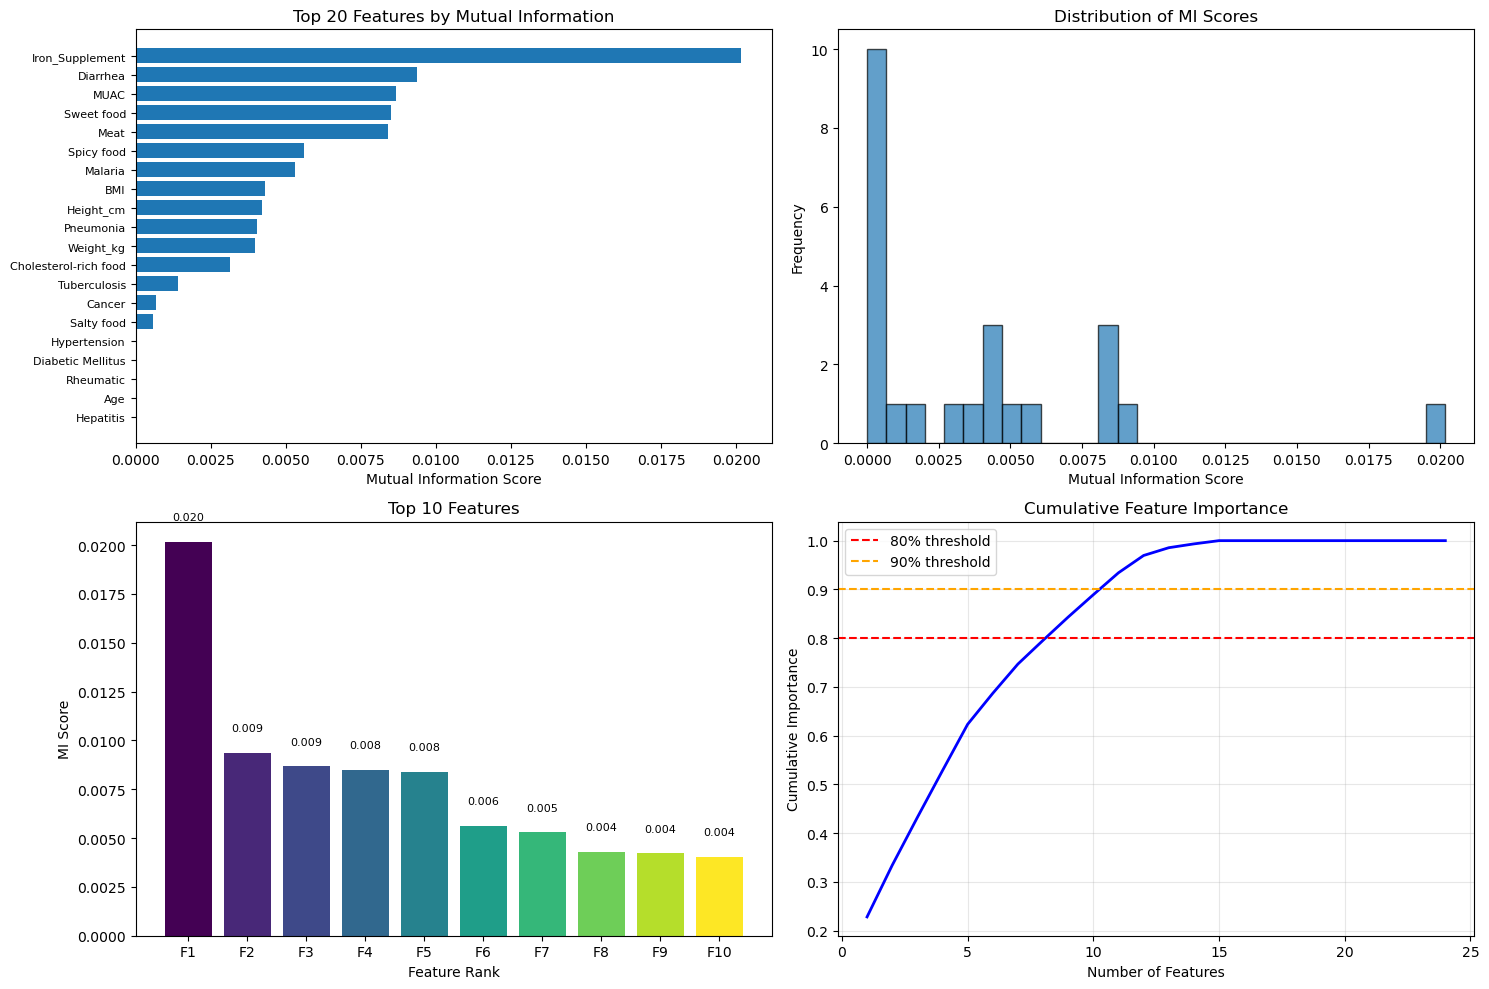


📊 STATISTICAL ANALYSIS
📈 MI Score Statistics:
   Mean: 0.0037
   Median: 0.0023
   Std Dev: 0.0048
   Min: 0.0000
   Max: 0.0202

🎯 Feature Contribution Analysis:
   Top 9 features contribute 80% of total importance
   Top 11 features contribute 90% of total importance

📄 FINAL REPORT SUMMARY
MUTUAL INFORMATION FEATURE SELECTION REPORT (PRINT-ONLY)
Analysis Date: 2025-06-04 22:44:46
Dataset: 12174 rows × 29 columns
Target Variable: Anemia
Features Analyzed: 24

KEY FINDINGS:
- Total features evaluated: 24
- Top 21 features selected for model training
- MI scores range: 0.0000 to 0.0202
- Mean MI score: 0.0037
- 9 features contribute 80% of total importance
- 11 features contribute 90% of total importance

TOP 21 SELECTED FEATURES (by MI Score):
 1. Age                            (MI: 0.0008)
 2. Education                      (MI: 0.0012)
 3. Weight_kg                      (MI: 0.0018)
 4. BMI                            (MI: 0.0027)
 5. MUAC                           (MI: 0.0025)
 6. 

In [3]:
#  Mutual Information Feature Selection for Anemia Dataset (Print-Only Version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🎯 MUTUAL INFORMATION FEATURE SELECTION (PRINT-ONLY VERSION)")
print("="*80)

# Load the dataset
df = pd.read_csv("zero_corrected_anemia_dataset.csv")
print(f"\n📊 Dataset loaded: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")

# Store original dataset
df_original = df.copy()

print("\n" + "="*80)
print("🔍 PREPARING DATA FOR FEATURE SELECTION")
print("="*80)

# Identify target variable (anemia-related columns)
target_candidates = [col for col in df.columns if any(keyword in col.lower() 
                    for keyword in ['anemia', 'severity', 'level', 'class', 'target', 'label'])]

print(f"🎯 Potential target variables found: {target_candidates}")

# If no automatic target found, let user specify or use first column as example
if not target_candidates:
    print("⚠️ No clear target variable found. Using first column as example.")
    print("💡 Please modify 'target_column' variable to specify your target.")
    target_column = df.columns[0]  # Default to first column
else:
    target_column = target_candidates[0]  # Use first found target

print(f"\n🎯 Using target variable: '{target_column}'")

# Prepare feature matrix (X) and target vector (y)
# Exclude non-predictive columns
exclude_keywords = ['name', 'id', 'date', 'time', 'visit']
feature_columns = [col for col in df.columns 
                  if col != target_column and 
                  not any(keyword in col.lower() for keyword in exclude_keywords)]

print(f"\n🔧 Feature columns ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# Prepare data
X = df[feature_columns].copy()
y = df[target_column].copy()

print(f"\n📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target vector shape: {y.shape}")

# Handle missing values
print(f"\n❌ Missing values in features: {X.isnull().sum().sum()}")
print(f"❌ Missing values in target: {y.isnull().sum()}")

# Fill missing values if any
if X.isnull().sum().sum() > 0:
    # Numeric columns - fill with mean
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())
    
    # Categorical columns - fill with mode
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        X[col] = X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown')
    print("✅ Filled missing values in features")

if y.isnull().sum() > 0:
    if y.dtype == 'object':
        y = y.fillna(y.mode()[0] if len(y.mode()) > 0 else 'Unknown')
    else:
        y = y.fillna(y.mean())
    print("✅ Filled missing values in target")

# Convert categorical features to numeric if needed
categorical_features = X.select_dtypes(exclude=[np.number]).columns
label_encoders = {}

if len(categorical_features) > 0:
    print(f"\n🔄 Encoding categorical features: {list(categorical_features)}")
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"   ✅ Encoded {col}: {len(le.classes_)} unique values")

# Encode target if categorical
if y.dtype == 'object':
    print(f"\n🎯 Encoding target variable '{target_column}'")
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y.astype(str))
    print(f"   Target classes: {list(target_encoder.classes_)}")
    print(f"   Target distribution: {pd.Series(y_encoded).value_counts().to_dict()}")
else:
    y_encoded = y.copy()
    target_encoder = None

print("\n" + "="*80)
print("🧮 CALCULATING MUTUAL INFORMATION SCORES")
print("="*80)

# Calculate Mutual Information scores
print("⏳ Computing mutual information scores...")
mi_scores = mutual_info_classif(X, y_encoded, random_state=42)

# Create feature scoring dataframe
feature_scores = pd.DataFrame({
    'Feature': feature_columns,
    'MI_Score': mi_scores,
    'Data_Type': ['Numeric' if col in X.select_dtypes(include=[np.number]).columns 
                  else 'Categorical' for col in feature_columns]
})

# Sort by MI score (descending)
feature_scores = feature_scores.sort_values('MI_Score', ascending=False)
feature_scores['Rank'] = range(1, len(feature_scores) + 1)

print("\n✅ Mutual Information calculation complete!")
print(f"📊 Total features evaluated: {len(feature_scores)}")

# Display top features
print("\n" + "="*80)
print("🏆 TOP 20 FEATURES BY MUTUAL INFORMATION SCORE")
print("="*80)
top_20 = feature_scores.head(20)
print(top_20.to_string(index=False))

print("\n" + "="*80)
print("📊 SELECTKBEST FEATURE SELECTION")
print("="*80)

# Use SelectKBest with different k values
k_values = [10, 15, 21, 25]
selectkbest_results = {}

for k in k_values:
    if k <= len(feature_columns):
        print(f"\n🔍 Selecting top {k} features...")
        
        # SelectKBest with mutual information
        selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
        X_selected_mi = selector_mi.fit_transform(X, y_encoded)
        
        # Get selected feature names
        selected_features_mi = [feature_columns[i] for i in selector_mi.get_support(indices=True)]
        selected_scores_mi = selector_mi.scores_[selector_mi.get_support()]
        
        selectkbest_results[k] = {
            'features': selected_features_mi,
            'scores': selected_scores_mi,
            'selector': selector_mi
        }
        
        print(f"   ✅ Selected {len(selected_features_mi)} features")
        print(f"   📊 Score range: {min(selected_scores_mi):.4f} to {max(selected_scores_mi):.4f}")

# Focus on top 21 features (as mentioned in the research)
k_best = 21 if 21 <= len(feature_columns) else len(feature_columns)
print(f"\n🎯 FINAL SELECTION: TOP {k_best} FEATURES")
print("="*50)

if k_best in selectkbest_results:
    final_features = selectkbest_results[k_best]['features']
    final_scores = selectkbest_results[k_best]['scores']
    
    final_selection = pd.DataFrame({
        'Rank': range(1, len(final_features) + 1),
        'Feature': final_features,
        'MI_Score': final_scores,
        'Normalized_Score': final_scores / max(final_scores)
    })
    
    print(final_selection.to_string(index=False))
else:
    final_features = feature_scores.head(k_best)['Feature'].tolist()
    final_scores = feature_scores.head(k_best)['MI_Score'].tolist()
    
    final_selection = pd.DataFrame({
        'Rank': range(1, len(final_features) + 1),
        'Feature': final_features,
        'MI_Score': final_scores,
        'Normalized_Score': [score / max(final_scores) for score in final_scores]
    })
    
    print(final_selection.to_string(index=False))

print("\n" + "="*80)
print("📈 FEATURE IMPORTANCE VISUALIZATION")
print("="*80)

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Top 20 MI Scores
plt.subplot(2, 2, 1)
top_20_plot = feature_scores.head(20)
plt.barh(range(len(top_20_plot)), top_20_plot['MI_Score'])
plt.yticks(range(len(top_20_plot)), top_20_plot['Feature'], fontsize=8)
plt.xlabel('Mutual Information Score')
plt.title('Top 20 Features by Mutual Information')
plt.gca().invert_yaxis()

# Plot 2: Score distribution
plt.subplot(2, 2, 2)
plt.hist(feature_scores['MI_Score'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Mutual Information Score')
plt.ylabel('Frequency')
plt.title('Distribution of MI Scores')

# Plot 3: Top 10 features detailed
plt.subplot(2, 2, 3)
top_10 = feature_scores.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10)))
bars = plt.bar(range(len(top_10)), top_10['MI_Score'], color=colors)
plt.xticks(range(len(top_10)), [f'F{i+1}' for i in range(len(top_10))])
plt.xlabel('Feature Rank')
plt.ylabel('MI Score')
plt.title('Top 10 Features')

# Add value labels
for i, (bar, score) in enumerate(zip(bars, top_10['MI_Score'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 4: Cumulative importance
plt.subplot(2, 2, 4)
cumulative_scores = np.cumsum(feature_scores['MI_Score']) / np.sum(feature_scores['MI_Score'])
plt.plot(range(1, len(cumulative_scores) + 1), cumulative_scores, 'b-', linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 STATISTICAL ANALYSIS")
print("="*80)

# Statistical summary
print("📈 MI Score Statistics:")
print(f"   Mean: {feature_scores['MI_Score'].mean():.4f}")
print(f"   Median: {feature_scores['MI_Score'].median():.4f}")
print(f"   Std Dev: {feature_scores['MI_Score'].std():.4f}")
print(f"   Min: {feature_scores['MI_Score'].min():.4f}")
print(f"   Max: {feature_scores['MI_Score'].max():.4f}")

# Find how many features contribute to 80% and 90% of total importance
total_importance = feature_scores['MI_Score'].sum()
cumulative_importance = 0
features_80 = 0
features_90 = 0

for i, score in enumerate(feature_scores['MI_Score']):
    cumulative_importance += score
    if cumulative_importance / total_importance >= 0.8 and features_80 == 0:
        features_80 = i + 1
    if cumulative_importance / total_importance >= 0.9 and features_90 == 0:
        features_90 = i + 1
        break

print(f"\n🎯 Feature Contribution Analysis:")
print(f"   Top {features_80} features contribute 80% of total importance")
print(f"   Top {features_90} features contribute 90% of total importance")

print("\n" + "="*80)
print("📄 FINAL REPORT SUMMARY")
print("="*80)

# Create comprehensive report
report_lines = []
report_lines.append("="*80)
report_lines.append("MUTUAL INFORMATION FEATURE SELECTION REPORT (PRINT-ONLY)")
report_lines.append("="*80)
report_lines.append(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"Dataset: {df.shape[0]} rows × {df.shape[1]} columns")
report_lines.append(f"Target Variable: {target_column}")
report_lines.append(f"Features Analyzed: {len(feature_columns)}")
report_lines.append("")

report_lines.append("KEY FINDINGS:")
report_lines.append(f"- Total features evaluated: {len(feature_columns)}")
report_lines.append(f"- Top 21 features selected for model training")
report_lines.append(f"- MI scores range: {feature_scores['MI_Score'].min():.4f} to {feature_scores['MI_Score'].max():.4f}")
report_lines.append(f"- Mean MI score: {feature_scores['MI_Score'].mean():.4f}")
report_lines.append(f"- {features_80} features contribute 80% of total importance")
report_lines.append(f"- {features_90} features contribute 90% of total importance")
report_lines.append("")

report_lines.append("TOP 21 SELECTED FEATURES (by MI Score):")
for i, row in final_selection.iterrows():
    report_lines.append(f"{row['Rank']:2d}. {row['Feature']:30s} (MI: {row['MI_Score']:.4f})")
report_lines.append("")

report_lines.append("RECOMMENDATIONS:")
report_lines.append("1. Use the top 21 features for machine learning model training")
report_lines.append("2. Consider the top 10 features for simpler models")
report_lines.append("3. Features with MI scores < 0.01 may be considered for removal")
report_lines.append("4. Validate feature importance using wrapper methods if needed")

# Print report to console
for line in report_lines:
    print(line)

print("\n" + "="*80)
print("🎉 MUTUAL INFORMATION FEATURE SELECTION COMPLETE!")
print("="*80)
print("🎯 Key Results:")
print(f"   • Selected {len(final_features)} most informative features")
print(f"   • MI scores range from {feature_scores['MI_Score'].min():.4f} to {feature_scores['MI_Score'].max():.4f}")
print(f"   • Top feature: {feature_scores.iloc[0]['Feature']} (MI: {feature_scores.iloc[0]['MI_Score']:.4f})")
print("   • Ready for machine learning model training!")
print("\n💡 Use the printed feature list above for your ML models")

🔍 ANALYZING FEATURES CORRELATED WITH TARGET: 'Anemia'


TypeError: Could not convert ['Mary GonzalezLaura CastroChristy BarnettJodi ComptonJane HannaErica BeltranAmy ThorntonKim RodriguezGina WestMichelle WilsonMonica HansenRebecca BrooksJennifer MccallVictoria JacksonCynthia GarciaMadison CalhounTina FreemanSandra PrinceLisa HenryMary HallNichole MartinAshley LiAmanda HernandezElizabeth MartinezCourtney RobbinsTina BaileyLori BrownAmber WhiteJennifer HicksTammy PetersJulie HolmesLauren GonzalezCynthia FullerErica JohnsonJenna SimmonsAmy ReedTheresa JonesBrianna LaraMichelle SingletonSamantha HansenAmy ReyesLindsay LarsonRachael MooreAlyssa RomanJacqueline MartinKristen HoltDebra KelleyKayla HarrisonFelicia HancockMadison PriceJordan PowellWendy YoungSally FischerCarly NavarroKrista GouldRuth LawrenceLori OsbornMarissa RobertsonElizabeth AndersonTracy MooreDeborah WellsErin HuffSonya BlackDawn TaylorCarmen JonesAnn RobertsAngel RamirezBrandy CrawfordErika ShortAmber StewartCaroline DuncanSamantha HicksJacqueline PageJill MaddenDana WilliamsNatalie TaylorRebecca NicholsDana TuckerElizabeth PerryLisa OwensStephanie MannSusan EllisAlexa PollardSheryl PriceJessica HenrySandra BuchananNatasha WagnerConnie PowellBeth CollinsKristy GallegosChristina GreeneLeslie PatelJillian LittleJamie ClarkRita WileyMegan WalkerDawn WatsonLeslie BrownKristen WarnerJoy JonesAbigail BridgesChristine WilkersonKelsey FrederickJennifer TranKaren JohnsonSandra KimCindy NguyenHeather HumphreyLindsey JonesMelissa PowellElizabeth PopeAndrea MortonWendy GrahamMelissa HayesHannah BrownRachel WangAlexis BakerCatherine TerryLaura WarnerCathy RamirezCynthia ObrienAshley TorresJessica CastroDorothy MoraJennifer PrestonDenise ChangHeather EnglishShelley RamirezSusan BensonKatherine DickersonKathryn LeeEmily LopezLatoya WrightCarolyn ValdezNatasha SchultzJulie GriffithAlicia GreeneTracy BrandtCathy LangKaren NolanElizabeth SimonKatie SmithMarie HortonLaura BurgessCassandra JacksonCarrie StricklandKimberly EwingSharon RobinsonVeronica ContrerasKristie ShawTheresa SanchezVictoria NelsonLori DurhamShelley DunnSavannah JosephLori StoutBarbara SchmidtLaura YorkPamela ChavezKaitlyn MorganLisa AguilarMelissa BrownJessica PriceTammy BrownJulie CarsonLaura AdamsKristina MoralesKimberly LeonardLori FreemanJulie SandovalShannon CarrHeather PerryMarcia PhelpsLisa WrightJulie PattersonJanet OliverKim ScottJody HernandezLisa GarciaHeather CurtisJanet FernandezNancy HarrisDebbie GoodmanWendy ValentineTiffany OlsonJessica WellsPeggy JensenAmber HensonCandice MarshTammy SmithAnn LeonCassandra DiazAlyssa SharpBrooke DavisHeather ThompsonJennifer BryantMaria SpenceAbigail ThompsonKimberly KaiserMichele ColemanKayla DuncanDonna SinghLaura PayneJulie LittleChristine DunnLaura DouglasTricia WebbSamantha GreenLori HernandezKayla MillsGabriela HuntJacqueline GrossAlexis CastroLauren YoungLinda PerezBrittany HardinAlexandra BishopKaren KennedySheena SullivanTina FlemingAriana JohnsonSusan ParksStacy MckinneyJanet WestKari NovakKelly DaltonPenny LongHeidi TaylorKelly WatkinsKelly HamiltonMary WrightPamela ColeCynthia HardyTammy FordSamantha JonesShannon HarperLaura VasquezLaura WeaverDeborah GoodmanFelicia HolmesKristina WelchHeather MaldonadoJennifer SilvaDenise VelasquezSusan GomezHannah CabreraSandra BrownMelissa FlemingKristine LaneKaren BanksAngel GarnerAshley BellLeslie LambPatricia JonesAmy TaylorJulie CarlsonMichelle HuffAndrea HillCristina AndradeHolly AdamsSara MartinezJoy EdwardsLori HamiltonStephanie WilsonChristine MorganCynthia LeachEvelyn SandersHeather AdkinsLaura WagnerWendy AyersHeidi WelchMichelle ContrerasJessica JonesDeborah DominguezDiane GreenJacqueline GonzalezNatalie BoltonDebra ArmstrongShelly BlackNancy LynchMarie FrederickSarah PalmerLisa ChangSavannah HansenAndrea MillerAmanda HancockJeanne SalazarMary TuckerKaren NealDanielle ShieldsKristen FarmerBarbara FosterMelissa MillerDenise KingKristina MorrisJessica MurrayJulie TravisTara BradleyTabitha JohnsonStephanie FergusonChristina BrownAnnette BryantKathryn WestPaula CunninghamAnne LewisErica DodsonMelissa AndersonAmber WrightShelly HaneyCynthia ThomasDonna PhamAbigail SmithAshley WilliamsonLindsay WillisKimberly MorrisAmy LaneAmy TaylorAshley BrewerElaine BryantBrittany AdamsAmanda LewisTina PadillaTracy HansonDiana AllenApril PowellNicole MartinezEvelyn ReedRegina MejiaAshley GarciaTina JohnsonAnita ChanLaurie SmithKathleen PhillipsKristen WalkerDenise ChoiKatie GravesAshley HoodLauren StewartTeresa HurstJulie ClarkSusan LynnLeslie FryBrenda MorganLisa KnappJennifer ConradNatalie HallBarbara KramerSamantha VargasVictoria WaltersJacqueline ThompsonJulie WilkinsAmanda LaneJodi WattsVickie SerranoStephanie GeorgeJanet SalazarKathy WeaverMargaret BakerJessica PerezChristina JacksonAmanda OrtizAngel BowersJessica WintersLisa ThomasMaria FernandezJill ScottCatherine MillerPatty RobersonSamantha CoxHeather JonesKristen RichardsKatrina ReeseErica GrimesLori ClineSandra MartinezKaitlyn StephensBrooke MarquezJessica HendersonAudrey MccoyShelley HallDestiny WilliamsAllison BuchananAshley GarciaAdrienne ColemanJodi WoodsSheryl WardLisa JacksonAudrey BrennanCaroline SteinMelinda OrtizJessica BallardStephanie LaneEmily EdwardsAndrea JonesMegan MartinezCheryl CampbellDebbie ThompsonLisa SmithGina CampbellJasmine AdamsJasmine RoweFelicia VegaLaura CortezTonya HouseMary FletcherChristina MarksKathleen ScottTiffany WilsonJessica JonesCrystal ElliottJeanne UnderwoodStephanie NelsonToni DayLindsey CervantesJennifer OchoaBrittany SmithSamantha AnthonyChristine DavisTracy HicksRobin VelazquezMichelle JacksonMelissa RobinsonAngela VargasTiffany EvansSusan RamirezSarah MossSharon LangJulia MartinezTina StephensonErin ProctorSarah KelleyMelissa CrosbyKari JohnsonJessica SmithLaura HannaRobin BrownRachel McdonaldCatherine HarrisonAmanda HessLori SmithMakayla StanleyMiranda FloresAutumn JacobsonShannon MaciasDawn WilliamsonMolly HessGina BoydEmily WilliamsSharon WhiteStephanie KellyLaura OchoaSara CaldwellHolly FloydAmber MayerVickie JimenezDebbie MurrayNicole RushSara FigueroaAlicia SantiagoChristine PadillaAlicia GoodmanAshley WalkerKathryn GreenRachel RobertsRebecca CruzAllison ShepherdRhonda DodsonDiane SweeneyJennifer ObrienCarrie AndersonMelissa GilmoreCatherine CannonKarla RiceCaitlin CurtisLaura WeissLaurie McdonaldMichaela PayneChristine WalkerSylvia BrowningJessica ProctorJennifer SanchezSarah OwenJulie GomezCarol LopezHolly BuchananVirginia JonesWendy BellLeslie LongTamara WoodJennifer ThompsonEmily GainesTina WoodsMichele SantanaTerri PerezPaula MooneyCindy CainChristina HerreraCassie EdwardsJessica LunaLaura HolmesJordan HartmanMelissa TurnerMary RobertsLauren WallaceMolly DouglasAmanda WagnerSarah CruzKristina SanchezTaylor CarterKimberly GordonMelissa StephensRobin TaylorPatricia BarajasStephanie RomanBrenda WilliamsDenise YoungDawn BrownMargaret KrauseLinda EllisonSusan BeckerJennifer CarrollAllison HamiltonFaith MaysRobin MortonMelissa WilliamsCarolyn WilliamsErica MclaughlinKayla BushBethany NelsonCynthia DanielsElizabeth ClarkJulie JacksonSonya ButlerEmily NielsenMonique LongJamie SullivanTeresa WestAngela MuellerAmy AyalaNicole MckinneyKelly MccoyTeresa ReillyJessica LongCatherine RuizLisa BlairCindy DavisKim CoxChristina WhiteJessica BrownKathryn RamirezAmber SmithTiffany VanceBrenda TaylorEmily MunozCatherine GrayCrystal ThomasKristen RodriguezDeborah KingCatherine OconnorEmma WatsonSharon TranBrittany KellyPhyllis HillLisa ElliottBeverly FloresAmber FloresDana StricklandMonica RiceDanielle GoldenKayla ClarkMelissa WallaceHolly BradleyDominique EvansKathy SingletonCourtney McmahonElaine BeckerRobin PrattSonya SilvaDebra CaseySabrina ClarkJennifer ValdezBarbara MartinezKathryn EnglishLinda HobbsWendy MorrisMindy MartinKarla HallStacey BondHannah MeadowsBrianna McgrathDonna DelgadoKimberly SilvaMary MitchellEmily PetersonDiana WoodKaren GarrisonRebecca HudsonSydney LaraCasey HicksLaurie WelchElizabeth ThompsonSonya BellDominique ContrerasStephanie DavisCaroline SmithPamela WaltersAnna HardinJulia KellySamantha EvansAlyssa SharpBrianna ManningDenise MartinezAnna SmithSavannah SchultzJessica LongGrace PerezBrenda FloresVictoria StevensonSharon GoodwinLindsey CarlsonTracy WalkerRaven ByrdMary LoweGina EvansAndrea HamiltonMegan WrightPatricia WhiteTina BrownKathleen GonzalezCatherine FrenchMary StanleyKaren MullinsBrenda DixonIsabella DavidsonTonya SmithKayla NewmanDarlene PerezAlexandria WilsonVeronica NewmanSusan SchultzSara ReyesShannon PattersonAlexandra WellsVanessa MccallKelly LongKimberly RiceAudrey GravesTara HowellCynthia JohnsonAlexis ParkAshley ChandlerMorgan FordEmily AdamsMaria MorrisCheryl SmithMargaret HubbardJanet ChurchJacqueline FloresSavannah CookBrittany BoothRachel PadillaErin CervantesRebecca BenderAngela KimKatie WalkerAmy PrattLinda ChambersTeresa NicholsKylie DavisJulie DoyleDanielle SalazarMercedes MarshallAngela HubbardSheri GutierrezCheyenne FischerEvelyn ThompsonStacy CombsJennifer WalkerAnita GarciaVictoria CameronAnna RamirezKelly BruceKristie WilliamsJordan SnyderJudy HarrisonCarolyn ReyesAmber ClarkKim JonesAutumn OrozcoRhonda TaylorKatrina HartmanMichele HardyTracy McdowellMercedes BarnesNicole NorrisMisty RhodesOlivia JenkinsCheryl HallJessica PowellPamela KingKelly DoyleTara GravesChristine NewtonDawn MartinShannon WilliamsAmber WilsonKaren RichardsonLinda FernandezKristina DavidsonSara JohnsonJeanette RoachErika JohnsonChristina PriceJudy BennettMegan RodriguezVanessa WatsonMorgan DavisJennifer GallowayJamie LevineJulia FlemingTheresa MunozJennifer LesterLori DavisJessica RamirezShannon PonceCrystal JohnsonRebecca LittleCourtney LinYolanda AyersTeresa RamosKatherine BullockBeth FloresLisa SmithLoretta JohnsonAlisha McintoshErica ChanLisa SnyderAmanda PriceMelissa HillTaylor BoydSarah RomeroKristine FloresJessica DavisPatricia GordonSara SteinLinda WaltersMargaret YoungElizabeth SmithKimberly ConnerNancy BridgesShelly TaylorMichele LeeTanya DyerNatalie HowardKaren NunezLacey WrightEmily ChapmanSarah WeaverCassidy MorrisonJulia SuttonStacy GordonMichelle HooperPaige MooreEmily NixonValerie SmithWendy MccannValerie ProctorAudrey BrownMeghan MullenCourtney CarrollKathryn OwensKrystal FloresCarolyn FaulknerCatherine RomanAnna BrownKathy MccannKathleen NewmanMariah McdonaldStephanie JonesBrittany PattersonSamantha ChenTiffany KochCrystal DanielLydia ClarkNicole ValenciaRhonda HuffmanNicole AndersonJulia WrightNicole HuntJennifer MitchellDenise BuchananKrystal NicholsMaria PattersonHeather LeeKimberly CruzTammy KingKimberly JonesTonya HamptonBrenda ZimmermanKimberly VaughnStephanie CollinsBrandi RamirezCheryl JacksonTammy WheelerEileen HamptonBrenda EvansDebra PhelpsLaura MerrittKrista WheelerLinda ValdezKellie YoungAlicia ClarkJoan MccoyBrenda DavisAshley ParkerJennifer RobinsonRuth EatonMary EllisAngela HansenJocelyn WilliamsKatrina SimsRegina GardnerMelissa ArnoldRenee ColonSusan MercadoDonna RiceJamie CampbellJennifer CantuKatherine SullivanLaura MccartyBrittany McguireYolanda AndersonFelicia EdwardsKatherine HarrisBrittany JohnsonMaria MartinSandra CastroCasey LarsenSamantha MichaelKristin PerezMarissa BuckleyPhyllis HolmesTara BrownKendra HorneSarah JacksonCandice JohnsonMichaela HaleHeather WongShannon LynnLindsey PrattRegina BarrettMichelle BurchMelissa StoneAlexandria TorresRoberta RobertsCathy StewartKelly JohnsonLauren WhiteNatalie DavisPaula ThomasEmily GrahamAmanda MooreJulia MiddletonConnie CummingsDenise HahnShelby EvansMary LyonsSharon RodriguezMonica PalmerJoyce BishopNancy AyalaKristi MedinaShelly HendersonTiffany BowmanNancy SteinRobin TaylorMelissa NguyenEmily RogersJody HernandezTiffany GonzalezRita KochSarah PottsJennifer JordanSamantha HowardSarah EdwardsSarah EdwardsMichelle BakerWendy WoodKatherine NolanJamie OliverJessica MillsTiffany RodriguezJennifer HillLeslie CrawfordTamara GardnerPamela GravesBeth DanielsSara McguireMelissa CooperMelanie ParkerJulie BakerValerie YoungAmanda FosterEmily MontoyaAngel BurtonAmanda KimMelissa CallahanCarrie OliverMeredith AllenJulie FrancisRebekah SmithBailey TaylorDiana CarterCatherine CarrollNicole JohnsonNicole CollinsMary CookTerry WeaverAshley LewisSusan CarrMary FoxBrittany JamesMegan MartinBrittany ClarkRachel NorrisDawn AndersonNancy HayesMichelle TaylorJulia FlemingKathleen ThompsonRuth WhiteheadKathleen DaughertyMegan GonzalezTammy McmahonRebecca TaylorAlyssa WilliamsRachel MartinezHeather BennettLaurie DeleonHeather WashingtonKristen SmithMichele BurgessSara RoblesAmanda ZhangKelly ShawNatasha GallagherKelly AllenKelly WilliamsMallory ClarkJennifer SandersElizabeth ValenciaMonica FergusonSusan MurilloSandra HillTamara ShawRachel MaloneDeanna ChambersSamantha WilliamsAmy MorrisKaren MasonAshley BrownAmy CarrollMiranda ChristensenSarah ChapmanRebecca BurgessAlicia JohnsonAshley RodriguezMichelle ObrienKristin GonzalezTaylor PerryLoretta CraneCynthia DiazAllison WilsonDiana CarsonMary CurryLindsey GilbertAshley MoranAndrea RossJulie ChambersLaurie MitchellCarol GarciaMary WilsonSandra WuMichelle GreenMichelle FrazierGloria CruzChristina DoyleWendy MooreKathryn MartinBrittany LesterDestiny ThomasMary AguirreMargaret DillonDawn YoderHeather GordonSheila HernandezElizabeth GordonCarol BensonLisa StanleyDanielle KingKaitlin BryantAshley ColonJamie HillKimberly JonesStacy ShawDebbie ShermanTonya MclaughlinKatherine MuellerJessica MurphyRhonda GambleAmy JacksonAmber AndrewsBrandi BrooksAlyssa CuevasMichelle MurphyJane WilsonKelly FrancoTracy ZimmermanRebecca GrahamMeghan CooperTammy MackLisa WoodMeredith MartinJulia CalhounErica ReynoldsRegina McfarlandBecky GarciaTracey EnglishSarah EstradaDeanna BennettBrooke SmithCrystal WeaverCatherine DonaldsonMegan VelasquezRobin WillisMelissa HernandezChristina SmithElizabeth HuntLisa FreemanDebra DavisSarah GravesGloria SantosAnna VelazquezElizabeth CarrollJulie HarrisTracy TylerAshley SolomonKatherine WilkinsonNatalie JohnsonAngela ReyesMegan SimonKristina CarrollKelli GreeneCrystal YoungMelanie GarrettAndrea BerryVanessa WhiteheadJessica TorresDeborah LawrenceLisa WardTina PetersonJessica HicksErika PatelKayla GomezCassandra HowellCindy DavisYolanda BatesJasmine BarnesElizabeth MezaWanda WolfeGabriella BatesTara GibsonShelia HarrisKatherine FosterDeborah ReyesCarolyn AdkinsPamela ClarkYesenia MeyersTara BenderRachel MorrisBethany WilliamsKayla LyonsBecky TurnerBrittney RamirezAshley FreemanMaria CunninghamTammy CastroPam LopezLaura PittmanSherri HolmesChristina WestCarrie BurnsAllison MilesKristin SimonWendy PotterLinda RussellJacqueline GibbsNatalie SandersSherry ColeKristin RobertsJoy PierceJennifer SavageMaria MooreDebbie PopeCatherine BarnesDawn EstesElizabeth AdamsMonica RoseVictoria DixonChelsea PrestonKathy WallsTiffany YoungCindy WolfeMaria ShawEmily GonzalezMichelle KellerMichelle ClarkJulie HobbsRenee WeeksCheyenne RobertsShelly LopezErika RodgersAshley AvilaKristina SandersMelissa RichardsonDanielle PhillipsNicole SmithRachel GibsonKara GuerraTabitha WeeksSheila DanielsCarolyn SummersSandra SmithTabitha OliverMaria GonzalezMiranda GregoryRebecca BrownMelissa CochranErin JohnsonJaime CarrAngela WhiteElizabeth GonzalezEvelyn LewisMeghan GreenHannah OconnellKimberly CooperSarah BowersShannon EspinozaLaura ChavezJenna MathisCourtney KirbyDenise CrawfordNicole CollinsJennifer MasonStephanie DiazShannon RuizLisa MurrayTheresa MatthewsMegan AguilarJennifer FloresShelly HuffJennifer ButlerElizabeth WhiteBarbara LawrenceAngela DennisMary BenjaminKimberly ClarkKatie JohnsonAndrea CordovaShelby JohnsonMichelle MorrisonChristina BrownChristine BrownBrenda WoodAlexandra ShafferHeather RobersonEmily ShawJennifer BergMisty RobinsonTiffany MooreLisa NielsenChristine SantiagoMary MorganNicole RosarioApril MoralesSarah HudsonKristine HernandezJennifer SchneiderJulie CareyTiffany MitchellLaura RamirezApril BauerMichele RileyAmanda GonzalezKristi MurphyLinda HarperJulie ThomasRegina WhiteJennifer CooperFrances ChapmanSherry MooreJenny LeonardJennifer HollandTeresa CarpenterMichelle BrooksJacqueline StokesValerie HolmesLisa BeckCynthia EdwardsMadison SmithCynthia HicksSydney MooreBarbara HodgeSarah AguilarVeronica RangelCarrie YoungLisa MillerSarah SanchezKathy StevensJeanne MillerCindy RobinsonRebecca ClarkMary SandersRebecca GilmoreDanielle SwansonAnne MorganRegina BeckPaula WallsKaren NewmanErin MosleyMaureen WatsonBrittany RuizLauren BrownAlison NormanAlexandra CherryDawn MunozCasey WilliamsLinda JonesKristen DominguezMaureen PattersonMelissa LewisDiana KelleyJanet OliverJulie BryantCindy ThompsonAnna RussellVictoria DiazStephanie JenkinsSara McdowellRachel ConnerTamara JoyceSuzanne McclainMelissa AlexanderSydney JohnsonAnna PattersonMichele BeanLori BlackKathryn HaasSandra AndersonValerie PerezJessica MillsMonique LutzMackenzie BrewerAshley SmithErin YoungShawna SmithElizabeth MonroeCarmen HunterLaurie PenaAdrienne MarshallDawn CamachoAlexandra McconnellKimberly DavisDawn JonesAngela NorrisCrystal RodriguezPaige VaughnTammy BeckerTheresa HarrisonLori HullHeather ReedSusan ThomasKathleen JonesAmanda JohnsonMelinda BuckDeborah CollinsBriana WilliamsBeverly SmithBethany WoodardTheresa OchoaJeanne GallowayCarolyn LopezLisa StoneHaley AndersonDebra MyersAmy HaleJane MendozaCaroline WongAlexis StricklandNatasha FisherTracy BlackAmanda BallLaura SmithMargaret WellsCathy PadillaSamantha HuynhDeborah FosterShirley WeberMichelle JohnsonTammy OrrDebra ChandlerErica SimpsonHeather PriceVirginia HendersonMadison WhiteLaura ShannonKathleen RobertsHolly MillerStephanie HendrixMelody LoveElizabeth ClarkLeslie WhiteStephanie NewtonSara PageLaura KimKelly MillerMonica RamosVeronica DoughertyTiffany CooleyMallory LeeSheri KeithNicole JohnsonJennifer HernandezValerie ColeKristina BeanJennifer TurnerMelissa BishopLynn BrownKaitlyn HobbsBrittany CarterElizabeth ThomasElizabeth SmithRenee LawsonPenny MasonMelissa WilsonChristie ParkerTeresa WilsonAshley CarrCarol MontgomeryCrystal ParksDominique OdonnellOlivia HowardTina WilsonAmber BrowningShelley CraneNicole ButlerTracy MillerCatherine HunterKimberly RileyJacqueline DavidJennifer NixonKathleen SmithKatherine DavisHannah BryantAshley RobbinsShelly WebsterKaitlyn LopezMelissa CruzAnne RuizJulie PerkinsSusan OrozcoKrista MartinezMeredith TuckerLori RichAmber RoyAndrea FritzJane GarrettRobin WarrenDenise MackAshley JohnsonChristina NorrisDesiree NielsenAmanda RiveraAmanda GainesKaren HarveyTina ReedTara MartinezKayla TuckerMary KleinAshley ChaneyKristina LewisCynthia ThompsonNorma MoyerElizabeth AndersonAlexis HawkinsRebecca OrtegaJulie RichardsonTerri DavisLauren KingNicole DurhamKelly MatthewsElizabeth AbbottSara PorterAbigail FrazierShannon StoneMary CruzRhonda GarciaKelli RiveraElizabeth NguyenAdrienne GuerreroJacqueline SanchezJeanette SerranoKelsey GutierrezTracy TurnerPamela GarciaJennifer RiceLorraine BrownDebbie DavisStacey JamesWendy LewisYolanda WuSarah JonesNicole MartinezKaren MortonJillian WilliamsJessica JonesPatricia MurrayAriel HowardDiana PerezKaren BeckKathy BurkeAmanda SmithKristine JamesLeslie GallowayLinda SmithElizabeth SchroederKatie EvansStephanie RossPatricia BradyMelissa GomezElizabeth CollinsAnna ReillyDenise MillerNicole WalshJamie WalkerSally DanielsErin BoyerDenise DanielsLaura MckeeMary HoErin GreenHeidi KirkShannon MartinezNicole JonesAshley GonzalezBetty PriceVanessa HaleyKara OwensAmanda TannerBarbara JuarezPatricia HoffmanMary HubbardTaylor BoothCarrie GarnerSelena KellerRachel VargasJodi RosarioCynthia WilliamsMarie KellyStephanie OsbornStacey LambertYvonne CastroLisa MorrisStacey PerezDonna CochranKristina KellySandra MillsAmanda OliverKimberly RothAmanda WeeksAshley JenningsKelly BondAshley JensenLisa HillLisa WalshKimberly HarrisCourtney FosterJennifer PetersonAshley GreeneGabrielle GreeneLaura WrightJennifer RobinsonStephanie BlakeHannah FischerCatherine CoxAmy DunnKristin KingAmanda KellyCharlene DixonLauren GarciaSusan MartinWendy ThorntonKristina TuckerRebecca BrownSherry CollinsMadison PowellMelanie WardNicole PetersSharon NelsonDawn MullenSamantha TaylorRachel CampbellLauren BrooksSarah PerezErica GrayAndrea CannonJanice ConnerVeronica CastroDeanna BarrBeth MartinezRaven MathisMolly JacksonTonya FrancisTonya SullivanChristina DavilaTamara WiseLinda BurtonJessica WrightGabrielle RobertsJennifer EvansDenise DavisVictoria MorganMarie AlexanderBetty HuangCourtney LongCarol HallRebecca BrightGrace StewartChelsea GoodmanBeverly MartinBreanna McguireSheena KhanPamela TaylorRebecca HernandezAshley JenkinsAmanda JordanMaria CollierMakayla MartinKatherine ShafferJessica LongDesiree LawsonAmber EvansKristy MedinaRhonda DiazJennifer KennedyMelinda BatesJessica LawrenceSarah PierceChristine TaylorAmanda RodriguezAimee EspinozaKristen KleinAmanda BurgessJillian WilliamsJessica BradleyAmanda ZamoraYvette FlemingAmanda FosterNicole GrahamJennifer WalterAnna BrownCaitlin ReynoldsMary WrightMary DiazPeggy ColemanJill ThomasSarah BautistaMiranda LunaAnne RodriguezKiara RubioMichelle SilvaLaura HorneMorgan GrayMelissa MarquezJill PopeMadison HooverMorgan YoungAmanda CamachoTina MannLisa SanchezKim MoonCaitlin PatelNina CaldwellPatricia DawsonCheyenne BarnettBarbara BlakeMelissa LeeKristina WilsonEmily RiveraKelly CarlsonChristy WhiteRebecca BrownDebra WilsonMelissa YatesElizabeth GuerreroAshley SchultzTracy JohnsonCrystal CalderonBarbara PadillaLynn BatesMolly WilliamsonAlexis RichardsonLaura JohnsonJillian ButlerChristy McbridePatricia PerryAshley WarrenTracey NguyenJill HernandezCarolyn BurkeAmber MiddletonAmber FordJoan FieldsDawn MartinMary MartinMckenzie BakerHeather ZimmermanKimberly MillerKimberly PowellNatasha HudsonSuzanne ConleySarah KeyKristy BookerJill HesterMallory HansonKelly CarterLauren PowersTaylor ClarkCaitlin CummingsSamantha CaldwellKristen OsbornAnna ClarkAmanda EvansJulie RodriguezRebecca OliverDebra BarrLori BrownSamantha HurstMelissa MejiaChristine JonesAudrey MoyerDonna JonesCheryl NelsonLindsey FoxAmber WrightSarah SingletonPamela SandersTara RomanAlicia SimmonsJenna AguilarKelly HughesSarah OlsonBrooke AndersonJennifer PadillaAmber ShermanJessica BarreraStephanie ChavezJacqueline HarrisonSherri YoungPatricia FloresRita ReynoldsMaria MillerStephanie GallegosDawn SextonCheryl MerrittDorothy VelezElizabeth ZhangSusan ZavalaSherry WigginsCynthia KellyCassie MillerBecky FriedmanMary HaleChelsea BakerKristen WhiteKristen GreeneDeborah HillAmy BishopJennifer NelsonJulie ThompsonJessica GarciaKim BennettEmily ThompsonAshley AndrewsJessica ClaytonSandra BowmanWendy SchmidtJessica MclaughlinDanielle LewisCheryl WilsonMiranda CohenBrooke HensleyKaren HickmanJessica SmithLauren JohnsonHeather CobbElizabeth AnthonyMegan ParkerAmy CraigSusan MerrittErin WhiteKarina BlackPatricia RamirezMelinda HarrisKimberly AdamsRebekah MorrisEmily EllisStephanie IngramMariah FloydEmily LopezMichelle MarshallTammy PowellJudy JohnsonDana WilsonStacy McdonaldDana JonesDenise EdwardsCarol MillerLaura ThomasRebecca SmithKaren CalhounJennifer SerranoJamie GuerreroJanet MclaughlinPenny CabreraKaren SuarezDiana BoothTina AllenMichelle BurnsTracy HoLaura ValentineMeredith AdamsAshley CantrellSamantha WongLindsey ThompsonApril FlowersErika BurchJessica WrightHolly CrawfordDiana WeberJamie AndersonHayley BerryAmy GoldenMelissa ThomasErin NelsonTina GeorgeJennifer SmithCynthia RyanEmma McguireMariah SimpsonWendy MendezMary HaleCaitlin AustinMaria HessSheila PerkinsLori OliverYvette ClarkTeresa WilliamsDebra ReeseDawn JacksonKathy CruzValerie SalazarCatherine GreenJessica CollinsRhonda GilbertYvette KnightDanielle BakerDiana JacksonAshlee LittleAshley WilsonSarah AlexanderSamantha WhitneyRachel MasseyAlisha ArnoldAshley JonesKelly LopezMaria JohnsonAngela LopezDeborah PetersonSuzanne WintersAmber WhiteTaylor HughesTheresa CannonSusan CollinsChristine HodgesJodi LawsonMary JamesAnnette WagnerHannah McintoshMelissa MarshJasmine SchroederKaren MontgomerySheri BurkeAmanda MartinJennifer RodriguezMichelle GrantKristen FranklinLisa SmithJamie HarrisTiffany RussellMichelle BallCatherine LewisShannon HickmanAbigail EscobarCheryl KelleyAmy BryantAlexandra StevensJaime CamposSarah HowardKimberly FreemanHannah RiveraKathryn WheelerJeanne MartinMichelle RaymondGina MillerEllen MitchellMary RobertsKaren CarrilloMeredith SchneiderJennifer LeLinda GrahamNicole MeyersLauren GarciaChelsea RamseyBarbara BoothJill ClarkAmy PhillipsDana MartinKatherine StokesLisa WilliamsHeather TownsendDesiree RichardsonKayla NunezChristina WilliamsMelissa MartinBrooke RobinsonVicki HarveyKaren LeonardMorgan CastroMary JonesMegan RussellDonna NicholsonAngela HenryAlison RodriguezAmanda YoungElizabeth TuckerJennifer HutchinsonJessica EllisNicole GonzalezAmy MurrayJanet LeonardBetty MullenSheila KaufmanJennifer ManningCharlene CookeRenee CastroKathryn CaldwellJessica KimHannah MendozaMegan HendersonConnie McdowellJoann ConnerAmanda RuizBarbara OliverMeghan WallaceDeborah ShepherdSharon FreemanJamie SmithJody NguyenHeather KaneChristina BanksShelley WalkerAnne TuckerDominique MillerDiana MooreJennifer BakerMadison GarciaCourtney ThomasKendra WarrenCatherine FrostRuth AguilarAmanda SmithAlicia GarciaShelley WiseJacqueline MartinJulie WilsonYolanda GrayJennifer CopelandKayla AllenRhonda MorenoBeth RileyTina SmithKristin WhiteBrittany WeaverCatherine JacobsHeather GonzalesDanielle StoneKylie TranAmber PhamVickie HowardKatherine BergSusan JonesAngela SpearsHannah SheltonLeslie JohnsonAmber MillerAngela LeeMary HerreraJulia TorresPatricia MuellerVanessa WilsonRhonda KerrAnna YoungSusan JohnsonKayla RubioDenise WilkersonPatricia McgeeNatalie ParksTanya ChoiCrystal GarciaAndrea WilsonLisa NelsonTammy SmithAmanda StevensKatherine SimpsonMartha WalshRachel MartinAshley FisherAmy RiosLaura WoodsAnn BrooksElizabeth BrownBrittany AlvarezAndrea LeeElizabeth JonesVeronica HicksAllison SmithRachel GreenKristen WrightHannah BlackEmily JonesPaige SheltonAngela LongJasmine CruzAmber LevineSherry BryantEmily AdkinsKristin PittmanAnn GlassMelanie HarrisSandra RobinsonHannah MartinezNatalie CastilloSamantha WhiteheadYvonne BowersLisa KimDenise EllisLaura BrownBrooke PatelLauren LawsonJody DiazAngelica CruzLaura DavisSusan BrownGina MartinSarah BurkeLaura WilliamsJoanna RamirezMelissa LaraCatherine WhiteSusan KingJessica OrtegaChristina PeckMadeline RogersAmanda GutierrezJane SimmonsRobin RivasHeather DavilaEmily BeanSusan RodriguezAshley PetersonStephanie DavisCrystal MooreDonna BurnsNancy ReidKatherine WilliamsAnna PriceSummer KellerJennifer JensenValerie ArroyoLaura BuchananAngelica WangSharon MillerJenny NguyenChristy WatkinsMadison BarkerElizabeth YoungMelissa ClarkLisa NewmanTracy WhiteCathy SullivanBridget NelsonJacqueline HatfieldAngela OsborneRachel ReynoldsStephanie RobersonDanielle AlvarezRhonda HillMarissa PierceNichole KlineRachel HatfieldJennifer WilliamsMary HenryJennifer BishopNatalie MorganMartha TrevinoLisa WillisDonna WilliamsLauren BlackLauren VasquezOlivia DickersonKelly PatrickAmy ScottBrittany JohnsonKelsey BoydCynthia EricksonErin RoblesKerri MurphyAmy WhiteTiffany McclainElizabeth McmahonAmanda CooperChristina BuckleyTheresa HeathDonna OrtizMichelle LopezTina CookKelli PetersenStacey FrazierBrandy RiceJanet MurphyKaren RichardsWendy SpencerBrittany PriceKelsey BurkeVeronica ScottGabrielle MortonElizabeth FloresAmy OsborneLaurie BerryHeather BallardSarah FernandezNina RichardsonAngel LittleConnie DavisAnn WrightMegan BrooksRenee JohnsonShannon DavisKatherine ParksCarolyn WoodsStephanie BryantPamela MillerVicki HicksHeather HensonCatherine HayesKayla ClarkAmber RamirezApril ShepardApril BrockMary LewisPatricia OwensRebecca SandersAndrea SandersMelissa PattonMichelle BryanMelissa MclaughlinJacqueline BennettPatty FrenchElizabeth ReedKirsten JohnsonJennifer FlemingJessica WilsonAmanda NealColleen BrownMichelle ClarkJacqueline JonesLinda LeeMelissa AndersonDiane HoffmanApril FloresKimberly SmithBrooke HamiltonVanessa McclainChelsea McgeeRachel KochDiane SalazarPaula JeffersonMelissa AnthonyAngela GibsonJennifer HarveyCourtney WardSally MccoySarah HughesAshley HuertaCatherine BurtonBrianna TownsendHeather RochaAnita SandersRebecca BoydJennifer ChaneyMelinda MathisVictoria PetersMikayla WallJanice RojasMichelle WilkersonTiffany MendozaLisa NelsonChristine DavisAna WilliamsDeborah GilbertCassandra MyersLaura TaylorBailey LynnSarah BarnesAmanda SchwartzKerri MartinezSandra ClarkStacy ColeTammy SmithSandra GonzalesDenise BurnsBarbara MorrisAmanda GravesLisa ScottPamela SchmidtLisa HoustonDeanna BeckLinda BeardLori MarshallLinda PetersenDiane HoodAmy RobersonCarly McdonaldDana StricklandSherry KingMichelle GriffinAngela SmithJessica GambleLisa SmithDawn GonzalesSarah MilesStephanie BaileyColleen WeaverSamantha TaylorJessica ThomasAmy FreemanJulia DudleyMelody WilliamsAndrea DixonNancy ChurchMelissa StanleyKaren HoJanet LucasDenise FieldsStephanie HenryRachael HigginsMisty TaylorDonna MillerCheyenne MartinezRita MoodyElizabeth AndersonAshley HawkinsKimberly BellSarah MyersKimberly GentrySara VaughnColleen FowlerKelsey GreenKarla StaffordBrenda MoranHeidi DiazMichelle JonesKara BoydLisa CarrRuth HollandAmanda JonesCaroline EdwardsStephanie CookeKrista CobbHeather BellJennifer BlanchardCynthia PrattLaura JonesKylie PerkinsBonnie ThompsonLaura PattersonAnne RandallAndrea GarzaRebekah TaylorKimberly ConwayAmy OwenCaitlyn FernandezCourtney GordonMelanie HernandezTeresa ColemanCrystal ChristensenLindsay FuentesVeronica ShahLisa MooreMelissa DanielFrances SmithElizabeth ReedAriana ScottJill RussellChristine YoungMichelle WhiteCaroline RiddleKristina HughesMary CarrilloJordan JacksonLindsey MorenoSara OnealSandra BakerDonna AriasKiara JonesElizabeth StoneKara BakerJamie RoachJennifer AndersonMichelle SanfordTonya DouglasMikayla HowellKatelyn BarnettTammy ReidLauren SmithDawn LewisKayla FuentesSheena RuizLisa BondMelanie EstradaAlison CochranTammy AlexanderKelly TaylorPhyllis HuertaMiranda SmithKatrina JamesAudrey MartinDenise StoutMelanie JonesVictoria KleinAmber PerezKathleen YoungBarbara CookDiana CombsKristie EricksonHolly TaylorShirley CohenDonna PhelpsMichelle HartJessica SellersLisa FullerHeather BrownDeborah JohnsonAngela MackAmy HartmanMeghan JoyceTerri MatthewsEllen FitzgeraldBrittany EdwardsKara MortonMorgan ThomasSara BerryLauren ValdezMichelle FreemanMichele RodriguezCheryl NguyenRenee HamiltonVickie RossYvette AdamsSierra WilliamsonLeslie ClarkAshley KellerElizabeth HooverSusan MooreDawn RhodesKim CantrellSara BurtonJane HernandezShannon WilliamsMaria WalkerAlexis BakerAnne MartinKaren BrownOlivia MoonNicole GuzmanNicole FisherSusan NobleBrandi WeaverJill KnightKristina JordanCaitlin BarronLisa NobleAngela GarciaJessica CantuTanya CarlsonMelissa WalkerLaurie JenkinsMonica WattsDiane MooreErika MartinKimberly BrownWanda LittleTiffany WilliamsAmy TaylorMargaret WillisLindsay JohnsonCarrie FischerMichelle HallRachel GreenMarisa VillarrealElizabeth HansonTara WilsonTammy WilsonSusan HigginsJoann RamseyDenise MorrisonAshley CrawfordJulie WilliamsCasey SilvaDeborah AguilarAlisha ChavezKaitlyn BlevinsRose FoleyEmily GarciaShelby MorenoMonica SmithCaroline FloresBarbara MitchellJessica RodriguezDanielle LongLinda TrujilloHolly MaysJennifer RobertsMelissa CastroDominique LeeCynthia RomeroJennifer BlackRebecca WalkerAnna HinesKathleen FieldsPamela MooreLaura CortezLaura HughesDarlene YorkKatie SmithBarbara HoffmanMarissa TuckerKristen JacksonStacey FowlerToni BaileyTeresa JonesKatherine JamesJane HarrisBrooke NormanTeresa HortonJessica MelendezLinda WilliamsAllison JonesHeather HarveyTaylor JacksonAshley PetersonAndrea AyalaKristin MurphyDanielle WheelerCourtney SimmonsLinda BrooksMonique LarsonBethany McgeeBetty GayKatherine HammondSherry WhiteLinda HallAshley ChoiPatricia GordonLaura CarterHannah NealLisa ScottJulie PriceRachel GarzaBecky JonesJulia EspinozaMichele HannaAngela RivasMary GarciaChristina FrancoKimberly JonesCharlene GarciaJasmine EnglishPhyllis WoodsAllison WongMelissa RamosWendy MorganElizabeth OneillMartha KochKatherine BradfordDanielle LucasSharon ShermanAmanda MartinezKaren LiuBrenda RobertsDanielle VasquezAngela MortonNatalie ValentineMary ElliottDiana RobinsonValerie BaileyRachel WuAlicia PerkinsSandra BowmanKarina SmithRebecca MartinShannon YoungNicole JonesSarah KingRenee DouglasCheryl WalkerBelinda WhiteAmy ChangLisa SmithLindsey WilkinsAmy MckinneySamantha LongTonya DoughertyKathy PatelAlyssa TravisKelsey VangAshley GreenApril JonesLindsey GrahamDorothy HunterAngela MarshGabrielle YangDonna DavisJill WoodardJulia SalazarLindsay VelazquezCindy McphersonBrandy RichardsonGabriella OwensKelly GallowayMelinda PowersCarolyn BerryPeggy AdamsErika HarrisShelby CraigBrittany MaysMichelle ScottAmber WilliamsKatelyn SmithLatasha LawsonTonya JohnsonElizabeth HerreraShelia OwenPatricia DodsonShannon YangVictoria PhillipsAndrea SnowVictoria RussellMonica WilliamsTara WilliamsLisa BryantAshlee RogersTheresa ScottSharon DeckerAnna FarleyStacie HendersonAshley PerezSharon HooperGrace TannerKathleen FernandezStephanie SmithAmanda RogersBrooke HarperRobin BrooksMichelle HobbsApril RossAngela HenryMolly RodriguezSamantha SalasMary NicholsonMelissa WeaverTeresa WilsonNicole ScottElizabeth WallaceDiana RivasTracy LewisMonica HannaJaime HarrisDiane DavisLisa BaileyBrandi SpencerTracy LeeRegina EllisEmily PattersonColleen TurnerCourtney EdwardsLori PerryNancy AdamsDeborah PalmerShannon ChapmanStephanie StewartKerry PotterJacqueline SwansonMelissa SchultzCourtney LarsonMelissa ThomasKendra BarrSarah BarnettRobin AdkinsStephanie RuizMichele JohnsonHeather WilliamsLauren GonzalezRachel RichRebecca MorseAmanda MonroeDanielle BradleySally DiazTammy ReedJennifer FergusonWendy PierceNancy CruzTina WilliamsMargaret GreerAnn OnealKelly MitchellAshley ValdezTerry GordonTammy SalinasAnna WolfRachael ButlerKatrina PhillipsNatasha CooperCheryl NicholsAngel RobinsonJudy HernandezMaureen BakerKrystal NelsonMichelle BautistaAllison AndrewsMelanie GibbsNancy WilsonEmily AllenBrittany ThomasJaime ReedKara CruzTonya PriceAbigail BlackburnMichele WalterAlexandra BrownJamie RogersKimberly HughesHeather HullGail EvansEmily GallegosValerie SheaTracy HannaSylvia WigginsBrittany HornBrandy JonesAmy BurnettRachael WalshKelly FrenchMiranda PerkinsJulie RobbinsCatherine HutchinsonMary MasonMichelle PerezMary WaltonDebra HernandezDawn ReedNicole GreeneTracy RogersJennifer WoodDenise MartinezConnie MichaelMelissa TurnerBrenda GrayRebecca BrowningEmily FisherKimberly RomeroRegina GambleAmy CarrollNicole HallLaura MorganSylvia NolanEmily HansonLeah ScottDeborah WilliamsKathleen HarrisRebecca GarciaNichole FoxMelissa WilsonMelissa ThomasTammy WardAmy LesterErin KimSarah MoonVirginia SmithNicole WilsonLisa WarrenSarah DelgadoKelly WebbDiana ValdezMegan LongChristine FitzgeraldDanielle CruzPeggy HodgesKayla HaleDeborah AndersonDonna MurraySamantha HansonMelissa RoseAmy CopelandJessica MyersSabrina MooneyMichelle SmithKelli SmithJacqueline YoungLaura CastilloAmber HernandezAnna SmithEmily CostaRebecca ParkerKimberly LawsonShelby LeonGina CrosbyCatherine WatsonJennifer SmithAmanda HernandezJennifer BridgesWhitney MoranSarah BrooksJennifer DaltonKimberly SilvaLori TateMaria CastroKelly WestFelicia BraunDonna JonesJulie FoxMichelle YoungSarah WalkerLori AndersonSandra OliverLauren AlvarezHeather JonesCarmen LaneDebra ColonTammy CoxHannah PerkinsRita BoyleAmy EllisBrittney WalshRita WallaceTraci LopezStacy MorganMichele GarrisonHeather CarrElizabeth CarlsonChristina TownsendMary KrauseStacy ReevesLaura MataMolly HuntJamie JohnsonJanice MooreWhitney BryanDoris CaseyMelissa JohnsonJessica MontoyaAmanda SmithBarbara MitchellSherry HernandezRebecca SimpsonBrandy LongMichelle CaldwellJill SchneiderAmy MartinNicole VegaVictoria HansenTammy RogersAmy RichardsJennifer WrightMelissa BriggsCharlene BrooksVicki ComptonTiffany HerringAmanda PooleKelly WhiteCynthia JohnsonJanice HernandezKaren MccoyKaren HerringStacy WalshLauren TaylorBrianna WestAlexis AllenMelanie AliTerri PowellApril OrtizCourtney RussellBeverly EdwardsNichole EvansMary BrownMargaret LynchLaura BrewerMarissa WalkerVictoria ShepherdNatasha JacksonJoanne BoydMaria BoothSarah CollinsEmily DanielJamie ConnerKristen JamesDeborah PhillipsJessica StephensLinda GonzalezElizabeth ThomasAlicia GuerraSusan HansenAudrey HernandezNicole VaughanShannon PerezBeverly FreemanLaura SwansonVeronica ValenciaDoris SmithSheryl HowardHannah HurstBrenda SmithTheresa BrownSarah DuffyDonna MitchellChristy RothMary IngramMckenzie GarciaKelly ChristensenTracy PerezNicole AlvarezJoy SchroederShannon GarciaPamela BrownAmanda WoodsHeather DavisPhyllis BakerAmber RobersonBrittney StewartAshley PatelDiana RiveraChristine PorterStacy HeathRebecca WrightKatrina FreemanGrace ClarkNicole EverettMichelle GravesLeslie HuntKristine PadillaBrittany MerrittEmily BuckChristine SmithMegan DavisKimberly SolisLisa GreenJanice BarnettSarah LawrenceCatherine OdonnellChristine CoxNichole FernandezJulie RodriguezDenise IngramJulie BrownMary ReyesMonica HobbsJessica DeleonAmy HollandJenna ElliottKaren SextonLinda BaileyJanet RaymondAmy HayesAmy GreenEmily BakerErin WheelerCatherine KempMonica CochranLisa WellsJamie SotoAmanda OrtizKatherine SmithShawna MoorePatricia KellyKimberly KaneTara RichardsonChelsea GouldSusan EdwardsJennifer DanielCourtney MaldonadoKatrina WalkerCrystal BarkerHelen PierceLori GillMelinda NguyenDana RobertsJenna SinghKristin GarzaJennifer CantrellBeth DavisCrystal MathewsAbigail WilliamsDawn CarterMichelle MezaLisa DavisRhonda AshleyAriana VaughanHeidi SchultzEmily HicksRachel MorrisCarolyn BakerRenee JacksonAmy HallMichelle CunninghamMichelle RussellMary BrownMichelle CummingsVeronica BrockJennifer EstradaAshley TurnerSamantha SuarezLauren SchmidtBrittany MillerLinda MasseyAnne BoyerMelissa JordanSandra BurnsVanessa WrightToni BrownAlyssa DelacruzAshley ParkJamie AllenBarbara GarciaJasmine SuttonElizabeth HaleMichelle BurnsAngela SnowAshlee YoungHeather HolmesChelsey ValdezPamela MillerJordan LarsonTina PalmerKaren VazquezSarah GarciaLydia WisePamela McintoshKaren MckinneyLisa BlevinsElizabeth MontesKellie BerryCrystal SmithCarrie DanielsLisa WhitePatricia McintoshMary MooreLindsay WhiteheadGina MedinaCrystal ThomasSandra MossAshley GonzalesDeborah WoodAnn FlemingHolly AdamsStephanie AndradeCarol GarrettSabrina ElliottStephanie DyerNicole LopezLeah GrayTiffany PerryAngela KingDonna ZimmermanCrystal WilsonJennifer AndersonCassandra RobinsonStacy BlanchardElizabeth LeKatrina WhiteJamie GuzmanElizabeth ThomasShelly TaylorMichelle ThomasAlexandra ArroyoJessica McclainStacey WilliamsKristen MoodySuzanne ThomasSarah LopezLeah CruzRebecca RamosKelly McguireCarolyn AlexanderCindy MeyerPatricia PerezTracey GuerreroRobin GreeneKarina HillBeth EdwardsMackenzie RodriguezCheryl RandallSandra GomezCourtney ClarkJennifer ReedLaura LeeChristine PetersenErin TaylorAmy VaughnTonya HullMadison GonzalezChristina DickersonLauren FreemanVictoria WallKristen AndersonTonya JordanLacey BryantSamantha BrownDawn BurtonBrandy WiseLacey LeeGina HarrisRenee BowenChristy MillerHolly AvilaMelissa WagnerErica BentonDonna CisnerosRachel BowenSharon StevensonAndrea MichaelRebecca BarnesMelanie ShieldsJessica SilvaSharon BanksMarissa DillonTracy CaseyDesiree GarciaHannah GilbertCarla McdowellLisa WilsonTina RamosMary LesterRenee RobbinsTiffany GayKayla AdamsKimberly MartinJaime StoneMelissa MarshJoyce BowenJulia BrownMelissa LaneJennifer ThomasCindy BrownMargaret CurryNorma AndersonMelinda PierceSelena WoodMonica MaldonadoElizabeth VargasJoy LewisJanet MartinezCrystal SmithMary GeorgeKimberly AcevedoSamantha HessJessica MooreSherry GilbertMelissa JohnsonJacqueline SantiagoAmber JacksonAudrey BellTracy WrightSheila SmithKatrina BrownDenise ParkerStacy GreeneCheryl HarringtonRuth JohnstonLisa RodriguezHelen TaylorJill MorrisonBrittany BaileyCynthia HayesVanessa CunninghamKathleen DavilaHaley WolfeLaura RobinsonVanessa RubioBrittany LeeAmanda GillKelly MillerChristina WalkerSusan RobertsAnn WrightCheryl HortonSandra KempKayla MorrisJoy TuckerErika MartinVanessa BurnsLisa WilliamsJennifer LeonAbigail HughesMaureen WileyJennifer MillerJulie LeeLisa EvansMichelle ParksMelissa ParkerFelicia ObrienTerri WilliamsCathy MorganKaitlin ParsonsAudrey AndersonTammy FarmerAngela ClarkSabrina BrownJennifer BrownWendy MeyerBrenda WheelerMary DixonElizabeth DayBrianna AndersonCarrie DayMarissa MendozaToni JohnsonJenna CrawfordAmanda LeMichelle CharlesDestiny NelsonDebbie LopezDestiny JonesRegina LeeNancy CarterJennifer GarciaAlexis VargasWanda BarnesNatasha StewartMichelle NavarroLisa LeachDanielle DavisHeidi ChangShelby GarzaAmanda MarshallCindy JimenezCrystal CruzVictoria PaulTaylor ChaneyRebecca HarrellLindsey MyersDebra YoungAlison CaseNancy JonesLori YoungMary HallTabitha KingAmber ParkerAmber SmithMelanie SanchezKaitlyn MurphyAmanda MooreAlicia HenryApril BellKathryn WrightMarissa FoleyMichelle WeaverStacy RamseyConnie FarrellMary GrantSherry ReyesStephanie GriffinKimberly JohnsonSara LynchAlexis FaulknerMelissa CunninghamChristina RobertsMary MitchellJennifer JenkinsKelsey NewtonLori EdwardsWanda HayesAdrienne MitchellMorgan EvansBrooke JacobsMaria SmithJessica WellsRobin LarsonKimberly PerryMandy SmithJennifer JacksonRebecca MillsGloria HallHeidi GomezDeborah HudsonDesiree PearsonLorraine ThompsonTamara TaylorRose DavisLauren WoodsErica RodriguezAmanda WallaceSamantha ReedDiane BakerLeslie PrattNancy TurnerMelissa WestCrystal BrownGrace ReynoldsElizabeth KleinSharon SimmonsMarie ThomasMarie WilliamsRachel CampbellLauren MccarthyJennifer JohnsonLatoya WilliamsRachel SmithSheila WagnerPamela MaxwellJennifer CarpenterAmy LamBrianna LawrenceAlexis BishopErin SmithLaura TerryPatricia MontgomeryRhonda HunterNancy CobbDana RamirezJessica VelazquezMolly StevensonElizabeth JacksonStephanie BrightAnna RiceJudith WrightDana WilcoxLisa SingletonKathryn MccoyKathleen SheppardAmanda ThomasAmanda PaulSandra DickersonKim RossKristen TaylorJessica VaughnJean BurkeCrystal HarveyMelissa YoungMelissa MclaughlinPatricia BerryAdrienne RamirezChristine HessLinda JohnsonSarah WoodsTheresa MaddenWendy DavisCindy ThompsonErin JosephTammy HaynesLori ChangDenise ThomasMonique QuinnValerie RyanAshley BerryErika SalinasBecky LawsonWendy SheltonMichelle ScottPatricia ReedKimberly ThompsonVictoria MartinezKatrina CoxKendra PowersCarolyn CarterAmber BellLisa MillsAlexis LambertJenna SmithKaren HickmanMelissa MirandaAshley JonesMichele OrtizRhonda PenaMary PearsonCindy MontgomeryEmma MolinaJulie JohnsonHeather GoldenCarolyn SpearsSarah WilliamsJennifer WallaceDawn SmithJo SchultzLaura LoweryRobin GoodEmily PrinceDenise KellyLori ShawMisty WallsSherri TateHeather LeHailey CoxJennifer NelsonJasmine RamirezElizabeth PalmerTricia PrestonHeather LunaJudy AlexanderCassandra WalkerKathleen CunninghamKayla PhamMichele WebbLaura BishopLisa BishopJennifer EatonCrystal BrownLeslie EstradaMelissa BradfordAshley WilsonKristi KimStephanie HillJessica NewmanRenee PierceTammy SandersRebecca HawkinsJessica ReyesDarlene MorganDebra SmithJessica AguilarKristi BarrettStephanie DunlapJade FlynnStacey DavisChristine HamiltonMary LopezAlexa DuffyKatherine SmithDeanna HallMelissa JacksonDanielle BriggsLori RobertsMaria WadeAmber PayneWanda NashKara LopezPenny LangAmy RamosAshley AbbottMary MillerErika NielsenMelissa OwenJacqueline BauerMelissa CarterHeather ThompsonAmanda JacksonElizabeth MooreJacqueline MillerMary RichardsonTaylor GarzaStacy CooperBrittany JohnsonRebecca SmithElizabeth MartinPam TrevinoAbigail GreeneSusan GibsonRachael HarmonCaroline FrostLisa RamirezAmanda TaylorEmily HahnJulie BurtonTracy GreeneAmanda TaylorSheryl DavisJoan HarrisMaria AndersonErin BellElizabeth JonesBarbara WhiteMegan WrightMelissa RandallVanessa FosterSheri MurphySara HowardKathy WalkerKimberly ForbesMonica KrauseTina CobbLaurie HopkinsSara SantiagoDeborah KellyBailey AllenTeresa MartinSavannah FloydValerie LewisJessica JacksonMary PhelpsSara SmithTheresa RiveraMargaret AndersonLindsay ThompsonMary TurnerStephanie JacksonLatoya KlineMelissa WoodsJennifer MaciasSamantha ToddTracy WilliamsLisa HancockMary SanchezRhonda WardBarbara DavisKimberly OsborneTracy BakerSharon WelchBrianna ColemanKelly JohnsonCatherine WebbApril HarrisonKrystal McdanielJaime MaciasMichelle NguyenJessica ReedKimberly PittmanCynthia AvilaSabrina TaylorCheryl FryePaige YoungKatherine ReynoldsJacqueline PetersonChristy NavarroAmanda RodriguezJennifer PhillipsTiffany MillerJessica MasonMisty WoodsAmanda WashingtonAshley BradleyMaria HaleMeredith EdwardsKaitlyn BarajasBarbara WilliamsLeslie MillerPamela VillaAngela LeeNicole McbrideBarbara MillerTheresa PhillipsJulia RobbinsValerie GarciaAmber CampbellErin EllisDebra MitchellTraci BrooksBonnie BrownLeslie NunezRachel ButlerLaura HooperKatherine GreenJulie SuarezDeborah HensonCindy DavisBrittany TrujilloErica McdonaldTina RiggsSheri PadillaBarbara GarciaKaitlin DelacruzCathy GarrettDonna CollinsRebecca LindseyPatricia WrightDonna ManningAdrienne MorganKathy CantrellTonya RileyRebecca RuizErika CaldwellMolly JonesMary SalinasMonica PalmerBrittany DonovanAngela WilliamsMichelle GarciaMelissa AllenJulie GutierrezKelly FloydSusan ArnoldJennifer BarrySandra ColeMeagan GriffinPaula ReedJane BradyMichele ThompsonTamara BarnesAlyssa WarnerBeverly OrozcoLinda AnthonyKelli LloydLisa CastilloJoanne HaynesAshley JohnsonMarie ChristensenMarisa GreerTara NguyenKatherine JohnsonZoe JonesNicole HunterLinda MooreSandra DickersonAngela JonesMichelle SmithKimberly RodgersKari BurnsLindsey WarrenAmy HoffmanKathryn WareCrystal MendezDawn StuartTeresa MortonEllen RogersBeth HardyLaura TaylorAmy PhillipsAngela RamirezDoris WilliamsStacy OlsonPenny PorterJennifer ParkerApril EvansMelissa HallKathryn CantuSarah DunnAnita DickersonJennifer CraigRachael PhillipsLisa GonzalezNicole BoothHeather WoodsDanielle MooreHelen SanchezDiane RobbinsRachel MooreStefanie FischerPaula AcostaJennifer CrawfordSusan MartinMichelle HarrisonCheryl SmithKim WilliamsMelissa LeachKatherine SmithNancy BarreraErin BallCatherine AndersonAshley ButlerKaren GriffinAnne RasmussenSally RussellMary SchultzJennifer AllisonChristine YangJulie MitchellMelissa BirdMadison MuellerJoy GrossAmanda MaxwellLori BoydHailey VegaKarina HendersonAnne HillTiffany GarciaCynthia BlackburnKristine RayRegina MoranMary HicksTiffany RodriguezStacy RollinsTammy DoyleVictoria WilsonTiffany KellyKelly SampsonJamie WaltonHailey McmahonJody ThomasAna RodgersMelissa RobinsonMichelle ReynoldsJo CortezMichelle HardinLeah HortonDenise ColemanShannon WilliamsonMichelle SimmonsRebecca NunezCatherine MeyerAlexis GreenMichelle LaneJennifer ObrienAshley TranTammy FarleyLaura SmithLaurie OlsonKathryn RhodesHeather RiosJulia FloresMakayla MooreErin JonesCynthia KnightNicole FarmerTheresa AlexanderErika WilkinsSabrina CisnerosKatherine CollinsKathy BennettTeresa MedinaDenise GrantBeverly EstradaBecky MartinShelby McguireSandra WhiteBeth NelsonStephanie HutchinsonMary LarsonLori LeeCaitlyn DudleyJennifer KingEmily WrightKathryn BradyMorgan FoxJordan SmithBrandy McbrideBrenda SmithStacey MccoyTeresa NelsonAnn SandersDanielle RiveraKaren RitterConnie AustinAmanda SchwartzJamie WebbDorothy PowersAlicia WellsJamie FrenchSamantha McgeeCourtney ReedMeagan DaughertyJessica JensenMichaela RodriguezAlicia RichmondAmanda CollinsRebecca WatkinsNicole RyanTammy SmithLaura BakerBrenda RobertsCourtney SmithAmber BarrettSarah FergusonMercedes WallaceMisty DoyleCourtney ToddKelly PhillipsJamie CarterKatrina GibsonJennifer WestCandice VillanuevaSarah BeardLeslie LeeErin YangAshley RodriguezSarah AdkinsKatherine DunnKatherine MurphyJessica BrownSandra BlackVictoria WilliamsHeather VillarrealStephanie WilsonCynthia MayKaren ButlerPatricia SalasEmily MasonTaylor SpencerLaura TownsendSarah WhiteRachel WestMadison BrewerKelly WilliamsKelly DavisAmanda DrakeErica FordKimberly WilliamsSarah StevensPamela FletcherMelissa GrayKimberly VazquezJulia JohnsonPeggy MclaughlinJessica AdamsJennifer SmithJessica HernandezSarah StoneAmanda CarlsonJulia WarnerPaula SmithNicole RobinsonDana MorrowSusan ThompsonMonica McleanCarla SilvaOlivia ParkerMarissa MorrisStephanie DonovanAmber BarronDebra GreeneKiara PriceAmber McneilAshley OrtegaJulie HallPaula ReynoldsBriana VanceJulie HowardDonna JonesNancy MuellerLaura BondSandra FlynnWendy MaldonadoJessica CookMaria TurnerAmber MooreBrooke SotoBrenda BrownJamie McleanJennifer SmithSarah ColeKaren RichardsSandra LoveElizabeth KnightSamantha AndrewsPamela ArcherTara StephensJulie RiveraAmy DawsonMegan LeeCrystal ColeHannah ChavezMary MyersBrittany KhanKimberly HendersonJeanne ClaytonCarla GeorgePamela GriffinMegan MontesMolly VasquezAlexandria CookKristen GardnerKaren WhiteSandra CastroBarbara RhodesLaura MorganKaren AdamsJulie JohnstonVeronica MurphyDanielle KingWendy BrownKathryn WalkerSharon JacksonDebra SandersMichelle AdamsApril EvansAnne KnightLaura MillerStacy BauerLindsay MasseyDanielle RhodesAlicia JonesDanielle AllenJody DuncanAudrey TaylorEllen ParkerErica PatelLisa WilliamsCrystal JenningsBrenda BrewerAngelica LunaDana BrooksStephanie RiveraWhitney BrownLauren KleinJamie WattsChristina MccartyAlexis ScottVanessa MaciasGabrielle GillJudith LambertRebecca BrownChristina AlvarezRachel PorterChristine OwenCarolyn ConwaySara CollierLisa PachecoDeborah JohnsonCarol SnyderDenise SmithBrenda LambertChristine RiveraSheena DiazRegina StaffordSarah AndersonAmy FischerMakayla MirandaKimberly ThorntonNancy MullenMegan SmithStephanie FergusonAllison HarrisStacy CastilloTeresa MaloneJamie LawrenceAriel SwansonMindy McdonaldKelsey HurleyHayley LucasStephanie PopeJocelyn RochaTonya ShortCaitlyn MoralesSharon RogersAshley RamosMadeline HendersonJacqueline MyersAmanda AlvarezVanessa MckenzieTeresa HopkinsSamantha TorresWendy JonesTraci GriffinPamela JonesMelissa JohnsonMallory ColemanDonna JonesMary MitchellConnie CrossJennifer ForbesCheryl RodriguezSharon RoblesKim EvansRobin HardinEmma BrownLisa MosleyMichelle DavidPatricia TaylorRachel HamiltonStacy HansonApril BurnettAmber CuevasKristin AyalaAlexandria GordonPaige LongMaria AdamsKayla CampbellAmanda EvansKelly PottsMaria NelsonDeborah RoachCynthia SmithJessica LyonsJessica WellsCynthia GarciaCourtney MarshRhonda HarrisJill AndersonTracie KaufmanKrista CampbellAnita HarrisKelsey GonzalezAmber BrownAriel FrancisAngela HayesGina ReyesJennifer GonzalezMonica JonesLeah SmithDorothy CampbellLisa RiceMiranda RobinsonErika JohnsonJulia SotoMelinda BoydCatherine ChavezLindsey CarrAngela TaylorDanielle EspinozaTraci RiversMichele NicholsStacy StephensSharon BradleySarah AndradeLaurie ParkHannah JohnsonAngela RodriguezNatalie GreenAshley NicholsChristina SwansonDanielle BaxterCynthia WagnerRebecca SchwartzHeidi AguilarTeresa JacksonAlyssa WoodLauren MuellerHannah NewmanYvonne MossNicole HernandezMolly AlexanderPatricia SchroederKatherine LandryPaula WrightBrenda SmithJessica RamosKimberly BellFelicia WhiteAmanda RobertsBriana RollinsGlenda LloydKathy GarciaNicole BatesDiane RamirezSarah ReedRegina SandersLinda MillerKimberly JohnsBrittany ThompsonEmma HendersonGail PaceRachel BarnesJulia EvansVictoria HunterTara SmithTheresa PenningtonFelicia GriffinMorgan JonesKristen LopezElizabeth DelacruzDonna OsborneNatalie StephensTina MayoChelsea HarrisMorgan PrestonNancy JohnsonRebecca AustinAngela JacksonFaith MorrowAlexis GarciaCrystal TuckerBrandy SmithFelicia CampbellMary CoxChristina DuranJudith RobertsonMary HarrisMariah ReeseCourtney GarciaJamie PotterJamie FaulknerMisty SimmonsRebecca SchwartzErin PerezBrenda GardnerBrittany MedinaNicole ComptonMelissa WestKathryn MckenzieKaren RiversHannah MartinKatelyn LopezPaula JohnsonPatricia TaylorKrystal SilvaSandra BarrettMarissa ThompsonJennifer SullivanPatricia HolmesKrystal RobersonJessica DavisSamantha KellerKelsey LunaCasey SpencerJennifer GeorgeBrenda MarshSarah StricklandTara EvansChristine DodsonShelly LambertAmy YoungRebecca BakerSusan RodriguezKristina CalderonLisa GomezCynthia JonesKimberly RichmondJill YuDanielle SharpAmanda KiddKathy HebertKathryn RobersonDeanna MorrisonBrittany PatelAnne HallNicole FloresStephanie HancockNancy LewisAlexis MartinezJoanne MillsLaura NobleAmy DeanAndrea SerranoMichelle LuceroEmily MooreAmanda MasonKimberly ArnoldVeronica HamiltonTracey JosephBrittney MitchellDeborah YoungBrittany CrawfordMichelle GuzmanBarbara RobinsonCynthia BullockStephanie HartmanJennifer MooreSuzanne CummingsApril JonesDawn CamposSherry WalkerAshley WolfeMelissa GarciaYolanda MoonJenna CopelandPamela HaydenAmy AtkinsonRachel MccartyErica WatsonMargaret NunezLisa LeeAndrea BrownLisa GalvanKatrina SnyderKatherine VazquezKaren FoxAmber JohnstonPamela GoodmanStephanie KennedyJessica CookElizabeth RosalesMarisa CooperLinda DavisJulie BrownCarol LeMaria BarrettMorgan LewisMeredith RichardsKatherine BakerRebecca WrightCrystal WilkersonBrittany TurnerJessica AtkinsonStephanie KellerMichelle MartinKaren CunninghamMarissa AndradeNicole SimmonsFrances ColemanJill SchmidtShannon WashingtonJessica WebbTanya BrownKristine BradyKristy SmithMarie RogersMarissa RitterMeredith HessCarrie HaynesVictoria MartinezSherri JacksonCarrie NguyenKimberly BranchOlivia SmithAnne WhiteKaren ShermanKelsey KrauseAriana HernandezIsabel DavisAshley MartinezGloria ChaneyMelanie HammondAlicia BryantAnita BrownTerri EnglishErica ChanPatricia McclureSarah FitzgeraldAmanda PattersonAmy SmithKayla StephensonKerry LewisJessica SmithKaren ChavezBecky BrooksKelly MasseyJennifer MartinezPamela CastanedaMckenzie GrimesKelly HallHeather ThomasDenise MoraSusan MooreCrystal PowellSarah DixonShannon PorterMegan MaloneDiana MathewsErin WatkinsMary WoodsAlexandra HunterBrittney SalazarPaula BradfordMichelle ParsonsJillian MccannMercedes FrostPatricia MartinezDiana ButlerKathryn AriasSamantha ChavezKristin GarciaJennifer JohnsonAmy BowenKaren OwenShannon TorresFelicia BryantKathleen FarleyMegan RamirezAdrienne ArroyoDawn StephensonMichelle WardJenna MartinezAngela ArmstrongSamantha BakerRachel CummingsLinda YorkAmber EvansLaura CamposPamela SmithKathleen BowenAlyssa MeltonChristina BartonCrystal CardenasMackenzie JohnsonSusan GrayElizabeth DickersonMelissa SmithJudith MartinKayla RiveraLacey ParkerLaura HicksYolanda AyalaCourtney SharpTonya AndersonMargaret MoyerGabriela JohnsKelly ReyesLaura MurphyAmy DanielsTiffany DelgadoBrandi HuertaJennifer JohnsonJennifer SmithSophia PhamNancy FloydKimberly EdwardsBridget DayTara DuncanHeather WilliamsMichelle WagnerJulie ReyesLeah ChungTammy WilsonCatherine CoxJill CurtisYvette YangCaitlin MiddletonCourtney BakerKatherine DavisAmanda MillerVickie NguyenCarrie MartinezRebecca ButlerKarina AndersonElizabeth KennedyKelly JamesColleen ShafferMary SnyderAmy PruittBrittany MccormickKathleen RamirezKimberly AndradeDeborah GallowayAriel MejiaCourtney HallDiana HansonKathy RobertsMelissa JenningsJulie HillJessica RossSuzanne KingMelissa BarnesStephanie DavisBonnie HobbsMelissa SimonDonna JimenezAnn WheelerAmanda JuarezAmy DavisNancy LynchAlexa PadillaTabitha VazquezJennifer HendersonSusan AndersonMary RamirezDenise HuangBrenda BooneMaria MccoySonya PowersSamantha RogersKimberly MaloneKelly LawsonKatherine CampbellAshley HeathKathy NorrisGloria McdonaldElizabeth MorrisonTiffany ThomasVictoria WilliamsAnita MillerWendy NewtonCatherine JohnsonMadison PerezErica JacksonKristy VelasquezJessica MitchellBrenda MillerAlejandra LloydMonica HaynesJulia JonesTina MataWendy PhelpsWendy SotoPamela VasquezKathy FloydAmanda ButlerVickie HallBeverly DeckerHelen SotoJennifer GlennLeslie SummersJaime ThomasTamara WoodardShannon SalazarErika DorseyMelissa ButlerMallory MillerHolly NobleKarina MoonErica FitzgeraldBrandi LopezMary ShawSarah ClarkStacy MarshallRebecca AguilarDiana JohnstonStacy HaasDiane CookRobin LewisSusan HuntSarah ColeAngela GarciaGina KelleyAndrea DicksonChristina DaltonMary MathewsTammy WrightDiane MillerJennifer CannonGail JamesChristine BlackHeather JonesLorraine PottsMikayla BestAndrea DuncanLindsay EvansRachel AndersonHolly WilliamsChristina FreemanMary JacksonSusan McdowellSarah CantuCindy LynchSue BowersRebecca SmithStefanie JohnsonKara HallLisa RogersMelissa RogersBrittany OlsonAbigail RamseyTracy HaasBrittany DudleyWendy MorenoMonica CarterMary WalshTerry HallKerri MejiaJoanne AlexanderKristin HernandezJulie DiazLori HenryLaurie GriffinJennifer ReevesRegina BushHeather WillisCarol CarterKelsey MelendezCathy MitchellCrystal GarciaPatricia BrownLori JonesNicole MilesLori BanksTracy SchroederSue CarrollPamela RobinsonNorma MartinBrittany GomezKelly AndersonJodi RichElaine DawsonChloe SmithJessica MooreJessica CastroJennifer FarleyCynthia SharpLori NelsonCandace MyersTeresa LewisRobin ThompsonAngel SnowLorraine MooreElizabeth KingStephanie StokesBetty HillMelissa WilsonHannah MillerLisa CruzAngela DavenportLacey DixonGail CooleyTina MyersMichelle GalvanSarah ChenAlexandra MitchellAngela BrooksValerie BrownAmanda BergJo MartinAmanda PopeKristy WeaverSusan HernandezCrystal FloresTracey RodriguezConnie ArcherCindy HughesAshley WiseBianca LaneJessica ByrdKaren ParksAshley JonesAlison VillarrealApril EllisKimberly TateAnita GoodwinDeborah HughesKimberly AllenCrystal ThomasLaura OdomNatalie ShermanChristina FrazierAlexis GallegosCassie KellyBriana RobertsonBrittany BraunRebecca ThompsonTracey PatelMegan McintoshTammy HollowayApril GilesClaire OlsonDawn GonzalezJessica HensleyAlyssa CollierCynthia SmithLisa FisherChristina WadeJanice LopezLeslie AguilarVeronica BrownKimberly GregorySierra HansenHeather JimenezElizabeth JohnsonMariah AlexanderLisa ColemanJulia JacksonKayla KingJennifer ColeAutumn BrownStacy GarciaRebecca RhodesWendy JohnsonCrystal WelchSarah ShepherdVictoria ButlerAmanda WilliamsKristina HartAnne SalazarAnnette RyanAshley CarrollJennifer WilsonSamantha JohnsonAmanda BowmanTiffany LaneMiranda HubbardErika SilvaVeronica JohnsonLindsay HeathLisa JordanAshley WrightNicole DunnAutumn MccartyMichelle DavisLori WilliamsKathleen ArnoldChelsea PeckVickie FrazierPatricia KingShannon BarajasKathryn CooperDawn GonzalesLorraine BakerMegan PerezDonna BryantChelsea WilsonJulie SteelePamela MathewsMelissa BurgessAnne HarmonBridget DominguezTraci BennettPam WilsonDawn MartinezJessica StantonMelanie LiAmy MercadoRachel TaylorPaula CarlsonTammy OlsenNicole BradfordPamela ThompsonDestiny RitterMargaret ValdezJessica RobinsonShannon HowardEmily EvansEmily GarciaAlison LawrenceMary HigginsCrystal LawrenceNichole ClineBarbara HendrixSara RowlandAmanda RodriguezJamie MartinSandra PowersKristy GutierrezAndrea JonesKimberly MezaCaitlin ThompsonAmanda RayMegan CollinsJennifer AndrewsCheryl BrownSherry PhillipsMelissa MccallGrace MurrayJennifer MillerKathleen ColeSherri PatrickLeslie WilliamsMiranda MillerSarah MccormickTina MartinMorgan SmithHeather KruegerStephanie LeeBeth CastanedaMisty JohnstonMarie WilliamsAngela MillerTaylor SandersAshley PhillipsLisa DaviesMargaret MooreShelly NelsonChristina KnightTina JensenKatie NixonAmanda EstradaLaura MorrisNicole McdanielDenise SmithSamantha MasseySamantha BrooksLisa ShepherdJennifer KnightAlicia BoydSophia CunninghamAlexandra ChambersAmanda BurkeJennifer TurnerKristine BullockCrystal AlvarezStephanie MyersKathleen MaddoxErika SpencerKimberly RobertsDenise JacobsElizabeth JohnsonKari WoodJennifer BoydMadison CortezCynthia GarciaHannah AllenElizabeth TaylorRachel BurtonSarah FreemanStacey RangelStacy JohnsonBrenda PaulEileen JohnsonJennifer LeeMelissa SmithLinda LeeAmanda WhitneyDiane GonzalezSarah WangJennifer HarringtonWanda BartonDiane BarrettNorma LarsonSavannah JonesPaula GarrettAlison CollinsPamela MartinezLaurie WhiteTracy SmithBrianna BallAlexandra FigueroaAlexis RoblesLacey ReedBrenda DouglasCarrie SmithNancy StrongMichaela WellsMargaret GuerreroJeanette HoffmanErin KleinMia MitchellTammy DavisTiffany OsbornSamantha BrownJasmine KnightJanet HarrisChristy WrightJulie GarciaHeather GarciaTeresa SerranoDestiny DavisBrenda WilliamsCynthia JenningsJennifer YatesJamie SmithAngela CastanedaLindsay SmithKelly VelezShannon AcevedoTammy ColonMariah KennedyElizabeth DavisKim KellySuzanne AyersHeidi TaylorCandace MillerChristina SmithJudy HesterDenise AndersonTracy CarterDana PrestonChristina CampbellNicole YoungSamantha PerezKerri BriggsSamantha RiosRebecca SellersLeslie DurhamMelissa MartinSara DeleonSarah RayBetty BowenJennifer ChristensenJennifer BellMadison EricksonRachel CarlsonVictoria RogersMary DavisJoanna RobertsonValerie GloverAriel MorganBrooke MorenoDanielle CampbellMichelle JohnsonKaren MedinaToni ThomasCarol BushRoberta FletcherElizabeth BradleyTiffany GrimesAmanda GonzalesCarrie CooperAnita AlvarezMelissa NicholsTeresa GrayAlexandra RojasAshley WilliamsMichelle BurtonStephanie DuffyMegan BrownBarbara MccarthyCathy MillerLydia EvansKimberly FosterPaula SchneiderMary BrooksNicole LarsonNichole DavisDana DiazLisa GomezElaine KaufmanJill MathewsJennifer NealValerie FoxNicole RobinsonCasey LeonardMargaret BrennanValerie GloverAndrea WilsonRobin LaneJennifer SilvaMegan ClarkPatricia WebbElizabeth RodriguezDawn RichardsHeather RobinsonCatherine AbbottAmanda KellyAmy ThompsonMelissa HoweJody MitchellJennifer BurgessElizabeth AyersBeth JimenezLinda RobinsonSamantha LewisChristine HughesMichelle BrownShannon DavisSydney SmithCaroline StanleyCatherine WilliamsSarah LeachTina ScottAngela WigginsAngela BryantCarla SmithLeslie ColemanJenna JohnstonChristina ArnoldTracy LaraJillian MendozaSamantha NicholsAshley MartinezBrianna RiosBarbara MaldonadoShelly SaundersJulie WilliamsCathy WoodCourtney CrawfordLaura HicksMadison LopezNatasha KingTeresa BooneAlicia AlvaradoRebecca OwensLisa HernandezVicki HuynhJenna RiceTheresa MoraPam OsbornNancy PattersonMaria BeasleyTara MclaughlinDanielle HuntMichelle ArroyoAmy AdkinsRachel HallJoyce LarsonPatricia ZimmermanMary LesterElizabeth GardnerSamantha CostaElizabeth HernandezSharon HughesDenise GarciaChristina SmithJennifer YoungKristen DuncanMonique PerezRhonda LynnRachel ReyesJennifer WilsonAnn StevensJenny LittleDenise WeissKimberly GreerKathryn ClineMelissa TerryAnita JenkinsAmy LoweMolly DoughertyLaura FrankAmy LawsonLeslie MacdonaldJennifer HowardCarol GrahamAmber AyalaAshley PhillipsSharon MosleyAlicia GreenJennifer ValenciaAshlee GuerreroCrystal DoyleMelissa WalkerDominique MillerJoanne VangKayla NashStephanie ThompsonTerry JeffersonSarah ColemanAmy BryantVanessa ReyesJulie ParsonsCynthia ButlerCynthia CollinsMaria EdwardsChristine HarrisErin NolanLauren PrinceSandra GarrettJulie OliverAndrea WilsonShannon DelacruzRobin RichardsonJoyce CookTerri ThompsonAnne RobinsonJessica RichardsonJennifer SmithMary GutierrezAmber BushJessica TuckerJennifer KruegerSarah KiddDebbie BauerBarbara FitzgeraldLisa YoungJaclyn GonzalezElizabeth KelleyCynthia PerryKari AndersonWanda MartinezStacy MurphyApril MannKristy EvansJulie ShawKathryn LamLauren FlynnAshley DyerDiana McneilJessica TuckerValerie TranSara CastilloLaura HernandezAmy PerryJulie ClaytonAudrey GarciaShannon AndersonKimberly LeeTina SanchezKatherine CastroSara SmithStephanie JohnsonRebecca HaneyElizabeth WrightBrittany KelleyChristina GrossRachel HenryMelissa LyonsSherry MeyerRenee KingShannon SpenceTaylor GregoryAmy DukeBelinda SolomonMichelle GibsonDeborah AndersonAllison ClarkAnne ColemanKelly RamirezSarah WilliamsKimberly PetersTracy BridgesDestiny FrazierTaylor CurtisJulie MillsJulie HarmonKelly ChristianDenise TaylorLynn HarringtonLaura CarterAshley ArnoldLauren BuchananElizabeth GalvanMichelle GoodwinMegan FloresDanielle DayLisa HuntJessica HinesLatasha SerranoDanielle TaylorAmy LiRenee SmithAngela CookJennifer RogersEmily GreenAnna JohnstonNorma JonesTraci JacksonDonna ColemanAmy StephensStacey FieldsSharon BryanAbigail NewtonSamantha DixonMelissa MillerLeslie BrownKatherine SosaKaren GonzalezJessica KimJeanne RussoSamantha MillerJudy KleinAshley GreenRebecca MendozaDenise HallTracy GrayErin JonesDeborah TuckerSamantha JonesJenna PorterSandra RollinsHannah BryantRebecca BakerLisa WallaceJasmine AndrewsAshley SwansonTonya WoodLauren HowellJessica KellyMelanie MartinezElizabeth CoxAmber HuntJennifer MoyerSamantha DelgadoSandra StewartAllison GrantJennifer CraneTammie CopelandDenise FloresPamela GonzalezJanice AndersonJanet WallerLisa FernandezJenny PerryRachel WaltersSarah TapiaChristine JonesKelli ShahSheila BrockAngela WatersKimberly DixonNicole MartinezAshley WrightEmily BoydKayla ReynoldsJessica WilliamsKathleen JohnsonBrenda GilesDeborah EricksonElizabeth PachecoSamantha ThompsonPamela CarterDawn WeberAmy HernandezJennifer DavisAngela OrtegaJudy MitchellKristin KerrAmanda MurrayMargaret LambClaudia IngramAllison KnightHeather CrawfordJill RuizKatherine SchultzMelanie MeyerSusan DuncanBrianna CarterRebecca JohnstonWendy LambertCynthia WongBeverly CooperDebra LeonBecky MooreMichelle JonesPatricia MoyerAmber OlsonSavannah LawrenceKrista BensonMonica BellCatherine NelsonKristin ReeseJessica JohnsonNicole GregoryDonna JohnsonSara DavenportKristina WallerEmily JohnsonLaura BennettChelsea NortonBrenda JonesLaura BennettDanielle EdwardsSheri MatthewsHeidi MatthewsConnie WalkerMegan ParkerBrenda DavisAngela MoodyJoann LopezAngela GreeneSarah ClarkePamela DeanWendy SmithKimberly MaloneAshley JonesDana BennettShelley FarleyCindy JacksonConnie YoungYvonne RivasAshley CookBetty DavidsonCrystal HortonAngela MannCarol ThomasCaitlin DanielDebra MooreHaley BarberAudrey BrownTeresa BakerTracy GarrettAmber WarnerKelsey AndersonTerry MarshallPamela HarrisMary CraigStacy RodriguezSheri LongTracy WilsonBarbara TuckerChristine HallAngela HooverKristin StewartMary KentBrenda MarshallMonica SteinAnne WebbRebecca WagnerKimberly CareyKayla FrancoLynn JuarezDanielle BaxterSusan ShafferBeverly HillAshley LittleRhonda SchmidtCassie RogersKristin ParkStephanie ClarkSarah JohnsonTiffany SloanKathleen KelleyKaitlyn LongMary SanchezKristen SandersSamantha GloverVictoria UnderwoodLisa DavenportSonia EstradaKimberly ChaneyMackenzie EnglishCarolyn ParkerAshley WeaverLeslie CallahanAmy DorseyAshley FordTracy BeckShannon TaylorMichele TorresAngela WeaverLeslie ColonPhyllis MatthewsBetty VillanuevaSusan GuerreroAlicia AndersonChristine PattersonNichole AndersonErika CabreraKatherine LeachNicole StarkAngela RoblesWendy StarkElizabeth GomezAnita MannStephanie MillerAmy BonillaMorgan JonesLindsey WilsonBelinda SanchezRenee DeckerAnna AndersenCindy ReedChristina WashingtonHeather CruzEmily PorterAshley RaymondSusan MartinezTracy EverettJessica GutierrezAlexandra GomezTaylor MartinezRachel SmithBianca GibsonAmber CooperEmily LongChristine KnoxShannon HayesMary FigueroaStephanie HernandezSonya SuttonMary JohnsonMelissa MorrisonMelissa PhillipsNancy MeyerMelissa JonesJennifer GrahamCheryl DavisHelen ReynoldsLisa BrownKelli StephensJenna ChapmanStacey BurkeRebecca CollinsMary CrawfordEmily FrancisLisa HillLeslie LewisBianca AlexanderElizabeth SmithTerri HortonLinda YoungJessica MedinaKatelyn JohnsonKathryn SalinasSherri WatsonLisa WatsonAllison JamesRobin VelezRebecca BrownMichelle NguyenCheryl HillKelsey RochaShannon GarzaAmy QuinnDonna MitchellSara WatsonSheri OrtizKaren AndersonChristine WheelerElizabeth WolfeTracy MoorePatricia MillerPamela HarrisonJennifer CherryOlivia BrownJamie PowellMackenzie BentleyAmy RobertsonSamantha TaylorBrittany GreerNicole EscobarMargaret CallahanSamantha ChavezMaria LinKimberly BeanPamela CarlsonMaria MendozaChristina LawrenceRhonda ChapmanAngela BlairShelly SwansonLinda CrawfordYesenia MyersHelen RoseMonica GardnerNicole HillPamela WoodMaria PerezJennifer AverySherri MartinezBrandi SmithKatherine BowenStacey HallDeanna WrightMichelle CollinsSonya RobertsKristen HardyDawn EdwardsAmber GarciaKatherine ColonHolly RosarioStephanie PriceLisa TerryBarbara WilsonPatricia GuerraDana TranAllison RoseJanice RogersMonica GuzmanDanielle RobertsVictoria GonzalesTiffany WileyMary WoodCrystal ZimmermanLeah MezaJennifer GarciaAllison WilsonJennifer JohnsonKaren HallKristina GoodmanJessica ClarkDana TravisEbony WilliamsSarah NguyenMary DayPenny ByrdChristina OwensMary MorganKelly NealMelissa MillerCarrie BarrDonna MontesJessica SandersHeather EllisonJamie FosterAngel SextonJodi WilsonCynthia GutierrezJaime EdwardsCassidy PhillipsJasmine GreenKatherine MitchellKatelyn CoxJanet RoseAllison YoungAmber SextonKathleen StevensNicole JohnsonLinda BlanchardBrooke AllenToni ColeJennifer GarciaSabrina FaulknerVictoria BradshawElizabeth HernandezDawn StoneSarah GilesStephanie WatkinsElizabeth PatelMichelle ChavezRobin FletcherMichelle CarrCheryl WallaceDenise WhiteCourtney ScottLisa JonesNatalie VaughnJessica AndersonBrooke MontoyaJessica HernandezShannon JacksonAnita RodriguezKathy WernerJamie CoxAna GarciaDenise RomeroCrystal MccallLaura SmithVictoria GilbertAndrea GreeneKristen SmallJill BrownErin FoleyMichelle SavageVicki SchneiderAlicia GoodmanAnn PinedaHeidi KingKelly WalshChristina SimpsonAlexis RoblesBrooke McculloughMelissa PhillipsTina ThompsonNancy AdkinsAmy OliverDaisy PearsonHeather MoyerKaylee JimenezPamela CampbellAngela McclureDonna GomezJamie WalterKimberly MartinezMichele KirkPaula MurrayMary BrownCrystal GonzalesMelanie HendersonCatherine PerkinsSarah GriffinCharlotte RobinsonRobin WilliamsDiana ParkerWendy MartinAshley ObrienDeborah HarrisonSamantha RichardsonSharon RosalesVictoria LeeKendra MontgomeryMary RossRobin SantosJennifer WilsonAmy SchneiderTaylor LucasShannon KellyMichelle BakerMakayla RoyElizabeth AllenStephanie BarberSarah HuffmanAngela VincentHaley TaylorChristine MartinKim JacksonKatelyn HollandKathryn RiveraKelly CharlesChristine GibsonStacey GambleElizabeth MccormickNatalie DixonJennifer KellyAnne LewisRachel HarperLynn MontoyaDanielle OdonnellKelli AndersonValerie MarksKaitlyn ThompsonFelicia HernandezJane SloanVictoria StevensVictoria HoffmanKendra BallardBailey HerreraCatherine ReynoldsAdrienne FergusonNatasha RichardsAutumn EverettKristin FryeJennifer JonesCarol ThompsonGloria GonzalesSusan KaneMary JuarezBrittany KingKelsey McdowellTheresa BishopSandra JonesAmanda KimAnna GloverMonica RiveraMary ShepardSarah FloresJennifer PittmanTamara JohnsonApril DelgadoMegan AdamsMelissa CookJessica SpearsJennifer HannaVictoria WyattKelsey VaughnKimberly RiceKim WarrenSharon BassLeah PerezJill TannerTara KingKathleen PadillaTanya RobertsChristina JordanKimberly HamiltonVeronica MendezSusan SchneiderSarah SchwartzLaura CarterCassandra JamesCheyenne MillerKelsey JacobsAmanda SmithJessica HughesFrances ColemanChristine CannonJennifer KlineMary DavisHannah CookAngela HowardSarah WhiteCassandra LongHailey JonesMegan AliKelly MatthewsKimberly ToddCatherine DouglasWhitney JenningsAshley SchroederTerri MooreAlyssa TorresTiffany RossTiffany JohnsonJennifer LevyTamara SmithTheresa WagnerStacey RodriguezLindsey BrownAlexandra GonzalesKatherine SinghMichelle VincentSamantha WilsonShannon MillerValerie LittleBethany BurnsYolanda BrownLisa McphersonMallory GoodwinSharon MckinneyJasmine MorrisSuzanne RodriguezKerry CisnerosJennifer KnightTaylor WalkerVictoria LarsonVictoria WhiteKristen GilesBarbara RogersTara TuckerAnita SmithJulia SandersMarissa MayerShannon RoseJessica McbrideSarah FigueroaJessica KellyErin ClarkElizabeth NelsonLatoya FitzgeraldTammy SnyderDana LambertErica EvansAshley BuckleyHolly HallLisa CookKristin SotoKaren ClarkJennifer AlvaradoAimee DavidsonTerri MartinRachel SalazarJessica CarterSarah CastilloMegan BuckleyKimberly WongRegina MorganAngel ValenciaDiane CastroAnna HernandezCynthia KirbyJane BushTina MorrisKatherine SchultzNatalie ChangDawn MillsMegan GreerJordan RhodesLisa OwensNicole WilliamsErica ParkPamela WelchMaria CooperKatherine HenryElizabeth SmithAlexis FreemanDebra WatkinsChristine WebbMichelle BenderStephanie MillerJean OdomBridget ReyesErin MirandaKathleen WilliamsSuzanne HarrisCynthia FernandezLindsey PhelpsBetty LopezKathryn BranchLinda VazquezAlyssa BurnsBrianna SmithJennifer MartinAshley BeasleyKelsey CantrellDestiny GrayKimberly RobertsLauren SmithLori AndersonKathleen YuChristine WilliamsMelanie LewisNicole MatthewsAlicia DiazMary TuckerJessica SharpJill BrooksSabrina CastroCarol HillStephanie MccoyElizabeth SuttonKelly WrightNancy WilliamsPam YangLauren RodriguezShannon DanielsTasha JohnsonJennifer BoyerMonica GilmoreLinda GravesDiane JohnsonMichelle WilsonMichaela FrancisBrandy VincentLori ZunigaSarah HughesLynn RobertsJennifer NelsonAshley WrightYvonne GonzalesCarrie SmithChristina DunlapAllison PorterAshley RobinsonJessica GuerreroSheila WatsonVanessa WilliamsKelly SandersDesiree RichardsonAmanda JenkinsShannon JohnsonJill SmithApril MorganChristina CrawfordBrooke MitchellGina JohnsonRachel ArellanoEmily HunterAngela KingSonia CohenEmily BarnesCheryl JonesPatricia PetersonLaura ThompsonBridget HernandezJenna LewisDonna WangMelanie SmithStacey ButlerTricia ElliottTanya VelezMegan JonesSusan BrowningErin FischerLori MillerSandra GardnerElizabeth PerryLinda ShortAmy HawkinsDeborah GarciaPeggy ByrdElizabeth BrownJennifer ThorntonLinda JacksonLindsey ClarkSandra WilkersonErica DanielsPaige HerringStacy AdamsAndrea VaughnCarolyn HuntSally FloydKatelyn MillerKathryn CoxJordan CohenMary FernandezHolly ThomasTiffany RichardsAnne MacdonaldTracey BennettChelsea HuffNicole BergMichelle RodriguezShirley HoodMary GonzalesMartha HaynesDestiny HernandezJessica FloresJulia CooperJoann AcostaMartha MoranEmily WheelerTracy HansenMeredith RiceLinda DonovanBarbara ThomasMelanie HartKara GonzalesKelsey WestJudy GallagherTaylor BakerKelli VazquezMikayla DavisWendy RichardsDawn JohnsonAbigail BranchKimberly SmithShelly ReeseKim RodriguezStacie JonesKendra SparksHolly McleanKathleen BrownAmy BrownJordan RoblesKatherine AtkinsonJenna CollinsLatasha ClarkDebra AguilarJocelyn HarrisonKatie SanchezTonya RiveraEmily WestSusan BeckerCandace AllenTammy MontesJodi LopezRachel SmithFaith PerrySarah MoranSarah LopezAmy SmithMarisa JohnsonRachel DuarteSamantha PriceLauren McphersonYolanda WilliamsDeborah TaylorAnna AllenStacie DavisKimberly FrankLisa HudsonJeanne PittmanJulia EwingMelinda BarkerAngela ParksJill HarveyAmber HouseStephanie PollardJulie MillerAnn JonesLinda MasonJessica RothHaley JenkinsAshley SmithLinda CraigYolanda DouglasSandra YatesNancy CollinsLisa BruceMelissa SchwartzCheryl TerryLisa SmithChristina TorresJanice RoweAshley ChapmanTammy RodriguezMonica CastanedaMichelle AllenDanielle DavisElizabeth PetersenElizabeth DuffyKristin SweeneySamantha SmithMichelle ScottAmy NelsonDana VaughnAmanda ThompsonTonya RandallTammy SantosErika BrooksPamela KimTamara RobertsonTara GarciaKathryn PerryShannon JonesAmy HernandezHeather GoodwinDebra BrownMichelle KrauseDebbie WillisKimberly MooreRebekah MorganMelissa HodgeJennifer JonesJudy MccallMaria MooreAlyssa SimsPaula GrahamBrooke WarrenMelissa WilsonCourtney TorresEllen MooreAmy ArnoldAngela SellersKara HarrisElizabeth JordanVictoria LeeDeborah BeltranAmy ValdezRachel MullinsSherri GrayDawn GardnerRebecca HayesCassandra RobinsonChelsea RoseLisa AtkinsonEmily NunezWendy MurphyKaren HortonJennifer EricksonStephanie RiceWanda FordBrittany SaundersKelly JacobsRuth AllenDiane AdamsAmber CalderonNicole WoodsTracy HillKelli FoxRenee RobertsonLori SinghTiffany PhelpsLauren ChavezStephanie MorrisPamela DawsonElizabeth WoodsKathleen ArnoldRegina ChambersMichelle VillaAllison AdamsNicole ColemanPamela WrightLindsey BrownHeather WhiteJulie DoyleGail RossStephanie HarrisKathleen AlvarezSusan AndersonHolly HillKristine MyersPamela WallaceChristina BoonePatricia HartStephanie KingJennifer GillKelly YuCarolyn LuceroDonna KimZoe CastroNicole GordonLisa RojasKristen BoothMichelle MercadoMelissa BensonTina ScottKristin JacobsKaren StewartJacqueline MasonJennifer YoungSusan WellsAshley RyanStacey ThomasTanya DrakeRobin HerreraDanielle ColonGabrielle EscobarMichelle MyersDanielle StevensLisa BoydAshley EstradaKimberly WyattChloe McdonaldStephanie OrrAshley GuzmanTina LindseyCharlotte PhelpsAlison FerrellMargaret MejiaHannah HudsonJordan SullivanCatherine MccallKathleen GoodwinMonica GibsonKimberly CarrollMorgan RamirezKelsey CooperCrystal BeckMisty HartChelsea MuellerShelley StricklandMary SmithKatelyn JarvisBrooke SmithDaisy CookDiana SantosValerie WestCourtney AndersonKristen RossJenna WillisKelli DillonKrystal RobinsonHannah LeonardKristi GarciaJennifer HamiltonAmy SchneiderKristi DoughertyMelinda MendozaAshley RamirezJennifer ClarkKelly ClarkJennifer ColeRachel LeeKaren BauerSarah SnyderRachael SmithKelly JohnsonSharon SimsHolly BaileyMeghan WalkerShannon SantanaMichelle BurnettMichelle HurstMelissa SanchezCarolyn MurrayKerry RomeroAmy HayesLaurie SanchezVictoria LeeEileen CaseyKaitlin ClarkLauren VaughnRobin HarrisAshley MeltonJennifer DayWendy CookLisa SmithCynthia MooreBrianna BowenDiana CoxLauren FuentesErin CollierSherry SmithJoanna DelacruzTraci MercadoKathryn PatelKimberly HesterAllison BeardErin TravisTiffany BaxterJacqueline GriffithCynthia HayesLaura ChanJennifer TapiaSara HarrisonDenise PhillipsMaria VillaKara BradshawKayla BeanEmily VelazquezSarah WilliamsWhitney ChristensenDiamond HallBecky SchaeferGina BrooksSusan WestKathleen StephensKatherine BowmanKylie WoodWhitney ClementsJenna MorenoSandra ConradElizabeth WilsonCassandra HarrisonAngela McmillanKatherine WillisSarah RamirezBrenda JacksonLisa PierceAmanda MoraBeth IngramJacqueline JohnsonTara CrossColleen AlexanderCynthia MontgomeryAutumn GarciaJoann GreenDawn SandovalMolly PageJudy WilkinsSusan WoodTiffany CaseJoanna MaloneJulia HillAmanda StephensJamie MathewsBrandy JacksonBrooke MorrisonLisa CantuAmy WhiteheadJenna MillerValerie AndersonKathleen BerryStephanie MaldonadoStephanie PorterKayla MirandaBianca PenaNicole WalkerCheryl NewtonJanet CurryCarla TownsendLaurie HenryKayla BakerStacey ColeShannon MoralesPamela BlackAbigail GrayAngela FisherChristina VazquezJessica GordonAmanda SmithMckenzie LopezStacy YoungDawn AndersonAbigail BarrAmy MasseyMelissa GarciaWendy GriffinPamela CarrollGina StephensHeather SimsNicole GrahamConnie BarnesSandra JonesAnita ThomasErica FranklinRachel BeasleyMichelle FritzAmy MccannCatherine GonzalezJessica DavisLisa BrownJennifer BerryAmy SextonRachel MartinSandra SandersMichele LindseyJill CaseyCaitlin HooperJamie WareJennifer BurnettDawn SmithSandra GravesNancy WebsterSharon LewisSandra JonesJasmine HendersonPatricia ScottJanet WongLisa GarciaJessica SmithAlicia WongWendy ScottSally JonesMegan MartinezLaura BuckJennifer GarciaPamela HughesMelissa FarmerTamara ThomasAndrea ClarkLinda GonzalezSheila WareStephanie WrightSarah WebbBianca HernandezRose ColemanPatricia GallegosKristina PhelpsAmber VazquezGloria WilliamsonLisa RodgersJennifer JonesElizabeth HowardDanielle BryanMichelle McfarlandMary GrossNatalie MaxwellCheryl ShawSarah EvansLeslie DayStephanie GoodwinRenee RamirezChelsea WilliamsCrystal BennettDiana WilliamsHeather AndersonHeather AllenLindsay GreeneAshley HowardAmber AustinTina ThomasSuzanne HernandezSandy JamesTheresa WatkinsLaura GarrettLisa ValdezAshley KingCarrie RichardDenise CruzAmanda GonzalesPam AndradeTraci HillRoberta PerryDanielle PetersonRebecca CummingsApril ClarkJessica HamiltonSheila WilkinsonSandra AndrewsPatricia YorkMegan HerreraSara LeeDeborah CarrKirsten SantiagoVanessa PatrickSheila WatkinsAllison RamseyMichelle MorrowSherri BrownPenny ReynoldsNicole StuartCatherine CortezDanielle ParkerAnna JohnsonAmy MoranSharon YoungRenee ArmstrongJamie DoyleSharon SnowMegan MartinezAmber AndersonDanielle GarciaJordan JonesHannah MasseyJessica MillsMonique MuellerVictoria BarberMelissa ClarkShelby WilliamsSheri KleinMary SmithAllison RomeroKelly SandovalPaige MccartyPatricia OconnorLisa CampbellAllison WilliamsRegina RayDana WalshNicole SmallJordan HicksTina ClarkKimberly RossJulie BarrettLeslie WhiteAndrea KellySara BaileyCarol SmithJulia NelsonSierra SmithPatricia HayesRachel BooneJo GarzaTammy HooverOlivia McguireKristy SmithMary HatfieldCynthia FlowersVanessa MooreAmanda RussellKelly HollandRenee MillerEvelyn BaileyTami AriasAmber ChavezKaitlin HensleyMarie MorrisTracey GonzalesTiffany ContrerasDanielle SmithAshley CooperKimberly FosterLeslie ElliottCassandra BrownKristen ShepardMonica AndrewsKim WhiteAndrea GloverJennifer HollandCynthia NixonColleen WilliamsTiffany WhiteMegan RoweMarie NicholsElizabeth NunezMary NormanWendy WheelerRachel SmithCheryl MccoyAshley IngramAnne GonzalesKatherine PadillaAlexis LambMelinda WoodKaren NguyenDenise ShawJessica FuentesMelinda GarciaKelly KaneLisa HallPaula ShepherdDeborah TaylorMelissa GomezTammy WilsonTina JonesKelly WatsonGabrielle DavenportMary AndersonCourtney WalkerLinda BrownAshley EvansRachel TurnerAlexandra DavisWendy CainDonna HooperRobyn ElliottClaire PerryNicole RiveraCindy HornJillian WilliamsStephanie TaylorWanda WestMichelle MoralesPaula MarquezAndrea RichardsHeidi SmithErica CoxHeather ReynoldsJessica JohnsonAudrey SmithHolly MooreTracey DeleonJennifer PeckCynthia GomezJoy RamosLinda WalkerAshley BeckKristin JohnsonNicole JohnsonDanielle CannonKaren MorrisAlicia PayneDarlene LewisBetty MackMaureen AlexanderNatasha KnightAshley GarrettMelissa SharpDanielle VazquezAnn MendozaOlivia WillisMichelle WrightSamantha AguilarChelsea EdwardsFelicia ParkerElizabeth HughesErika CardenasHolly ParkerKristina LopezDeborah BentonKristin KellyAlyssa SchmidtVeronica HensleyJudy FosterSamantha CastroMorgan CollinsJennifer ClarkElizabeth FoxLinda GreenAshley MartinAmy LewisBrenda MartinezKendra CaseKelsey HolmesMonica HarrellKirsten WhiteAmanda DavisJo MullinsSavannah MccallNicole LopezCatherine BellNicole RodriguezDana GarciaJessica RobertsonChelsea NunezTheresa SmithAlicia HayesPamela ThomasDiane SmithWanda AndersonAnn RamirezMonica GriffinVictoria FloresFaith BaileyMartha NavarroJudith JacksonLauren ButlerClaire RiveraDawn McdonaldMary RodriguezNicole RobertsonNancy RodriguezJennifer DavisSonia FullerTiffany RobinsonLeslie MorganSarah OlsonJulie MartinezTheresa MccartyShannon MorganLori WattsKimberly RamirezBriana QuinnMelissa SmithMichelle GravesKim MaldonadoAnita MorrisBethany JohnsonTiffany HouseRachael OsbornePamela ConnerLindsey WalkerAnnette ProctorJaime HigginsSharon HillHaley BlairKaren RichMaria LopezHelen DeleonAshley JonesDawn YoungElizabeth JenkinsBrooke GonzalezChristy CarlsonPaula ColemanHolly SmithKathy HamptonAmy AllenJudith AlexanderKatherine DavisVanessa JohnsonTammy ClarkePamela BeasleyNicole RuizSamantha PattersonJody DavisJennifer FreemanAlyssa WillisNorma HullKirsten AustinErica BaileyTracy RogersLisa DouglasApril EnglishTracey JonesTammy GoodwinAllison BryanCathy GallagherKerry AverySara LeeMary YoderDawn RochaMegan NicholsonCatherine KerrLinda ButlerAshley McknightLindsay ShortStephanie JohnsonLisa TuckerMisty WatsonTina FrankJennifer ContrerasLaura LamSusan WrightHeather JonesMelissa McclainAnna LevyDebra DaltonJennifer LambDawn CooperChelsey BowenKarina LozanoShelia GarrettSandra HoltKathleen CarsonMarissa PattonKaylee SanchezMary WilliamsStephanie ThompsonBriana HowellJennifer BrooksTammy StephensLeslie ElliottTiffany SandovalStacey SchneiderMichelle SnyderWanda CastilloErin LeeMonique DuranSara OrtizChristina BruceMary PriceHeather McdonaldVictoria RayKathleen DavisHeather EwingEmily HornDanielle JonesBrianna PalmerVeronica PerkinsAlison CummingsErica WrightAlyssa CohenShannon GarciaLinda ThorntonTammy SullivanErin GrantSavannah JenkinsAshley WhiteChelsea JohnsonBrooke FosterSara MyersLaurie BrownMadison GrayVictoria ZunigaLaura MillerAngela NguyenJennifer RiveraAnita FischerMaureen MooreNicole BrownLinda GrahamBrittany RamseyRachael BaileyKim CobbSusan PatelDenise TorresJessica WilliamsMichele OneillMichelle GrayPatricia BentleyDenise ThompsonTiffany CastilloDanielle CookFelicia CooperCynthia GriffinMackenzie RossJennifer BishopTabitha CollinsElizabeth BranchJennifer FlemingKatelyn MuellerLisa WashingtonJessica BrooksRebecca PalmerSarah MoralesElizabeth CookDenise ParkerJo BeasleyKayla DavilaLisa BurnettRita DixonStephanie JacksonMichele HernandezLisa RobertsChristine SmithLauren JacksonJulie LeErin ThompsonMelissa SmithAngela BrooksAmanda PonceLinda GuzmanShannon WalkerJennifer JohnsonDanielle JohnsonNicole McdanielAmy SandersStephanie GreenJessica SmithTerri GriffinErica ShannonMarie ChaneyJasmine MoralesLauren WilliamsHeather HawkinsJennifer MartinezKimberly BakerStephanie MckenzieAndrea RubioTeresa CampbellKayla MillerNatalie KingJessica HobbsErika SmithJamie CampbellMarie SmithKathryn EdwardsMelissa AdamsKimberly BrownHayley MacdonaldMonica PearsonTeresa MartinezMindy WolfeRebecca MckinneyKrista EricksonTeresa ChoiChristina MooreTanya BarberAndrea OdonnellStephanie YoungJenna SmithSarah HopkinsStephanie LopezSamantha BushKelly WhitePatricia WhiteDesiree ColemanDebbie LongTanya HoganCassandra WellsNicole GonzalezTammy HarrellAmy RodriguezStephanie AndersonAshley ButlerNatalie RossLauren RodriguezDanielle MartinPatricia PachecoBrittany HodgeRebecca HamiltonRachel ParkerNicole MartinRebecca SanchezBrooke PageSharon FernandezChristine MillerAlyssa SilvaTina WhiteVirginia WilliamsMegan JonesLeah StewartAlexis GarciaChristina OconnellBonnie SmithTamara PatelAllison WebbApril JonesAngel ThorntonKaren CummingsBrianna HillRebecca WilsonBrenda HuynhAmy JohnsonMaria PatelSarah SparksSusan ThomasNancy SavageKatrina JohnsonHeather ChanAngela MccormickLisa BrayJennifer HowardLinda EllisLaura CarpenterTeresa JohnstonKayla RamirezMichelle GreerKatie HollandRebecca HallJulie MorseRebekah JohnsonTeresa SullivanCheryl NixonSara WrightMaria WongMelissa BurkeBailey DiazTanya BradleyElizabeth MorrisElizabeth JarvisMichelle MartinezBrittany VargasStacey MasseyEmily EricksonValerie RojasJennifer SmithRobin WatersDeborah KingRhonda GillValerie StanleyAmber FloresJanice VillanuevaStephanie RamirezSarah HarrisMeghan PhillipsPatricia SummersJamie WilkinsonAlexandra ShermanPatty KellyRhonda JuarezMichele DeanStephanie MasonSarah YoungSharon LyonsColleen CookKristen HallClaudia MillsSarah LeeAngela MorganChristine MclaughlinKerry MartinezKimberly NelsonJennifer WilliamsPaula ArnoldJanet LandryKimberly RiveraBrittany SilvaShelly GuzmanJennifer OwensLaura MoralesJennifer HarrisonStephanie WilsonAlexandra BeckEmily WilliamsRachel HartmanNicole ThompsonMary BanksIsabella HillDebra JacksonMaria PatrickAmy WatersShannon WilkinsonAmanda GonzalezJennifer DiazBrenda HansonHaley HarrisBrittney ParkerChloe BooneEmma GambleBrianna SandovalJennifer RuizJessica MartinJennifer BonillaDeborah CollinsRachel BarrNicole WilliamsCarolyn BeckerMeghan FrancisMargaret ObrienCrystal KirbyApril TorresJennifer GreenRobin HawkinsAnne BanksErika ReedMaria RodriguezJacqueline RobinsonLaura SanchezDeborah ProctorLisa PittmanElizabeth WilsonCarrie ReedShannon FosterJulie WilsonAnnette TaylorTaylor JordanVanessa MccallKim SimpsonDana WilliamsMary TorresRhonda ValenciaEmily GuzmanNichole DavidsonKimberly BerryAdriana GonzalezKristen ParrishKaren SullivanDanielle GonzalezAnnette SmithRegina AyersCrystal CraigSonya AdamsKaren WongAnne MccormickLisa HoldenPamela CalhounTiffany VillegasKristin TaylorCatherine NelsonAshley FranklinDeborah BartonAndrea TaylorLinda ParkerTheresa SmithMolly GarciaAmanda JohnsonMelissa CruzAmanda SheaAlyssa SmithApril BrownElaine SmithRebecca BrownBrenda HuntTaylor OwensHeather ThomasSarah HullCourtney DavisTaylor StephensVictoria MillsMichelle SilvaHeidi LeeKaren KempAshley MccoyKaren OdomMichelle HartmanBrandi ThompsonHeather RoblesCatherine BarrettKimberly FletcherAlexis BrownKristina MorrisKelly RichardsDonna BennettLauren KingJennifer BrownKim KennedyKaren CarterCatherine OrozcoValerie CurtisMarissa TurnerMargaret McdonaldSara ArcherMisty KnightJessica RayAmanda StevensRobin PriceAmanda RichardsonValerie JonesBarbara JohnstonErica SchmidtLisa DixonNancy WongKellie GonzalezErica LeeAlyssa BlackMarisa McdanielSarah JenningsAmanda CrossSandra LewisStephanie TaylorBarbara JonesBrittany WilliamsJennifer DiazCourtney LynnJordan MorrisShelby CarterJessica LaneLisa RobinsonCynthia WarnerJennifer SanchezJamie ThomasKimberly DavisMisty PaulBonnie MartinPaige McdowellLinda WilsonDebra RobertsStephanie HarrisNatasha HickmanJasmine KhanAlexandria RussellDominique HowellLatasha DonaldsonLaura CastilloSierra ByrdKathy AyersElizabeth HallRobyn CruzRaven ShermanShannon LongLauren StricklandMelissa BurgessMadison BennettLaura EvansMargaret JensenJasmine NguyenDenise MoralesNichole AndradeLisa EvansStephanie PetersonDawn JonesTina WaltonKathryn RamirezTheresa HayesKrista WilliamsBrenda CastroSandra AlvaradoTina BestStephanie CowanTina PetersonSamantha PhillipsBrenda OsborneEmily HayesSophia KingTaylor MorganSharon BoydFelicia RyanTonya JonesLisa McbrideKatherine ColemanSamantha PalmerKayla MossHeidi MillerJessica AndersonBarbara BrownSamantha MorrisonCasey FullerMegan TrujilloAmy VazquezJacqueline HillHolly PadillaKatherine SanchezAngela ScottCasey GarciaMichelle GarciaKatherine SpearsLaurie KleinJill McgeeErin HuynhJennifer KlineKelly MartinAriel ThompsonKathleen GlennAshley HaasRachael CoffeyMelissa RobertsonJanet FloydJennifer MuellerCynthia MooreChristine MartinezAndrea JohnsonLatoya SmithRachel KingStephanie BaileyKimberly GibsonRachel HaynesDiana CampbellAlicia BrownMarcia DonaldsonSarah LewisLaura RobinsonElizabeth BestGabrielle BrownLaura MartinLinda DelacruzErin NewtonLisa RichardsChristina ButlerBrooke PattonAlexandria StoneMonica MonroeLinda MooreLatasha GarciaAnna BrownRebecca RamosSharon DavisRebecca CarlsonMary CollierMolly WillisDiane ReedTaylor BaldwinJill FischerMary MartinVeronica WellsMichelle FernandezJanice JohnsonTerri PerryJamie MayerEileen GarrettJessica PatrickEmily ChapmanAmy BlackKaren WilliamsTara OsbornErika WilliamsMary SmithMadison KaiserKrystal RivasJennifer RussellKimberly MccoyLisa HillJessica CollinsJennifer PorterAimee MclaughlinKimberly BeardAmanda GallagherTara WatsonLisa JohnsonColleen ChavezKimberly ShepherdMary JosephAlexis CooperMelissa MorganSarah CarterJacqueline GardnerMaureen PierceGina DominguezJennifer VelasquezCheyenne DunnAmy MedinaShannon HarperNatalie OwensAmy SmithMary DunlapTina VaughanValerie PearsonApril PittsLaura PowellTina MartinezAngela EvansCheryl RossTiffany ReevesMarilyn HurleyTheresa CortezVictoria BryanAmber DavilaApril StevensonLaura KnightLisa GouldKristen CurtisKelsey HawkinsGina ParkMonica TapiaErin WagnerMelissa JeffersonLisa ClementsShannon LunaLaura OlsenSamantha HobbsSamantha SandersBonnie ShawChristy ReidDanielle BlakeDana MoraCheryl BatesElizabeth LopezRebekah ThompsonJanet PayneLaurie PetersSherry CastilloErica WangStephanie RomeroKimberly MaddoxJulia JarvisKaren MerrittNichole NavarroMelissa ChungDonna NovakDonna AndersonJennifer BurnsMelissa ThomasLisa HobbsTaylor HolmesElizabeth RogersKrystal MorseMelissa SmithBrittney PhillipsMichelle ThomasLynn ReidPatricia WilliamsSarah HillLisa PayneDonna VazquezTeresa MooreElizabeth KingSusan GarciaAnne JordanAmy FloydJennifer ThomasAngela AllenJulie CurtisMary WilliamsLisa GoodmanBeth PhelpsApril JohnsonAlyssa ArnoldKaren PageSara YoungMonica RamosMary MejiaJessica MartinJamie TateNancy KennedyKimberly LeblancLisa WileyTonya BeltranBrianna WallsSharon CastroApril BlackburnAshley LongSamantha JamesMelanie GoldenSarah PhillipsKaren OrtizKelly AndersonAlicia OlsonAndrea MartinezVirginia RobertsHeidi RossDeborah HallDanielle EstradaRebecca MckinneyTracy ReyesCheryl DavidsonLindsey HarrisJennifer BeardEmily ThompsonNicole BrockHeidi LeblancBarbara WilsonJamie RoblesBonnie SmithJessica PachecoAndrea OlsonDominique DonovanCrystal PaceJessica FitzpatrickJennifer HoffmanRachel PerezVanessa OsborneAmanda NicholsElizabeth RobinsonSusan MaddenPatricia GrantShelia CannonLisa MartinezJennifer WestNatalie MillerAlyssa FryKathy StewartCaroline JuarezChelsea ByrdAshley RhodesRachel SnyderSheila OsborneKayla RomeroAshley WatsonTammy SandersKathryn EstradaLinda RowlandStephanie MercadoTiffany GillGrace WarrenCynthia HarrellRebecca WalkerNatalie GarciaChristina KnightKelsey WestDoris MorganGina PhillipsAmanda GarciaChelsea CohenHeather ValdezAngel WilkinsChristina EvansAimee HughesMonica SimsLisa JensenAmy McfarlandToni PrinceMichele GonzalezCassandra GutierrezChristine MartinezHailey AllenCandace BernardLauren HowellAshley McculloughSandra CostaLaura HansenPatricia MunozAlyssa WhiteDeanna MirandaChelsea SmithAmy FernandezAmber CamachoSierra WilsonSandra VincentJessica ReynoldsMelanie SchroederPriscilla RhodesAshlee WilliamsEmily HooperKathryn MartinPamela PriceBrittany CarneyAngela ReynoldsSheila RiceCassandra WardSamantha HoltTeresa StoneCourtney RamirezRegina MartinezLori AcostaMichelle GrahamJenny LeeJennifer MorganKayla ConnerJulia ThomasAmy SwansonCarol MosleyGrace OwenRobin RamosRenee JohnsonRuth EdwardsTina BowenMonique MillerJeanette MitchellMichelle JohnsonKara SaundersAmanda HorneAshley FosterAlexandra MaldonadoWhitney GrossLauren LeeMary AustinAmanda ChristensenAmanda ChoiLori BaileyChristina CookJamie WhitakerJanice HardinLinda ClarkElizabeth ColemanStefanie DunnAmanda MillerKristin WilliamsMary MorrisRoberta ColonKaren RamirezAngela CastilloMelanie LivingstonSabrina BaileyShelby ParkJennifer WalkerRegina EvansRachel EvansRobin ScottChristina SchmidtErika GutierrezBrittney ReidSavannah ParkerKristin GainesShannon BarnesEmily BryantCarol PowersAmber DavisValerie MasonPamela CollierEbony RoseAmanda PrestonSarah CervantesDawn BauerStephanie BenitezJennifer KellyJillian RossAngela GonzalezAnnette ColeHeather HarrisKimberly TannerDana JohnsonSydney AdamsJudy WeaverToni RichardsMary GonzalezAshley MeltonJennifer FrederickBarbara GarzaShelby WilkersonHelen DouglasKelly RobertsWendy SmithStephanie MooreDonna CuevasKaren OsborneTiffany MathewsKathy RothAmanda ColemanSally CookNicole LindseyHannah HamptonAngela GarciaCarolyn StewartMegan KellyVanessa SchroederAndrea LiuApril RodriguezAmber WilsonBrittany BlankenshipCarla TaylorRhonda ColeTara NicholsMaria SmithRachel RamosKaren JonesLeslie HernandezPamela WilliamsBrianna WangAudrey AllenKatelyn WattsJudy SextonNatalie HuynhKristin SchmidtHeather MooreEmily ThomasGabriella NewtonMary SandersBrandy RobertsonMonica BurchPamela HillJoanne WashingtonElizabeth SmithChelsea BakerKimberly HoffmanDebra MartinezAmy PenningtonJessica MayAlisha GeorgeWendy CaldwellSara AlvarezTonya CarterMaria ToddJennifer SpencerAndrea LeeDawn PorterAshley CollinsValerie BranchJaime MorenoTeresa DeanGabrielle SchroederApril JacobsMary LeonardLaura BrownHayley GonzalezMadison JordanChristina LeeCassidy LaneSarah EdwardsAna CampbellNatasha FloydTaylor DixonEileen ThomasDiana MurrayJennifer FischerLaura LowePamela MckinneyRebecca JordanRachel BurgessMeghan JonesKristina FrenchMikayla ClementsAbigail TaylorChristina CarneyAngela WhiteLaura ParkerDebbie NealBridget MoonCatherine WalkerMichelle WestRebekah RochaTracy FischerJennifer NewtonStephanie BoltonAutumn SandovalValerie WardJennifer LawrenceCarol AdamsKatie GarrettSamantha CollinsTammy BrewerCheryl PhillipsElizabeth PattersonMelissa ByrdAmanda ReyesAna SanchezShelby SavageJody TurnerChristine BoltonShannon MitchellMary SotoHannah PetersonAngela ClaytonNicole GarciaJessica ThorntonIsabel SmithTeresa MeyerAshley ElliottRachael BradyNatasha HernandezSuzanne RoweAbigail McintoshKelly CurryStephanie BooneRebecca DavisSusan GarrisonDanielle DavisRachel ReidElizabeth RodriguezKaitlin GardnerMegan McdanielJoanna HughesMelissa MartinezJessica ConnerKimberly SchultzCourtney BradleyJane GarciaKimberly RothDiana MeyerKayla MoyerHaley GrantGabriella MasonSabrina SalasAmanda DanielsMarilyn FoxEmily WallaceStephanie RandallJenny SmithJennifer MarksAnne HernandezAndrea StewartKaren WilliamsMary HillLinda PetersonJennifer JohnsonJessica RileyLisa TorresWendy TaylorRebecca JonesSharon LopezTamara GonzalezSusan EricksonEmily JonesTiffany AvilaCarolyn TuckerValerie WilliamsCheryl KentAshley FrenchBrittany RobersonKrystal SmithTheresa CordovaGlenda BrooksMelinda CollinsAmanda CarterBarbara CrawfordKatherine DawsonAlicia FlemingShirley GonzalesMadison WalkerNatasha HarmonKristina JonesChristine HarrisAlexandra CarterCarolyn HallJennifer GibsonRhonda ParrishLisa ParkerCourtney WrightAllison RiveraAndrea ValdezKimberly CarterMelody GonzalezMargaret RobinsonMelissa DavisSharon WilliamsJenny CannonEmily WilliamsKelly SanchezSherry RojasAngela WolfeAnn MolinaElizabeth BrownMichelle KnightVirginia LewisAmy RoseCindy SanchezTheresa ReedSarah LongSarah MoodyTonya DuncanElizabeth FitzgeraldKristen AndersonCynthia KnightTammy HallDeborah DavisNicole MillerAmanda SullivanDonna KellyLindsey WestLynn DiazErica CollinsLaurie PhelpsTracy HolmesAutumn RomeroChristine MaciasJessica SantiagoKathleen HillMegan VillegasStephanie SaundersJacqueline MeyerHelen ReynoldsMary ShahDonna HaleKaylee TurnerKrystal RivasAmy WilsonLisa GilmoreDeborah JohnsonMargaret RiceLori ChapmanMelissa GomezLori HouseBarbara HardinCasey ShortVirginia MunozKathleen CastanedaErin FoxKrista MorrisMarilyn ParksLisa LaneHeather MarshallDeanna KleinKathryn DyerKatrina AdamsChelsea HillCatherine LaneCarolyn StoneNatalie WrightCarmen RamirezTracey ElliottLisa BakerJessica DiazAnna PalmerValerie BakerAnn NelsonCaitlin CortezJocelyn KingWendy WeaverLindsey SandovalElizabeth NicholsMegan BruceTiffany DavisEmily SanchezDonna StantonMargaret WalshSavannah YoungDiana FieldsMary CookJennifer PattonHelen VaughnKaren FuentesNicole AndersonKristin MeyerAmanda RichardsonCatherine AndersonHeather PhillipsElizabeth RayLaura StevensDenise LucasRenee MartinAmber ClarkPatricia YatesBrandi TaylorBianca WiseElizabeth HowardSusan RichardsonAbigail ScottSusan FernandezWendy ReedKatherine JonesJackie WeberJessica WilsonJennifer WoodwardKatie BakerKimberly BeckerMorgan WilliamsKayla FrazierDiana RhodesDesiree EvansRuth MorganLindsey OliverRhonda JacksonSophia BishopAngela DavisAngel MannCheryl MercerLaurie WilliamsRoberta JacksonCarrie ByrdNancy LeeChristy GarciaBrooke RosePatricia GilesLaura AliMelissa RichmondKim PalmerTami BakerTiffany WashingtonSabrina MeyersRobin MichaelAnna WagnerLori FosterCarolyn TorresJulie MooreAmanda DiazLisa DawsonTeresa MasonLisa DanielJennifer LawsonCourtney JenningsWhitney BryantKatelyn LewisBrooke HillStacy ClarkDawn SilvaHeather HamiltonTara AtkinsAnnette BishopGloria HendricksLeslie KaneDonna AllenKatherine StewartPenny WestAlexis LopezAutumn PhillipsWhitney HornTamara AdamsMallory MooreBianca EdwardsAmanda MurphyCynthia AlexanderErin ChandlerMary GrayDana BrownGail HenryAmanda SheltonMargaret MoodyKaren MartinezJanet HigginsWanda JonesMelissa MejiaSarah GordonKatherine GreeneEmily CastilloJaclyn SheltonJasmin LoganHolly GouldAngela GonzalezStephanie HayesCarrie CastilloKristin SmithMarissa WilliamsonTracy CruzCheryl BrownAmanda PayneMichelle NicholsAmanda LeeAnna JonesLisa CarrAlexa BerryEileen JenkinsCourtney JohnsonChristy MurphyDiana WilliamsDonna HillKristen RobertsSandra MejiaLisa BlakeBrittany LeonardErin KempLisa DanielsBecky DixonPaige BartonBrittany MillerMichelle RobertsonJane EvansAmy FuentesLisa HopkinsBrittany RiceStephanie LongSandra MorrowAmanda WilliamsJennifer CareyElizabeth BakerAmber JohnsonDeborah PerezAmy HoweSara LeeMelinda KingAshley SmithMakayla BlairTracey LynchRebecca SchmidtAmanda VaughanJennifer RichardsonAndrea BarberPatricia BurtonStacy WilliamsChristina WrightSarah NolanTiffany ShannonDesiree HartmanTiffany StewartDawn WilsonJessica RuizYvette MurrayTheresa JimenezBrittney WatersKatherine CummingsJennifer RasmussenTracey BoltonEmily IbarraCheyenne BarkerAmanda StevensAshley JohnsonDeborah PenningtonSheila YatesChloe BennettAmy GarciaTonya CervantesRachel CastilloRachel GordonAngela BeckKatherine HopkinsMindy DanielKatelyn PayneMelissa GrossAutumn RitterHeather GlennLisa SantanaSara HowellDenise BrooksMichelle SweeneySherry LiHeather HessShelly BrownJill TaylorApril TuckerLindsay GuzmanKatrina JenkinsNancy RileyElizabeth GilbertDawn CampbellElizabeth HarrisonKimberly FreemanElizabeth TurnerLindsey RobertsonChelsea MooreTaylor HoffmanBrooke BrownAndrea WoodsToni CooperRobin WashingtonErika MilesJoyce TorresJennifer GardnerErin HarrisonSharon JamesKaren CampbellAndrea LeeJaclyn WheelerPatricia WoodardMeredith SanchezMichele SmithNatalie MarquezVanessa MillerKelly GutierrezJulie AustinJulie JordanMary MortonErin GarciaAmber HamptonJessica WaltonJulie ParkerSamantha GarrisonCindy JamesRobin GarzaChristine MayoTiffany WestMadison GarciaMelissa OrtizLisa TravisKatie DouglasLaura CollinsJennifer LyonsRose BauerDeborah KerrKathleen BraySue SotoCatherine SalazarAmanda MorganErica DayEmily PetersAngela BrownHeather VasquezCassandra CannonMegan GarnerMary BlakeCarla LewisIsabel TravisKara FernandezKayla MorrisLisa WilsonRose JohnsonKelly RyanAnna OwensBrittany CalderonAmanda DavisTracy SpencerJamie ReeseLori BridgesChristine HowellKristen CochranRebecca LeeNicole SanchezSandra TurnerTammy BrownHeidi LeeTheresa GlennHannah GrayLeslie SchmidtBrenda HamptonWhitney WalshMonica HatfieldMarie SmallElizabeth GreenKelly WilliamsTeresa MoralesLinda HernandezMaria ConwayRenee RiceElizabeth ChristensenKristina HernandezJoy TaylorAmy ElliottWendy ChoiJoy LongValerie EdwardsCasey GarzaKimberly HayesJulie BarronSusan StaffordMegan TerryElizabeth ObrienKayla ChavezShannon MooreNatalie TerrellStacy GonzalezElizabeth LopezBarbara EstesMarissa HamiltonHolly TuckerJessica SanchezJasmine HendrixLaura ShawWendy SteeleNicole GrantApril WilkersonJudith ChurchDiane BarnesCandice HowardRenee JohnsonMaria JonesWendy AdkinsDanielle WhiteCaroline AndrewsMackenzie CalderonMolly BrownAlexis YorkElizabeth JacksonDiana LopezAmy HodgeToni MillerEvelyn McdonaldJennifer LamSara MendozaAshley OsborneAnn RosarioNicole BrownPam RobbinsChelsea WilliamsRebecca BlackJacqueline BarajasCynthia HesterKaitlyn StevensonWendy FisherKaren HunterTerry DunnLisa WalshNicole BarrettMary HaynesLinda WatkinsHolly BarnesEmily LevyJasmine ThomasLisa SchroederAngela OsborneDiana CostaTammy SmithPatricia CallahanBrittney HartDestiny JohnsonErin KimTracey ClarkDeborah SmithBrenda SanchezAmy ScottKim DavenportStephanie GrantTeresa GloverJacqueline TaylorWendy HoltTina ParkerMichelle NewmanJessica QuinnCindy SanchezHannah HardinVanessa DuarteAmber WhiteKimberly ScottStephanie TorresRhonda FullerJennifer JosephSheri HuangMichaela FaulknerMary GreeneElizabeth VaughnKimberly YoderAmy StevensonNicole KennedyAmanda RussellLisa RodriguezBrianna ButlerJennifer WilliamsLynn CareyOlivia ReyesMadison HallJoanna SimmonsKristin ThompsonJennifer MilesTammy MillerKatherine ValenzuelaNicole MartinAmy JacksonJamie SnyderVanessa RobinsonSarah BlakeRose MorenoCaitlin RollinsRenee ShawBecky BakerSusan CastroKristi ThompsonMary StricklandLauren BassLeslie BarrAngela MillerAshley DurhamElizabeth JohnsonNicole SmithBrandi PierceJennifer BakerLaurie ObrienAmanda RiveraKimberly LucasDawn SellersAndrea AcostaAlicia YorkDebra WhiteCarol RileyMorgan KlineLauren LeeJennifer HolmesDiana MillerStephanie MillerDebra GregoryMallory ClaytonShelly DavilaSandra PruittKatherine BrowningAmy WrightAnita SilvaLaura ColemanAlexa YoungKimberly WilliamsLori CookGina MartinTheresa SmithAngela DaughertyDanielle AndersonAmber NelsonCathy RitterAshley JonesChelsea WeissWhitney RamirezSarah MartinezMarie WiseMichele GalvanMaria NewmanRebecca HarrisSarah BatesJennifer CruzMary RoblesDiane MooreKimberly MoralesDebra CallahanStacy SmithSara BakerLisa MoodyAnna LambertSuzanne MckayBrooke HernandezMaria HarveyBarbara ReynoldsLisa McbrideElizabeth LawsonMichelle YoungTanya ThomasKylie HuntMichelle JimenezRebecca MaldonadoTaylor ChangVictoria BautistaSharon FlowersDawn MillerAshley MaxwellKendra WilliamsHeather MillerMargaret RoyDiana HuntTina MorrisKimberly MelendezChristine ZhangJessica MorseLisa SkinnerMolly FreemanJamie TaylorDonna DavidsonCynthia CalhounBrooke OrtizJennifer CherryMelanie DaltonAnita TorresCindy SanchezEmily FloresMaria HuangNancy ArnoldKara GardnerAnnette PadillaLaura MatthewsMelissa ChristensenLinda GatesDenise HooperShelia GarciaHannah WilkinsTiffany MontoyaAmber WoodsAllison GibbsKimberly HuertaSarah ScottKaren WarrenJody StewartLindsey MoralesNicole JenningsKimberly MorganBethany DeleonCatherine VelasquezTracey ClineLaura RodriguezWendy RiosElizabeth BrooksHeather FrazierAmanda SchneiderApril HolmesLaura MartinezSavannah MartinezKayla GonzalezJennifer EnglishGail GuzmanNicole MclaughlinCassidy TranMary RitterCynthia DavisShannon ScottKimberly PrattTina IrwinMary ThomasTiffany CobbSierra NewmanDeborah SanchezAndrea ThomasPatricia MendezCarrie FlemingApril MooreMary WallerCynthia RobertsKristina HenryShannon LewisLynn LongMeagan WeberNicole JonesStephanie DavisAlyssa ParkerAlexandra HallDana PalmerAmanda MorenoJennifer WattsLinda HernandezMegan TaylorErica HortonKirsten HinesMonica GrayPatricia ClayPatricia StevensonTina HaydenMargaret HollowayJillian MasonMegan WilliamsStephanie SuttonDawn SpencerLindsey GarciaVanessa StephensJasmine McdonaldBrittany HouseLaura NewmanCharlene EnglishJennifer BassAnna LopezAnna TravisHolly CoxBethany HarrisElizabeth MorganKendra HenryMaria LambStephanie ClarkeErica WebbJordan EvansDana TorresTeresa HallHeather WilcoxSamantha BrennanTiffany LittleLisa DavisHeather LoveTiffany YoungApril HollandValerie GarciaBrittany HolmesDebbie WalshLeslie AlvarezTricia WileyPatricia FisherTaylor DayMary BlackLisa IngramDebra MorrisonCatherine CunninghamDanielle JuarezChristine BarreraDiana MorrisCathy EatonCheryl RodriguezMaria OsborneSarah BarkerHeather FosterJessica WallaceMelanie WigginsAnnette GibbsJennifer AvilaAnita OdonnellAngela ArmstrongNatalie ChenTeresa CoxHeather MoodyTina PerezDana JonesChelsey TurnerErica NortonEmily WoodsMelissa OwensRhonda JamesRebecca OlsonKimberly RodriguezRobin SmithJulia ZimmermanTamara ChoiTina KellyRegina MosleyBrenda AndersonMelinda LucasHeather FosterNichole JenkinsJamie GonzalezLisa HowardKimberly ParkAdriana BarkerAmanda OconnellConnie SandovalSusan CainDenise GreenJill LopezAmanda MolinaMonica GreerColleen BowmanTammy BlairCaitlin MartinezBrandy AlexanderNancy SimmonsSandra OrtizBarbara HarrisHolly GallagherRobin MorenoNancy VelezSandra MathewsMelanie JohnsonAmy MccoyEileen AndersonBrandi RodriguezCatherine DavidAnne HughesKimberly GrayJulia LozanoAmy BarkerJill HarrisMichele HortonLauren SotoHeather PetersonSavannah TaylorJessica TerryJoan RhodesSharon SmithMaria PerkinsKimberly WrightJulie HunterBrittany WalkerAshley HartmanJennifer WoodsMargaret HuntHeidi AndersonJodi MorganNicole BlanchardElaine AlvarezPatricia RobinsonTaylor BakerPamela HowellChristy CannonPamela MartinezTracy FoxSamantha AguilarJulie MayerDiana StephensonCassandra PowellJulie MartinDorothy HaynesElizabeth PerryKathy GarrettAngela DavisTeresa NelsonKaren MunozDestiny MirandaKathleen BenitezChristy PottsAmy JohnsonFaith PaulWhitney KramerCatherine ThomasSharon BaileyMaria HuffSheryl SmithMary JarvisAbigail AlvarezTara CamposKimberly BanksStephanie JimenezJade MendezAmy CarrollMelissa WatkinsBelinda GonzalezJasmine ClineShelby JonesGwendolyn BlankenshipTiffany BaileyKendra JohnsonRebecca BellSherry RobinsonShirley TaylorAndrea FreyAnnette DunlapDana HernandezKelsey CampbellAlexa HudsonStacy BrownAlicia LiTiffany RamseyMegan KellyAlison BellEmily KaneKimberly HuntTracy CampbellAshley SchultzMaureen BoydChristina NicholsAlexis WilliamsKristen GomezKaitlyn WrightElizabeth ParkMary LeeDeborah GlassErika BlanchardShelby ParkerSarah PetersonShelby EstradaKathleen TaylorMadison MayerPatricia AdamsCheryl DaltonKimberly PorterMonica LevineJacqueline SantosHannah HarrisJulie HawkinsMegan ArnoldCrystal BennettAna BergTerry GilesRita PayneLauren BullockMichelle GoodmanTeresa MitchellNatalie RichardsonJennifer BakerSarah SmithAshley DanielsJanice HesterAmy AndersonRachel AbbottJasmine SnyderAngela JosephCindy TrevinoMichelle NelsonPaula PottsMichelle JonesAngela BrownVanessa RushPatricia RamirezSandra HartmanLeah SmithSarah PinedaCrystal MercadoJenny PriceAmy CruzMonica GomezJessica ChangJulie GonzalesTanya StewartKelsey DavenportAnnette ShawKim MelendezElaine ElliottPatricia ChandlerJennifer WaltersKaren LoveRobin BoyleCandace KnightNicole LynchSarah WatkinsKimberly BlackMichelle HendricksSarah AustinCourtney JohnsonApril ScottSierra AllenAmy HunterRachel CruzSarah PatelSara KnightJessica CoffeyMichele DeleonMarie EdwardsChristina CortezPamela WashingtonMarie WuEllen SanchezAlicia ClarkNicole KingBarbara RichardsMeagan SimpsonKayla DiazKara SweeneyTammy ThompsonJordan JohnsonJennifer DominguezJennifer MejiaJill HaynesMaureen PerezJamie VaughnEmily DavisHeather PerezKelly BanksMaria RodriguezElizabeth JohnsonBrenda HughesBarbara VillaBrittany CarterJanet BentleySarah ScottBrianna ValentineNicole ReevesMelissa BurnettStephanie LozanoSara AdamsNatalie MorganMarilyn CarrollJennifer SchwartzMarisa WadeAnna SmithErica GuerraJamie LeeDebra MorganCarol BanksJessica ReidLaura BrooksJennifer JacksonHolly RomeroElizabeth LopezCarmen RobinsonAnita ClarkAmy KingKrista ChangCourtney BrownSarah KnightSarah MendezTanya SmithRhonda KingErika HancockMonica McdonaldNicole VasquezKatherine WilsonMichelle JonesKathryn TorresAbigail MendezTara StevensDarlene StewartAndrea McguireNancy FloresLisa CarterKelly SchmittJoyce GreenMelissa GambleSarah ShepardShannon HernandezMichelle RodriguezFaith NicholsMichele GarciaTamara ChapmanKristie JuarezMartha SmithMichele SmithAnna BradleyAmanda ChandlerShelby WellsWendy FrostNatalie ThomasWendy TorresMelanie HensonHaley VargasMary GuzmanStephanie GonzalezJessica CollinsLisa PetersonNicole SmithSarah MarshallElizabeth SmithSamantha HansenJennifer HeathJasmine RogersLisa JonesBarbara DennisChristina TurnerTheresa HowardJessica RobertsErin LuceroNicole GonzalesValerie TravisKathleen MooreLaurie JonesAshley CrawfordLinda ContrerasAmber ValenciaAlyssa NicholsAutumn HughesMelissa GlassJanet LawrenceAlexis BartlettApril ThomasAnn MaloneAndrea HarveyMichelle RodriguezRachel RiveraHolly HolmesMary BrownMegan KeithWhitney PruittClaudia HenrySarah JohnsonNatasha ReynoldsTina RamirezStephanie HallLisa HicksMadeline GarzaCrystal WalkerAlyssa DawsonLisa BowenJudy HuberKimberly GloverDebra DeanGlenda WilliamsKatherine WeberShawna MoyerDanielle DavisLaura BatesLisa JohnsonKelly DavisJennifer WilliamsonGabrielle EvansSusan WilkersonAngela SmithPatricia SmithChristina HopkinsLaurie PughShannon AdamsElizabeth BurnsKimberly ClementsDonna StevensonLori DiazMelissa MelendezMichelle ThompsonCheryl BooneMegan PughNicole BarnesStephanie AndrewsWhitney WhiteJordan BarrCynthia LamKathy ThompsonDanielle ShepherdShannon JacksonAngela JacksonNicole WilsonLisa BaxterSamantha AdamsKatherine MannAngela JohnsonShari FieldsAmanda NelsonCheyenne NunezAlexandra GarciaMarie HarveyMisty AdamsVeronica HillAmy WilliamsBrenda ZhangRebecca DavisJennifer HoltEmily BellDenise WattsLisa BowmanShannon HensonMary ObrienWendy BrownAngela RodriguezDanielle ChenTerri WilliamsDebra ZimmermanJenna DavilaJamie DiazTonya PenningtonAndrea SharpBrooke RogersDana BennettAmanda ThompsonCrystal WardCrystal CortezSusan MilesAngelica HarrisMichaela HoodHolly CastilloLaura HicksKimberly RobertsSabrina MendezRebecca MorrisSarah RileySarah MyersMichele McgeeVictoria KramerAllison JohnsonJennifer WilliamsLori BeckMonique JimenezMarissa SteeleBrittany TapiaKatherine WilliamsBrittany RodriguezSarah WheelerLori MahoneyMegan GatesSusan MooreLisa HamiltonJessica JacksonAlexandra MortonMadeline OneillLisa RogersChristina LongNicole HebertAlyssa PerezSophia ReyesMelanie FigueroaDenise WoodsElizabeth McdonaldDebbie PatrickKathy DavisDenise KingLaurie SheltonShannon CarsonJennifer ChenSusan WilsonShannon RomeroAndrea CummingsRenee NelsonAndrea BlakeKristen YoungAdrienne ClarkAlexandra SchultzMary StevensNancy MurraySamantha CoxElizabeth ScottKimberly HernandezApril ChristianDeanna SmithMiranda LawsonAshley WallaceBrittany HensonVirginia SchwartzCrystal GilbertJessica NorrisBethany OrtizShannon BradleyCynthia KleinCarrie ArmstrongAlicia StephensHolly BoydRachel WrightKim ChristianJasmine WilliamsChloe RussellNancy KempGabriella VillaJacqueline CarrColleen ZamoraPatricia ChristensenMegan ClarkNicole BridgesRebecca GallegosAutumn BennettBetty OwensAshley BrownMichelle FowlerJessica DeanDana PerezBrianna HollandTammy JacobsCrystal LewisDanielle CurtisLinda HallDiana JohnsonStephanie TaylorKatelyn ZhangBarbara RoseKimberly ThompsonHolly SilvaJanet JacksonJenny JohnstonHailey LeeHeather ScottBrittany SantanaErin CarterRenee DownsAnnette WyattSusan ChapmanDawn MooreAndrea AndersonJackie SchmittBreanna GoldenStacy AdkinsAlexis MasonSusan MillerMichele HendersonJessica ScottYvette DiazRachel GonzalezPatricia HowellKristen PerezVanessa BrownKathryn RayAmber LevyDonna ChaseHeather WheelerKathy WilliamsTracy MorganMary GilesConnie ReedShannon ObrienShelly LopezSheena HallKristin KlineJillian GarciaCarolyn BaldwinAmanda CarterNatalie BarnesAlexandra StevensTracy RiveraSheena CastilloTracy AlexanderHeather ReyesSusan MurphyJillian LopezJacqueline CoxKatrina StewartKelly GomezCarolyn WilliamsDanielle AvilaDebra GardnerLisa VelazquezAshley BanksWanda DouglasKelly LucasLisa GardnerMandy ChambersChristine WatsonKristy HigginsLisa ClarkRebecca DickersonKaren WattsLindsay BenitezMaria HernandezMargaret LewisTiffany ShahCaitlin JonesPatricia FloresLisa JohnsonDeanna JohnsonFelicia RussellWendy RobertsBeth WrightRebecca RiveraBarbara BullockAlyssa CookRobin RogersDanielle NewmanMary StewartAlisha ValdezMonica RogersLori CobbKathleen BlackTerri MitchellStephanie DuncanMichelle WilliamsVicki NormanLisa AdkinsBrandy HarrisChristina WalkerTonya HamiltonTonya AveryKaren WardBecky RichardsonKathleen RussellMaria FlemingSarah WashingtonHeather RosarioAmanda RobbinsFaith CummingsGabrielle YoungDebra RobertsAngela CampbellDeborah SpencerAmanda JohnsonElizabeth RobertsLynn GuerreroCindy LopezHeather AndersonJulie KeithCheyenne FrostStacey GreenMary FigueroaMichelle NewtonJennifer JohnsonFelicia YoungCourtney DunnDeanna RiggsMichelle SavageJessica RodriguezKathy WatsonBrenda YoungMichelle MooreCarla SullivanRegina RiddleMonica FloresLisa HawkinsMary RodgersDeborah WilkinsonLauren BallardGina JordanShannon GillSamantha SmithToni DickersonFelicia MitchellBrenda SmithMckenzie CookJennifer SmithStephanie ThompsonRachel WaltonHeidi OwenCaitlin JohnstonTeresa SaundersCheryl RobinsonLisa SnyderLori AcevedoHannah HendersonJackie GeorgeJordan HernandezSara BrownKaylee TaylorJaime GibsonJennifer ReeseLeslie HarrellHolly RussellKristen VasquezSarah SmithLisa AllenSheena WalkerGabriella TaylorHelen RodriguezCaitlin BatesAmy ParkerRaven WilliamsAmy MoralesJennifer PayneMichelle TaylorKelly SilvaAutumn EvansDebra RossDebra GomezDonna RichardsonChristina LongSusan LutzBreanna CharlesCarolyn BarnesRose SmithShannon LeeTiffany HopkinsTara AllenHannah HuntSarah DuranToni MelendezChristine HowardJessica JensenDebra SmithMaria HallJessica StewartJoan MccoyCarol ThomasRachael WhiteTiffany HallLeah SweeneyKelly WatsonMarcia NashEmily RasmussenKatherine ThompsonJennifer GuerreroLaura JonesKrystal MichaelKellie WilliamsPatricia ManningAngela HawkinsMegan HarrisErin MontgomeryRachel PonceDana HoganJeanne FinleyTina HintonBethany NobleRebecca WilsonBrittany DoyleShannon HicksKatelyn WellsTaylor KellerNicole PerezMelanie HillAllison BrownSusan MannAshley CarterFelicia HernandezDonna RobertsDiane ClaytonLaurie HardyDawn MaxwellKatherine ReedDana HowellYvonne FischerKimberly HansenWanda MendozaNancy JacksonTonya RamseyMorgan SantosAlison JensenSheila DanielLori WagnerCynthia JacobsDenise ReedMarissa BrownTammy MendozaStephanie GardnerVirginia HunterKayla LongMichelle WilsonRebecca SnyderMariah VaughnRebecca AndersonSarah JohnsonKatherine ByrdDaisy GeorgeDeborah GarciaTara CaldwellYolanda WalkerAlexis WilkinsGabrielle ColeAlejandra GarciaMargaret MorenoApril WyattStephanie WilsonHeather FreemanMelissa HancockDebbie JenkinsShawna ChapmanEllen SmithKimberly CraigTanya McdonaldNancy DavisRhonda GonzalezPamela EdwardsNicole JenningsRebecca BellKristen KellySarah DorseyKendra BrownJanet GreenBrenda NicholsonVeronica SmithAmanda CobbKayla ReynoldsDeborah BlairAmy CarlsonAshley KingTheresa PageKristen MarshTina CunninghamJulia GuzmanAmy SimonKim JuarezDawn LiBrianna CampbellBrianna HoustonNancy OconnellAshley MaloneMonique BrownTonya NicholsonJoanna BennettTracy LeeLaura FischerRebecca PriceDiana IrwinChristina LambertBrittney RobertsNatasha KirkMackenzie WatsonStacey MerrittRachel KelleyChristina MartinezJennifer KellerMartha LunaSuzanne MataVictoria WilliamsCynthia GarciaKatherine BellTaylor StephensonCassie MorganJill SmithKirsten LambertMary JohnsonOlivia MorrisAlexis OconnorLisa GonzalezMadison CannonChelsea DavidsonMichelle PayneYvette ShawJennifer SpenceSummer GonzalezRachel RodriguezKathleen RomeroLisa ThompsonAmy ThompsonMarie DiazAmanda GainesJulie CannonKayla TorresKrista GillBrandi GarciaMonica HallStephanie JohnsonDeborah HughesSandra MullinsMelissa JohnsonEmily EdwardsCynthia GomezGina SimpsonSavannah BakerLisa GuerreroNancy PhelpsCarrie StanleyNancy RobinsonElizabeth HoganJennifer HopkinsHolly TaylorLisa SmithKathryn TapiaMaria BaileyTina BrewerSara ConradKelsey DominguezKelli AdamsLaurie AndersonLauren GibsonBrenda ClarkCassandra StoneEmily HarrisSierra MaddenNicole GomezDestiny KruegerCristina HawkinsMary GregoryKrystal GibbsCynthia SimonMelanie DavisAndrea GeorgeTiffany AndersonAlison SheltonHaley MeyerTaylor WilliamsSarah SmithKristen MendezHannah BuckleyAmy JordanKimberly ChapmanTaylor SandersDana RochaChristina BestPenny HowellFelicia CollinsDebra MilesStacey WoodsAmy ThompsonJoanne LeeRebekah HicksKaitlyn VegaJessica HartmanShelia RothJodi FarleyRebecca HamiltonAshley GreeneDominique JohnsonMaria WheelerCarla JacobsonCynthia WallaceEmily SmithAngela FowlerMary ReyesEmily MosleyShelley DanielsRobin JohnsonChristine WhiteCandice RobinsonTracey MolinaTracy HudsonSara SmithMonica CraneAmber WhiteAriel GoodwinTracy SantiagoDeborah RichCindy KimKathleen FrazierBecky AdamsMary DominguezJanet AndrewsPatricia CainJessica GeorgeStephanie JonesLisa ChangMary SantiagoKimberly MclaughlinEmily LopezCrystal JohnsonNatalie WatsonShelly KelleyPhyllis FloresKatie YoungBrenda WatersJessica MillerChristine BakerJennifer PerryTammy CainLisa SanfordCindy RamirezPamela CamposMarie JohnsonPamela LoganPatricia CookMichele RodriguezSara SmithCathy PierceSarah SimmonsEmma NguyenAmy RiosRebecca HayesAmber GuzmanAbigail ParsonsMaria MyersGloria MatthewsKylie ScottJennifer EspinozaCindy HopkinsMargaret BrownMichelle JohnsonKara BenderKimberly HowardApril GalvanSharon MorrowChristy JohnstonHeather HallJill PotterCynthia IrwinJasmin HunterLoretta SchneiderEmily ValdezVictoria MorrisAmanda LoweryBrittany HamiltonAngela AveryAlejandra WaltersLisa GlennTracy SimsMelissa MunozAlexis LozanoKatie RodriguezLisa JacksonKathleen HesterEmily BaileyLisa ButlerJacqueline NguyenCarly WilliamsonMary RussellAngie WellsVicki JacobsTamara HollandTammy FitzpatrickTammie FranklinAmy HallBrenda TaylorYvonne KellyMaria RodriguezSarah FoxElizabeth AndradeJennifer LeeRobin MartinezNatalie RogersJennifer LarsonTraci MunozLindsay ThompsonLisa DuffyMaria MurphyAmber JonesCynthia JenkinsApril MartinSamantha CarterKimberly SmithAnna MillerAngel JacksonCourtney VelezRebecca SantiagoJaime ThomasHannah HallAshley HarrisTammy BurnettStacy LoweryJanet GonzalezSheryl WrightCrystal FitzpatrickCarrie BradleyMaria JonesLisa RamirezJessica MaddenAmber TorresNicole AlvarezLynn SmithLaura AndersonAmy DuffyNicole PughJennifer GarciaGina JonesKatherine NolanLisa StuartAmber AcostaMary BrownSandra McleanAshley CainCharlene MaxwellTeresa HernandezNicole DavisCathy StanleyStephanie SnyderJessica LeonRachel PhillipsEllen McguireTina MitchellKimberly KimDeborah FuentesSandra PerezCourtney DuarteErin FoxLaurie FernandezLauren AdamsBrenda BondJoanne WilsonDawn BarberRachel MorganAnita ButlerJennifer MillerLauren HendersonKaitlyn EvansStephanie HillRenee LarsenTara HunterCarly JohnsonMichelle ZimmermanCrystal WilliamsKathleen BennettKatrina DavenportAlexandra MatthewsAlexandra HarringtonElizabeth AdamsAshley AndrewsSara HaleTiffany DelgadoKimberly GomezGina AguilarJill WilkinsIsabel BryanTheresa RichardsonJennifer JonesAllison WattsShannon PriceBarbara ElliottChristina BarnesCarly MitchellStephanie PorterPatricia HarrisJulie HicksDana CastroChristina CombsStephanie MooreCaitlin CruzHeather ShafferDenise LevyAmy MillerAshley PageJessica PatrickAndrea WoodwardLaurie ByrdNorma PoolePamela ChapmanAmber EdwardsAmy FerrellTammy AndersonElizabeth GarciaJulia WalkerAnn DeckerNatalie RichardsonTiffany MillerTonya BoydElizabeth HoganEmily MendozaBethany MarshallGail CollierAmber CookAllison ZamoraSandra RosalesBrandy CarterAngelica PotterMariah MillerJennifer McphersonSandra RiveraDebra MatthewsAmanda MedinaLinda HaleAbigail GregoryAngelica KingMarie PowellTara BooneAutumn HarrisAngela SalazarAnnette EspinozaRenee ValenciaMichelle PetersAudrey SheltonKaren RiveraNicole JimenezMegan PhillipsKathryn JohnsonSandra RamosSandy RhodesMelissa WangMolly SmithNicole StoneTaylor KempMiranda HicksTonya ScottErin FriedmanDiana BuchananMeghan HansonKristina PowellBetty PowellKelly ShahSandra CrosbyAngel HortonChristina WheelerRachel SmithToni AllenAllison RussellLeslie RuizChelsea BriggsDonna KimBeth NealCynthia PetersonMargaret DominguezSarah RogersTammy ThomasWendy HancockLoretta RobertsonMichelle WoodDesiree WheelerMelissa StoneRachael GarciaDonna AlvarezMonica EspinozaTeresa MannDiane WilliamsBrooke YoungAimee JohnsonLori WelchAriana LawrenceMary HinesAmy CollinsJennifer JacksonLinda WilliamsKathy SerranoKaren LeeKatherine MccormickJulie GordonSavannah GuzmanDestiny WilsonStacy ReynoldsWhitney VillanuevaAlexandria LopezBelinda LawrenceAmy NguyenAmber SchmidtRuth RussellMargaret HammondSandy HansenKathy KramerCarolyn StoneMarie MayLaura DixonJessica HuynhDonna SimonJoanna AndersonDana StoneLisa MarshDebbie MurrayBarbara SmithChristina LopezLisa MurraySabrina ThomasKatherine BakerAmy LeonardLindsey NelsonCrystal ThomasGabrielle SmithJessica BrownAriana AnthonyAlexa CameronAdriana GarciaJennifer RamirezZoe BaldwinPatricia JohnsonLaura BergerHannah RodriguezMary StarkShannon GonzalezBethany MccormickCourtney RangelMichelle DelgadoAngela MillerTanya LopezKathleen RiveraMadison HarveySarah BurchKristina LopezDanielle LynchLisa WileySheila BrayAngela HallAndrea HendricksAshley CurtisMariah HernandezDeborah DeanAmanda WhiteTammy ButlerJenna DoyleCheryl LaneDenise NguyenMiranda MccoyKathy GonzalesMegan CampbellJoanna CastroKaren RamirezAmanda WilliamsLaura RodriguezTonya JeffersonKathleen TaylorJulie CastroLauren ReedNicole AllenMichelle HarrisCarrie TuckerRose AguilarShelby StevensAmber GarciaTiffany SmithKayla JohnsonKaren MooreNatalie DavisCaitlin SmithDenise OlsenNicole RussellRachel ArellanoSuzanne PattonDawn BanksLaura HamiltonErika JacksonBrittany VazquezCarol FieldsJennifer JohnsonAlisha FrazierDiana FrancisRobin WallaceElizabeth LaneLaura PattersonElizabeth SmithJennifer MillerVeronica WilsonLinda EatonNancy SnyderWhitney CarterChristine HooverFelicia RossBarbara RobertsDiana VargasTami LoveMelissa WarnerMonica FergusonErin SanchezSamantha RobinsonAngela DouglasJenna DavisDanielle McleanLeslie RodriguezElizabeth LoveDebra AguilarAshley HuertaVirginia RussellAbigail GonzalesDonna BeardTracy BrownAutumn PattersonDanielle BarnesTiffany MccoyKristin AndradeTaylor RobinsonWhitney HarrisAshley FloresAlexis SmithBrooke FordJanice SteinMary GardnerSandra MoonKayla WatkinsPatricia HowardGabrielle PerkinsChristine ColemanDanielle GreenLaura MendezKerry HillMelissa HughesKaren ButlerKrystal AllenHeather CollinsDonna HartLisa ReyesAngela PerezSandra TorresJessica ReyesSusan HawkinsLindsay WatkinsLisa RollinsDebra PearsonKelly ScottNicole SummersLaura SpencerSusan WilliamsStacey SanchezAmanda PowellKristin MartinFaith SchultzJennifer MayKayla RuizMichelle MataAndrea DoyleClaudia SchmittJennifer TranElizabeth SimmonsShannon PerezElizabeth SheppardKatie DillonVictoria MartinAmanda ParkerMichelle JohnsonTheresa SchmidtCarmen NelsonMarisa GillespieMarissa UnderwoodMeghan MunozPamela HallAmy BarberRachel TurnerKayla SmithGabriella KentMelissa DavisLinda FloresDebbie LongLaura HillShannon BryantEmily BrownDanielle JohnsonSusan WilsonTanya MartinLisa CampbellTina BrightBrenda StoutHeather KellyVirginia MartinezDana WatkinsBianca FisherAshley NobleWendy OlsonKristi HallElizabeth DanielVictoria SantiagoJulie LunaCasey SimsDebra JohnsonHeather GalvanMary WilliamsLisa ScottErika BakerKathleen YoungTiffany GilmoreJennifer McdonaldShannon PetersenAmy BaxterChristy TateChristine NelsonHolly JamesCatherine JacksonKatie PayneJill WeaverAshley HowardTara WalkerWendy HardyRachel GreeneElizabeth WigginsWendy KlineTammy GrossCynthia ToddYolanda JohnsonChelsea LeblancLauren SummersKaitlyn LiuDenise HarrisOlivia SmithLinda StoneTiffany JohnsonAmy BoydKimberly PatelBrenda PhillipsIsabella TylerMackenzie MclaughlinMaria HendersonNatasha DillonKatrina MullenRachel WallaceGlenda WaltonSarah WaltonMelissa GutierrezCheryl WilkinsAmanda BatesJoan MurrayMichelle WebbDawn WallaceVeronica GarnerMelissa JohnsonSydney HuynhSandra AllenCarolyn WoodsLeah HarrisJudith RiosHeather DiazJacqueline JohnsonKimberly OsborneLaura KochSamantha BaldwinDonna JohnsonTara AlexanderShelly ButlerStacy CarrilloBrianna JacksonLaura FrancisTheresa MedinaLinda BowmanDonna WilliamsHannah CainGail AndrewsElizabeth MckayLauren ThompsonTina JohnsonLisa YoungKristy AlexanderRobin AbbottMelissa JamesShannon GreenAlison EdwardsLauren SmithBrenda UnderwoodAlexis AdamsHeather DavisJennifer WallsKatherine PageJean RichardsonErica WintersMelissa MorenoKathryn ShepherdSarah PearsonWendy MurphyKristine WillisKimberly SaundersAshley BrownLindsey ObrienLisa RodriguezSarah PowellEmily HunterCindy WattsMelinda HawkinsDeborah PorterAbigail RodriguezJessica HollowayAmy HarperRachel BurtonBridget CooleyMariah ColeAnn GriffinHeather MartinezDawn WeberLaurie BeardRuth GoodwinAnna WhiteStephanie HawkinsAdriana SmithPaula WalshMonica SummersKaren McdonaldSusan SmithMelinda HerreraMarissa AcevedoCaitlin McknightKatherine AndersonAnita SimsSheryl BaldwinMelissa ButlerMarissa JohnsonTara LambertNancy JohnsonChristine JenkinsMelissa JohnsonMegan WilsonLaurie JeffersonCrystal ClarkTracey WhiteheadChristine FarleyRachel JohnsonSarah MclaughlinRebecca RyanMegan HarmonMichelle FryMelissa GrayTiffany MartinPamela ReedJulie BrownJessica LynchSara OwensLisa RobinsonRachel HillJennifer BarnesJessica AtkinsJamie PhillipsJacqueline TranLaura LarsonSherry BrennanNatalie AustinJennifer WalkerSandra BallElizabeth MercerTeresa BurtonSharon JohnsonAshley LindseyCrystal JonesStephanie AndersonEmily EstradaTanya MartinezMichelle AndersonAmy YoungSarah HallJessica EdwardsLauren MarquezBrenda HoffmanJudy GibsonAdriana ObrienNancy GomezTammy MorrisonHeather MorrisonRebekah MorganPatricia NixonAlexis WhitakerDiane MillsHaley HollandKimberly HudsonKelly RomeroBrenda BrooksMarissa SanchezElizabeth RojasJo BallardApril JonesVanessa CooperCaroline RichardTracey JohnsonSara MartinezConnie MoranBarbara MckinneyBreanna LarsonMary ThomasJennifer HouseSandra BlevinsHayley HollandSarah FrenchKristen PhillipsHeather MendezStacy JacksonGabrielle HarrisJessica RobinsonJoy ThompsonCynthia HernandezTheresa CookAlejandra SmithDeborah RobbinsLaura DouglasBrittany MosesSabrina GuerraJennifer JohnsonKrystal CummingsMary AdamsVeronica DavilaKari MartinezChristina RiosAmber MooreMichelle CurtisApril MendezNicole ReynoldsLisa HowellJennifer EllisHeather StevensonErica HoKathleen FlynnCarol LaneLynn JonesSandra BassCristina RobinsonKristen TaylorDawn RiosHeather ThorntonDebra HarrisJessica LyonsAngela StewartPatricia ButlerJoanna FosterMary HughesAmber JohnsonChristy BrandtWhitney EstradaKatherine JacksonLori JordanMary WintersJessica LambertMichelle YangMackenzie ParksTina WoodMelissa HowardAshley WattsJamie DavidsonMichelle RomeroLeslie SmithHeidi MendezSamantha RamirezVeronica CarterSandra CervantesMaureen FoleyKristine HansonSydney WilliamsLaura PooleCarmen CarlsonAmanda JohnstonCatherine OwensLaura AndersonElizabeth BridgesSamantha EvansSharon DavenportJulia HolmesAlyssa BeardAnne MathewsPatricia SanchezAlison MooreSamantha BergCarrie HunterKristin BryanAmy BurchStacey MarshMarissa TuckerJodi PorterKari AllenTiffany GayLori WashingtonNancy SweeneySavannah HollandBrenda JohnsonPatricia YoungStephanie PachecoChelsea RobertsAmy CooperBrenda RayMichelle BrownMolly JonesVeronica CunninghamAndrea NguyenMeredith NovakAshley ReyesChristine SmithMelanie WernerAna CraigKayla LopezAllison KingAbigail CombsAshlee WillisSarah LeeMary SpencerCynthia HunterMichelle WestJulie CarsonHeather MeyerAriel RodriguezBrandy SinghLauren FisherJaime BentleyLauren WhiteLisa FrostMonique GuerreroStephanie ScottMichelle HarrisonNicole JohnsonJenna YoungBrenda EstradaJasmine BakerJessica FordMelissa LyonsDonna WilsonKayla EsparzaAnna JacksonAmber KirbyNancy BaileyMelissa GibsonErika NolanJoanna RowlandKatelyn HamiltonMichelle FloresSarah FisherErica BullockDebbie MooneyMichelle CastroJennifer McclainJordan HowardStephanie BrooksWendy CampbellAlexis CarrollSusan PageSarah DonovanSavannah ThompsonAngelica WilliamsChelsea HallBrenda SimmonsHeather HillTaylor ClarkLisa WilsonNatalie SmithMary HenryWendy RamirezAmy LopezPamela ReedAmanda JohnsonEmily BrewerLisa WilliamsMelinda MartinVickie WilliamsTina CurtisMichelle DixonSara WallsDiamond BurgessSandra WilliamsChristina CummingsTiffany SantiagoLisa LoweCarol VaughnEmily FloresAngela BryantMariah DickersonMegan BrooksNatalie ThomasKylie BrennanJennifer JenkinsCatherine ValentineJamie AvilaMaria TylerNicole JonesAmy PhillipsTerri ThomasKaitlin GilesSophia JohnsonJennifer LaneBrianna ClarkVictoria FernandezCarol HendersonLaura TorresVictoria BallardLaurie StuartDorothy WashingtonCynthia CaseyJackie CampbellLynn BoydGwendolyn CombsMarcia JenningsAlexandria StephensonSabrina MooreRenee AveryAngie KellyNancy McintyreShannon LoveAmber LynchDeborah BradleyChristine LewisMonica MarquezKristen PetersonSusan JonesAmanda YatesAnne HillLauren HansenCindy RamseySharon RodriguezJenna BaileyHeather WadeKylie WalkerGlenda GonzalesGail ReedDanielle RobinsonShannon HarveyCynthia PetersIsabel NewmanMichelle StewartMary HollowayAmanda GarnerAmanda JensenAutumn ArnoldTamara ChanNatalie PittmanJoan CarterAllison FloresAmy ThompsonMonica VaughanBrittany BarkerMonica CoxChristina HessAmy HicksTaylor MillerApril DavisAnita BakerStephanie CarterErin BlairAndrea AlvarezNicole DavisCassandra FordGrace MartinTonya BrownSherry HartmanBarbara WilliamsChristina MullinsJacqueline ThompsonAmy KelleyStephanie PerryBrittany BakerBrittany CurryHeather OliverChristina LandryStephanie WestKelly MedinaSarah KellyJessica SimpsonKatie MackCatherine McleanMaria WatkinsPatricia GrayTheresa MillsRegina ManningJennifer GarciaKathryn HendersonAmanda GarciaKelsey BurchVanessa HansenJasmine CookAlicia KimAlyssa GordonSamantha HillMarie HendersonLisa WeissApril ScottBrittney GallegosAlexa DelgadoKaren MiddletonAmber ClarkAbigail MitchellMegan GonzalezStephanie MayVicki MillerRachel TuckerSusan JosephCarrie MuellerJodi RiveraJackie KingMaureen RogersCatherine GomezBrittany SandovalLaura OliverJoanna GloverAngela RaymondShannon BerryErica PetersMisty WilliamsLoretta ScottJennifer ButlerJackie LevineDana WilliamsMelissa OdonnellSara JohnsonStephanie CruzCarolyn KaiserAmanda MartinBrianna RobertsBrittney MitchellAshley RobersonLauren BrennanChristina BuckSusan MartinezVeronica FigueroaEbony JohnstonAndrea WagnerSamantha ClarkeZoe GoodBrianna KingJasmine GarrettMorgan ColeAllison AdamsNichole WatkinsStacey SilvaBelinda McleanAngela FullerWhitney ThomasSheena JohnsonAngela JonesLisa WhiteHeather FrancisKristen WilsonLisa MorganSharon RamirezMargaret WatsonLaura WilliamsSherry MitchellJanice ShortMarissa GarrisonFelicia MartinezMichelle CampbellSavannah MilesDana RodriguezAmy HansenKatherine WilliamsKerri WilliamsSamantha RichardsNicole BradyKathy MorenoSelena CampbellApril SnyderKaren HodgesErin PowellDebra WadeMelissa ScottJessica CollinsTammy EdwardsTaylor PhamRuth HarrisonCynthia SimsGina SwansonSamantha LewisKelly SalazarSusan ButlerDeanna BirdKaitlyn BennettJulia JimenezCandice BakerDana BurkeMaria VillegasCatherine AllenJennifer ThomasAmanda SimmonsTracy JacksonStacie BenderMargaret ParkerKatie KellerSuzanne LynnMichelle CollinsJessica WalkerTina MartinezCrystal WhiteKatherine SparksSharon GrahamJessica BarronApril ClarkAlyssa CalhounSherri WoodAngela WatsonSandra JosephSusan MillerSamantha GibsonHeather CrawfordChristie PageJamie WalkerCaitlin ShepherdGwendolyn FranklinAmy SchneiderDebra CarpenterCarrie RobinsonDanielle CarterMegan ParsonsAngela BaileyDebbie ChanNicole JacksonMichelle McleanVirginia VaughnKathleen DiazMelissa RuizKirsten DunnJacqueline SmithAnna ToddLaura BakerKathryn MclaughlinMegan MooreNancy WagnerJennifer JenkinsRebecca SmithTara PooleBreanna GonzalezNancy SantosTaylor KellerJessica HaleMaria EricksonMichelle DennisSarah LyonsAlexis RodriguezDeborah GarciaDawn CarterLoretta JohnsonLaura PowersTraci SmithElizabeth GarciaAlicia AllenTiffany GordonBrenda RogersAmanda MitchellJulia HaleElizabeth CollinsSandra KruegerRachel LeeElizabeth CastilloLaura HaleyBonnie RoseAngela PowellMaria CookBarbara JonesJennifer SandersHeather GarciaLauren ThorntonDarlene LaneChelsea DavisJennifer CunninghamGloria TrujilloBriana CruzJennifer WilliamsJenna SotoCarla ChurchJamie BarnesChristine HahnAmanda GarciaValerie JacobsonLisa RosalesDonna RichardsPatricia CarterKayla PalmerConnie CarpenterChelsea HernandezDawn PollardTracie MillerMelissa DayMeredith GutierrezAlexandra GarciaToni EllisCindy LeeOlivia PatelNatasha BurnsElizabeth JonesJacqueline NicholsSheri JohnsonVicki NelsonKara JohnsonPatricia TownsendMichelle MartinezMichele CarrVeronica SanchezAmber HallJessica IngramTina YoungShelby PerezEmily PadillaMichelle HernandezFelicia BrownLisa SchroederKaren SmithDenise BondBrenda WaltersLisa SchwartzDoris BlackwellSandra HayesElizabeth CookeDenise RiceMelinda BarnettJordan RiveraMelanie RamirezMarilyn BellDana LopezRebecca DiazAdriana FrederickAmber HernandezJanet MartinMiranda HoweMichelle AustinAudrey EricksonCynthia PaulMary JohnsonSandra WhitneyKristi MeyersStephanie VaughnAnn BallardSamantha PerezJennifer CookPamela RiveraVictoria OrozcoLisa TaylorNatasha MooreNicole AguirrePriscilla LopezLisa HernandezRebecca FoxStacey FlynnTammy UnderwoodWendy AdamsKim GordonCasey WoodKimberly TownsendJennifer RodriguezSharon JohnsonStephanie JohnsonMary OwensJessica JacobsonKimberly HenryMichele LongMary MatthewsTraci HooperKelly SinghSandra BlackBarbara TranElizabeth MichaelKristin VegaMeghan GlassLauren LeonardJanet MurrayStacie FieldsJill OrrLisa WardYesenia ParksSandra HughesLisa PattersonJessica GutierrezBrianna WalkerAlyssa FowlerMichelle PorterJo PerezTina JeffersonCheyenne ButlerBarbara MitchellCassandra ConnerPaula ThomasSarah BrightErin JonesShannon JohnsonAlexandria BarnesSarah LopezNicole WileyBrandi WilliamsonCarla SmithSummer JonesTeresa EricksonChristy OrtizChristy SharpCarol ColemanAllison MurphyTara WhiteChristina SanchezJulie MonroeKathleen MorseHeather CaseyBrenda AdamsKelly TorresBrianna NunezCaitlin WrightChristina EdwardsMonique HoodAndrea JohnsonTeresa StephensHaley GonzalezSuzanne ComptonElizabeth PriceMary OdomMargaret LambMary RiveraMorgan PooleMargaret FarrellBrenda MaciasDanielle PadillaKimberly DaltonBonnie ChavezMaria BryantTracy HamiltonStacy ChoiKatelyn WillisSarah JimenezChelsea LopezLinda JohnsonBecky JordanKrista PierceLisa MartinezErica ThompsonTiffany VazquezShannon MontgomeryHannah GuzmanTina TaylorAlicia WilliamsTerry CarterAnn MortonErica SantosMelissa BowmanAna AndradeNichole WilsonKathryn PhillipsCasey RhodesMichelle TorresShelly PollardTheresa DeckerBrenda ReedKathryn PriceKaitlyn WoodKelly MedinaErica BrightAshley ParsonsJulie PowellTheresa TuckerAnna SandersCaroline SimsNancy BradfordJacqueline SmithLynn JenkinsLinda BallKimberly AriasChristina MacdonaldNorma TaylorMckenzie WilliamsonJanice WrightCynthia MartinezMonique DuncanTonya TaylorElizabeth JonesHelen PerrySandra WoodsAlicia BrownSandy CampbellJennifer LoganAngela RobinsonMary SantiagoTara FordShannon ShieldsTanya MillerCassandra DaughertyBrenda SmithJennifer LongKimberly DillonKelly RowlandLaura WagnerMichelle ChambersMelissa McconnellMary JohnsonStephanie BakerSavannah BushLindsey HunterSheri PachecoElizabeth SmithElizabeth ScottHailey WashingtonTraci MillerStephanie JamesSherry NelsonRachel CampbellConnie TurnerAngela ReedLisa GarciaMelissa RichardsonShelly FloydKim AndersonLindsay AcostaSarah BrownCynthia KirbyMelissa MitchellAshley WilkersonJennifer WeeksKaitlin JonesJennifer CarterGina CruzTerri LopezTiffany MillerDiane BakerJennifer JensenMary BaldwinHeidi FordCandice TurnerClaudia WhiteRachel PierceBrandi FarrellChristie HicksFelicia BonillaLori MendozaDebbie CookAutumn TurnerPatricia PachecoMaria RasmussenJoanna MooreLori MannMegan ManningJennifer SteeleStephanie StewartTanya RossCrystal BurchCarmen DavisFrances GarciaLisa AbbottJamie RodgersJo AlvarezCarolyn StewartCourtney GonzalezStacey GriffinKathleen HughesMaria GonzalezMichele EscobarAnne YangJasmine JonesChristie TaylorKimberly CummingsEmily WilliamsJulia HammondDestiny MaySarah KingCynthia PatrickMeghan GardnerMichelle RuizKatherine JacksonAlexandra MannJill AdamsStacey BurchJennifer RayAmy CampbellZoe MartinezMichelle PittsYesenia MurphyMargaret GibsonSally RochaTracy McdonaldTami ClineLaura MartinezLaura ClarkBrenda BarrKaren CurtisKim MartinJennifer RandallDiana BairdMelinda SchroederJaclyn RodriguezEmily TaylorAlexis JonesBrianna BlackJennifer LeMary JonesAlicia YoungLisa ValdezSandra ParkerKrista MclaughlinMelissa HartmanCaitlin ButlerAllison KingBrittney WilliamsSarah RodriguezJulie BradleyKristie WoodNicole SmithRobin StevensAmy VincentJennifer LopezLisa PhelpsVanessa HaysJennifer CampbellAlexis RobbinsStephanie BennettMelinda GrahamAnne GrantPamela MitchellKristen JosephKelly LeonKristina CookEllen MasonNatalie TaylorMonica ChanMichele TurnerAshley ReeseErin WilliamsJennifer AnthonyKristina HamiltonSarah GordonMary ThomasNicole SantiagoHaley PorterKelly CamposTonya GriffithJamie McknightMary SheaStacey GarciaKerri StoneSandra MccannSarah DoyleCaitlin PerezSheri ChenAmber LeeAmber BautistaRobin RoyTina BowenKristine MooreRachael LopezAmanda MartinezKimberly CarrMelinda BrownDebra MooreMelissa NorrisBrittany SchroederNicole McbrideSandra SmithRegina CaldwellPatricia BentleyJessica JonesAshley SimonJessica KentSusan KingJenna MackStacy MontgomeryShelly WalkerSamantha GainesMaria LopezCandice McmahonAlejandra EdwardsMarilyn LinAnnette GomezJessica PalmerBrenda FrancisAnna CamposLynn BlairLori FrancisMary WilsonErika PorterJennifer PowellKaren FloydSara CarrollAmy MurphyNicole JonesKathleen BarkerConnie AtkinsonLori TranAngela RobertsDeborah GarciaRebecca WilkinsChristina BarkerAmber ReyesHeather DawsonJody CamposMelissa RobinsonCynthia RojasLorraine KimTeresa GallagherMonica KirkJamie LopezTaylor BradleyMichelle HernandezTamara WellsNicole MurphyAngela HudsonRebekah FernandezLori MartinezCaitlin TateApril TaylorTamara WhiteKristin AtkinsonChristina WilliamsAngela RobertsCassidy RyanJessica MartinezBrenda PetersonTonya CardenasRebekah WalkerBrenda StewartDawn ReyesCaitlyn CamachoWendy AllenJennifer BarkerTaylor JordanErica JohnsonAndrea DunnFelicia WestTina MooreDana BautistaCrystal GonzalezLaura MitchellCandice FitzgeraldCatherine AguirreNicole WongCourtney HoPaige ThomasErika KentTeresa DavisJordan GibsonChristine WheelerMariah SuarezMegan WeaverJaime MartinJulie TuckerHolly JuarezMonica VelazquezGina DouglasMichelle JeffersonDanielle BryanPatricia HuberJanet HillVeronica HenryDiana LambLydia GomezAlexandra WoodardLindsey FischerKelsey MitchellJulie HaydenMichelle HamiltonAmber JamesJennifer MeyerKristen ConnerAmy PaulLisa WilliamsTheresa MeyerBarbara RobertsDonna HernandezKatherine WadeShannon TaylorMichelle RhodesCassandra YorkJulia MurrayKayla ClarkeAnn KennedyAnna DoughertyTasha MoraToni KingNatasha AdamsJulie VincentKaren WaltonMelissa WalkerSarah ShannonSarah McconnellJenna GrahamBriana BrownAnn OrtizDana GrantRhonda McgeeKathryn HendersonLaura JohnsonLeah JacksonLeslie BanksChelsea CrawfordBethany CastroJoyce MaddoxSarah MendozaLisa ThomasSarah HendricksJennifer WilsonCynthia HodgesNicole GuerraKayla HolmesMisty WilsonKylie GeorgeLindsey BradyBrittany DixonMonica WrightSusan AllenKelly CrossChristina SpencerDebra TorresJulie KingLaura MartinezLisa PadillaJane BurchJennifer DaltonMelissa TurnerAmanda WongBianca ParrishKathleen BrownHaley WhiteFaith ColemanMarie DavidsonAnna OdomStephanie PerezSherry PenaTracy CampbellChristina FoleyJoanne YoungBeverly EdwardsMichelle WalshKatrina BarberJennifer MasonRenee MorganTiffany MaynardTracy VelazquezJessica JonesBrittney NormanKelly ChungJeanette FordKimberly TurnerJennifer StevensJessica JohnsonLisa MartinezLeah BurnettJamie GilbertJennifer MartinSara GrayDiane KingCaroline AvilaStephanie FloresShannon VelazquezCheryl WhiteTiffany MaySarah SchmidtJo BryantAnne LozanoMikayla MorenoRachel RamirezBarbara MillerKirsten HallEmily MorganElizabeth MartinMary MedinaJennifer HenryCrystal ShawMegan StephensSandra GriffithTraci NixonJennifer MannJessica GutierrezSamantha BeckerMichelle BakerPamela PerezDawn PottsMonique LittleKari ChungTracy BerryWendy JohnsonAngela MeyersBrittany JacobsAlyssa LawrenceBreanna GrahamMelinda KnoxNancy VanceWendy MurilloMonique CastilloJeanne AguilarKristina ChaneyJasmin DavisKelsey MannAmanda SimonPaige MunozKelsey WagnerElizabeth SmithDeborah FordNicole GravesAmanda ShieldsJennifer BlairJill PriceBrittany ProctorNicole MatthewsAndrea SimmonsCynthia ShieldsMichele ChoiTiffany GreenKerri FieldsJennifer BlackburnLori DelacruzBriana GrayDeborah WardKimberly CampbellMakayla FletcherAllison PetersonPaula MendezPamela MillerJennifer LongEmma BrownTara CooperSusan GalvanKristie MeyersBrooke WilliamsJennifer SimonMorgan MathisAngie StephensJennifer McdonaldMaria GloverBrandi VazquezElaine GonzalesSamantha OsbornLaura HarrisonEmily AustinDeborah CarterJessica JohnsonStephanie TerrellNicole SimmonsValerie HowellCindy ParkMichelle SheppardMartha MillsCandice ParkerLauren SanchezLisa AdamsMichelle RogersEmily CookAshley LunaCatherine BrownJamie TorresDanielle YoungJennifer HallTonya TownsendDawn JamesMegan RothCarolyn TrujilloJessica FrankChristine FloresSierra LaneJamie WilsonJessica GarciaTara HouseLynn HuffmanAngela OlsonKelsey NealLeah HarrisJennifer LaraRobin RiceAmy AndersonAlicia WilliamsCheryl GriffinEileen WilliamsSarah WhiteKristina RamirezSusan BradyMelissa AllenAmanda BellGrace GuerreroSandy WalkerJane FitzgeraldRebecca JacobsAngela HarperMelinda AllenAshley JenkinsCasey McconnellKristin BanksTiffany GrahamCatherine MorganWendy BurkeAlyssa RodriguezTonya LaraMadeline ContrerasHailey RobinsonCatherine CollinsKristina FigueroaTheresa AndersonBrenda RiveraJill ChristensenSarah WrightHeidi TaylorJennifer RomanKristina ThomasAmy MartinBrenda JacksonMisty StewartJessica PetersonYvonne RoweBeth VegaKatelyn BeasleyDebra CooperMary DiazMelinda ThomasNorma HarrisSavannah SmithKatelyn MorrisEmily RamirezJessica LawrenceBeth SteinHeather BryantKimberly ConradKristen NguyenLisa MarshEmily OwenMary MartinezHannah MartinAmanda NicholsCarla TerryCassandra WeaverAnne CaseFaith ChambersMary TaylorKristin MillerAlexis RobertsonTina OwensMelody BarnesTanya HowardKatrina BishopJane WolfAlyssa BrownJaime ObrienMolly LopezTeresa OchoaStephanie PalmerStacy EverettLaura DeanKaren LambertMaria ThompsonHeidi SloanSydney MooreMichelle PenaErica SimpsonAmy DavisMegan SpencerElizabeth HarrisonCaroline HaasDawn FitzpatrickSuzanne PalmerAmy KnightTiffany TurnerJennifer ChenNancy RiosRachael McgrathCarla JohnsonBethany BarnesMarie MeyerConnie MorrisMichelle RodriguezJennifer DavisKathryn GordonJennifer VincentRhonda SmithKimberly HawkinsSusan MccartyMichelle ChavezKaren CooperJacqueline CurtisKayla SmithGail ArnoldMargaret SmithKathy LarsonColleen MunozTammy MartinezBriana CunninghamNicole LeeTracy EvansKathryn OnealChristine BaileySusan RayAngela WeberLeah RiddleJessica GarciaMary SimsEmily KlineSusan MayerAnne HenryBrenda LivingstonVictoria IbarraMegan JohnstonMakayla SmithPatricia EwingDanielle PalmerLeslie DavilaAshley HigginsTeresa WalterMichele JonesMartha AlexanderMelanie GlassLinda JonesCarol DickersonKristen AvilaJennifer NguyenKendra MoralesLori ShannonChelsey VelazquezCynthia ShortAlexandra SantosAmber MirandaHeidi SchneiderCharlene WardKimberly CunninghamMarisa GreenAmanda MillerPatricia JonesJamie FosterPaula PayneKimberly TurnerBrandy FreemanDanielle MercerPaula HarrisCourtney HallPatricia JordanStacy SmithSamantha HeathJudy SalazarLisa RamirezLaura FieldsAlexandra MillerVictoria AlvarezMichelle OdomAmanda GentryValerie WhiteDanielle MorrisDeborah RodgersLaura HuynhVeronica GarrettJanet WardJennifer DuffyMariah SheppardLaura MullinsAmber CohenAllison StewartTraci JamesMelissa DavisEvelyn HuffShannon CarterJennifer ParkerLindsey ThomasCatherine ZamoraMichelle PopeHeather JacksonSusan IngramJennifer GordonRachel VargasSierra HoltSheena StevensHaley ThompsonMichelle CookTiffany EstradaBarbara SharpSharon LopezDanielle GonzalezHolly DunnJulie SantosHeather CarrBrianna GordonCarolyn PhillipsJulie GibsonRebecca GrayAmanda AndersonLatoya GoodStephanie ThomasJasmine StanleyKimberly SandersAlyssa OrtegaJessica RussellKelsey CastroMaria MontgomeryVicki LeonardHolly HuffmanRebecca GloverMiranda MoranRachel CookMarcia WilkinsonMelinda SchwartzDanielle WilsonBarbara SkinnerLauren RobertsAndrea TateSharon JenkinsRegina GreenShirley AvilaRebecca SmithKristina TaylorLaura KhanKristin MyersHolly KellyBarbara GonzalezRhonda JohnsonMarissa GonzalezJean SchneiderRose GrantJenny RoseJulia WeeksTerri ThompsonDonna GarciaLeslie CrosbyMargaret ShawMakayla JohnsonCarolyn SchneiderJennifer FlynnVictoria MillerDeborah ThompsonKimberly BellAnna ReedSuzanne DickersonMelanie GomezJessica RasmussenDanielle HollowayJennifer HarrisLisa WhiteSara BrownAndrea BergVirginia RoweAmanda BurnettSarah RichardsonLinda TapiaMelissa BryantBeth LeeAmy GordonDanielle CarlsonRachel WilsonAshley QuinnTonya TurnerTara JonesSamantha LewisSarah WebbMallory BushSheila ManningTeresa GreenTonya ComptonAllison ReyesKaren SparksAnne MitchellMiranda DukeAshley FoxJamie BlakeKimberly ZimmermanKathleen LangSara HartmanCarolyn GreenTonya OwensErin CastilloKaitlyn OrtizChristina WilliamsMelissa SmithAlexis SosaSarah MooreVirginia SaundersBrooke WilliamsMichele MillerYvonne AyalaJudy JohnsonStephanie FieldsBrenda RodriguezMargaret LangChristina CoxLisa PerkinsMargaret ReynoldsBonnie SimpsonElizabeth SingletonPatricia RossAngela HartmanAnna ChaseRebecca RichardsonKaren GutierrezStacey BarrElizabeth SheltonJennifer SimpsonAlexandra PowellAnna RochaKelly VillegasMaureen CareyWendy CarrollStephanie GutierrezMadeline BellToni ReedNicole JohnsonAmanda ParksJennifer CobbLeslie CunninghamGabriella WilsonConnie JenkinsKaren StevensonAngela ColemanKelly LambertCarol BranchTara LewisErica HallKristina LeeChristina DiazMarissa RamosShelley RileyHolly HuynhJennifer ReedHeather BakerPamela MorenoTina LucasDenise RomeroLisa JosephDenise HubbardPatricia PierceMadison RiceFrances RobinsonApril DavisCarly GonzalezSamantha MorganChristine LoganSummer BuckleyDawn SanfordBecky LawrenceJennifer MartinBrenda SalinasSusan WashingtonSusan BrownMaria BallStephanie HuntMegan LesterDebra JordanSheri WeberBrianna AliCarrie PetersonKristen ShieldsKristine EvansAlicia BallAmber TaylorWhitney ShawNorma BishopHeather KingKaren HollandCarrie TateYolanda JohnsonAshley SandovalJoan JonesKaren GarciaAngela McguireJaclyn PrestonVictoria HuffAngela PerrySarah HernandezApril MccarthyAngela SolisAlicia HowardJessica HillJulie RhodesElizabeth DavisPatricia LarsonBrittany JohnsonVictoria PerkinsJessica FryeRita EllisonKathy SinghBrenda EnglishAmy DuranKathleen HowellJacqueline MartinSharon MirandaMary RosarioJulie HerringRebecca ReyesLisa BaileyJamie AvilaMegan GardnerMolly TaylorJacqueline HamiltonRebecca BrownNancy BrownLaura PhillipsJessica ReynoldsBrianna MaddenErin CervantesPatricia AndersenNancy VargasBeth MccormickTaylor SantiagoKristen PerryAmy SpencerLaura PerkinsAmber WaltersAngelica LindseyClaudia PattersonLauren LindseyAmy KingDebbie PattersonKayla StewartMelissa ChangMary SullivanJennifer BurnettDebbie LynchSharon KingLisa BurnettJennifer LevineKelly ShawAllison LandryJulie DrakeDominique ReyesShari TownsendStephanie HallJessica CainElizabeth JohnsonLori BrownTiffany WalterKelly CarsonLisa HendrixKelsey DixonMindy SmithKaren WebbKayla LoganJessica WongMary RobinsonValerie AbbottCaroline SmithAmber WeissSusan DiazTiffany WilsonNatalie JuarezLaura CowanAnita GentryBriana BenitezChristine AguilarTheresa DickersonHaley MurphyJessica BurkeErin HerreraSarah TorresJenny ZunigaMichelle BraunBrooke SmithHeather BaileySandra DunlapKendra TaylorConnie MckeeKatherine GonzalezKristen McdanielEmma HallTiffany OconnellAshley SweeneyHolly HarveyRachel BenjaminDawn WalkerAlexandra JonesCindy KelleyPatricia DavisEmily PriceTanya MccoyJamie WallaceJulie RodriguezLisa RamirezKaren RobertsonKristina WaltersChristine CraneAmy PayneBarbara WilliamsRegina LewisCarol HarveyKatelyn FordCandice AllenCassandra FloresVanessa MartinezJennifer RobinsonKelly McguireErin SmithSally JohnsonTiffany RodriguezDanielle WilcoxNicole MartinezBarbara WernerAutumn PaulJamie RomeroJoyce LewisJill ClarkStacey ByrdJennifer CohenLori MyersRebecca PerezBetty HawkinsShelia StrongAudrey CurtisErica MunozTracy BakerAmanda RamirezElizabeth ArnoldTerri BennettJenna OlsonSara GreeneShannon KlineJennifer NelsonDebbie GuzmanKaren HeathElizabeth BrownMelanie GregoryMary GutierrezRoberta LuceroMegan PerezMegan MurrayTonya FreemanStephanie PatrickTara RussellKrystal BrownTiffany ShawJennifer WeissKaren BennettBriana MillerChristina EvansJamie RodriguezBrooke WadeAlisha MillsDanielle HarrisAmanda PetersonLynn SandovalPatricia GarciaCarrie GordonLeslie ThompsonNicole BennettRachel BeasleyAlison DavisSusan GonzalezNicole CarrollChristina JohnstonWhitney HarrisKirsten EnglishLindsey ScottElizabeth JamesAshley CamachoBrittney MarshallAlisha KingShannon JonesStephanie SolisHolly WellsSummer SwansonJennifer PhillipsAnn GloverSandra MoranTracy MartinezYvette MillerLisa EstesMichelle CruzKaren HarringtonLisa SilvaLaurie CarpenterChristina CarterJessica WarrenJoy PalmerSarah MurrayAlisha BaileyDenise WyattEmma GarciaKathleen BaileyAmber BrownSandra RobertsonAshley CooperBrittany RobertsonJane GarrettAshley MillerRebecca BennettKathleen WilsonKayla MedinaCarmen HammondAndrea SmithKelly AlvarezJamie HarrellKelsey MaloneDebra BurkeMonica OlsonJanet BarronHeather WalshTricia ArellanoTaylor PinedaBrooke FriedmanKaren RichardsonLauren VaughnBethany LaraCathy JeffersonHeather StoneAshley GordonSharon BaldwinMegan ShahKristine MurphyMary JacobsonElizabeth OconnorTammy PerkinsJamie AdkinsConnie HendrixDanielle McfarlandAndrea ReidPatricia BentonVeronica ThomasKathleen BrownJasmine StoutEmily FrancoTracy MorganJennifer BrownSierra RussellEmily EnglishTonya MartinezDiamond MendezEmily JonesMaria MooreKathy SmithKylie MendozaStephanie HaleMelissa MckenzieLynn HarperBrittany ThomasMorgan SalinasKimberly JuarezKylie GrossDominique RushDenise BurtonKimberly WilliamsRebecca TaylorJill HaasAndrea FisherBrenda RochaShelly SanchezAshley CohenChristina HartSierra MooreJacqueline NewmanBrandy WalkerRachel KennedyNicole RogersTracy SmithGabrielle SosaWanda EvansAlexandra WhiteShelly KaiserTabitha JohnsonDiane WalkerKarina KentMorgan BartonMiranda KellyRachel JacobsAmanda RodriguezBrenda PittsRenee BrownCynthia RomeroKristina HarrisonMary PonceLindsay WatsonNichole AtkinsonMarissa YoungAmber CantuJamie KirbyJackie SimpsonKaitlyn WilliamsSarah MillerJennifer LeonardMary WalkerKaren GarrisonChristina ButlerConnie MendezNatasha WhiteTina WrightJessica WilliamsChristina DavisTina PerezHolly PattonKathy ZhangDominique NealAmanda BrownRobin StoneLaura GordonCynthia WhiteAlexis HallSarah HarmonDestiny KelleyDiane GarciaStephanie HurleyAshley LarsonJessica ReyesLisa SalazarRhonda JonesRegina RodriguezCaitlin HarrisErin McculloughBelinda BeasleyRoberta BrooksAngela LongKathryn CarlsonHelen WaltonNicole MillerErin TaylorKim KimJamie BuchananLaura NelsonTheresa RamirezAdriana StoutBrittany SimmonsKelly MillerApril GordonRegina OrtegaGrace WashingtonAmanda SotoHeather MeyerChristina AguirreKristine MeyerCassandra MurrayCrystal CannonTammy DeckerMelanie ShawCatherine WoodAshley SpencerSandra ChapmanKristina MiddletonDebra ThomasSuzanne VaughnHeidi SmithTina GordonAllison WatsonJacqueline SpencerEmily CervantesKristin HayesDeanna JohnstonJennifer CombsBrittany SmithAmanda SchmidtSharon JacobsonFelicia RodriguezDorothy LiOlivia FloresDebbie HumphreyAudrey JohnsonMelissa VincentJudith YoungDeborah ScottSandra GloverValerie JohnsonAmy CollinsRhonda GreenTheresa GrahamMarissa ChristensenTiffany DavisMonica TateDenise DavisAlice RobertsAmber McdonaldCynthia YoungCatherine BurkeCassandra JohnsonJamie DavisDanielle NicholsMorgan GonzalezNancy HernandezAlexis AlexanderJennifer GriffithErin PerrySandra CortezKaylee JohnsonCynthia GarrettCaitlin SmithKaren DunnLinda BrooksElizabeth BarnettAngela SuarezAshley FrankVeronica CookSydney HamiltonLisa PaulJessica DavisLaura VazquezCynthia BeardSarah SmithSarah BooneLaura RiceKathleen HallLisa SmithKara HortonJennifer JonesKathryn ConnerMargaret TuckerElizabeth WattsElizabeth MercadoChristina RileySarah CareyShannon MillerKaren JonesLaura HernandezJamie FrankJamie KellyLeslie GomezJacqueline RoweShelley SmithBreanna PetersonDeborah DownsRebecca BoydLauren ScottKendra MendezLauren CalhounKatherine GonzalezKathleen CollinsMadison CarsonSabrina FosterJo WalshRebecca GainesHeather MayerDenise CamachoAlexis ConnerSandra MilesRachel LunaElizabeth FrostJessica ElliottNicole DennisAngela ThompsonAmanda WalkerHolly CombsJennifer JohnsonJoanne ReedSusan BennettBrenda LawrenceBarbara BrennanElizabeth HensleyRachel MaloneHaley CochranAmanda AnthonyJackie BurnsDorothy ThomasMaria RussellKimberly DuncanKelly KnightLisa MitchellKelly LynchLauren WilliamsDonna HoodHeather JohnsonStephanie OliverJamie HaydenMary HarrisChristine ObrienMegan BakerJill WilliamsMichelle FarmerAllison VincentKrista McmillanCarolyn JonesLaurie LeonardBrittany MyersKatrina CamachoVanessa DiazDeborah ParkerStacy DavisClaire JenkinsDebra MooreKimberly BaileyKathryn MahoneyAlexis TerrellAmber LoweJordan JonesMeredith KerrSara BakerTiffany SmithCynthia MillerCynthia HaysConnie PetersCindy MurrayStacey MorrisNicole BallNicole JohnsonJamie DeckerAudrey SalinasAlyssa ZunigaRachel HillCheryl BrownKrystal ReidKristin JuarezKristi GomezMichelle CarterChristine HaasAngela VillanuevaAllison YoderCrystal ScottDeborah ThomasAndrea MeyersMarisa MathisMonica AdamsMarie GibsonVictoria MooreCynthia RodriguezPhyllis WashingtonJennifer ColemanMonica TorresLaura WashingtonSamantha FloresAndrea LewisTammy SimmonsKayla HernandezDiana GravesSara CareySherry SantiagoMegan ClarkeCharlotte BuckleyMartha CarrollMichele DavisKathy JensenAngela MillsChristine DixonJill PerezMary MurrayAmy BruceAlice BrownJoanne OwensKim DaughertyJoanne JohnsonJoan OwensMarie BowersGabriela WatsonAlice RodriguezAshley PhillipsEmily SmithMelinda BennettStephanie KennedyLeah SheaCarolyn HoustonMargaret SmithStephanie CohenCynthia WhiteSarah BoltonVictoria WatsonGloria ClarkeAndrea GonzalesElizabeth AllenKatie MartinezLaura WatsonShelby HerreraConnie GibsonMary HamptonChristina KleinTracy JohnsonRebecca FloydPatricia LawsonKristy WilsonCathy PerezAlyssa KingSusan TrujilloKristy BrownShelly FarmerSarah JacksonVirginia GarciaMonica RoseTammy YorkSabrina JamesTonya MannCourtney BrownBarbara RossShelia KelleySamantha CortezSusan BrowningAmy JordanMelissa SmithBrenda McgeeKayla PruittCarmen SalinasJamie BeanToni HarrisSarah JonesAshley EvansSusan TurnerMarilyn CarrFelicia HernandezRachel HughesKara ChavezAshley CamachoKristine SandersKatie BakerJodi HuffmanHannah MartinezMichelle WoodsTammy ThompsonJessica GriffinDiana BradleyJoanna RamirezMichelle PopeCandice AllenLisa HarrisHaley FlowersWanda ThorntonTammy WilliamsApril EstesPaula AveryKelly MitchellChristy BenitezAmy ThomasElizabeth ShepardLori HuynhMonica ClarkErica WallMaria CampbellSherry BrownMallory OrtizSusan SantiagoRaven MullinsCarrie FinleyLauren AlexanderMegan LewisAmy ChambersLori AndersonSamantha HernandezJaime HarrisPatricia SheltonSarah BerryKaren BeasleyConnie NunezGina PachecoAnita OliverMary CarrShannon JenkinsCourtney ChavezDawn HernandezDanielle BeckerLinda MooreKrystal WestHeather MoodyJamie VargasAmy HumphreyMeghan WaltersMichele SmithApril VanceKaren SheaKimberly WrightAlexis PetersErin NealVeronica FordKelsey ClaytonJennifer BookerJanice DennisSummer GuerreroMichelle GutierrezMarcia HolmesSara RivasHeather CharlesKatrina SotoMargaret BurkeCarla BellJasmine GreerSarah SmithWhitney GatesAndrea BanksLinda NixonWendy ReyesDeanna MooreCrystal SharpElizabeth BaldwinRebecca MooreAnna JamesLeslie BoydDanielle MarshallTheresa WalkerCheryl SalinasSheryl PhillipsDenise CookAndrea HendersonAmanda BakerMonique GomezWanda RoyCynthia McconnellTammy AvilaAmanda SmithJessica WernerLeslie KrauseAmanda McguireLaura LeeLaura RobbinsTamara OlsonChristine EvansTiffany DavisMelinda HerreraKelsey KingRachel ReedJessica LewisSandra DavisSandra DavidJennifer CooperAmanda RiveraMonica ParkerNatasha MartinezJessica JohnsonRebecca WilliamsVictoria JordanJill WillisSamantha MooreJane HarrisApril MillerKathryn MillerAngelica WilliamsKathryn TaylorAndrea SalinasElizabeth GallagherKelly MitchellAmy WelchKatherine BushMichele GarciaDeanna MarshallTara NicholsonSherry ReyesMelissa FergusonConnie JohnsonVanessa PadillaKim JohnsonMary RobersonJessica GriffithDanielle SnyderMary HernandezMary MooreAnna RomanLaura JacksonKaren MunozShelly HernandezTaylor WernerTammy RodriguezAmber VaughnJessica GarciaMargaret HawkinsChristine CampbellCrystal NelsonJessica CraigMary HowellKaren SmithJacqueline YoungAshlee RamirezBrianna GuerreroKaren JohnsonCarla AndersonJennifer GrossMichelle BarnesShelby PruittJennifer TownsendAllison UnderwoodNicole PearsonAlexandra PerkinsMelinda WrightJamie WilliamsJessica ArmstrongBrittany BrownDiana BrownJodi BrownAshley RiosTeresa DiazCheyenne HardyLinda BernardSara ReyesTara SmithLaura PriceTiffany RojasTheresa GonzalesLatasha McintoshLinda HernandezCassie GrayValerie SantiagoVictoria GrayAshlee FrancisLisa McguireLinda PhillipsJeanette CabreraApril StewartAnna RodriguezKendra GallegosHannah JohnsonAshley NashNatalie HarringtonKathleen HernandezCynthia TuckerDana MillerRenee EatonEmily WatsonTracey QuinnAndrea JonesLaura WallaceDorothy MathisLisa StantonSusan MitchellCynthia JensenMelanie ElliottElizabeth KingGwendolyn SimonTamara BennettAnna HernandezLauren WilliamsRachel EvansSusan WoodPatty GarciaFelicia GillespieJennifer WadeOlivia CaldwellNicole DavisTina KelleyKristy EspinozaKathleen AndrewsKimberly LopezDeanna JacksonCheryl HansonMargaret OneillFelicia ClarkAudrey WatkinsChristina SotoMary MayRenee LiuEmma GreenKathleen FarrellDiane HarrisCarolyn MartinCheryl HowellRegina PorterMargaret FloresElizabeth DavisAmy JonesSarah ParrishAmber OneillKristi WilliamsCarol SantiagoAshley EllisElizabeth SummersBridget WoodwardMikayla WebsterAngela BartlettMichelle BartonJennifer WillisJade WellsCynthia SmithSusan FloresAmy VargasKaren CaseBrandi BullockAngela SmithAlyssa JohnsonRhonda ObrienKaren FernandezTaylor SandersTiffany LewisMegan PerryEbony AtkinsonPatricia VincentAndrea PerezAshley FlynnPamela CruzDenise StephensMelanie MiddletonDawn MorrisonAndrea HendersonSherri CardenasHeather CookCynthia ColeKristen MedinaBrittany RodriguezLisa ThompsonLeah ClarkeMariah WilsonLisa RochaElizabeth GomezTerri PhillipsMelissa CarrAshley EricksonMadison ButlerChristina MurphyCynthia WadeCynthia ThorntonCarol SimmonsCynthia JeffersonRebecca HamiltonSharon GarrettHayley AllenTracy LongNancy BartonKrista SanchezJennifer PayneAmanda CraneHeather HawkinsJoanna RowlandLaura JonesTammy HubbardLisa VasquezElizabeth PadillaKrystal AdamsStephanie MccannKatherine EdwardsSandra ContrerasHannah BarberAmy GatesTara TorresBrittney LyonsAudrey JarvisKaren RayJanice WadeCourtney LoveDanielle MayerCaitlin SosaTina HendersonMonique GeorgeAshley JenningsKimberly JohnsonJennifer GrayTina DeanAnne PriceSarah QuinnNatasha SmithSamantha McneilAndrea HarrellBrittany BrownRobin SwansonLinda LawrenceKathryn LongLori JamesLori BakerJamie MartinKristen CookMindy BarronMiranda SmithRachel JonesKathryn LongKatie HammondElizabeth WashingtonSheila WilkinsonFelicia PorterJennifer RussellTiffany JohnsonSandra PadillaLinda MorseRose SmithJennifer BarkerCourtney SmithMegan HernandezCatherine BennettCrystal MathisStephanie ByrdAngela HuntJane MillerJulia GrimesBrandi DiazMary WilliamsBrittney NealLaura HahnLori AyalaSydney GardnerRebecca WallaceKristin ClarkPatricia GarciaJoann BoyleDanielle KingSusan BarberBarbara ThomasKaren MillerMary HarrisAmanda CalhounShannon WeaverElizabeth KnightMonica PatelSusan SandovalYesenia DavisJessica CastilloCynthia CamachoTina LongAnnette DavisDebbie WhiteJessica BatesValerie BurnettLinda SteinEmily BradyLisa LopezBrenda VanceKaren HernandezMonica HawkinsShirley HoltKimberly HughesLaura TranSarah RodriguezJill WilliamsKaren JordanKim ShafferJennifer DunnSarah RaymondSamantha RobertsKatrina HowardAshley FlowersGina ThomasCrystal JohnsonSabrina RoweKelly RhodesStacy JohnsonDonna CollinsRachael ReedSara SmithChelsey JohnsonJennifer DouglasSarah MendezKimberly WashingtonKaren BondLisa GreenTraci Carter'
 '2025-06-082025-06-082025-06-042025-06-032025-06-072025-06-062025-06-032025-06-072025-06-072025-06-082021-03-202021-10-172021-12-202025-06-092025-06-062025-06-042025-06-052025-06-132025-06-162020-11-052025-06-152025-06-102022-08-022025-06-152025-06-162021-11-292025-06-102024-07-092020-07-312025-06-102025-06-132025-06-122025-06-122025-06-122025-06-222025-06-212025-06-212021-12-042025-06-192021-10-262025-06-192025-06-172025-06-172022-04-262025-06-182025-06-222025-06-222025-06-222025-06-192025-06-222020-11-012024-07-142025-06-262025-06-282023-02-232022-10-252025-06-252025-06-272025-06-272025-06-272025-06-282024-12-042022-11-032022-09-222025-06-242025-06-252023-01-212025-06-282025-07-052025-07-062025-07-062025-07-022025-07-072025-07-072022-10-162025-07-042025-07-032025-07-022025-07-052025-07-062021-07-082025-07-072025-07-062025-07-022020-02-022020-09-052025-07-132025-07-132023-11-272025-07-112025-07-082023-10-062025-07-122025-07-122024-07-272025-07-082025-07-082025-07-122025-07-132025-07-122025-07-122024-01-302023-03-052025-07-152025-07-182025-07-182025-07-202025-07-202025-07-152025-07-172025-07-152021-05-062025-07-162025-07-172025-07-212020-11-072025-07-152025-07-212025-07-212025-07-252025-07-232025-07-222025-07-222021-10-032025-07-242025-07-272025-07-272025-07-232025-07-232025-07-272025-07-272025-07-222025-07-262025-07-222025-07-282025-07-262022-05-282025-07-292025-08-022022-12-242025-08-032024-10-122020-03-012025-08-032022-07-312025-08-032025-08-012025-08-042025-08-012025-07-292025-07-302025-07-302025-07-292025-08-072025-08-112025-08-072025-08-102025-08-102025-08-102025-08-062025-08-052025-08-062021-08-022025-08-072025-08-102025-08-082020-01-302025-08-102025-08-072021-11-042022-03-032025-08-172025-08-172023-05-212025-08-172025-08-122025-08-162025-08-132025-08-142020-02-262025-08-172025-08-122022-06-132025-08-172025-08-132025-08-182025-08-152025-08-242025-08-222025-08-252025-08-202020-07-132025-08-222025-08-222025-08-252025-08-212025-08-202025-08-242025-08-212025-08-192020-04-202025-08-222025-08-232025-08-192025-08-302025-08-262023-07-062025-08-282025-08-302025-08-302025-08-262021-03-242025-09-012025-08-312025-08-312020-10-292022-06-082021-09-232023-06-152024-10-252025-08-292025-09-062024-07-092025-09-072023-11-112025-09-042025-09-082025-09-042025-09-082025-09-072024-12-112025-09-032023-06-172021-12-192025-09-042025-09-072025-09-022025-09-072025-09-152021-10-162025-09-122025-09-152025-09-122025-09-102022-03-062025-09-102025-09-142025-09-152025-09-092025-09-102025-09-142025-09-092025-09-152025-09-102025-09-142025-09-202025-09-192020-12-162025-09-222025-09-172025-09-192025-09-222021-04-292023-02-062025-09-212025-09-192025-09-182025-09-182025-09-202024-11-182025-09-212025-09-172025-09-262025-09-262021-09-232025-09-292025-09-232025-09-262025-09-252025-09-262025-09-282025-09-292025-09-242025-09-252025-09-232025-09-282025-09-262025-09-292025-09-242022-08-102025-10-042025-09-302024-09-212025-09-302025-10-022025-10-022025-10-032025-10-062025-10-062024-08-262025-09-302025-10-052025-10-052025-09-302025-10-062025-10-012025-10-102025-10-112025-10-122025-10-092025-10-112025-10-072025-10-082025-10-112025-10-092025-10-102025-10-082025-10-122021-04-142025-10-092025-10-132020-09-162025-10-092025-10-192025-10-182025-10-142025-10-172025-10-162025-10-202025-10-152025-10-192025-10-162025-10-182025-10-172025-10-192023-04-102025-10-142024-04-012024-08-202022-01-052023-02-072025-10-232021-01-212025-10-232025-10-252025-10-232023-02-112025-10-222022-10-072025-10-222020-03-162025-10-242023-11-232025-10-242025-10-232025-10-232025-10-252025-11-022021-09-112025-10-302025-10-292025-10-292025-11-022025-11-022025-10-292025-10-302025-11-032025-10-302025-10-292025-10-302025-10-282025-10-292025-10-282025-11-022025-11-102025-11-042025-11-062025-11-072025-11-042025-11-072025-11-042025-11-042025-11-092025-11-052025-11-062025-11-042021-07-032025-11-102025-11-102025-11-072025-11-102023-08-272025-11-112025-11-112025-11-162024-01-102023-08-262024-05-102020-02-222025-11-152025-11-112021-12-102025-11-172025-11-162025-11-132022-03-082025-11-172025-11-112022-10-152025-11-202025-11-182025-11-202025-11-242025-11-202025-11-212025-11-232025-11-222021-12-132025-11-182020-12-092025-11-182024-09-122025-11-182025-11-242020-07-012025-11-262025-11-302025-11-272025-11-282025-11-282025-11-272021-11-232025-12-012025-11-282021-07-132025-12-012025-11-252025-11-272025-11-252025-12-012025-11-252025-11-292025-12-022025-12-042025-12-052025-12-082025-12-042022-02-122025-12-072025-12-022022-04-022024-02-232025-12-022025-12-022025-12-022025-12-072023-08-182025-12-072025-12-082025-12-102021-04-022025-12-132023-08-012025-12-152025-12-122025-12-152025-12-152025-12-142024-08-132025-12-122025-12-132025-12-112023-04-042022-12-162025-12-102025-12-102025-12-162024-05-052025-12-222021-07-272020-09-142025-12-162025-12-202025-12-162025-12-202023-01-052025-12-222025-12-162025-12-182025-12-212025-12-162023-05-142025-12-182025-12-292025-12-272025-12-232022-08-272025-12-282025-12-232025-12-282025-12-242025-12-232025-12-292025-12-252025-12-242021-03-132025-12-292025-12-242025-12-292025-12-282026-01-032026-01-022024-12-052025-12-302026-01-012025-12-312026-01-012026-01-042020-09-042026-01-012026-01-052025-12-312026-01-012026-01-042026-01-052026-01-012026-01-052022-04-272026-01-102026-01-122026-01-122026-01-122022-10-182026-01-082026-01-112021-06-112026-01-062026-01-062020-03-282026-01-082026-01-062026-01-112026-01-072026-01-102026-01-172026-01-142026-01-192026-01-152026-01-152026-01-162026-01-192026-01-182026-01-162026-01-152026-01-162026-01-172021-07-252026-01-182021-06-302026-01-132026-01-162026-01-242026-01-242026-01-202026-01-232026-01-252026-01-212026-01-222026-01-202026-01-242026-01-232026-01-252021-08-282026-01-252022-05-282024-07-252026-01-232026-01-252021-01-022026-02-022026-02-012020-10-052026-01-302026-01-272026-02-012026-02-012026-01-272026-01-282026-01-312026-02-022026-01-282026-02-022026-02-022026-01-312026-02-022026-02-072026-02-042026-02-092026-02-032026-02-092026-02-052026-02-052026-02-082022-09-032022-04-212026-02-052026-02-032026-02-042026-02-082026-02-092024-02-092026-02-032026-02-162026-02-152026-02-152026-02-102022-03-032026-02-122026-02-142026-02-122026-02-142026-02-142026-02-102026-02-102021-04-182026-02-162026-02-132024-03-212026-02-132026-02-192026-02-222026-02-182026-02-202026-02-232026-02-202026-02-222026-02-182026-02-212020-09-072026-02-202021-02-252026-02-232024-01-202026-02-192026-02-212026-02-222026-03-022026-03-022026-02-242026-02-282026-02-272026-03-022026-03-012026-02-242026-03-012026-02-242026-03-012021-06-012026-02-252026-03-012026-02-252026-02-242026-02-282026-03-062026-03-042022-04-112026-03-072026-03-032022-09-082024-08-312026-03-062023-10-122024-03-232020-08-022026-03-052026-03-052026-03-072021-02-212026-03-042020-09-072026-03-122026-03-112026-03-122026-03-102026-03-132026-03-132026-03-112026-03-162026-03-122026-03-162026-03-132024-08-022026-03-132026-03-152020-11-282026-03-102026-03-162026-03-232023-05-072026-03-232026-03-202026-03-212026-03-232026-03-192026-03-232026-03-212026-03-212026-03-232026-03-222023-01-162026-03-182026-03-182026-03-232026-03-172026-03-292026-03-302026-03-282026-03-282026-03-282026-03-292026-03-272026-03-272026-03-302026-03-242026-03-242026-03-272026-03-262026-03-292026-03-282026-03-272026-03-302026-03-312026-04-062026-04-012026-04-032026-03-312026-04-062026-03-312026-04-012026-04-052026-04-042026-04-012026-04-022026-04-062026-04-042026-04-052026-03-312026-04-042026-04-092020-05-032026-04-112026-04-072026-04-082026-04-122026-04-102026-04-122026-04-112026-04-132026-04-082026-04-132020-10-132022-09-092026-04-092026-04-092026-04-092026-04-152026-04-152022-04-242026-04-182026-04-202026-04-182026-04-162026-04-152021-10-062026-04-202026-04-182023-06-162026-04-142026-04-192026-04-172026-04-202026-04-172026-04-222026-04-272026-04-272026-04-262026-04-242026-04-272026-04-252026-04-272026-04-252026-04-232026-04-242022-06-242026-04-252022-11-212026-04-232022-08-112026-04-242026-04-292026-04-302026-04-282026-04-302024-10-312026-04-282026-04-282026-04-302026-04-292026-05-042026-05-042026-05-032026-05-022026-04-282026-04-292026-05-032026-05-012026-05-072026-05-052026-05-082026-05-092024-07-142026-05-092026-05-092026-05-102024-06-052023-08-232026-05-082023-12-032026-05-072020-08-242026-05-092026-05-082026-05-102026-05-142026-05-142026-05-142026-05-172026-05-182026-05-182026-05-122026-05-142026-05-182026-05-152026-05-172026-05-132026-05-182026-05-142026-05-182026-05-122026-05-142026-05-252026-05-212026-05-242022-06-252026-05-252026-05-212026-05-212026-05-222020-03-042026-05-222026-05-212026-05-212026-05-242026-05-222021-09-222023-06-292026-05-212026-05-282026-05-312026-05-312026-05-292026-06-012026-05-292022-02-202022-04-292026-05-282026-05-312026-05-262026-05-302026-05-292026-05-262026-05-312026-05-292021-02-222026-06-052021-10-292022-09-212026-06-042026-06-072026-06-022023-07-302021-02-282026-06-042024-09-222020-08-172026-06-052024-01-022026-06-032026-06-022026-06-082026-06-042026-06-132026-06-112024-07-252026-06-102021-04-272026-06-102026-06-102026-06-092026-06-132024-03-012026-06-132026-06-112021-02-192026-06-122026-06-152026-06-102026-06-092022-11-042026-06-172026-06-212026-06-222024-03-292026-06-162026-06-182026-06-182026-06-182026-06-182021-12-172026-06-182026-06-182026-06-162026-06-172026-06-172026-06-202022-11-042026-06-272026-06-292021-11-142026-06-272021-07-102020-12-272026-06-232026-06-282026-06-282026-06-242022-01-312026-06-262026-06-232026-06-262026-06-242026-06-242020-01-272026-07-062026-07-012026-07-042026-07-022024-08-222023-06-292026-06-302026-07-062026-07-012026-07-022022-02-142020-03-032026-07-032023-01-052026-06-302026-07-032026-07-112020-08-032026-07-112024-09-302026-07-072024-12-052026-07-092021-04-052022-02-062026-07-082026-07-092026-07-112026-07-112026-07-112026-07-072024-06-222026-07-092026-07-202020-07-072026-07-182026-07-142026-07-162026-07-182020-10-062022-07-242024-11-102024-05-202026-07-162026-07-182026-07-192026-07-172026-07-162026-07-172022-10-282026-07-262021-01-012026-07-262026-07-252026-07-262026-07-242026-07-262026-07-272026-07-272026-07-212026-07-212026-07-242026-07-222026-07-222026-07-272020-01-312026-07-212024-06-042026-07-302020-01-212026-07-292026-08-012023-03-222022-04-212026-08-022026-07-302026-07-292024-01-062023-09-042026-08-022026-08-022026-07-312026-08-032026-07-302026-08-092026-08-072026-08-102026-08-042026-08-042026-08-072021-05-022026-08-052026-08-082020-08-222026-08-092026-08-052026-08-082026-08-052020-03-282026-08-072026-08-102024-02-082026-08-162023-08-272026-08-132023-04-292026-08-172026-08-152026-08-162021-01-092026-08-172026-08-112021-09-142026-08-162026-08-112026-08-152026-08-132026-08-162026-08-212026-08-222026-08-192020-12-182026-08-212026-08-232026-08-232026-08-202026-08-242026-08-222026-08-212026-08-202026-08-232026-08-192026-08-192026-08-212026-08-242023-11-282023-06-112026-08-302026-08-262026-08-252020-04-182026-08-292022-07-292024-09-152026-08-292026-08-262026-08-282026-08-272026-08-292020-06-142022-12-292026-08-262021-04-012026-09-052026-09-062021-11-112026-09-072026-09-052026-09-052026-09-032026-09-012026-09-062023-11-262026-09-072026-09-022026-09-042026-09-052026-09-072026-09-012026-09-142026-09-092026-09-082026-09-132026-09-082026-09-112026-09-112026-09-092026-09-132026-09-102026-09-142026-09-082026-09-142026-09-132024-10-282020-10-012024-06-122026-09-152026-09-202026-09-182026-09-212026-09-182023-10-042026-09-202026-09-152026-09-182024-08-022021-03-142026-09-152026-09-202026-09-152026-09-152024-06-262026-09-212023-11-142026-09-232026-09-242022-08-232026-09-242026-09-232026-09-232026-09-242026-09-262026-09-232026-09-252026-09-222026-09-272026-09-262026-09-252026-09-242026-09-282026-09-302024-08-022026-10-052026-09-292026-10-022026-09-302026-10-012026-10-042026-10-022026-10-032026-09-302026-10-022026-10-032026-09-292026-10-052026-10-042026-10-022023-07-032026-10-062026-10-072026-10-112026-10-072026-10-112023-10-222021-04-062026-10-092020-11-272026-10-082026-10-092026-10-122026-10-122026-10-072026-10-092026-10-122026-10-142026-10-172020-06-012026-10-142026-10-142026-10-192026-10-172022-08-182026-10-192026-10-182026-10-162026-10-192026-10-142026-10-162026-10-172026-10-172026-10-192026-10-252026-10-202026-10-262026-10-202026-10-202026-10-232026-10-242026-10-242026-10-232020-09-082026-10-202022-06-022026-10-222024-06-182026-10-232026-10-212026-10-202026-10-282026-10-312026-10-292026-10-302021-07-222026-10-282023-01-092023-11-282026-11-022026-10-272026-10-302026-10-302026-10-272026-10-272026-10-302024-01-152020-04-262024-07-272026-11-092026-11-072026-11-032023-08-092026-11-082026-11-092026-11-042022-08-132024-11-292026-11-042026-11-072026-11-072022-06-082026-11-092026-11-032026-11-052021-02-142026-11-102026-11-162026-11-132026-11-102026-11-162026-11-112026-11-132026-11-152020-03-232026-11-142026-11-112026-11-102026-11-132020-07-102026-11-132026-11-102021-08-272026-11-232026-11-182026-11-202026-11-212026-11-172020-06-232026-11-212024-11-032026-11-192023-05-012026-11-212026-11-212026-11-202026-11-192026-11-202026-11-182026-11-272026-11-302026-11-262026-11-292026-11-282026-11-242020-10-182026-11-302022-09-032026-11-262022-09-232026-11-252026-11-282026-11-272026-11-272026-11-292026-11-272026-12-022020-12-212026-12-032022-08-022026-12-052026-12-072026-12-062026-12-022026-12-032026-12-072026-12-042026-12-022026-12-022026-12-022026-12-072022-10-112026-12-052026-12-122026-12-122026-12-102026-12-142026-12-132026-12-142026-12-132024-12-232026-12-122024-05-062026-12-102022-11-302026-12-102026-12-132026-12-122022-02-282026-12-112023-11-072026-12-192026-12-152026-12-172026-12-152026-12-202026-12-172026-12-212024-03-102022-03-272026-12-202026-12-152026-12-212024-03-212026-12-152026-12-162026-12-192026-12-232021-04-152023-12-022026-12-232026-12-272026-12-222026-12-232026-12-252026-12-272026-12-242026-12-282026-12-262026-12-282023-05-042026-12-252026-12-272026-12-272020-05-162027-01-022021-04-082026-12-302027-01-042027-01-022027-01-032026-12-292026-12-292021-05-302027-01-012026-12-302027-01-012023-12-032027-01-032026-12-302026-12-302027-01-112021-08-172027-01-082027-01-112027-01-092022-09-302027-01-082021-05-132027-01-052027-01-112027-01-072027-01-062027-01-062027-01-092027-01-112027-01-092027-01-052021-02-272027-01-182027-01-182027-01-162027-01-122027-01-172027-01-142020-06-142024-01-232027-01-182027-01-182027-01-182027-01-172027-01-172027-01-152023-02-192027-01-182027-01-192027-01-232027-01-232027-01-242027-01-232027-01-232027-01-192027-01-252027-01-192027-01-242021-06-082027-01-202027-01-252021-08-252027-01-222027-01-242027-01-222027-01-262023-03-302027-01-302027-01-312027-01-292027-01-262027-01-312027-01-292027-01-312027-01-262027-01-292027-02-012021-11-142027-01-282024-12-302021-02-242027-01-282027-02-022027-02-072027-02-052027-02-082027-02-052027-02-032027-02-032027-02-032027-02-072023-01-012027-02-072027-02-052027-02-072027-02-032027-02-022027-02-022027-02-022027-02-102027-02-122023-09-022027-02-092027-02-102021-07-112027-02-142027-02-092027-02-112027-02-152022-11-082027-02-102027-02-132027-02-142027-02-112027-02-142027-02-122027-02-192027-02-162027-02-162027-02-192027-02-182027-02-172027-02-162027-02-202020-01-262027-02-212023-06-252027-02-182027-02-202027-02-212027-02-212027-02-222020-01-222027-02-262024-09-102027-02-232027-02-252027-03-012027-02-252021-02-042027-03-012020-05-042027-02-252027-02-232027-02-272027-02-282022-09-012027-02-262027-02-272027-02-242027-03-042027-03-032027-03-062027-03-062021-12-202027-03-072027-03-072022-12-112021-01-192027-03-052027-03-062024-01-292027-03-072027-03-022027-03-032027-03-032027-03-062027-03-152027-03-102027-03-142027-03-112024-08-022027-03-092027-03-122027-03-092027-03-132027-03-122027-03-112027-03-152027-03-112022-06-092027-03-132027-03-092027-03-132027-03-222021-07-142020-09-172027-03-222027-03-222027-03-212027-03-182027-03-212027-03-222020-08-192027-03-212027-03-172027-03-162027-03-192027-03-222020-09-202027-03-162027-03-252027-03-252027-03-242027-03-272027-03-292027-03-272022-06-022023-10-072027-03-272027-03-292027-03-232021-09-152022-07-242027-03-252027-03-272027-03-262023-05-302027-03-302027-04-052027-04-042027-04-042021-03-042027-04-042027-04-032027-04-022027-03-312027-04-052027-04-052020-11-212027-04-012027-03-312027-03-312027-04-032027-03-302027-04-092027-04-062027-04-122027-04-082027-04-122023-01-182027-04-082027-04-102027-04-122027-04-062027-04-082027-04-062023-11-042027-04-092027-04-112027-04-062027-04-122027-04-132027-04-192027-04-142024-03-142021-08-122027-04-172027-04-192027-04-132021-05-192027-04-142027-04-192027-04-132027-04-132027-04-172027-04-182024-05-012020-10-092027-04-212027-04-222027-04-212020-01-152027-04-252027-04-232024-08-132027-04-232021-12-062027-04-262021-05-052027-04-262027-04-262027-04-232021-10-192027-04-242027-04-232027-04-272027-04-282027-05-032027-04-272027-05-012022-11-072027-04-272023-08-252027-05-032027-05-022027-04-282027-05-032027-05-032027-04-282024-05-222027-04-292027-05-022027-05-082027-05-082027-05-102027-05-062027-05-042027-05-052027-05-042027-05-042024-01-042020-10-062027-05-052022-12-232027-05-042027-05-092027-05-042027-05-062027-05-092027-05-152027-05-132027-05-122027-05-172021-06-142027-05-162027-05-152027-05-122020-12-272027-05-132027-05-132027-05-162027-05-152027-05-172022-03-152027-05-172027-05-162027-05-212027-05-232027-05-202027-05-232027-05-232027-05-232027-05-182027-05-192027-05-202027-05-182027-05-182027-05-232027-05-212020-06-132027-05-212023-01-112027-05-222027-05-302024-03-122027-05-312027-05-252027-05-252027-05-262027-05-302027-05-252023-08-142027-05-252027-05-262027-05-282027-05-252020-02-112027-05-292027-05-302027-05-302023-07-042027-06-042027-06-072027-06-012027-06-042027-06-072027-06-052027-06-012027-06-022020-11-182020-08-282027-06-042027-06-062027-06-062027-06-022021-03-182023-03-182027-06-112027-06-092027-06-082027-06-132020-05-292027-06-142027-06-142027-06-122027-06-112020-12-282027-06-112027-06-092024-07-312021-03-152027-06-122020-02-242020-07-272027-06-152024-06-232027-06-212027-06-152027-06-202024-05-072027-06-212027-06-172027-06-212024-07-152027-06-192027-06-172027-06-212021-09-012027-06-192027-06-152027-06-162027-06-262027-06-222027-06-222021-04-172027-06-242027-06-252023-09-082020-07-182027-06-252024-04-152027-06-252027-06-242023-05-302027-06-242027-06-242027-06-242024-11-112027-06-292027-07-012022-12-032027-07-042022-10-202027-07-022027-07-052027-07-022027-07-052027-06-292027-06-302027-07-042027-06-302027-07-032027-06-302027-07-052024-02-072027-07-092027-07-082027-07-082027-07-092027-07-112027-07-062027-07-092027-07-072027-07-102027-07-072021-05-052022-08-262027-07-062027-07-102020-04-032027-07-072027-07-082027-07-172027-07-192027-07-132020-08-262027-07-172027-07-142027-07-192027-07-182027-07-162021-05-042027-07-142027-07-182027-07-172027-07-132024-12-232027-07-182021-04-132027-07-202027-07-222027-07-222027-07-252027-07-252027-07-212027-07-212027-07-262027-07-242027-07-222027-07-252027-07-232027-07-232027-07-252027-07-252027-07-212027-07-252027-07-312027-07-302021-06-282024-06-202020-03-092027-07-272027-08-012027-08-022027-07-282027-07-292027-07-282020-04-042027-08-022021-08-302027-07-302027-07-272027-07-312027-08-062027-08-032027-08-072027-08-032027-08-042027-08-072027-08-052027-08-092027-08-052027-08-052027-08-032027-08-042020-08-072027-08-042027-08-092020-05-052027-08-082027-08-132024-07-192027-08-112027-08-102022-03-192027-08-102027-08-152022-02-182027-08-122022-05-232027-08-142027-08-102027-08-122020-07-312027-08-122027-08-152027-08-132027-08-182023-03-102027-08-182021-07-292027-08-172027-08-182027-08-222027-08-172027-08-222027-08-212027-08-212027-08-172027-08-172027-08-172027-08-202027-08-192020-06-102027-08-292027-08-262027-08-242022-06-092027-08-292027-08-302020-05-032027-08-262027-08-242027-08-282027-08-262027-08-262020-08-022027-08-282027-08-252027-08-272024-07-282027-08-312027-09-042021-07-092027-09-042027-09-052027-09-022027-09-032027-09-032027-09-062027-08-312023-03-092027-09-032027-08-312027-08-312027-09-012027-09-012027-09-032022-04-102027-09-132027-09-072027-09-102027-09-102027-09-102027-09-122020-09-062027-09-122027-09-082027-09-112027-09-112022-07-132027-09-132027-09-072021-09-292027-09-082027-09-172027-09-172027-09-142027-09-162027-09-202027-09-202027-09-192023-06-022027-09-182022-12-272027-09-192020-09-242027-09-192027-09-152027-09-182027-09-192027-09-202020-02-152024-07-222027-09-222027-09-212027-09-252020-07-192027-09-242027-09-252023-12-082027-09-232027-09-262027-09-212027-09-212021-02-142027-09-252027-09-232027-09-222020-02-182023-06-072027-09-292027-10-022023-02-162027-10-032027-10-012027-10-042027-09-282027-10-042021-05-122027-09-302027-09-282023-10-282027-10-032027-09-302027-09-292027-10-112027-10-082027-10-102027-10-112023-10-162027-10-052027-10-082027-10-092027-10-082027-10-102027-10-082027-10-092027-10-062027-10-062020-08-162027-10-102027-10-072027-10-152020-11-032027-10-142027-10-142027-10-132021-12-172027-10-172022-04-082023-09-072027-10-172027-10-132027-10-162022-09-182021-04-242021-10-252022-07-142023-04-042027-10-252027-10-222027-10-242027-10-242027-10-252027-10-252027-10-192027-10-192027-10-192027-10-202027-10-252027-10-242021-08-072023-07-152024-07-102020-04-122027-10-232027-10-302027-10-312027-10-272027-11-012027-10-282027-10-262027-10-292027-10-282021-11-292021-09-142027-11-012027-10-272027-10-312027-11-012027-10-312027-11-012027-10-282024-11-242027-11-032027-11-022024-04-302027-11-042027-11-062027-11-042027-11-032027-11-042027-11-082027-11-082022-10-092027-11-062022-07-142020-03-232024-12-122027-11-062027-11-132021-12-282021-03-092027-11-112027-11-102027-11-132027-11-152020-10-262027-11-112027-11-142027-11-132022-03-272027-11-152027-11-112027-11-112021-08-232027-11-132027-11-192020-06-172027-11-182027-11-162027-11-202027-11-212027-11-212020-08-022020-11-152023-03-282021-11-252027-11-212027-11-212027-11-192027-11-162027-11-162027-11-182027-11-272027-11-252027-11-262027-11-262027-11-262027-11-272021-09-132027-11-292021-07-252027-11-232027-11-272027-11-292027-11-272024-06-032027-11-262020-09-122027-11-242027-12-032020-05-142027-12-052027-12-052027-12-052023-10-262027-12-042027-11-302027-12-042024-04-042027-12-012027-12-052027-12-032027-12-042027-12-012027-12-062020-11-142020-09-202027-12-072027-12-112021-06-272027-12-122027-12-072027-12-112027-12-092027-12-122027-12-092027-12-082027-12-102027-12-122027-12-112027-12-112027-12-092020-01-252027-12-202027-12-192027-12-162027-12-192027-12-172027-12-162021-04-052027-12-152027-12-142027-12-202027-12-182027-12-192027-12-192027-12-142024-03-162027-12-172027-12-152027-12-232027-12-252027-12-272027-12-242027-12-272027-12-272027-12-242027-12-212024-11-152027-12-222027-12-262027-12-252021-08-032027-12-252027-12-222027-12-242027-12-222027-12-292027-12-302028-01-022028-01-032022-07-102027-12-282027-12-302028-01-012027-12-302028-01-012027-12-292027-12-312028-01-022027-12-302027-12-292023-10-022028-01-032028-01-082028-01-052028-01-052028-01-092028-01-052028-01-062028-01-102028-01-052028-01-062028-01-072028-01-072020-05-042028-01-072028-01-042028-01-082028-01-092028-01-082028-01-122020-06-052028-01-152028-01-112028-01-162028-01-122023-07-292028-01-122028-01-122021-08-132028-01-152028-01-132028-01-162023-07-102028-01-112028-01-142021-12-192028-01-242028-01-212028-01-182028-01-222028-01-242028-01-242028-01-212028-01-222022-02-042028-01-232028-01-212028-01-182022-08-112028-01-212028-01-212028-01-242028-01-242028-01-252028-01-272028-01-262024-11-012028-01-272028-01-302028-01-252028-01-252028-01-282028-01-302028-01-282028-01-262028-01-292028-01-312028-01-292028-01-272023-10-182020-08-132028-02-042028-02-052028-02-032023-03-142028-02-042028-02-072028-02-062028-02-072021-09-042028-02-042028-02-072028-02-062028-02-012028-02-062028-02-012028-02-052020-02-282028-02-102028-02-082028-02-112028-02-122028-02-122028-02-142023-07-092023-12-222028-02-142024-11-012028-02-122028-02-132021-02-212028-02-102028-02-082028-02-102028-02-172028-02-182028-02-192028-02-202028-02-152028-02-202028-02-192020-11-012020-06-122023-12-202028-02-172028-02-192020-12-102028-02-172028-02-192028-02-192028-02-172028-02-252023-02-122028-02-242028-02-272028-02-262028-02-222028-02-252028-02-232028-02-232028-02-252022-03-312028-02-282022-06-102028-02-272028-02-242028-02-232028-02-242028-03-042028-03-052022-09-172024-09-132020-11-212028-03-012028-03-012028-03-012028-02-292028-03-052028-02-292020-04-212028-03-032028-03-022028-03-042028-03-012028-03-042028-03-082028-03-082028-03-132028-03-112028-03-092028-03-122020-12-222028-03-112021-08-152028-03-122028-03-112028-03-092023-03-112028-03-092028-03-102028-03-092028-03-102028-03-192028-03-162024-02-102028-03-152023-10-052028-03-162028-03-182028-03-172028-03-202028-03-172028-03-152028-03-152028-03-182028-03-202023-05-122028-03-182028-03-142028-03-212028-03-232028-03-262028-03-262028-03-232028-03-252020-03-062028-03-212028-03-262028-03-252028-03-262024-05-142028-03-232024-06-282028-03-242028-03-252028-03-262028-03-292028-03-302028-04-012028-04-032028-03-292028-03-302021-06-302028-04-012028-03-302028-04-032020-01-142028-03-312028-04-032020-11-292021-09-162028-04-022028-03-292028-04-042028-04-072028-04-042028-04-082024-06-022028-04-052028-04-072028-04-052028-04-072028-04-052028-04-052023-09-162028-04-062028-04-102028-04-062028-04-052028-04-052028-04-142028-04-162028-04-152028-04-152028-04-132020-09-182028-04-142028-04-142028-04-132022-12-272028-04-122028-04-142028-04-162028-04-142028-04-172028-04-132028-04-172023-03-152028-04-222028-04-192021-02-092028-04-242028-04-202028-04-232028-04-242028-04-222028-04-232028-04-232028-04-242028-04-192028-04-192028-04-232028-04-212028-04-222021-07-222028-04-252023-02-212028-04-272021-06-142021-10-252028-04-252028-04-272028-05-012028-04-272028-05-012028-04-252028-04-252028-04-282028-04-282028-05-012028-04-282028-05-082028-05-052028-05-032028-05-032028-05-082021-04-072023-12-262028-05-042028-05-072028-05-062028-05-042028-05-042024-01-062022-08-132028-05-052028-05-032028-05-062028-05-152023-02-282028-05-142028-05-132028-05-152028-05-102028-05-142028-05-152028-05-092028-05-102028-05-152022-01-132028-05-132028-05-152028-05-122024-07-062028-05-112028-05-182028-05-212028-05-182028-05-192028-05-172028-05-182028-05-182028-05-222023-02-232028-05-192028-05-182028-05-192028-05-212028-05-212020-01-242028-05-182021-04-152028-05-232028-05-292028-05-272028-05-292028-05-272028-05-262028-05-232028-05-282028-05-292020-04-012028-05-232028-05-232023-11-162028-05-262028-05-282022-08-172028-05-272028-05-302028-06-022028-06-052028-06-012020-07-032028-06-042028-06-032028-05-302028-06-052028-05-312028-05-302028-06-032028-05-312028-05-312028-05-312028-06-032028-05-302028-06-102028-06-092028-06-092028-06-122028-06-092028-06-112024-08-142028-06-082028-06-082028-06-122028-06-122028-06-102028-06-102028-06-122028-06-112028-06-092028-06-062021-10-112028-06-172028-06-152028-06-142028-06-152028-06-192028-06-152028-06-172022-09-152028-06-132024-10-022028-06-152028-06-142028-06-152024-09-242028-06-142028-06-182028-06-232028-06-262028-06-242023-03-102028-06-252028-06-232028-06-202028-06-222028-06-262021-04-222028-06-252028-06-202024-07-102028-06-222028-06-222028-06-212028-06-252028-06-272028-06-302023-09-052028-06-272028-06-292028-06-282028-06-272028-07-022028-06-302028-06-302028-07-032023-10-032020-10-212028-06-302028-06-282028-07-022028-06-282021-12-262022-01-072028-07-042028-07-072024-01-092020-08-252028-07-102028-07-062028-07-102028-07-052028-07-102028-07-092028-07-102028-07-042028-07-042022-02-082028-07-062028-07-112028-07-142028-07-122028-07-122028-07-152023-11-052028-07-162028-07-162028-07-142023-04-142028-07-132021-06-252028-07-162028-07-112021-11-102028-07-162028-07-172028-07-242028-07-202028-07-192024-02-262022-08-202021-08-052028-07-192028-07-212028-07-232028-07-192028-07-202028-07-232023-02-242028-07-202028-07-192028-07-242024-12-042028-07-312028-07-272023-06-092028-07-262028-07-282028-07-292028-07-262020-04-152028-07-272028-07-282028-07-262028-07-292028-07-312028-07-262028-07-302028-07-262021-04-292028-08-052028-08-012028-08-062028-08-032028-08-012028-08-042028-08-042028-08-072028-08-062022-05-262028-08-022028-08-072028-08-032028-08-052028-08-022028-08-012024-08-072028-08-092028-08-122028-08-132028-08-142022-01-192028-08-092028-08-112023-02-122021-05-142021-12-192023-04-042028-08-122028-08-102028-08-092028-08-142028-08-132028-08-102028-08-202028-08-192028-08-202022-12-222028-08-182028-08-162023-01-302028-08-192028-08-212028-08-162028-08-182028-08-212028-08-162028-08-192021-08-172028-08-212028-08-152020-01-132028-08-262028-08-232028-08-242028-08-232022-10-262028-08-252028-08-242028-08-272021-06-192028-08-222028-08-252028-08-222024-10-162028-08-262028-08-252028-08-222028-08-312028-09-032021-10-182028-09-042028-09-012028-09-032028-08-312028-08-292028-08-292020-02-112028-09-012028-09-042021-04-072028-09-022028-09-012028-08-292028-08-292028-09-092028-09-102023-06-102028-09-062028-09-102028-09-062028-09-092028-09-072028-09-052028-09-062028-09-092022-12-122028-09-112028-09-082028-09-072022-12-052028-09-072020-08-082028-09-182028-09-142028-09-122024-03-022028-09-152028-09-172028-09-122028-09-172024-08-102028-09-172028-09-182028-09-152020-01-222028-09-162028-09-132028-09-152028-09-242028-09-252028-09-232028-09-212028-09-192028-09-242028-09-242028-09-232028-09-192028-09-232023-05-302028-09-202028-09-212028-09-212028-09-232028-09-192024-06-222028-10-012028-09-262028-09-282028-10-012028-09-292028-10-012020-05-272028-10-022028-09-282021-09-142028-10-012022-09-172028-10-012028-09-302024-05-222028-09-282020-02-052028-10-042028-10-032028-10-082020-05-012020-05-082028-10-032028-10-052028-10-052021-03-262028-10-062028-10-062028-10-072028-10-032028-10-032028-10-032028-10-032028-10-072028-10-122023-12-052028-10-162028-10-162028-10-142028-10-112028-10-132028-10-162028-10-102023-08-172028-10-142028-10-132028-10-142028-10-152028-10-142028-10-152021-02-242028-10-192023-04-212023-09-122028-10-182028-10-172028-10-212028-10-212028-10-192028-10-222028-10-212028-10-172028-10-192028-10-172028-10-202028-10-172028-10-172028-10-182028-10-282028-10-292028-10-282028-10-262028-10-302028-10-282020-04-152028-10-282022-01-012028-10-292028-10-272021-06-022028-10-272028-10-252028-10-282024-02-262028-10-292028-11-062028-11-032024-02-172024-12-042028-11-012028-11-022028-11-012028-11-032028-10-312021-01-272028-11-022028-11-032028-11-012028-11-042023-02-172028-11-012028-11-032023-04-152028-11-112028-11-082023-09-172028-11-122028-11-102028-11-112021-08-312028-11-102028-11-102028-11-072028-11-112028-11-102021-02-022020-11-152028-11-082028-11-132020-02-192022-07-102028-11-182024-07-152028-11-152021-05-122020-05-162028-11-172028-11-162020-01-112028-11-172028-11-162022-04-112028-11-192028-11-162028-11-162023-08-132028-11-242028-11-262028-11-242028-11-222028-11-242024-03-212028-11-232028-11-232028-11-222028-11-262028-11-262028-11-242028-11-222021-03-272028-11-272028-11-242023-12-312028-12-022028-11-302028-12-012028-12-022028-12-032024-10-152028-12-022028-11-282028-12-012028-11-282028-12-032021-02-082028-12-042028-11-302028-11-282020-07-082023-03-072028-12-102023-09-232023-01-012021-10-202028-12-072028-12-052024-11-182028-12-102028-12-072028-12-072028-12-102023-01-262028-12-092028-12-102028-12-062028-12-102028-12-102028-12-142028-12-132023-05-022028-12-142028-12-142028-12-142028-12-122028-12-162028-12-172028-12-182028-12-182023-01-072028-12-162024-11-112028-12-182028-12-152028-12-182028-12-242028-12-242028-12-232028-12-212028-12-212028-12-192028-12-222028-12-212028-12-252028-12-222028-12-222028-12-202028-12-222028-12-252028-12-242028-12-242028-12-232029-01-012028-12-312028-12-282028-12-262023-02-232029-01-012028-12-272028-12-302028-12-302020-08-252028-12-302024-12-222028-12-292020-03-242021-01-042028-12-282028-12-262029-01-022024-12-092029-01-072022-07-122029-01-062029-01-072029-01-072029-01-032029-01-032029-01-052029-01-022029-01-042029-01-072029-01-082022-03-242029-01-042024-09-232029-01-092029-01-112029-01-092020-01-242029-01-102029-01-092021-12-142029-01-132029-01-122029-01-092029-01-092029-01-112029-01-092029-01-142029-01-092029-01-112029-01-112029-01-162029-01-222029-01-192021-02-132029-01-222029-01-172029-01-212029-01-162024-11-072029-01-182029-01-212029-01-182029-01-182021-05-182029-01-182024-03-052029-01-192029-01-252029-01-232029-01-252029-01-282029-01-242029-01-242029-01-272029-01-262020-03-172029-01-262023-11-272029-01-232029-01-252020-08-032021-07-032029-01-282029-01-282029-02-042029-01-302029-01-312023-11-122029-02-032029-02-042029-01-302029-01-302029-02-052029-02-032029-02-032029-02-052024-10-202029-02-032029-02-052029-02-012029-02-042029-02-082029-02-102029-02-082029-02-122021-08-162029-02-062029-02-122029-02-112029-02-072029-02-102029-02-062020-10-162024-01-212029-02-092029-02-062029-02-062029-02-102023-03-102029-02-192029-02-142029-02-182029-02-162029-02-142029-02-132023-09-042029-02-132029-02-192029-02-162024-09-112029-02-172029-02-152029-02-172029-02-192029-02-142029-02-212023-02-132029-02-232029-02-212029-02-202029-02-222022-07-062029-02-242029-02-262024-05-262029-02-242029-02-262029-02-242029-02-212029-02-242029-02-232029-02-252029-03-052021-01-142029-03-042029-02-282029-02-282029-03-032023-09-082029-03-032029-03-022024-04-202023-04-222029-02-282024-07-292024-07-032029-02-272029-03-022029-03-012029-03-082029-03-122029-03-102020-04-062021-07-292029-03-122029-03-092029-03-062029-03-112029-03-082029-03-072024-11-252029-03-062029-03-112029-03-062029-03-092029-03-122029-03-132023-07-102029-03-192029-03-182029-03-142029-03-142029-03-132024-05-162024-03-312029-03-172021-12-132029-03-192029-03-142029-03-152029-03-182029-03-192029-03-162029-03-242020-12-222029-03-252029-03-242029-03-262020-03-202029-03-202024-06-302029-03-202029-03-222029-03-202029-03-212024-02-042029-03-252029-03-212022-08-172029-03-232023-11-292029-04-022022-07-212029-03-292029-03-302029-03-272029-03-302029-03-312029-04-012023-02-262029-03-292029-03-292029-04-012022-11-132022-12-182029-03-302029-03-272029-04-052029-04-042029-04-092029-04-082029-04-062029-04-042029-04-062029-04-082029-04-042020-06-032029-04-092029-04-052029-04-052029-04-092029-04-072029-04-072029-04-062029-04-112029-04-112029-04-112021-12-272029-04-102029-04-122029-04-142029-04-142029-04-112029-04-152029-04-112020-05-012024-04-292029-04-122029-04-142029-04-152029-04-112029-04-212021-06-202029-04-172029-04-202029-04-202029-04-172029-04-212023-12-252029-04-192023-11-042029-04-212024-02-262022-09-042029-04-172029-04-212029-04-172029-04-232021-06-032029-04-242029-04-252029-04-252024-12-242029-04-242029-04-302029-04-292020-03-092029-04-262023-12-212029-04-292029-04-252029-04-272029-04-262029-04-262024-11-072029-05-022029-05-042029-05-072029-05-022020-04-182022-08-012029-05-052024-10-102022-04-272029-05-012029-05-042029-05-042029-05-032023-10-302029-05-052029-05-022029-05-072029-05-122029-05-142029-05-122029-05-122029-05-092029-05-082029-05-102029-05-132029-05-132029-05-102029-05-112029-05-092029-05-142029-05-082029-05-102029-05-122029-05-102029-05-182029-05-152029-05-202021-12-292029-05-192022-07-032029-05-202029-05-162029-05-172029-05-172029-05-172023-06-112024-06-102024-02-262029-05-212022-11-092029-05-212020-11-212021-03-182029-05-222029-05-242029-05-232029-05-242029-05-252029-05-232029-05-232029-05-282029-05-262029-05-282029-05-262029-05-272029-05-222029-05-222020-06-012029-05-312029-05-312029-06-012029-06-042029-06-032029-06-032029-05-302029-06-032029-05-302029-05-292022-08-022029-05-292023-06-172029-05-292029-05-292020-12-292022-04-052029-06-072029-06-072029-06-112029-06-052029-06-092029-06-102029-06-052029-06-102029-06-072029-06-112020-12-222024-12-052024-02-192029-06-052029-06-102029-06-062020-04-032029-06-132029-06-172029-06-172024-12-062022-04-242020-12-142020-07-122029-06-182024-02-252029-06-132029-06-142029-06-162029-06-122029-06-122020-09-302029-06-142029-06-152029-06-222029-06-222029-06-192020-02-172029-06-192029-06-242022-01-172029-06-242020-01-302023-12-012029-06-242029-06-212029-06-202029-06-222029-06-252023-07-262029-06-242029-06-302029-07-022029-06-292029-07-012029-06-292029-06-272029-06-262029-06-292029-07-012029-06-262029-07-022029-07-012029-06-292021-08-192020-01-142029-07-022029-07-022029-07-062029-07-042029-07-062023-03-152024-02-092029-07-032024-07-082024-05-052029-07-062029-07-032029-07-072029-07-092022-05-202029-07-062029-07-082029-07-092029-07-082029-07-142029-07-142029-07-142021-04-122029-07-132029-07-142029-07-162029-07-102029-07-102020-03-282029-07-152029-07-162029-07-132022-10-182029-07-122029-07-112029-07-152029-07-172029-07-232023-02-132022-07-242029-07-202029-07-202029-07-202029-07-222029-07-172022-03-082029-07-212021-11-102029-07-222023-07-012029-07-232021-01-302029-07-192029-07-272029-07-302029-07-302029-07-262029-07-262029-07-302029-07-292029-07-302029-07-282029-07-242029-07-282024-06-272029-07-242029-07-262029-07-262029-07-282029-07-272029-08-042024-11-232029-08-012029-08-052029-08-012029-08-012021-09-132022-08-182029-08-042029-08-032029-08-052029-08-012029-08-012029-08-052029-08-022021-12-142029-08-012023-07-182029-08-082022-02-132029-08-082029-08-082029-08-132029-08-102029-08-102023-05-172029-08-092024-02-272029-08-092029-08-082029-08-072029-08-132029-08-132029-08-112022-10-302029-08-162029-08-142029-08-192029-08-142029-08-182029-08-192029-08-182029-08-142029-08-142029-08-162029-08-182029-08-202029-08-152029-08-152029-08-152029-08-172021-10-142029-08-252024-05-222029-08-242029-08-222029-08-272029-08-242029-08-272023-10-272023-06-102029-08-272022-03-162029-08-232029-08-232021-05-242021-04-192029-08-222029-08-282029-08-302024-01-122029-08-302029-08-292029-08-302022-10-172029-08-282029-08-282029-08-312029-09-032029-08-312029-08-292029-09-012029-08-312029-09-032029-08-302029-09-042029-09-092029-09-092020-06-222029-09-072020-11-212029-09-042029-09-052029-09-102029-09-052021-07-222029-09-072029-09-092029-09-052029-09-102029-09-062029-09-072023-12-212023-11-242022-08-032023-12-102029-09-112029-09-132029-09-122029-09-152023-06-162024-07-262029-09-112020-03-202029-09-142024-07-132029-09-122029-09-172029-09-132023-09-262029-09-242029-09-192029-09-232029-09-192020-04-052029-09-202022-05-232029-09-222029-09-212029-09-212020-05-312029-09-232029-09-212029-09-232029-09-182029-09-182029-09-262020-04-262029-10-012029-09-302029-09-252023-07-072029-09-282029-09-262029-09-292029-09-262029-09-272029-09-252029-09-292029-09-272021-01-312029-10-012029-09-272029-10-042024-06-122029-10-042029-10-032020-11-062029-10-062024-03-202029-10-032029-10-032029-10-052020-02-272029-10-022029-10-052029-10-062024-10-202029-10-072029-10-042029-10-152020-10-192029-10-132029-10-142029-10-132029-10-152029-10-122029-10-152029-10-092029-10-112029-10-092029-10-132023-12-082024-09-082029-10-142029-10-122029-10-132024-09-162029-10-202023-03-082021-10-062029-10-172029-10-212029-10-222029-10-162029-10-192029-10-182029-10-222029-10-162022-04-162029-10-182029-10-212029-10-182029-10-192029-10-252029-10-242029-10-232029-10-242024-05-202022-11-182021-12-222029-10-292029-10-242029-10-262029-10-272029-10-282029-10-282029-10-262029-10-282022-04-082029-10-232020-01-122020-08-102029-10-312029-11-012021-08-312029-10-302029-11-032029-10-302029-11-042029-11-012029-11-032022-12-032029-11-042020-08-152029-11-052029-10-302029-11-042021-06-172029-11-122029-11-102029-11-082029-11-072029-11-112029-11-122029-11-092023-08-152022-06-112029-11-092029-11-092029-11-102029-11-082029-11-102029-11-112029-11-092022-01-062029-11-132029-11-192029-11-142029-11-162029-11-182029-11-192029-11-192029-11-132029-11-162029-11-162029-11-142029-11-182029-11-162029-11-162024-07-132029-11-192029-11-222029-11-252022-03-162029-11-242029-11-242024-10-152029-11-242029-11-242024-12-272029-11-252024-03-202029-11-222029-11-222029-11-232029-11-242029-11-232029-11-202029-12-022029-11-292022-11-222029-12-022029-12-012029-11-302029-11-292029-11-302029-12-022029-11-292029-12-032021-07-152029-12-022029-11-302029-11-282029-11-302029-11-302029-12-052029-12-042029-12-062020-11-282029-12-102029-12-102029-12-072029-12-052029-12-052029-12-062021-07-042029-12-082029-12-052029-12-082022-01-212023-05-222029-12-102029-12-112029-12-152029-12-112029-12-152029-12-162029-12-122029-12-162029-12-142029-12-142029-12-112029-12-132029-12-122029-12-122029-12-172029-12-122029-12-132024-03-062029-12-202029-12-212021-08-282029-12-242029-12-212029-12-192029-12-212023-05-162029-12-232029-12-212029-12-182029-12-222029-12-202029-12-242029-12-182029-12-182029-12-232029-12-292029-12-302029-12-292022-09-132029-12-292023-02-142029-12-272029-12-272029-12-262021-05-102023-08-252029-12-292029-12-302029-12-312029-12-282029-12-272029-12-292030-01-062030-01-022030-01-032030-01-052022-04-052020-01-192030-01-012030-01-052023-05-242030-01-062030-01-012021-11-132030-01-062030-01-012030-01-062030-01-032021-10-242030-01-092030-01-122030-01-132030-01-142030-01-102030-01-132030-01-132021-09-132030-01-122030-01-082030-01-122030-01-142030-01-082020-09-302030-01-082030-01-092030-01-112030-01-202030-01-192030-01-212030-01-172030-01-202022-09-292030-01-182030-01-192030-01-202024-05-222030-01-192030-01-162030-01-152030-01-192030-01-152030-01-182030-01-172030-01-222030-01-222030-01-242030-01-252030-01-232030-01-262030-01-242030-01-232030-01-222030-01-242030-01-222030-01-262022-12-052030-01-252030-01-272020-07-032030-01-272030-02-012020-09-102030-01-292024-02-282030-02-012030-02-012024-11-222030-02-012030-02-032030-01-302030-02-022030-02-042030-02-022030-02-032024-03-232022-06-062020-02-212030-02-112030-02-052021-03-252030-02-072030-02-062030-02-092030-02-112030-02-072030-02-052030-02-052030-02-062030-02-112030-02-082030-02-052030-02-062030-02-062030-02-052030-02-152030-02-122030-02-132030-02-122030-02-122021-09-032030-02-152030-02-132030-02-162030-02-152030-02-162024-12-202030-02-152030-02-122022-10-072030-02-122021-01-172030-02-202030-02-242030-02-212030-02-222030-02-242030-02-252030-02-232030-02-202030-02-232030-02-192030-02-232030-02-202022-02-162030-02-212030-02-212030-02-232030-02-192030-03-022021-07-292030-03-032022-11-202030-02-282030-03-022023-04-042030-03-032030-03-032030-02-272021-12-202030-03-022030-03-032030-02-262030-02-262023-03-262020-12-152030-03-112030-03-052030-03-102030-03-092030-03-112030-03-102030-03-112030-03-092030-03-062022-10-012022-06-302030-03-062030-03-062030-03-112023-03-062024-07-152030-03-072030-03-132030-03-142030-03-152030-03-162030-03-132030-03-122030-03-162030-03-162030-03-172030-03-172023-09-182023-02-172030-03-132030-03-162030-03-162030-03-142030-03-172030-03-242030-03-212030-03-222030-03-242023-10-102030-03-252030-03-192030-03-222030-03-232030-03-242030-03-212030-03-222030-03-222030-03-192020-10-212030-03-242030-03-202030-03-282030-03-312030-03-262024-08-292030-04-012024-03-192022-04-052024-05-262030-03-282030-03-272030-03-302022-08-132030-03-292030-03-262030-03-262030-04-012030-04-012030-04-082030-04-042030-04-052030-04-072030-04-022030-04-052030-04-062030-04-032024-07-022030-04-052020-07-072030-04-062030-04-042022-06-022030-04-062030-04-032030-04-022030-04-092030-04-152030-04-132030-04-132021-01-232030-04-132030-04-102030-04-092030-04-112030-04-132030-04-112030-04-132030-04-102030-04-132030-04-112030-04-132030-04-102030-04-202030-04-162024-04-122030-04-172030-04-182030-04-192030-04-192022-01-102020-08-222030-04-192030-04-162030-04-222024-06-272020-03-292023-03-082030-04-172030-04-222030-04-282021-07-162030-04-232022-06-212023-06-292020-03-192021-08-232030-04-292030-04-232022-07-112030-04-252030-04-252030-04-242030-04-242030-04-232030-04-282030-04-282030-04-302030-05-012030-05-012030-05-022022-01-072030-05-032030-04-302030-05-012030-05-012030-05-052030-05-042030-05-012030-05-042022-07-092030-05-062030-05-012030-05-062030-05-082030-05-102030-05-072030-05-132030-05-072030-05-102030-05-122024-07-182030-05-102030-05-122030-05-122023-09-172024-10-222030-05-132030-05-072030-05-082020-05-152030-05-162030-05-172030-05-202030-05-182030-05-202030-05-172030-05-152022-09-202030-05-162030-05-172030-05-162030-05-162030-05-142020-10-222023-09-262030-05-142030-05-182030-05-262030-05-232023-06-172030-05-212030-05-232030-05-232030-05-262030-05-272030-05-262030-05-272030-05-262030-05-232024-03-152030-05-232030-05-242021-08-152030-05-262030-05-292023-06-012030-05-292030-06-012030-06-012030-06-022030-06-032030-06-032030-06-032030-05-292030-06-032020-01-172030-06-032023-09-122023-10-162030-05-302030-05-312030-06-102030-06-102030-06-062030-06-042030-06-042030-06-062030-06-102030-06-082030-06-072030-06-072030-06-072030-06-042020-08-032030-06-062030-06-042022-11-292030-06-092030-06-112030-06-112030-06-122022-12-202030-06-142030-06-152030-06-132020-05-302030-06-152030-06-162030-06-172030-06-172030-06-142030-06-142030-06-152030-06-122023-11-262030-06-192030-06-212024-10-302030-06-192030-06-222030-06-212022-01-212023-07-212030-06-232030-06-202022-05-212020-06-272030-06-192030-06-212030-06-232030-06-222030-06-232030-07-012030-06-302023-06-182030-06-302030-06-262030-07-012020-04-212030-06-252030-07-012030-06-282030-06-262030-06-282021-09-262030-06-302030-06-272030-07-012030-06-252022-05-132030-07-032030-07-072030-07-052030-07-062030-07-072030-07-052030-07-032030-07-022030-07-032030-07-062030-07-032030-07-082030-07-042030-07-042030-07-072021-06-212030-07-122030-07-152022-12-142030-07-142030-07-092030-07-112030-07-132030-07-152030-07-102030-07-102030-07-092030-07-092020-07-062030-07-092020-11-082030-07-152030-07-142030-07-192030-07-222030-07-202020-07-222024-08-192030-07-162030-07-162030-07-172030-07-212030-07-192030-07-172030-07-222030-07-202022-11-092020-06-022030-07-192030-07-202021-01-292030-07-252030-07-252030-07-262030-07-292021-09-082030-07-292030-07-292030-07-232021-01-302030-07-262030-07-282030-07-272030-07-242030-07-292030-07-242030-07-292030-07-302030-08-012030-07-312030-07-312024-03-262020-09-172030-08-012030-08-012030-08-052030-08-052022-07-082030-07-302030-08-042030-07-312030-07-302030-08-052030-08-042030-08-122030-08-082030-08-112030-08-122030-08-072030-08-072030-08-062023-10-082030-08-072030-08-062030-08-092021-02-262030-08-092021-09-102030-08-102022-12-262030-08-122030-08-152030-08-142030-08-162030-08-182030-08-142030-08-132030-08-162030-08-152030-08-142030-08-142030-08-162030-08-152030-08-172030-08-152030-08-162030-08-142030-08-192030-08-252030-08-232030-08-252030-08-232023-05-292030-08-202030-08-242030-08-262030-08-262030-08-222030-08-232022-09-262030-08-252030-08-232030-08-212030-08-262030-08-252022-03-012030-08-282020-12-272030-08-292030-08-312030-08-282020-08-012030-09-012022-12-132030-08-272030-08-282030-09-022030-09-012030-08-312030-08-302030-09-012030-09-012030-09-082030-09-092030-09-042030-09-042020-04-062030-09-042030-09-032030-09-082030-09-062023-07-292030-09-042030-09-082030-09-062030-09-032030-09-092030-09-042030-09-042030-09-112030-09-162024-02-152030-09-162030-09-102030-09-132030-09-102030-09-142030-09-132030-09-102022-07-052022-02-162030-09-102030-09-142030-09-132030-09-162030-09-132030-09-192021-01-142023-02-072030-09-182030-09-202030-09-172030-09-192030-09-172030-09-222030-09-232030-09-212030-09-212030-09-232030-09-202030-09-222030-09-202030-09-172022-07-012030-09-262030-09-292030-09-272030-09-272030-09-282024-07-162020-10-092030-09-292030-09-272030-09-252022-10-292024-05-052030-09-292030-09-252030-09-242030-09-292030-10-042030-10-042030-10-062030-10-022030-10-072030-10-012030-10-062022-01-312030-10-032030-10-032030-10-062024-08-282030-10-062030-10-072030-10-072030-10-052030-10-052030-10-102030-10-132030-10-132030-10-132030-10-142021-10-082030-10-082030-10-082030-10-132030-10-092030-10-122030-10-142023-07-232030-10-102030-10-122030-10-112030-10-142030-10-202030-10-192030-10-192022-03-182030-10-212030-10-162030-10-162022-09-152021-02-092021-11-052020-07-272023-07-112030-10-202030-10-212030-10-182030-10-162030-10-202030-10-282030-10-282023-04-142030-10-282022-08-052030-10-282030-10-282030-10-252030-10-272030-10-262023-10-292030-10-242030-10-252030-10-272030-10-272030-10-282022-03-212030-11-042030-11-042030-11-042030-11-012023-07-252030-11-032030-10-302030-11-042030-11-032030-10-312020-05-302030-11-042030-11-012030-10-302030-10-312030-10-292021-12-302030-11-082030-11-102030-11-052030-11-082030-11-102021-08-152030-11-112030-11-102030-11-112030-11-112030-11-072030-11-082030-11-052024-05-182030-11-102030-11-052021-07-162030-11-172030-11-182030-11-152030-11-172030-11-162021-11-042030-11-182030-11-132030-11-172030-11-162030-11-182030-11-122022-04-262030-11-182023-07-202030-11-132024-10-102030-11-232030-11-192030-11-252024-05-292030-11-202030-11-192030-11-252023-12-232030-11-212030-11-202030-11-192030-11-192030-11-252023-01-232030-11-232030-11-212030-11-212030-11-302020-07-192030-11-262030-11-272024-04-072030-11-302030-11-302030-11-272030-11-292030-11-282030-12-012022-03-082030-12-012023-05-012030-11-262030-11-282030-12-012030-12-052030-12-082030-12-042024-12-052030-12-062030-12-072030-12-052030-12-032024-11-242030-12-082030-12-052030-12-042030-12-052030-12-062030-12-032022-02-022030-12-082030-12-162030-12-102021-06-302030-12-122030-12-142030-12-102030-12-162024-07-102030-12-152030-12-142030-12-162030-12-142030-12-102030-12-152030-12-112030-12-142023-04-122030-12-192030-12-182030-12-202030-12-182030-12-232021-03-132024-03-292030-12-232030-12-222030-12-202030-12-232030-12-172020-09-082030-12-212023-02-272030-12-202030-12-172030-12-282030-12-272030-12-292030-12-282030-12-272030-12-252023-07-082030-12-282030-12-252022-09-132030-12-282030-12-272022-09-032030-12-252030-12-262024-04-252030-12-272020-09-142031-01-052031-01-042030-12-312021-09-162031-01-012031-01-052022-12-142031-01-052030-12-312031-01-042031-01-022031-01-032031-01-022031-01-022031-01-032023-12-112031-01-082022-10-302023-01-082031-01-082031-01-092031-01-102031-01-092031-01-082031-01-092031-01-122020-04-082031-01-102031-01-132024-12-092031-01-072031-01-102020-11-102031-01-152031-01-162031-01-172031-01-202031-01-152031-01-202031-01-172031-01-192031-01-142031-01-142031-01-162031-01-202031-01-142031-01-162031-01-192031-01-172031-01-172031-01-242031-01-222031-01-222031-01-272022-03-202031-01-262031-01-242022-01-022031-01-262020-05-172031-01-252031-01-222023-12-052031-01-232031-01-222031-01-252031-01-272031-01-312021-04-132031-01-292031-01-312031-01-312031-01-302031-01-302031-02-022031-01-302023-11-272031-02-022031-01-292031-01-302031-01-312021-06-042031-01-302031-02-022031-02-082031-02-052031-02-092024-03-132022-04-152021-10-082022-09-272031-02-042031-02-092031-02-042031-02-092031-02-092021-06-152031-02-082031-02-092031-02-052031-02-052031-02-122031-02-162031-02-172031-02-132021-02-192031-02-142031-02-142021-05-312031-02-122031-02-162031-02-112031-02-172021-12-122031-02-162031-02-152031-02-142031-02-142031-02-212031-02-202020-02-172031-02-192023-04-292031-02-212031-02-232031-02-202031-02-232031-02-182031-02-182031-02-202031-02-192023-05-182022-03-022031-02-192031-02-182031-02-272031-02-272031-03-022031-03-022031-03-012031-02-252031-02-252031-03-022031-02-272031-03-022031-03-012031-03-022031-03-022031-03-022031-03-012024-06-022031-02-272031-03-092031-03-102031-03-072031-03-092031-03-052031-03-072023-02-182024-05-082031-03-052031-03-042031-03-052021-01-182031-03-052024-06-082031-03-092023-03-112031-03-092031-03-112021-05-032031-03-112031-03-172031-03-112024-04-052021-07-142031-03-112031-03-172031-03-162031-03-162031-03-122031-03-152031-03-122031-03-142031-03-112031-03-132031-03-182031-03-182031-03-202031-03-242031-03-182031-03-192031-03-192031-03-202031-03-232031-03-232031-03-192024-09-212031-03-182031-03-182031-03-182031-03-192023-09-162031-03-262031-03-262031-03-272031-03-272031-03-252031-03-282031-03-272031-03-302031-03-312031-03-262031-03-262031-03-282023-05-042031-03-312031-03-292031-03-272031-03-272031-04-072031-04-032031-04-042031-04-052031-04-032031-04-062021-12-182031-04-052031-04-052020-04-192031-04-052031-04-052022-07-012031-04-022020-03-152020-07-112031-04-052031-04-082031-04-102031-04-142020-01-282031-04-092031-04-112031-04-142022-03-132020-07-212031-04-112031-04-132031-04-082031-04-132031-04-112031-04-092022-07-262031-04-092031-04-192031-04-212031-04-202031-04-192031-04-182024-05-252031-04-202031-04-172031-04-152031-04-192023-01-202031-04-182024-10-092031-04-212020-10-272023-10-152031-04-162023-08-052031-04-272031-04-262031-04-252031-04-272031-04-282031-04-272021-08-142031-04-252031-04-222031-04-272031-04-242021-05-022031-04-282031-04-232031-04-262031-04-232031-05-052031-05-032031-04-292031-04-292031-04-292031-05-022023-04-042031-04-292031-05-012031-04-302024-07-202031-04-302031-04-292031-05-042031-05-032031-04-302031-05-052031-05-102031-05-072031-05-092031-05-112031-05-072031-05-112031-05-122031-05-102031-05-102031-05-122031-05-122031-05-082031-05-122031-05-112031-05-092031-05-102031-05-072031-05-162031-05-132031-05-192031-05-192031-05-132031-05-162031-05-152031-05-152031-05-152023-08-112031-05-162031-05-152031-05-162031-05-142031-05-162031-05-192031-05-162031-05-252031-05-222031-05-242031-05-202031-05-242031-05-252031-05-252031-05-262022-12-262031-05-212031-05-232031-05-232031-05-232021-08-192023-06-052031-05-262031-05-202031-05-272031-05-302031-05-292023-10-312031-05-282031-05-302031-05-302031-05-282031-06-012031-05-312031-06-022031-06-022031-05-302031-05-272021-03-092031-05-302031-06-012031-06-042031-06-062031-06-092031-06-092031-06-042031-06-052031-06-032031-06-062031-06-052031-06-052031-06-062031-06-092031-06-062031-06-082031-06-092031-06-092031-06-032031-06-142031-06-122031-06-152031-06-152031-06-102022-06-112020-02-182021-03-062031-06-122023-03-232031-06-162031-06-132031-06-102031-06-152031-06-152031-06-112031-06-112031-06-182031-06-172031-06-192031-06-192020-10-232020-10-222031-06-202031-06-192031-06-212031-06-172031-06-202031-06-212031-06-212031-06-192031-06-222031-06-192031-06-232031-06-302031-06-292031-06-272031-06-292031-06-282031-06-272031-06-302031-06-262031-06-252031-06-282031-06-252031-06-262024-04-272020-11-222031-06-302031-06-242031-06-252031-07-032031-07-032031-07-042031-07-012031-07-012031-07-072031-07-072031-07-062031-07-032021-11-192031-07-042031-07-062031-07-012031-07-052031-07-062031-07-022031-07-032031-07-112031-07-132031-07-122031-07-122031-07-142020-05-262031-07-102031-07-082031-07-082031-07-122031-07-122031-07-082031-07-082031-07-092020-10-182031-07-092031-07-092031-07-192024-08-132024-11-302031-07-202031-07-152031-07-152031-07-212024-06-042031-07-152031-07-172024-12-032031-07-172031-07-152031-07-152031-07-182031-07-162031-07-182031-07-252031-07-232031-07-232031-07-272031-07-222031-07-242031-07-262031-07-232031-07-242031-07-262031-07-222022-03-262031-07-282031-07-232031-07-232021-08-272031-07-242023-12-102031-08-032023-09-162024-12-092031-08-022031-07-302020-01-232031-08-032031-07-292031-08-042031-07-302031-08-032031-08-012031-08-032031-07-312024-09-202031-07-302031-08-072031-08-052031-08-052031-08-092031-08-092031-08-072031-08-052031-08-072031-08-062031-08-052031-08-072022-11-022031-08-052022-04-062022-12-262031-08-112031-08-062031-08-152022-10-062031-08-122031-08-172031-08-182031-08-162031-08-172031-08-142031-08-132031-08-152031-08-142031-08-122020-02-222031-08-152031-08-122022-12-222031-08-162031-08-222031-08-252031-08-232031-08-212031-08-192031-08-252031-08-242031-08-212031-08-222031-08-252031-08-232031-08-212031-08-222031-08-192031-08-192031-08-192031-08-192031-08-312031-08-272031-08-272031-09-012031-08-302031-08-312031-09-012031-08-262023-03-222031-08-302031-08-292031-08-272031-08-292031-08-282022-11-022031-08-292031-08-302031-09-062031-09-052021-02-222031-09-032031-09-082021-02-252031-09-082031-09-072031-09-032031-09-022031-09-032031-09-032031-09-052031-09-022031-09-082031-09-062031-09-042031-09-142031-09-102031-09-102031-09-112022-04-282031-09-102031-09-102031-09-122031-09-112031-09-092031-09-092031-09-102031-09-122023-02-132031-09-132031-09-112020-04-222031-09-192031-09-192031-09-202031-09-192022-10-142031-09-192031-09-192031-09-172024-12-062023-08-132021-12-092031-09-162031-09-162031-09-162024-06-222031-09-202031-09-172023-06-222031-09-262031-09-282031-09-262031-09-292024-07-092031-09-272031-09-232031-09-272031-09-262031-09-292020-08-032024-01-272020-04-262031-09-232031-09-262031-09-242031-09-302031-10-062022-08-102031-09-302021-03-102031-09-302031-10-052031-10-012031-10-012031-10-062031-10-022031-10-022031-10-052031-10-022031-10-022031-09-302031-10-052031-10-112031-10-132031-10-072031-10-112031-10-072031-10-132031-10-082024-09-282022-09-042031-10-092020-07-282031-10-102031-10-092031-10-112031-10-112031-10-122021-05-182024-03-052031-10-152031-10-182020-12-122031-10-172031-10-182031-10-162031-10-142031-10-192031-10-192023-12-082031-10-192031-10-172031-10-202031-10-172031-10-162031-10-142031-10-212031-10-262031-10-232031-10-232031-10-252031-10-252031-10-262021-10-212031-10-252021-05-162020-02-212031-10-262021-06-112031-10-212031-10-232031-10-222023-04-242031-11-012031-11-032031-10-292031-10-292031-10-282023-03-292031-10-292031-11-032022-10-042031-11-022024-07-132031-10-312031-10-312031-10-312031-11-012031-10-312031-10-292022-12-282031-11-082031-11-052031-11-082031-11-102031-11-072031-11-072031-11-102023-02-282031-11-042031-11-092031-11-082031-11-062031-11-092031-11-042031-11-082031-11-092031-11-162031-11-122022-09-052031-11-162022-02-192031-11-132031-11-112031-11-152031-11-112031-11-122031-11-112031-11-122031-11-142021-06-202031-11-112023-04-162031-11-172031-11-242031-11-242031-11-212031-11-182022-11-222020-04-182031-11-192031-11-232031-11-192021-05-212022-07-112031-11-202031-11-212031-11-242031-11-212031-11-182031-11-182031-11-252024-07-102023-01-032031-11-252031-11-282031-11-272031-11-272031-12-012031-11-272020-05-032031-11-262031-11-272022-07-062031-11-302020-07-292020-03-222031-11-282031-12-082023-04-232031-12-072031-12-072031-12-072031-12-032031-12-062031-12-062031-12-052031-12-022031-12-032031-12-022031-12-072031-12-082031-12-082031-12-032022-12-092031-12-122024-05-162031-12-112031-12-152031-12-122031-12-132021-09-132031-12-092031-12-122020-06-042031-12-102021-05-282031-12-102031-12-102031-12-132031-12-102031-12-092031-12-162031-12-222031-12-162031-12-192024-06-292031-12-172031-12-212031-12-192031-12-172031-12-192031-12-182031-12-202031-12-162031-12-212031-12-162031-12-172031-12-182023-02-242031-12-272031-12-232031-12-252022-08-242031-12-292031-12-232031-12-242031-12-272031-12-262022-02-192031-12-232031-12-252031-12-232031-12-252031-12-292031-12-242024-08-312032-01-052021-06-262031-12-302032-01-032032-01-052024-11-122032-01-032020-06-132031-12-312031-12-302032-01-022024-10-242032-01-022032-01-052031-12-302032-01-052032-01-102032-01-092032-01-112032-01-092032-01-122021-12-302032-01-092032-01-062032-01-102032-01-072020-08-182032-01-062032-01-072032-01-122032-01-102032-01-122032-01-112024-12-052032-01-142020-06-262032-01-152032-01-142032-01-172032-01-182032-01-132032-01-172032-01-182032-01-152032-01-182032-01-192032-01-192032-01-172032-01-182032-01-132032-01-232032-01-232021-04-022032-01-242032-01-252032-01-202032-01-262032-01-202032-01-232020-10-042032-01-232032-01-222032-01-222032-01-222032-01-232032-01-232032-01-202022-03-242032-01-302032-02-012032-01-312032-01-272032-01-292032-02-022032-02-022032-02-012032-02-022032-02-012024-04-222023-01-252022-01-142032-01-312032-01-312032-02-022032-02-042032-02-082032-02-032032-02-082032-02-042032-02-052032-02-062032-02-052032-02-082032-02-082032-02-072032-02-052032-02-052021-04-192024-12-172032-02-062032-02-062032-02-142032-02-102032-02-122032-02-122032-02-112032-02-162032-02-162032-02-112032-02-112032-02-102032-02-152032-02-152032-02-132032-02-102032-02-112032-02-122032-02-152032-02-222021-05-092032-02-172032-02-172032-02-182032-02-212032-02-232032-02-172032-02-192032-02-192032-02-192021-06-092032-02-192032-02-182032-02-192022-04-232032-02-212032-02-262032-03-012021-11-042032-02-262032-03-012032-02-292032-02-272032-02-242032-02-252032-02-282032-02-292032-02-292021-01-252032-02-282032-02-282032-02-262032-03-012032-03-032032-03-082032-03-032032-03-072032-03-032032-03-052032-03-042024-07-112032-03-052032-03-052032-03-032032-03-082024-08-292032-03-052032-03-072032-03-042032-03-042032-03-092032-03-132032-03-122032-03-152032-03-102020-12-252032-03-112032-03-142032-03-092024-05-192032-03-142032-03-102032-03-132021-11-252032-03-122032-03-102032-03-092032-03-222032-03-202023-05-032032-03-212032-03-192032-03-212032-03-222032-03-172032-03-212021-01-102032-03-172032-03-202020-02-232020-10-132022-03-012032-03-182020-06-142032-03-252032-03-272021-01-202032-03-252032-03-292032-03-232022-07-132032-03-272024-08-232032-03-252032-03-232032-03-262032-03-242024-02-032032-03-232032-03-252032-03-242032-04-032032-03-302032-03-302032-04-052032-04-022032-03-312032-04-022032-04-032024-11-082020-10-182032-04-052032-04-022032-03-302032-04-042032-04-012032-04-042032-04-042024-02-252032-04-082032-04-112032-04-122032-04-112032-04-062032-04-112021-02-172023-05-302032-04-112032-04-112032-04-072032-04-122032-04-072032-04-072032-04-072032-04-082032-04-182032-04-192032-04-142022-11-112032-04-172032-04-142032-04-182024-11-212032-04-142032-04-162023-11-142023-05-072032-04-162032-04-182032-04-152024-04-082032-04-132032-04-222032-04-222032-04-232032-04-232032-04-202032-04-232032-04-262022-11-072032-04-232032-04-202032-04-242032-04-262032-04-202032-04-222032-04-222023-02-052032-04-232032-04-272021-02-242032-05-022021-11-192032-05-012032-04-282032-04-272032-04-292020-07-272021-06-052032-04-272032-04-292032-05-032032-05-022032-04-282032-04-282032-05-012032-05-092032-05-102032-05-062021-03-312032-05-052022-04-052032-05-082023-08-182032-05-042032-05-062032-05-092032-05-052032-05-092032-05-102032-05-072032-05-092021-01-142032-05-152032-05-172032-05-112022-03-082032-05-122032-05-152032-05-122032-05-132032-05-142032-05-112021-02-192032-05-132032-05-142032-05-142032-05-142032-05-142023-01-172022-04-162032-05-212032-05-202032-05-232032-05-192032-05-212032-05-212032-05-222032-05-202020-06-192032-05-182032-05-192022-03-172032-05-212032-05-212032-05-242032-05-192032-05-282032-05-272032-05-312032-05-272022-08-032032-05-252032-05-262032-05-312032-05-282032-05-262032-05-302032-05-292032-05-252020-06-172032-05-262032-05-262024-06-152032-06-042022-11-032032-06-062032-06-042032-06-072032-06-042032-06-012032-06-062032-06-052032-06-032032-06-022032-06-052032-06-072024-10-152032-06-032032-06-022032-06-062032-06-092032-06-132032-06-102032-06-092032-06-082032-06-092032-06-082032-06-102032-06-122032-06-092032-06-132032-06-092032-06-082032-06-102032-06-132032-06-122021-02-022032-06-202032-06-152032-06-152032-06-172032-06-192032-06-212032-06-202032-06-172032-06-212032-06-172021-10-242032-06-182032-06-152032-06-162032-06-212032-06-162032-06-212032-06-222023-05-012020-02-192032-06-242032-06-282032-06-262032-06-282032-06-252032-06-282032-06-262032-06-262032-06-272020-10-272020-06-132032-06-282024-09-012023-12-072032-06-302032-07-012032-07-042032-07-022032-07-032032-07-012032-07-042032-07-022024-04-082023-03-262032-07-012032-06-292032-06-292032-07-042032-06-292032-07-012032-06-292020-11-102032-07-092032-07-092032-07-092032-07-112032-07-122023-08-192032-07-112021-10-152032-07-122032-07-092032-07-092032-07-062021-09-202032-07-122021-07-312032-07-082032-07-152032-07-172032-07-172032-07-162032-07-182032-07-132020-03-242032-07-182032-07-142032-07-152032-07-182023-01-112032-07-192032-07-152024-06-022022-02-192032-07-172032-07-202032-07-252032-07-222032-07-202032-07-262032-07-252032-07-202032-07-222032-07-262022-08-282032-07-222032-07-252024-07-272032-07-222032-07-262032-07-212024-05-152032-07-292032-07-292021-02-262032-07-312032-08-012032-07-282032-07-312032-07-312032-08-012032-08-012032-08-022032-07-292032-07-312032-07-292032-08-022032-07-282032-07-272032-08-082032-08-062032-08-072022-07-302032-08-072032-08-082020-03-122020-05-062032-08-052024-09-022032-08-052032-08-062032-08-092032-08-092032-08-072022-02-082032-08-062024-03-082032-08-122032-08-132032-08-112032-08-142023-07-172032-08-142032-08-102032-08-112032-08-142032-08-112032-08-112032-08-122021-05-302032-08-162032-08-122032-08-112032-08-222020-12-272032-08-172032-08-232022-12-092023-03-302032-08-232032-08-172032-08-192032-08-212032-08-222020-05-142032-08-232032-08-182032-08-172032-08-192032-08-182032-08-262032-08-292021-09-192032-08-282021-07-282032-08-282032-08-282032-08-252032-08-262032-08-242032-08-302022-01-172020-07-232032-08-242032-08-272032-08-272032-08-272032-09-022032-09-062032-09-022024-01-202032-09-042032-09-062032-09-052032-09-052032-09-062032-09-022032-09-042032-09-032032-09-052032-09-032032-09-022032-09-052032-09-042032-09-102032-09-132032-09-092032-09-072032-09-102032-09-102032-09-082032-09-122032-09-082032-09-112023-07-122032-09-102032-09-072032-09-092032-09-112032-09-092024-04-252020-08-252032-09-162024-06-152032-09-172032-09-192032-09-142024-03-272032-09-172024-11-142032-09-152032-09-192032-09-162032-09-192032-09-202032-09-182032-09-142020-12-072024-03-042032-09-272032-09-252032-09-232032-09-232032-09-212032-09-232020-06-032032-09-242032-09-222032-09-232020-02-062020-07-122032-09-232032-09-222032-09-242032-09-262032-09-302032-09-282032-09-292032-09-302021-05-192032-10-012032-09-302032-10-022032-09-302020-04-232032-09-302032-10-022024-12-132032-10-012032-10-032032-10-022032-10-022032-10-072032-10-112021-08-042032-10-062020-08-132032-10-072032-10-102032-10-102032-10-072032-10-102032-10-072032-10-072032-10-082023-09-112024-06-162032-10-082032-10-052032-10-162021-03-092032-10-162032-10-162024-03-092032-10-122032-10-132020-09-192023-11-092032-10-182032-10-162032-10-182032-10-122032-10-172032-10-172032-10-162032-10-132032-10-252020-11-102023-03-212032-10-212032-10-252022-09-162032-10-242021-02-192032-10-222032-10-242032-10-202032-10-232020-08-172022-02-082032-10-232032-10-232032-10-242032-10-262032-11-012032-10-302032-10-272032-10-282032-10-272032-10-312032-10-272032-10-262022-03-242032-10-312032-10-272032-10-292023-12-112032-11-012023-08-202032-10-312032-11-072032-11-072032-11-062021-03-172032-11-052032-11-072023-01-252023-08-312032-11-022032-11-082020-02-132032-11-082022-10-272023-02-232022-05-032032-11-082032-11-032032-11-152032-11-152032-11-102032-11-142032-11-102022-08-282032-11-112032-11-092023-07-012023-12-162023-09-212032-11-122032-11-122032-11-132032-11-092023-07-292032-11-092032-11-182032-11-212032-11-212020-01-042032-11-212032-11-182032-11-222023-05-082032-11-222032-11-212032-11-222032-11-182020-05-312032-11-212032-11-222024-02-232032-11-172023-03-242032-11-272020-04-012032-11-262032-11-292032-11-242021-01-072032-11-232032-11-252032-11-242032-11-292020-09-092032-11-252022-09-042032-11-232032-11-292020-06-232032-12-012032-11-302032-11-302032-11-302032-12-042020-08-082032-11-302032-12-042032-12-022032-12-012032-12-052032-12-052032-12-012032-12-022032-11-302032-12-052032-12-012032-12-072024-11-132022-02-092032-12-072024-12-202032-12-132032-12-082032-12-102032-12-082032-12-112023-08-312032-12-072032-12-132024-08-042032-12-082032-12-122020-06-202032-12-202020-08-022032-12-152032-12-172032-12-192032-12-202032-12-162022-04-132022-05-232032-12-202032-12-142022-12-072032-12-152032-12-202032-12-162020-12-092032-12-192032-12-272032-12-272032-12-222032-12-252032-12-272032-12-212032-12-252032-12-262032-12-222020-03-092032-12-272032-12-262032-12-252032-12-252023-01-012032-12-222032-12-272032-12-292033-01-022033-01-022032-12-302032-12-312032-12-282032-12-282022-01-152032-12-312021-04-102020-01-142032-12-302032-12-302032-12-312032-12-302033-01-022032-12-292033-01-072033-01-042033-01-062033-01-092033-01-042033-01-072033-01-092033-01-062033-01-072023-01-182033-01-062033-01-072033-01-072033-01-092033-01-102033-01-102033-01-052033-01-152033-01-112033-01-132033-01-172033-01-152033-01-132033-01-122033-01-112033-01-162033-01-172024-12-102033-01-122033-01-142033-01-132033-01-162033-01-132033-01-112033-01-232033-01-212033-01-242033-01-222022-12-192033-01-222033-01-222033-01-242033-01-202020-09-282033-01-182033-01-222033-01-222033-01-222020-05-252033-01-192033-01-242033-01-312033-01-282033-01-302033-01-262033-01-272021-05-302020-09-022033-01-252020-02-102033-01-312020-04-082021-04-172033-01-312033-01-302033-01-292033-01-302033-01-312033-02-032033-02-052033-02-072033-02-032033-02-012020-05-312033-02-022033-02-012021-10-032033-02-022021-05-202033-02-022033-02-032033-02-042033-02-042023-09-172033-02-062033-02-082033-02-112033-02-142033-02-142033-02-092033-02-122033-02-082033-02-092033-02-132033-02-132033-02-092033-02-142033-02-112033-02-082033-02-082033-02-112033-02-082033-02-172033-02-212022-05-292033-02-202033-02-182033-02-172033-02-172024-06-192020-06-102033-02-192033-02-202033-02-152033-02-212021-12-242033-02-172033-02-212033-02-162022-01-232033-02-282033-02-232033-02-222024-06-122033-02-242033-02-242033-02-242033-02-222033-02-252033-02-282033-02-252033-02-252033-02-272033-02-232033-02-242033-02-252033-03-042033-03-072033-03-022033-03-062033-03-042033-03-032033-03-062033-03-052033-03-012024-07-182033-03-022020-11-262033-03-022024-03-072020-01-092033-03-052021-05-182033-03-132033-03-102033-03-132033-03-122033-03-102024-07-212022-06-192020-04-022033-03-142033-03-142033-03-082033-03-092033-03-132033-03-142033-03-112033-03-122033-03-142033-03-202033-03-182023-05-152033-03-182033-03-172033-03-192033-03-162021-05-092024-04-102033-03-152033-03-172033-03-172033-03-172033-03-152033-03-152033-03-212033-03-192033-03-232033-03-252033-03-222033-03-252024-03-042033-03-282020-03-202033-03-262033-03-232033-03-262033-03-282033-03-262033-03-262033-03-232033-03-232020-12-202033-03-282021-11-122021-07-142033-03-292033-04-012033-04-012020-04-302033-03-292020-05-282033-03-312033-04-032020-12-172033-04-012033-04-012033-04-042033-04-042020-07-112033-03-302022-02-192021-06-202033-04-082033-04-102023-10-292022-01-052033-04-112033-04-102033-04-072033-04-112033-04-082033-04-082033-04-052021-03-232033-04-052033-04-102033-04-072033-04-182033-04-172033-04-162020-11-242033-04-182023-03-102033-04-122033-04-162033-04-142033-04-182033-04-182023-02-032024-10-312033-04-182033-04-142033-04-162033-04-172033-04-192020-07-052033-04-202033-04-202033-04-242022-11-062021-11-212022-01-202033-04-232033-04-192033-04-232033-04-192022-09-142033-04-212033-04-242033-04-252020-04-072033-05-012021-01-142033-05-022033-04-292033-05-012033-05-012033-04-302033-05-012033-04-282033-04-262033-05-022033-05-022033-04-282033-04-292033-04-282033-05-012033-05-022020-12-042033-05-072033-05-082033-05-052033-05-042033-05-032033-05-072020-12-032033-05-092033-05-082033-05-062033-05-062022-08-102033-05-052033-05-052033-05-062033-05-042033-05-102033-05-142033-05-142033-05-142033-05-142033-05-132033-05-102033-05-102033-05-152023-09-302022-03-292022-11-282033-05-132033-05-152033-05-142033-05-122020-12-112033-05-212021-04-262033-05-182024-01-172023-03-282023-07-022033-05-182033-05-212033-05-202022-11-132033-05-202033-05-212033-05-222033-05-202033-05-222033-05-232033-05-202033-05-252033-05-262033-05-252024-03-192033-05-302033-05-252033-05-302033-05-272033-05-242033-05-282033-05-262033-05-292033-05-252033-05-282033-05-282033-05-282033-05-252033-06-032033-05-312023-08-082033-05-312022-11-012033-06-042033-06-052033-06-042033-06-052024-11-222033-06-032033-06-052033-06-022033-06-062033-06-012033-06-052033-06-062033-06-072033-06-092033-06-132033-06-072033-06-122033-06-082033-06-132024-02-212033-06-122022-05-282033-06-072033-06-122033-06-132033-06-122033-06-132033-06-072022-05-052033-06-162033-06-152021-02-042033-06-192033-06-162033-06-142033-06-142033-06-182033-06-162023-03-262033-06-142021-03-272020-08-092033-06-202022-08-012033-06-172020-11-212033-06-272022-04-192033-06-252033-06-242033-06-272023-01-052033-06-252024-12-162033-06-272033-06-232033-06-262033-06-252033-06-212020-03-242033-06-232023-07-132021-01-222022-06-202033-06-282033-06-302033-07-042033-07-042033-06-302033-07-012033-07-032033-07-042022-01-092033-07-032022-12-222020-02-232033-07-012033-07-032022-10-062033-07-042033-07-102033-07-082033-07-082033-07-052033-07-082022-11-292033-07-112033-07-102022-06-282033-07-052022-10-102033-07-092023-09-022033-07-052021-05-282033-07-062024-08-252033-07-152022-12-162022-09-262021-10-212024-09-192033-07-132033-07-122022-08-262033-07-172024-08-152033-07-172033-07-142033-07-132033-07-182033-07-152033-07-182033-07-132033-07-202033-07-212021-11-212024-03-152033-07-242020-08-222033-07-192033-07-222033-07-252033-07-252033-07-232033-07-242033-07-242033-07-202033-07-202033-07-192033-07-252033-07-272033-07-272033-07-312022-10-212021-10-132033-08-012033-07-262033-07-292022-12-202024-05-302033-07-292020-04-272033-08-012022-06-082033-08-012033-07-292033-07-292033-08-052023-01-252033-08-062033-08-082021-07-202033-08-022033-08-082033-08-032033-08-032033-08-052033-08-042033-08-032022-08-142033-08-072033-08-082033-08-082033-08-062033-08-102033-08-112033-08-142033-08-132021-02-112033-08-142033-08-092033-08-092033-08-092033-08-132020-06-212033-08-092033-08-142033-08-132033-08-142033-08-132033-08-112023-12-172033-08-212022-07-052033-08-182033-08-192033-08-202022-05-212033-08-212023-11-232033-08-212020-10-162033-08-162020-04-172033-08-172023-06-032033-08-172033-08-192033-08-262033-08-262033-08-252033-08-242033-08-242033-08-282033-08-242033-08-292033-08-262033-08-292033-08-252033-08-242033-08-262033-08-282033-08-292033-08-272033-08-242033-09-032033-09-022021-09-152033-09-042021-05-292033-09-012033-09-032020-01-222020-02-012033-08-312033-09-022033-09-042033-09-022033-09-052033-09-042033-08-302033-09-052033-09-062033-09-122033-09-122033-09-082033-09-072033-09-122022-08-162033-09-122033-09-082033-09-082033-09-122033-09-072023-08-012033-09-102033-09-102033-09-092033-09-112021-02-192020-09-202023-02-022033-09-162033-09-162033-09-132020-02-172022-12-072033-09-142033-09-132023-07-182033-09-152033-09-152033-09-142033-09-182024-12-162033-09-192033-09-252023-05-242033-09-202033-09-262033-09-242033-09-212033-09-222033-09-222033-09-202033-09-212024-01-232033-09-222033-09-222033-09-252022-03-082033-09-222033-09-212033-10-022020-07-132033-09-302020-11-042033-09-292033-09-292021-10-022033-09-302033-09-282023-01-042033-09-302033-09-272033-10-022033-10-022033-10-012033-10-032022-10-212033-10-042023-05-082033-10-102022-04-262033-10-092033-10-102033-10-082033-10-082033-10-072033-10-062023-07-062033-10-042033-10-052033-10-042020-07-012033-10-072033-10-052033-10-162033-10-132033-10-122033-10-122033-10-152033-10-142033-10-162033-10-172020-11-062023-12-142024-04-052022-07-182022-12-042033-10-172033-10-122022-06-172033-10-162033-10-222033-10-232033-10-212033-10-202033-10-222033-10-232023-04-282021-01-072033-10-202022-12-012033-10-212022-08-192033-10-182022-04-102033-10-242024-01-232033-10-182033-10-302033-10-272033-10-282033-10-272033-10-272033-10-262033-10-262022-07-102033-10-282020-01-182033-10-312033-10-262023-01-172033-10-252022-10-292022-08-082033-10-272033-11-072033-11-022024-04-042033-11-012024-03-252033-11-022033-11-042033-11-072033-11-022021-05-302033-11-042022-04-082033-11-012033-11-012033-11-042033-11-022033-11-042033-11-112033-11-102022-06-282023-05-102021-04-262033-11-092033-11-102033-11-142033-11-092033-11-112033-11-112023-07-162033-11-132033-11-142033-11-112033-11-122023-11-172033-11-162020-05-292021-12-122033-11-192033-11-212033-11-192022-11-052033-11-152033-11-162033-11-152033-11-182033-11-202033-11-182033-11-162020-06-242033-11-172033-11-182033-11-272024-05-232033-11-262033-11-242033-11-242024-09-092033-11-282033-11-262033-11-242033-11-272033-11-282033-11-232033-11-252033-11-282033-11-242033-11-242033-11-272033-12-022033-12-022033-11-302033-12-022033-12-032033-12-012033-12-012033-11-302033-12-022023-10-252033-11-292033-12-052033-12-022022-01-222033-12-032033-12-022033-12-022033-12-102033-12-112033-12-102021-07-052033-12-112033-12-072024-03-052033-12-062033-12-112033-12-122020-11-262033-12-082024-02-182023-12-102033-12-112033-12-112033-12-122033-12-142033-12-132021-10-072033-12-142033-12-182033-12-132023-11-162021-03-062033-12-192033-12-192024-08-312022-02-252024-06-092033-12-192033-12-132033-12-182033-12-132033-12-242033-12-212033-12-202033-12-202033-12-222033-12-262033-12-212021-04-172033-12-242033-12-242033-12-232033-12-212033-12-222033-12-222033-12-202033-12-232033-12-242033-12-312033-12-282033-12-272022-01-222021-03-062034-01-022034-01-012034-01-012033-12-312033-12-302021-03-122034-01-022033-12-312020-02-032033-12-282021-08-082034-01-012034-01-062034-01-042034-01-072034-01-092034-01-042034-01-032034-01-032022-09-182034-01-032034-01-062034-01-042034-01-052024-10-312034-01-052034-01-062034-01-052034-01-032034-01-122034-01-162034-01-152034-01-162034-01-132034-01-102034-01-112022-09-092034-01-122034-01-152020-09-072034-01-112034-01-132034-01-102034-01-132034-01-112034-01-102034-01-232034-01-192024-08-252034-01-172034-01-232021-08-132034-01-172034-01-232034-01-232034-01-222034-01-182034-01-222034-01-192034-01-192034-01-202034-01-192034-01-192021-07-022024-09-082034-01-272034-01-272034-01-262034-01-252034-01-272034-01-272022-07-122034-01-252034-01-262034-01-272034-01-302034-01-242034-01-302034-01-282034-01-292034-02-062034-02-012034-02-062024-09-102034-01-312034-01-312034-02-042034-02-042024-05-012034-02-052022-09-152034-02-052034-02-042034-02-052020-07-062022-03-262034-01-312034-02-122034-02-132034-02-132034-02-072034-02-132034-02-082034-02-092034-02-102023-05-072034-02-072022-12-202034-02-072034-02-132034-02-072021-11-132034-02-092034-02-072034-02-162034-02-162034-02-172034-02-172034-02-182034-02-172034-02-162034-02-162034-02-202034-02-202034-02-142034-02-182022-11-232034-02-142034-02-172024-10-272034-02-182034-02-222034-02-262034-02-212034-02-262034-02-252034-02-232034-02-272034-02-242034-02-242023-05-172034-02-272034-02-212034-02-212034-02-242034-02-252034-02-252034-02-212034-02-282034-03-032034-03-032034-03-012034-03-042034-02-282024-05-232034-03-032034-02-282034-03-052034-03-012034-02-282034-03-012034-03-052034-03-032034-03-032021-04-042034-03-082022-02-222034-03-102034-03-132034-03-072021-02-032034-03-112034-03-102034-03-102034-03-102034-03-072022-04-022034-03-102022-09-182034-03-072023-10-092034-03-082023-11-292022-04-202034-03-202034-03-182034-03-182034-03-152034-03-152034-03-172034-03-142034-03-142034-03-192034-03-182034-03-202034-03-152020-09-202034-03-172034-03-152034-03-242034-03-262034-03-272034-03-262034-03-252034-03-272034-03-252034-03-222034-03-272034-03-262034-03-272021-07-162034-03-212034-03-242034-03-262034-03-232034-03-252034-03-292034-04-032034-03-312034-04-032034-03-292034-03-302022-04-242020-11-062034-04-012034-04-032034-04-022023-09-292034-03-312034-03-302034-04-012034-03-302034-03-312034-04-102034-04-092034-04-092034-04-092034-04-052034-04-042034-04-062034-04-082034-04-062034-04-062034-04-082021-08-232034-04-052021-03-282034-04-092023-06-232034-04-092020-01-072034-04-172034-04-172034-04-122034-04-132034-04-152034-04-172022-12-202034-04-162034-04-132034-04-122034-04-162034-04-162034-04-132034-04-142034-04-152034-04-132034-04-222021-08-052034-04-222034-04-182020-01-082034-04-222034-04-202034-04-212034-04-182021-08-202024-07-012034-04-202034-04-192024-07-072024-11-222034-04-182034-04-202034-04-252022-07-172034-04-302034-04-252034-04-292034-04-272020-06-242034-04-292024-11-302020-12-282020-08-202034-04-272034-04-262022-12-142034-04-292034-04-252034-04-292034-05-052034-05-032034-05-032034-05-032034-05-032034-05-022021-04-172034-05-082034-05-052023-08-012034-05-022034-05-052034-05-072034-05-062021-02-062024-12-092034-05-072034-05-152034-05-112034-05-132034-05-152034-05-102034-05-142034-05-152034-05-122034-05-122034-05-112034-05-112034-05-112034-05-132034-05-142034-05-142023-10-052034-05-092034-05-182034-05-162023-10-122024-12-142020-12-062034-05-182034-05-182023-03-122034-05-202024-12-122034-05-172034-05-182034-05-172024-11-152034-05-212034-05-182034-05-182034-05-252034-05-262034-05-242034-05-252021-11-182034-05-232034-05-272034-05-292034-05-252034-05-262034-05-232034-05-272022-06-012034-05-252034-05-272034-05-262034-05-252022-09-182034-05-312023-03-262034-05-312034-06-032034-06-032023-03-272034-06-022034-05-312022-03-072034-06-052034-05-312034-06-042034-05-312034-06-032034-05-302034-05-302020-12-152034-06-112034-06-102034-06-092034-06-112034-06-122034-06-112034-06-122034-06-092034-06-122034-06-122034-06-062034-06-122034-06-102034-06-092034-06-062034-06-072034-06-142023-08-052034-06-162034-06-192023-09-122034-06-162034-06-132034-06-162034-06-162034-06-162034-06-142034-06-162022-03-112034-06-132034-06-132034-06-162034-06-162034-06-222034-06-242034-06-202034-06-222034-06-222034-06-202034-06-252034-06-222034-06-242034-06-242022-08-172034-06-262034-06-222034-06-222034-06-262034-06-202034-06-232034-07-012020-07-132034-07-022034-06-272034-07-032034-07-022034-07-022034-06-292034-07-032034-07-012034-06-302034-06-272034-06-282034-07-012034-07-032034-07-012034-06-282034-07-052034-07-092034-07-042023-12-222034-07-042034-07-072034-07-062022-10-232034-07-082034-07-102024-11-212034-07-082034-07-092024-01-032034-07-102034-07-052034-07-042034-07-132034-07-132034-07-142034-07-132034-07-132034-07-122034-07-172034-07-122034-07-122034-07-152034-07-142034-07-142034-07-132034-07-122034-07-162034-07-132034-07-142034-07-212021-12-172020-02-292034-07-212034-07-192034-07-242034-07-192034-07-192034-07-222020-06-172020-10-022034-07-232034-07-222034-07-182023-12-092023-03-022034-07-192034-07-272023-03-312034-07-302034-07-252034-07-272034-07-252034-07-252034-07-312034-07-262034-07-282034-07-292034-07-312034-07-312034-07-262034-07-292034-07-302024-11-182034-08-052034-08-032034-08-072034-08-022034-08-072034-08-052034-08-062034-08-042034-08-022034-08-032034-08-022034-08-022024-05-052024-10-152034-08-012034-08-022034-08-032034-08-132034-08-092034-08-112020-09-122034-08-122034-08-102034-08-112034-08-102034-08-092034-08-082021-10-232034-08-112034-08-112034-08-112034-08-142024-04-282024-12-172034-08-172034-08-212034-08-152034-08-172034-08-182034-08-152034-08-192034-08-172034-08-162034-08-212034-08-172020-02-092024-02-272022-10-282034-08-192023-09-092034-08-202034-08-262034-08-252022-11-252034-08-252034-08-282022-09-032034-08-242022-06-132034-08-242034-08-262020-12-162034-08-252034-08-262034-08-242034-08-252034-08-272034-08-232034-09-022024-05-182034-08-302022-12-162034-09-012034-08-292034-09-042034-09-042034-08-292034-09-032034-09-032034-09-042034-08-292021-01-142034-09-022034-08-292034-09-012034-09-072034-09-102034-09-102034-09-072034-09-082034-09-062034-09-072034-09-072021-11-172034-09-082034-09-062034-09-112034-09-092034-09-102034-09-062034-09-052034-09-112034-09-182024-01-202034-09-142021-05-092034-09-152020-12-122034-09-142034-09-142024-05-272023-02-132034-09-142034-09-162034-09-182034-09-132034-09-132021-08-042034-09-152034-09-212034-09-252034-09-252034-09-252022-02-252034-09-202034-09-242034-09-232034-09-192020-03-182034-09-252034-09-252034-09-212034-09-202034-09-222034-09-232034-09-242034-09-282020-09-102034-10-022034-09-272034-09-302034-09-262020-09-212021-05-042034-09-282022-08-242034-10-022024-08-092034-10-022034-09-262034-09-282034-10-012021-11-282034-10-052021-08-172034-10-062034-10-052034-10-032034-10-042034-10-092034-10-072020-06-222034-10-032034-10-092034-10-032034-10-042034-10-032034-10-052034-10-092034-10-072034-10-152034-10-142034-10-122021-09-082034-10-132022-03-232034-10-132034-10-122034-10-102034-10-102020-04-172034-10-132034-10-132023-04-032034-10-142034-10-102034-10-112034-10-212034-10-172034-10-172034-10-222034-10-182034-10-232034-10-182034-10-222034-10-192034-10-222034-10-182034-10-182034-10-182034-10-202034-10-212024-11-122034-10-202023-03-052021-09-212034-10-272034-10-282034-10-242034-10-252034-10-292034-10-252034-10-242034-10-252034-10-252024-02-202021-07-312034-10-252034-10-282034-10-252034-10-302021-06-302034-11-012034-11-012034-11-062034-11-022022-09-152021-09-172034-11-052024-04-102024-07-212034-11-062024-01-312034-11-032024-05-042034-11-032034-10-312034-11-062034-11-102034-11-082034-11-092034-11-092023-01-202034-11-132034-11-072020-01-212034-11-082020-06-032034-11-102034-11-082034-11-102034-11-132034-11-102034-11-112034-11-082034-11-192034-11-162034-11-162034-11-202020-07-152023-03-302034-11-162034-11-152034-11-182022-06-172023-03-312034-11-182034-11-142034-11-192034-11-172034-11-142034-11-152034-11-232022-09-062034-11-272034-11-222020-02-082024-12-242034-11-242034-11-222024-04-042034-11-242034-11-252034-11-222034-11-212034-11-212034-11-222034-11-272034-11-242034-12-032034-12-032034-12-032034-12-032024-10-022024-10-172034-12-022021-05-232020-01-212034-11-302020-04-072034-11-302020-06-132034-12-042034-12-012034-12-022034-12-042022-12-132034-12-062034-12-072034-12-092034-12-092034-12-082022-06-012034-12-092034-12-052034-12-102024-05-172034-12-062034-12-102034-12-062034-12-062034-12-072034-12-102034-12-162034-12-122021-06-112034-12-172034-12-182034-12-172024-11-282034-12-132034-12-122034-12-122034-12-172034-12-122024-07-282034-12-152022-01-012034-12-132034-12-162034-12-242034-12-232034-12-222034-12-232034-12-232034-12-222034-12-252034-12-212034-12-232034-12-242034-12-252034-12-222034-12-252034-12-192020-03-252034-12-192034-12-242034-12-262034-12-292034-12-312034-12-272034-12-272022-04-012034-12-272021-08-312034-12-262034-12-302022-07-282034-12-282034-12-302023-09-072034-12-292035-01-012034-12-312035-01-062035-01-052035-01-072023-12-112023-06-182035-01-072035-01-042035-01-082035-01-022035-01-072035-01-082035-01-022035-01-082035-01-072035-01-022035-01-052035-01-052035-01-132035-01-092035-01-142035-01-142035-01-112035-01-092035-01-132035-01-152035-01-102035-01-152035-01-142035-01-122035-01-132035-01-102020-07-132035-01-132035-01-112035-01-162021-10-272035-01-202035-01-212022-06-142035-01-212023-09-112024-08-092020-02-012035-01-162035-01-172035-01-202035-01-182035-01-182035-01-172023-11-232035-01-202035-01-282035-01-262035-01-262035-01-272020-01-172035-01-232035-01-292035-01-272035-01-232035-01-292024-12-042035-01-292035-01-272023-09-202035-01-282035-01-282035-01-262035-01-312035-02-022035-01-312035-01-302022-07-272035-01-302035-02-022024-02-062035-02-032035-02-042035-02-012035-01-312024-05-112035-01-312035-02-042022-05-212035-02-052035-02-092035-02-092021-11-132035-02-122035-02-082022-02-102021-07-312035-02-082035-02-072035-02-122035-02-112035-02-092035-02-122035-02-082035-02-122020-04-242035-02-112021-08-102024-01-172035-02-192035-02-182035-02-172035-02-182035-02-132035-02-182035-02-152035-02-142035-02-192035-02-192035-02-172035-02-182035-02-182023-07-182035-02-132023-11-072035-02-232035-02-262035-02-202035-02-212035-02-252035-02-232035-02-232035-02-212035-02-232035-02-202035-02-262035-02-242021-02-142035-02-232024-10-032035-02-252035-02-272035-02-282035-02-272021-02-072035-03-052035-03-032035-03-032035-02-272035-03-022035-03-042035-03-012035-03-052035-03-042035-02-272035-02-282023-04-222035-02-282035-03-082035-03-122035-03-102022-12-052035-03-102035-03-072035-03-092020-11-032035-03-122022-07-122024-07-172035-03-102035-03-072022-08-152023-05-172035-03-062035-03-122024-10-162035-03-162035-03-192035-03-132035-03-152035-03-162035-03-192035-03-172020-12-102035-03-162024-04-172035-03-192035-03-142035-03-162035-03-192035-03-162035-03-162035-03-252024-01-222021-10-052035-03-202022-10-192023-01-102035-03-252035-03-262035-03-212035-03-242035-03-252035-03-212035-03-242035-03-242035-03-212035-03-212035-03-252035-03-312035-03-272023-10-222035-04-012022-02-142035-03-302035-03-272035-03-272035-03-312024-07-252024-01-132035-03-272035-03-292035-03-282035-03-312035-03-312021-09-012035-04-092020-04-222035-04-092035-04-072035-04-082035-04-082035-04-062035-04-072035-04-072035-04-072035-04-072035-04-052024-08-052035-04-072035-04-072035-04-042035-04-042035-04-162023-03-022035-04-162035-04-132035-04-142035-04-142035-04-142024-09-182035-04-132023-03-162024-05-082035-04-122035-04-112022-12-102035-04-152035-04-122035-04-142035-04-212035-04-232035-04-172035-04-222035-04-222035-04-202035-04-212035-04-232035-04-212035-04-212035-04-202035-04-172023-01-292035-04-192035-04-172021-08-012035-04-202035-04-302035-04-252035-04-302035-04-282035-04-302035-04-302035-04-262035-04-252023-05-282035-04-302020-07-012035-04-242021-03-262035-04-242023-11-212035-04-272020-09-052035-05-072035-05-022035-05-062035-05-052035-05-072035-05-012035-05-012020-02-042035-05-062035-05-072035-05-012035-05-072022-08-312035-05-072022-01-102035-05-022035-05-032035-05-102035-05-112035-05-122035-05-092035-05-112021-11-072035-05-112035-05-122035-05-082035-05-082021-12-282020-07-012035-05-112024-10-172035-05-122035-05-142035-05-112035-05-192020-03-022035-05-182021-11-072035-05-202035-05-172035-05-182035-05-152035-05-162035-05-152035-05-162035-05-152035-05-182035-05-192035-05-162020-02-172035-05-182035-05-232035-05-272035-05-242035-05-222035-05-282035-05-222035-05-252035-05-222024-03-202035-05-232035-05-272035-05-222021-12-282035-05-232035-05-282035-05-262035-05-232035-06-042035-05-292035-06-042035-06-042035-06-032035-06-022035-06-022035-06-032035-06-032035-06-012035-06-012035-06-042035-05-292035-06-022035-06-012035-05-302035-06-012035-06-082035-06-092035-06-102035-06-102035-06-082035-06-082035-06-082035-06-112035-06-112035-06-112035-06-092035-06-102035-06-062035-06-072023-02-082035-06-112035-06-052035-06-162035-06-122035-06-152023-08-132035-06-172035-06-132035-06-132035-06-152020-05-272035-06-162035-06-172035-06-152035-06-162023-10-072020-03-162035-06-142035-06-162035-06-202035-06-232020-02-152035-06-212035-06-242035-06-232035-06-242035-06-232035-06-242035-06-212035-06-232035-06-252035-06-192035-06-222035-06-202023-12-282035-06-222035-06-302022-05-022035-06-302035-06-292035-06-302035-07-012035-06-292035-06-292035-06-272035-06-292035-07-012035-07-022035-06-302035-06-292035-07-022035-06-282035-06-262020-08-042035-07-092035-07-032035-07-032035-07-092035-07-062035-07-072035-07-062023-10-112035-07-042035-07-072035-07-082020-08-202035-07-042035-07-062035-07-042035-07-092035-07-112035-07-152035-07-142021-05-182021-11-152022-02-212035-07-142035-07-132035-07-102035-07-122024-06-282035-07-132035-07-122035-07-142035-07-142035-07-152035-07-142035-07-222035-07-182035-07-212035-07-192035-07-222035-07-192035-07-212035-07-212035-07-202035-07-192023-04-172035-07-222020-01-102035-07-212022-05-122035-07-202035-07-182035-07-282035-07-282035-07-302035-07-302035-07-272035-07-262035-07-242035-07-262021-05-262035-07-262035-07-252022-09-272035-07-252035-07-272020-03-192035-07-302035-07-302035-07-312021-09-012021-04-222035-08-032035-08-042035-08-042035-08-042035-08-052035-08-032035-08-022035-08-062035-08-042035-08-032035-08-012022-05-132020-01-242035-08-022020-05-132035-08-132035-08-102035-08-132035-08-102035-08-112035-08-122024-01-162035-08-112035-08-132035-08-122035-08-082035-08-092035-08-072035-08-122035-08-072035-08-132035-08-142023-11-302035-08-192035-08-192035-08-152022-02-122035-08-162035-08-152023-10-282035-08-182035-08-192022-02-262020-10-202035-08-162035-08-182035-08-182035-08-172035-08-272020-06-292035-08-262035-08-262035-08-242035-08-212035-08-272035-08-262021-01-302024-08-062035-08-272023-04-102035-08-212035-08-222035-08-222035-08-272024-01-032021-09-152035-09-022035-08-282035-08-312035-08-292035-09-012035-08-282035-09-032035-09-012035-09-022035-09-032020-10-272035-08-302035-08-302035-08-302022-08-312023-09-252035-09-052035-09-082035-09-092035-09-072035-09-052023-08-102035-09-102021-07-242035-09-072023-06-272035-09-052021-02-022020-11-242035-09-052035-09-052020-12-152035-09-082035-09-142035-09-162035-09-132035-09-152035-09-132035-09-152021-08-032035-09-132035-09-172035-09-152035-09-152035-09-142035-09-162035-09-162035-09-142035-09-172035-09-122035-09-202035-09-202035-09-242035-09-232035-09-192035-09-242035-09-182035-09-192023-07-012035-09-192035-09-222035-09-222023-10-052020-02-212035-09-222023-06-022035-09-192022-02-152035-09-262035-09-282035-09-302035-09-262035-09-252035-09-292021-12-082035-09-282035-09-292035-09-272035-09-302035-09-302035-09-292035-09-262035-09-282035-10-012023-07-112035-10-032024-02-282035-10-052035-10-082020-02-012035-10-022021-06-212035-10-082035-10-082035-10-082035-10-062035-10-072035-10-042035-10-022035-10-052022-03-152035-10-102035-10-152035-10-092035-10-122024-07-052035-10-092035-10-102035-10-142035-10-102022-03-082035-10-142035-10-122035-10-142035-10-092023-05-042035-10-092035-10-122035-10-172035-10-202035-10-192023-08-162035-10-202035-10-172035-10-202035-10-172035-10-202021-07-292035-10-202035-10-172035-10-212035-10-222035-10-172020-01-042035-10-162035-10-292035-10-262035-10-242035-10-232022-07-102035-10-272022-06-242035-10-292035-10-282021-08-192035-10-292035-10-282035-10-232035-10-242035-10-272035-10-242035-10-272035-10-302035-10-312035-10-312035-11-022020-08-042035-11-022035-10-312023-10-162035-11-042035-10-302035-10-302035-11-012035-11-022035-11-022035-10-312035-10-302035-11-042020-01-172035-11-092035-11-072035-11-112023-07-182035-11-072035-11-112035-11-112023-04-202022-11-092035-11-102035-11-092035-11-122035-11-082035-11-122035-11-062035-11-102035-11-152035-11-162035-11-152035-11-132023-12-122035-11-162035-11-132020-04-022035-11-192035-11-132035-11-192035-11-162035-11-132035-11-152035-11-162035-11-172035-11-132035-11-262035-11-222035-11-212035-11-262022-12-042035-11-232035-11-242035-11-232035-11-202035-11-212024-07-282035-11-242035-11-222035-11-232035-11-252035-11-202021-11-242023-09-182021-09-292035-12-022035-11-292035-11-282022-07-012035-12-022035-12-032035-11-302035-12-032022-07-052024-09-122035-11-282035-12-012035-11-282035-12-032035-11-272035-12-072035-12-042022-09-132035-12-102035-12-042035-12-082035-12-072035-12-062035-12-092035-12-082035-12-102035-12-102022-09-142035-12-092035-12-062035-12-062035-12-092022-11-162035-12-132021-12-142035-12-152035-12-172035-12-142035-12-152035-12-162035-12-112035-12-152035-12-112035-12-152024-09-152035-12-142035-12-122035-12-112035-12-152035-12-192035-12-202035-12-192035-12-222020-05-092035-12-222023-01-202023-03-312035-12-202035-12-212035-12-182035-12-182023-12-062021-04-142035-12-212035-12-192035-12-232035-12-312024-01-082035-12-292035-12-262035-12-302023-07-152035-12-292035-12-282035-12-252035-12-252035-12-292035-12-292035-12-302035-12-312020-12-112035-12-292035-12-312020-02-212036-01-062036-01-042036-01-042036-01-022036-01-012020-08-282036-01-032021-01-312036-01-022021-06-082036-01-042023-06-052036-01-022020-02-172036-01-052036-01-022022-02-282036-01-122036-01-132036-01-122036-01-142021-06-282036-01-082036-01-092036-01-102036-01-142024-03-312036-01-082036-01-122036-01-092036-01-132036-01-122036-01-102036-01-172036-01-182036-01-212020-11-242036-01-162036-01-152036-01-182036-01-172036-01-182036-01-202036-01-192036-01-172021-12-152036-01-182036-01-192036-01-182036-01-172036-01-232036-01-242036-01-232036-01-262036-01-232036-01-252036-01-262036-01-222021-01-062024-11-212036-01-252036-01-222036-01-262036-01-242036-01-282036-01-282036-01-242036-02-022036-01-302036-02-012036-01-302036-02-012036-01-302036-01-312036-02-022036-01-312036-02-032036-01-302036-01-312036-02-012036-01-292036-02-012036-01-292021-01-292021-09-212036-02-082023-08-012036-02-102036-02-092036-02-072036-02-092036-02-102036-02-092036-02-112036-02-112020-03-262036-02-082036-02-092036-02-062020-07-172036-02-082036-02-152020-09-162036-02-132036-02-152036-02-162024-01-162022-03-022023-09-242023-10-302036-02-142036-02-122036-02-162036-02-162036-02-122036-02-152023-09-162036-02-172023-11-152020-03-262024-12-252036-02-252022-09-212036-02-252036-02-222036-02-222036-02-202036-02-232020-10-072036-02-222036-02-192036-02-242036-02-212036-02-212036-02-212021-07-062036-03-022036-03-022036-02-292036-02-292036-03-032036-02-272036-03-032021-10-262036-03-032022-10-222036-02-292036-03-032036-02-272036-03-032036-02-292036-03-032036-03-062036-03-072036-03-102036-03-102036-03-092036-03-042036-03-062036-03-062024-10-192036-03-092036-03-102022-10-082020-08-232036-03-072036-03-072036-03-072036-03-052020-08-022036-03-112036-03-122036-03-112036-03-172036-03-132036-03-152036-03-112036-03-152022-04-162021-09-062036-03-142036-03-122024-01-122036-03-132036-03-172023-07-312036-03-192021-10-092036-03-192036-03-212024-10-052036-03-192036-03-222024-01-252036-03-212036-03-212036-03-222036-03-242036-03-182036-03-202036-03-202036-03-192036-03-182036-03-302020-06-122024-02-202036-03-312036-03-252036-03-272036-03-272020-10-252036-03-262036-03-252036-03-262036-03-302036-03-312036-03-312036-03-282036-03-302036-03-282036-04-072036-04-062021-07-152036-04-022036-04-012036-04-072036-04-042036-04-072036-04-042023-01-112036-04-012036-04-012036-04-042036-04-012024-06-082036-04-012036-04-072036-04-132036-04-142036-04-122036-04-142036-04-102036-04-142036-04-132036-04-122036-04-142036-04-112036-04-122036-04-112021-12-292036-04-132036-04-102036-04-142036-04-142036-04-172023-10-042022-04-162036-04-212036-04-152036-04-202036-04-212036-04-172036-04-192021-11-212036-04-192036-04-212036-04-182036-04-192036-04-192036-04-212021-05-192036-04-222023-04-292021-05-182023-03-182036-04-232036-04-232036-04-222036-04-262036-04-272036-04-242020-08-042036-04-232021-01-112036-04-232036-04-222036-04-272036-04-252036-05-052036-05-032036-05-032036-04-292036-05-032036-04-302036-05-052021-09-282022-04-062036-05-042036-05-022036-04-292036-04-292036-05-042036-05-052036-05-052036-05-042036-05-062036-05-122022-01-212036-05-062021-10-272036-05-102023-11-052036-05-112036-05-102036-05-122036-05-092036-05-122020-03-252036-05-082036-05-102020-04-232036-05-062023-05-202036-05-162036-05-142036-05-192021-01-112036-05-162023-03-242036-05-162036-05-182036-05-152036-05-132036-05-152020-05-182036-05-182023-06-072036-05-172020-06-102036-05-242036-05-242036-05-242036-05-222036-05-262036-05-232036-05-222036-05-232021-05-142036-05-232036-05-242022-05-032036-05-242036-05-242036-05-252020-10-222036-05-252022-09-262036-05-292036-06-022036-05-282036-06-022036-05-302036-06-012020-11-282036-05-282036-06-012022-02-162036-05-312036-06-022036-05-272036-05-312036-05-312036-05-282036-06-062022-11-192036-06-062036-06-052023-11-152036-06-062036-06-072036-06-032036-06-082021-10-232023-10-232036-06-082036-06-042023-05-252036-06-072036-06-072036-06-062020-10-092024-07-252036-06-112036-06-142036-06-122036-06-162036-06-132023-06-242036-06-142021-08-222021-09-292036-06-142022-02-142036-06-132036-06-152036-06-122036-06-112036-06-182036-06-232036-06-212036-06-212036-06-222021-04-092036-06-202024-10-092036-06-182020-08-252036-06-172036-06-172036-06-212036-06-192036-06-172036-06-192036-06-222036-06-242036-06-262036-06-252036-06-302036-06-292036-06-252036-06-292022-08-292036-06-302036-06-242036-06-252036-06-272036-06-272036-06-292036-06-272036-06-292036-06-282036-07-032022-05-122036-07-022036-07-022036-07-052036-07-052023-08-102036-07-022020-07-282036-07-012023-06-062036-07-072022-09-112036-07-072022-02-052020-09-122036-07-012036-07-102036-07-102036-07-132036-07-092020-05-232036-07-102023-04-252024-12-292036-07-122036-07-142036-07-142036-07-122036-07-142036-07-112036-07-112036-07-122036-07-132036-07-172036-07-162036-07-162036-07-162036-07-212022-09-152036-07-162036-07-172036-07-182021-05-212036-07-182036-07-192023-07-062036-07-162022-03-192036-07-152036-07-192036-07-282036-07-222036-07-272020-06-122020-12-142024-07-252036-07-282036-07-222036-07-222022-01-132036-07-252036-07-222036-07-232022-10-192036-07-262036-07-232022-12-252036-08-032036-07-292036-07-302036-07-312036-08-022036-07-292036-08-042024-02-162036-07-292036-07-292036-08-042036-07-302036-08-032022-10-222024-06-262036-07-292036-07-292036-08-112036-08-062020-01-282036-08-072036-08-092022-06-182036-08-062036-08-112036-08-052036-08-102036-08-072036-08-052036-08-092036-08-072036-08-052036-08-052021-08-112036-08-122023-10-072036-08-122021-09-292036-08-132036-08-142036-08-132036-08-162036-08-122024-12-042036-08-152036-08-162036-08-122022-02-192036-08-122023-07-262036-08-142036-08-242036-08-232036-08-242036-08-202036-08-232036-08-232036-08-252024-11-092036-08-222036-08-252036-08-212036-08-202020-05-242036-08-222036-08-212036-08-222036-08-192036-08-282036-08-262036-08-312036-09-012036-09-012036-08-282036-08-262036-08-262036-08-312036-08-312022-08-262036-09-012036-08-292036-08-272036-08-262036-08-292021-11-282023-10-202021-07-192036-09-052036-09-062036-09-062036-09-082036-09-032036-09-062036-09-082036-09-032036-09-032036-09-072036-09-032036-09-072036-09-042036-09-032036-09-052036-09-092021-04-142036-09-122036-09-152024-08-192021-09-102036-09-102023-02-252036-09-142036-09-142036-09-092036-09-132036-09-132036-09-122036-09-142023-06-142036-09-152036-09-192036-09-182021-09-202021-12-282036-09-212036-09-192036-09-212036-09-202036-09-212036-09-222036-09-172036-09-222020-03-152036-09-202036-09-172036-09-202036-09-172036-09-252020-12-282036-09-232036-09-242036-09-262036-09-232036-09-242036-09-272036-09-292021-12-012036-09-252036-09-252036-09-282036-09-242036-09-272036-09-232036-09-272036-10-012036-10-052036-10-052036-10-012036-10-012036-10-052036-10-012036-10-052036-10-022020-05-272036-10-052020-11-122036-10-042024-04-302036-10-022036-09-302036-09-302023-11-152036-10-132036-10-102036-10-112036-10-112020-01-262023-12-222036-10-112036-10-122036-10-072036-10-102036-10-132036-10-122036-10-072036-10-092036-10-122036-10-092036-10-172036-10-152036-10-202022-09-092036-10-182036-10-172024-03-292036-10-172036-10-142036-10-192036-10-152036-10-182036-10-162036-10-162036-10-202036-10-162036-10-142036-10-242036-10-232036-10-222036-10-252036-10-212036-10-252036-10-242036-10-272036-10-222036-10-272036-10-232036-10-222036-10-262024-12-032036-10-262036-10-232036-10-222036-11-012024-09-162036-10-312036-11-012024-01-032023-05-022036-10-302020-03-102036-11-022020-01-072036-10-302023-07-132036-10-312036-10-302022-10-292036-10-292036-10-292021-03-292036-11-042036-11-062036-11-072036-11-062036-11-062036-11-092036-11-092036-11-062036-11-102036-11-082036-11-092036-11-092036-11-092036-11-062036-11-062036-11-102036-11-142036-11-172036-11-172036-11-122036-11-112036-11-132036-11-152024-01-272036-11-172036-11-132036-11-172036-11-172036-11-122036-11-132036-11-142036-11-142036-11-172036-11-212036-11-192036-11-232022-05-032036-11-182036-11-232036-11-222023-08-112036-11-192036-11-182036-11-202036-11-232036-11-212036-11-192036-11-212036-11-232036-11-222036-11-302036-11-292036-11-262036-11-252024-11-222036-11-252036-11-272036-11-272036-11-302021-09-062023-02-102036-11-302036-11-302021-01-112022-06-242020-07-202036-11-302036-12-082036-12-072036-12-052036-12-032036-12-052036-12-052023-07-142036-12-042022-04-132036-12-082036-12-042036-12-052036-12-022036-12-072036-12-022036-12-032036-12-072036-12-102036-12-102022-05-162036-12-122036-12-112021-06-082036-12-152036-12-122036-12-142036-12-122023-06-012036-12-102020-02-222036-12-102036-12-122036-12-142036-12-142022-09-032036-12-192020-05-232036-12-182036-12-222036-12-172024-12-292036-12-212036-12-192021-04-022022-05-042036-12-172036-12-182036-12-212036-12-172036-12-172036-12-192036-12-272036-12-262036-12-232024-02-062036-12-262036-12-292024-03-302036-12-292022-09-202036-12-262036-12-262036-12-282036-12-272024-08-042036-12-232036-12-292022-02-252037-01-032037-01-022037-01-012037-01-012036-12-312021-08-052037-01-042037-01-042037-01-032036-12-312037-01-042036-12-312037-01-042022-04-092037-01-042036-12-302037-01-052037-01-072037-01-062037-01-122037-01-112037-01-122037-01-122037-01-102037-01-092023-04-062037-01-122037-01-092021-12-072037-01-122037-01-102037-01-062037-01-072037-01-072037-01-132037-01-152037-01-142037-01-182037-01-152037-01-152037-01-192037-01-152037-01-172037-01-142037-01-132037-01-162037-01-132020-08-012024-03-182037-01-132037-01-182037-01-252037-01-212020-12-052037-01-222037-01-202037-01-202037-01-202037-01-232037-01-202037-01-262037-01-202037-01-252037-01-222037-01-242037-01-252037-01-242037-01-242037-01-302037-01-312037-01-282037-01-302037-01-302037-02-022037-01-282037-02-012037-02-022037-01-292037-01-312037-01-302037-01-302037-02-022023-11-052037-01-312037-01-292037-02-072021-02-082037-02-052021-07-292037-02-092037-02-052023-12-072037-02-042037-02-032037-02-032037-02-062023-04-132037-02-082022-01-132037-02-082037-02-042024-08-052024-08-212037-02-162023-07-122024-10-152021-12-282023-04-252037-02-122037-02-102023-06-232037-02-132037-02-122037-02-132037-02-142037-02-122021-09-162037-02-132022-10-062037-02-192037-02-222037-02-192037-02-222037-02-202024-04-042020-11-292037-02-182037-02-222023-03-212037-02-232037-02-192024-07-092037-02-212037-02-212023-08-022037-02-202037-02-262037-03-022021-06-202037-02-262037-03-022037-02-242037-02-282037-03-022037-03-022020-06-262037-02-272037-02-282037-02-272020-10-042023-04-122037-02-282037-02-252037-03-052037-03-042037-03-062023-02-142021-10-052037-03-092037-03-092037-03-042037-03-032020-09-182037-03-082022-03-222037-03-032037-03-052037-03-042037-03-082037-03-052037-03-162037-03-162037-03-102037-03-102037-03-142037-03-122037-03-102037-03-142023-02-202037-03-152037-03-112037-03-112021-01-142037-03-132037-03-152037-03-112037-03-122037-03-232037-03-212037-03-172037-03-182037-03-222037-03-192037-03-222037-03-202037-03-172037-03-212037-03-172037-03-182037-03-202020-10-032020-09-062037-03-192037-03-182037-03-252037-03-242037-03-292037-03-282037-03-292037-03-302037-03-302037-03-242037-03-302037-03-292022-09-132022-04-212037-03-282037-03-302037-03-292037-03-272037-03-272037-03-312021-06-222037-04-012037-04-062037-04-022037-04-012037-04-022037-04-022037-04-062037-04-062037-04-062037-04-012037-04-012023-03-212037-03-312037-04-032037-04-012037-04-072037-04-082037-04-102037-04-072037-04-072021-09-062037-04-092037-04-132037-04-132024-03-052037-04-132037-04-122037-04-092037-04-082037-04-082037-04-112037-04-092023-08-262037-04-162037-04-202037-04-152037-04-172023-10-112037-04-202037-04-142021-01-142037-04-202037-04-142037-04-172037-04-202037-04-182037-04-202037-04-172037-04-192037-04-272021-07-282020-01-102037-04-272037-04-232037-04-232037-04-222037-04-242037-04-262037-04-222037-04-272037-04-222037-04-212037-04-272037-04-242037-04-252037-04-232022-10-262037-05-012037-04-292037-05-042037-04-292037-04-282037-04-282037-05-022037-05-032037-05-022022-04-302037-05-032037-05-042022-12-282037-05-032037-05-032037-04-292037-05-092037-05-072024-12-192037-05-102037-05-082037-05-062037-05-082037-05-072037-05-092021-07-092037-05-112037-05-062024-12-162037-05-072037-05-072037-05-102037-05-062037-05-172037-05-162037-05-142037-05-152037-05-162021-04-072037-05-142037-05-152037-05-132037-05-142037-05-152037-05-172020-06-272037-05-142037-05-172022-08-122037-05-132037-05-242037-05-202037-05-212037-05-212037-05-222037-05-252021-06-272037-05-192037-05-222037-05-192023-08-012037-05-242023-05-092037-05-232037-05-192037-05-252037-05-202037-05-302023-03-212023-07-142037-05-292037-05-312037-05-272037-05-272037-05-282037-05-272020-04-132037-05-312037-05-302037-05-312037-05-262020-02-182037-05-312037-06-012021-04-062037-06-082020-06-032022-02-212037-06-032037-06-082037-06-022037-06-042021-10-072037-06-062037-06-052037-06-062037-06-042037-06-082037-06-062021-09-282037-06-052037-06-152037-06-152037-06-092021-05-122023-10-172023-10-292037-06-102037-06-112037-06-122021-07-022037-06-112021-11-162021-06-072037-06-112037-06-092037-06-142037-06-102037-06-172037-06-182037-06-162037-06-202037-06-172037-06-182037-06-202037-06-222037-06-162024-05-152037-06-172037-06-202037-06-202037-06-212037-06-212037-06-212037-06-212022-04-162037-06-262037-06-232037-06-282037-06-232037-06-252037-06-242037-06-242037-06-242020-01-092024-05-262037-06-252037-06-272037-06-282023-04-142037-06-242037-06-292037-07-052037-07-062037-06-302037-07-042037-07-012037-07-032037-07-012037-07-042024-09-302023-12-172037-07-012037-07-032037-07-052037-07-022037-07-052037-07-062022-08-052037-07-102037-07-082020-09-072021-12-142037-07-082037-07-132037-07-082037-07-082037-07-112037-07-082037-07-082037-07-112037-07-072037-07-092024-06-182037-07-102021-02-102037-07-142037-07-192037-07-202037-07-142024-10-172037-07-202037-07-162037-07-142037-07-172037-07-172037-07-182037-07-162037-07-182037-07-152037-07-162037-07-172037-07-192037-07-272037-07-262037-07-232037-07-242037-07-272037-07-272037-07-272037-07-232037-07-232024-05-282037-07-222037-07-222037-07-262037-07-262037-07-242024-03-172020-10-112037-07-302037-07-292024-10-292037-07-302037-07-312024-06-092037-08-012037-08-032037-07-302022-02-052037-07-302037-08-032037-07-312037-08-012024-06-062037-08-032037-07-312037-08-062037-08-092037-08-072037-08-082037-08-042022-09-152037-08-042037-08-062037-08-082037-08-092020-12-292021-05-132037-08-042037-08-052023-02-282037-08-082037-08-042037-08-152037-08-152037-08-152037-08-122037-08-152022-07-272037-08-112037-08-132037-08-152037-08-152037-08-142037-08-172037-08-152037-08-172037-08-122037-08-132037-08-112037-08-232022-10-122037-08-212037-08-242037-08-202023-10-142037-08-202037-08-202022-11-232037-08-232021-04-282037-08-222037-08-232037-08-182037-08-192037-08-232037-08-182037-08-312037-08-272037-08-252037-08-272037-08-262021-06-082037-08-272037-08-282021-12-112037-08-272037-08-262037-08-262037-08-272037-08-282022-08-112037-08-262037-08-262037-09-012037-09-022037-09-062021-07-152037-09-042037-09-042023-09-042037-09-032037-09-022023-08-092037-09-072037-09-022020-10-182021-09-272037-09-032037-09-022023-02-092037-09-082037-09-112037-09-092037-09-142024-02-122023-12-052037-09-092037-09-112037-09-142037-09-132037-09-092037-09-122037-09-132037-09-102037-09-122037-09-092037-09-102021-07-302037-09-182037-09-172037-09-192037-09-152037-09-152022-03-082037-09-172037-09-172037-09-172037-09-162037-09-202023-11-202037-09-182037-09-202037-09-152037-09-182022-10-122037-09-282037-09-232037-09-282037-09-222024-12-202037-09-222037-09-222037-09-252037-09-282037-09-232022-02-282037-09-262021-06-032037-09-262037-09-232024-03-152037-10-052037-10-032037-09-292037-10-032037-10-012037-10-012037-10-022037-10-022037-10-042037-10-012037-10-022024-04-292020-05-022037-10-052037-10-022037-09-302037-10-052037-10-062022-02-202037-10-072037-10-092037-10-062037-10-072037-10-102037-10-082022-12-312037-10-082037-10-102037-10-122037-10-062037-10-102037-10-082020-12-132037-10-072023-07-222020-11-302037-10-172037-10-172037-10-152037-10-152037-10-182037-10-172037-10-192037-10-182037-10-152037-10-172020-11-162023-08-102021-03-012037-10-142037-10-132037-10-212037-10-232037-10-232037-10-242037-10-252037-10-202037-10-242037-10-252020-11-052037-10-202037-10-222037-10-242037-10-222020-03-232037-10-262037-10-232037-10-212037-10-312037-10-282020-12-022037-10-312037-11-022021-01-122037-10-272037-10-312037-10-312037-10-292037-11-022037-11-022020-09-162037-11-012023-12-282037-10-312037-10-292022-04-252037-11-062023-10-022037-11-032037-11-082037-11-072023-10-182037-11-062037-11-092037-11-042037-11-062037-11-082037-11-072037-11-072037-11-042037-11-092037-11-052037-11-162022-10-212023-12-252037-11-102037-11-122021-05-312037-11-102037-11-122020-08-292037-11-152037-11-132024-03-142037-11-162037-11-112037-11-132037-11-132037-11-152037-11-222037-11-212037-11-192037-11-212037-11-172037-11-212037-11-232023-05-052037-11-202023-05-262037-11-232020-02-272037-11-202037-11-192037-11-172023-06-222037-11-222037-11-292023-11-262020-01-312037-11-242037-11-282037-11-292037-11-242037-11-252020-01-312037-11-302037-11-242037-11-272020-11-012037-11-272037-11-252021-01-062037-11-262037-12-032037-12-012037-12-062037-12-012022-03-012037-12-022037-12-022037-12-072020-09-232022-07-292037-12-042037-12-072037-12-052037-12-022037-12-042037-12-012037-12-042037-12-142037-12-122037-12-082037-12-092023-05-262037-12-122037-12-102037-12-102037-12-132037-12-142037-12-122037-12-112020-04-072037-12-102037-12-132037-12-122020-09-152037-12-182021-07-072022-02-082037-12-162037-12-212037-12-152037-12-162037-12-182037-12-172037-12-202037-12-182021-06-192023-02-152037-12-162037-12-192037-12-152021-06-162037-12-252037-12-262037-12-232037-12-282021-08-232023-12-192037-12-282020-01-312037-12-272022-06-212037-12-222023-10-222037-12-222037-12-252037-12-282037-12-222037-12-232038-01-042038-01-022037-12-292038-01-032037-12-292037-12-302037-12-312021-08-252023-10-182037-12-302037-12-312037-12-302037-12-312038-01-042037-12-302037-12-292038-01-032038-01-062038-01-052038-01-112038-01-052038-01-082038-01-052038-01-062038-01-052038-01-082038-01-102038-01-062038-01-052038-01-112020-05-272038-01-102038-01-092038-01-082038-01-122038-01-152038-01-142038-01-122024-12-162038-01-162038-01-182038-01-162038-01-132038-01-122038-01-132038-01-122038-01-182038-01-122038-01-152024-04-142038-01-132038-01-252038-01-252038-01-212038-01-252022-03-292038-01-232038-01-222038-01-212038-01-222038-01-252038-01-212038-01-252038-01-212038-01-242021-09-302038-01-202038-01-252038-01-312024-07-132038-01-282038-01-292038-01-292038-01-302038-01-312038-01-312038-01-282038-01-272024-08-132038-01-302024-07-092038-01-272038-02-012038-01-302038-01-262038-02-032038-02-062038-02-042038-02-082038-02-082038-02-052038-02-042038-02-082038-02-052021-03-142038-02-062038-02-032022-04-032038-02-022038-02-042038-02-042024-03-162038-02-152038-02-092038-02-132038-02-112023-03-072021-02-082038-02-092038-02-142038-02-132038-02-102038-02-142038-02-152038-02-112038-02-132038-02-122038-02-092038-02-092038-02-202038-02-182021-12-272038-02-162038-02-172038-02-212038-02-212020-01-132038-02-182038-02-172024-09-042020-11-192038-02-192038-02-182038-02-192038-02-202038-02-162038-02-272024-08-082038-02-232038-02-262038-02-232038-03-012038-02-272038-02-282022-12-302038-02-262038-02-262020-08-012038-03-012038-02-262038-02-272024-07-092038-02-282038-03-062038-03-082024-01-132038-03-032038-03-022038-03-082038-03-042022-10-152038-03-022038-03-032038-03-022038-03-022038-03-072038-03-072038-03-042038-03-032038-03-082038-03-092038-03-112038-03-142023-12-042038-03-152038-03-122038-03-122038-03-132038-03-112022-09-282020-02-122038-03-102038-03-092038-03-102023-03-032038-03-152020-01-072038-03-162038-03-172038-03-172038-03-202038-03-162038-03-192038-03-202038-03-162038-03-212038-03-172038-03-222038-03-172038-03-172038-03-192022-08-102038-03-202038-03-202038-03-282038-03-272038-03-262023-08-202038-03-252038-03-232038-03-292022-07-172023-05-152022-02-132038-03-262038-03-232021-06-282038-03-262038-03-232038-03-282038-03-242038-04-042038-04-012038-03-302020-06-152024-04-202038-04-042038-04-052038-04-052023-11-102038-04-012038-03-302038-03-312038-04-022038-04-042023-07-092024-04-242038-03-312038-04-092038-04-122038-04-112038-04-122038-04-072023-06-012038-04-092038-04-072038-04-062038-04-072038-04-072038-04-062038-04-122038-04-122038-04-082038-04-092038-04-072038-04-172038-04-162038-04-172038-04-172038-04-162038-04-142038-04-182038-04-132038-04-132020-10-292038-04-162038-04-142021-03-112038-04-142038-04-152038-04-182023-08-142038-04-212038-04-262038-04-262038-04-252038-04-212038-04-242038-04-202020-12-092038-04-222038-04-202038-04-202038-04-242038-04-212038-04-202038-04-232038-04-262038-04-212038-04-292038-05-032038-05-032038-04-282038-05-012020-07-242038-05-012021-09-192023-07-142038-05-032038-04-272038-04-272024-06-082038-05-022038-04-272022-01-052038-04-272038-05-072038-05-082038-05-072020-09-162038-05-042020-02-232038-05-042038-05-052038-05-052038-05-072021-10-062038-05-042024-12-242021-11-102038-05-072038-05-042038-05-072020-11-012024-08-072022-08-262038-05-112038-05-142020-02-132038-05-152023-01-252038-05-112038-05-132038-05-172020-04-292038-05-112038-05-112038-05-132038-05-152038-05-112038-05-192023-03-112038-05-232020-08-142022-08-072038-05-232038-05-182023-04-192020-07-142038-05-242023-07-212023-03-042038-05-242024-12-272038-05-212038-05-222038-05-202038-05-282038-05-312038-05-252038-05-272038-05-302038-05-292038-05-272020-01-182038-05-262038-05-302038-05-312038-05-262038-05-262038-05-292038-05-282038-05-312023-03-302023-01-292038-06-012038-06-042038-06-032038-06-052038-06-022038-06-032038-06-022038-06-012038-06-072038-06-032038-06-012024-08-152038-06-032038-06-062020-01-142038-06-032038-06-132038-06-122038-06-092038-06-102038-06-102038-06-092038-06-102038-06-112038-06-142023-06-292038-06-092038-06-082020-01-212038-06-132022-04-122038-06-112038-06-112022-10-182038-06-212038-06-172038-06-192038-06-152024-03-082023-07-122023-04-102038-06-212038-06-192038-06-212023-06-042022-04-102038-06-172038-06-212038-06-192038-06-182038-06-282021-05-012023-03-272038-06-262038-06-242024-09-212038-06-282038-06-262038-06-232038-06-222038-06-282038-06-282022-09-092038-06-252038-06-252038-06-242021-01-162038-06-302022-04-302038-07-012038-07-012038-07-022038-07-052038-07-042038-06-302038-07-012038-07-032020-04-192038-07-052038-07-012038-07-012038-07-042038-06-292038-06-302038-07-122038-07-112038-07-072038-07-102038-07-082020-11-182038-07-072038-07-112022-02-242038-07-062038-07-082038-07-102038-07-092038-07-082038-07-072022-05-072021-11-052038-07-162038-07-132038-07-172038-07-172038-07-142038-07-152038-07-192038-07-132023-07-252038-07-192038-07-142038-07-172038-07-132021-03-282022-02-072038-07-152038-07-182038-07-232021-07-272022-06-282038-07-252038-07-222038-07-262038-07-252024-05-262022-06-072021-07-012038-07-262038-07-262021-06-212038-07-202038-07-212038-07-232038-07-262023-05-252038-07-302038-07-272038-07-302038-08-022038-07-312038-07-272038-08-022038-07-312021-01-022038-07-272021-11-212038-08-022038-07-282038-07-282024-08-282024-12-022038-08-052022-01-312038-08-092038-08-062038-08-092038-08-062038-08-042038-08-062038-08-092020-03-172022-05-172038-08-042038-08-062038-08-052038-08-072038-08-032038-08-042038-08-162038-08-112038-08-142038-08-102038-08-162038-08-102038-08-122038-08-142038-08-102038-08-112038-08-112038-08-152038-08-132038-08-162023-09-072038-08-132038-08-152022-11-222038-08-202038-08-232023-05-062038-08-222021-02-272038-08-182024-03-212038-08-212038-08-212024-08-312038-08-202038-08-212038-08-192038-08-222038-08-232038-08-232038-08-242038-08-292038-08-242038-08-302038-08-242038-08-302038-08-262023-02-072038-08-242038-08-282038-08-242038-08-252038-08-252020-08-242038-08-252038-08-242038-08-262038-09-022022-05-272021-02-202024-12-192038-09-052038-08-312021-09-142038-09-062038-09-042038-09-062038-09-012038-09-012038-09-012038-09-012038-09-012024-07-132038-09-042038-09-112038-09-112023-08-282021-04-202038-09-092022-06-292021-06-052021-07-162038-09-132038-09-112038-09-072038-09-102038-09-072038-09-092038-09-092038-09-072038-09-112038-09-162038-09-182038-09-172024-03-192038-09-152024-11-062038-09-152024-11-012038-09-172038-09-202038-09-162021-04-212038-09-172038-09-142022-05-102038-09-142038-09-202038-09-212038-09-222038-09-252038-09-272038-09-212024-12-032038-09-232038-09-272023-02-192038-09-232038-09-272020-09-302021-04-262038-09-272038-09-272038-09-252038-09-222038-10-022038-10-032038-10-042038-09-282038-09-292038-09-302038-10-032038-10-022038-10-022038-09-282038-10-022038-09-282038-10-032020-01-022038-09-292022-05-232038-10-012038-10-072038-10-062038-10-102038-10-072024-03-032022-05-062038-10-112038-10-092038-10-112038-10-062038-10-102038-10-112038-10-082038-10-052038-10-072020-01-202038-10-112038-10-142038-10-182038-10-142038-10-122038-10-152020-10-312038-10-182038-10-182038-10-132038-10-182024-10-102038-10-182038-10-132038-10-132021-12-012038-10-122023-01-222038-10-202038-10-212022-08-072038-10-252038-10-242038-10-222038-10-242038-10-202038-10-192023-02-032038-10-252038-10-212022-05-172038-10-252038-10-192038-10-202038-10-192038-10-262038-10-272038-10-272038-10-272038-10-282038-10-262038-10-292038-10-262038-10-302023-07-162038-10-282038-10-292038-10-312038-11-012038-10-292021-02-272038-10-302038-11-022038-11-042038-11-032038-11-052038-11-082038-11-032023-10-042038-11-032038-11-022038-11-082020-10-202038-11-052038-11-032038-11-052038-11-082038-11-072038-11-032038-11-142024-02-202038-11-152038-11-152038-11-152038-11-112038-11-092038-11-122038-11-122038-11-112023-12-292038-11-092038-11-132038-11-102038-11-102038-11-102038-11-102024-09-142038-11-162020-04-252038-11-182020-08-192038-11-202038-11-182038-11-222022-07-152038-11-202021-12-012022-01-222038-11-202038-11-182038-11-172023-12-062038-11-182038-11-232038-11-252038-11-292038-11-252038-11-252023-06-012038-11-242038-11-272038-11-292038-11-272038-11-262038-11-252020-03-102038-11-292038-11-262038-11-252038-11-272038-12-022021-11-172023-08-302038-12-062021-12-072038-12-032038-12-032038-12-052038-12-012038-12-062038-12-022038-12-052024-10-202038-12-042038-11-302038-12-032038-12-042038-12-132021-05-022038-12-102038-12-132038-12-072038-12-092024-12-232038-12-072038-12-082038-12-102038-12-082038-12-102038-12-102024-11-192038-12-122038-12-072038-12-082038-12-152038-12-202038-12-182038-12-202038-12-142038-12-172038-12-182038-12-152038-12-162024-11-102038-12-172024-08-292038-12-162038-12-152038-12-192038-12-202038-12-172038-12-262021-02-172038-12-212038-12-232038-12-222038-12-242038-12-262038-12-272038-12-212038-12-242038-12-242038-12-242038-12-272038-12-212038-12-222038-12-262038-12-222039-01-012039-01-032039-01-012024-12-072038-12-292039-01-012039-01-022039-01-032023-02-112038-12-282038-12-282039-01-032038-12-302039-01-012038-12-282039-01-022039-01-022024-11-122022-03-232022-09-072039-01-092039-01-062039-01-082039-01-072039-01-082039-01-082039-01-082039-01-042022-10-252039-01-062039-01-082039-01-062039-01-052039-01-092039-01-172039-01-172039-01-142039-01-112039-01-152039-01-162023-12-052039-01-162023-03-312039-01-172039-01-112039-01-162039-01-172021-02-082039-01-172039-01-112039-01-122039-01-182021-03-012039-01-212039-01-182039-01-182039-01-222021-11-252039-01-242020-10-142024-02-182039-01-212021-12-032021-02-272039-01-222039-01-182039-01-182021-08-122023-10-192039-01-262039-01-282039-01-252039-01-292039-01-292039-01-302039-01-282039-01-312039-01-282039-01-292020-12-062039-01-292023-07-162039-01-312022-06-252039-01-272039-02-022039-02-052039-02-062039-02-032039-02-062039-02-012039-02-012022-05-182039-02-062039-02-022039-02-032020-12-022039-02-012039-02-042039-02-012039-02-032039-02-042023-02-102039-02-132039-02-082039-02-142039-02-112039-02-142039-02-132039-02-102039-02-132039-02-102023-01-092039-02-142039-02-102039-02-132039-02-142023-04-262039-02-122039-02-152039-02-202039-02-182039-02-172039-02-182039-02-162039-02-182039-02-182039-02-192039-02-192039-02-192039-02-172039-02-192039-02-212039-02-162039-02-152039-02-192023-06-182039-02-26'
 '16:0811:5210:4718:4709:3708:0111:1417:0111:4508:4111:2812:5114:3415:0913:1711:4809:0509:2213:3820:0215:3414:0512:5315:4112:2615:0518:1413:0111:5514:1718:5310:2311:4216:0518:0408:3319:1515:2418:4411:4320:4911:5220:2012:0414:2012:2315:2515:0910:1516:3419:3717:2511:0810:0708:5510:4014:3617:0414:3809:5111:4409:4320:1713:2811:3915:0019:1620:1109:5512:5316:3815:1910:3416:5817:2014:0820:1908:1509:0515:5220:3410:0815:3512:3317:2716:4819:1212:5118:2316:2811:1413:0115:5411:0019:4011:0417:1511:1715:1310:4617:3020:3014:1209:4213:2715:5508:4318:0614:5620:5511:1216:2814:1115:1509:2816:0618:3408:0514:4116:3314:5713:0614:1620:2914:4420:3519:3111:1808:3716:0313:0317:3016:1016:0510:0409:4311:2508:5817:0209:2617:3613:5911:4213:1513:5518:1913:5911:2417:3609:3416:1614:3011:2310:2816:4516:5016:0017:5216:1812:0719:3512:1811:4508:5012:3212:5708:0511:5808:0020:0812:1015:3514:3509:0410:3413:3710:2709:2220:5513:1311:4213:4914:3913:3010:5110:5608:1113:5020:4219:5112:1019:0608:5411:1215:2220:5511:0111:2713:5020:1718:3218:5313:0112:1112:0209:4919:5014:3809:2411:1619:2716:5916:4319:4711:2309:4212:5009:4616:1914:2019:1810:1218:2419:5717:3614:3508:1911:2717:3808:5115:5716:3020:4718:0516:4217:2120:1512:1408:1908:1512:5109:2918:3613:1115:2510:4108:5712:4317:4510:5116:2916:1515:2420:2916:3513:4817:5216:2716:2808:5610:2411:5309:3716:3111:1709:4511:1713:5709:0811:2410:4509:2613:3414:0314:2417:4411:0315:0012:4814:3419:3417:5715:1414:3114:2118:5119:1015:5817:3414:3715:3018:2715:1112:2411:2913:4812:4814:1609:3012:3713:1409:4908:4811:1208:3911:0818:0711:2912:4910:3819:4520:5212:0608:5908:2614:4509:3718:1519:4918:3809:5008:4809:0915:3718:2112:4809:2718:5715:4514:1112:0817:5120:3012:1412:4011:5312:5611:4817:3914:2115:5410:3113:5110:5319:5616:0011:1019:2616:4813:1719:3120:0112:1419:1518:3715:3513:2716:2119:2912:1609:4613:0716:4810:1210:0019:3709:2916:3812:1410:1919:3412:0216:1812:2920:3108:3615:3008:2212:5509:5214:3117:4008:0920:3609:1516:4817:3817:1416:2415:1917:2717:3917:4720:1311:1615:1610:3510:0015:4415:1811:1817:3911:1113:3720:5017:4211:2716:1410:5810:0410:5017:4717:5810:0119:1909:0216:3109:3814:4717:1609:1417:3720:4312:3620:4813:3515:5811:3118:5209:3014:2118:0610:2119:3118:2520:3515:0512:2009:5716:5218:5515:2611:3317:4818:2808:0816:0813:1515:0717:3211:4509:4816:2611:5315:0710:3115:1508:3515:3015:3514:1216:4714:1809:0013:5916:0009:4212:5317:4215:2911:5316:4814:2911:4417:2420:2613:4719:5814:2420:5210:3110:3213:5515:0615:0010:2616:2115:5013:3914:4113:5416:2418:4508:3308:3911:4012:1408:1120:4009:2819:1908:2008:1813:2711:3317:4310:1909:3914:3911:3110:1418:1612:4220:2918:3409:2816:5214:4415:5411:2415:0614:3617:1812:0118:2508:3618:4908:5819:3112:4911:3813:1411:3918:4820:4210:4018:4111:4708:3711:3912:2014:1110:5013:3310:1112:5815:5119:5515:4609:0911:5519:4320:3509:5008:1609:2918:4713:2918:2318:1408:3913:5811:4118:5219:1908:0408:0215:0711:5608:0113:4219:3417:4710:5618:0615:3912:0213:1315:1513:0613:3413:0312:4615:2611:4117:0120:2110:5811:0420:3517:1311:2110:5008:1710:0812:5109:4208:0813:5011:3708:1108:0814:3319:0415:4910:5715:3217:0220:5818:3315:4108:3014:2709:3115:0413:3809:2617:4016:4514:3812:2917:2720:4418:4116:4611:2711:2615:2515:3714:2012:2318:5909:0509:0509:4713:5116:0316:3518:0717:4820:2716:4017:1909:3613:4315:1408:4216:2320:1711:5116:4917:3918:3517:5919:1710:1717:5611:1010:3614:0419:4009:4711:2415:2113:1913:4917:0510:1009:4809:1718:2717:2812:1316:0714:0711:2415:3313:4210:4808:1311:4912:4408:4315:4711:3616:4516:3513:1909:2519:0208:2915:5417:2518:2615:2213:1017:2919:5809:2717:5617:2509:2512:4711:2111:4618:0709:0713:2218:5211:0610:1417:0920:4116:2115:2910:0908:5918:4013:5513:0909:3018:1912:3714:2412:2908:0312:0409:3913:0917:3515:5015:5817:4113:3815:5913:4613:4516:4108:1515:2810:2013:2316:0413:4308:5018:2113:0618:2412:4615:2510:2117:4213:1911:4510:3809:1914:4113:5218:4419:4317:2114:3208:2310:1320:3111:0813:3420:0616:1619:5608:4220:3917:2410:1119:4920:5719:2814:2319:1517:1819:5011:3412:5115:5711:2317:2820:1814:3214:1009:1210:5508:4113:3519:5417:0611:1615:5712:1409:5815:5608:2614:3209:1913:1413:5914:3020:0908:1815:4410:4817:5308:5708:1610:5017:3309:4912:0508:1508:3515:0415:3808:4017:1510:1808:3911:3615:2009:3309:3316:5017:5715:0214:2317:5720:0411:4618:0617:4715:3611:5315:0920:4319:3012:1309:4509:3410:4211:5613:5916:2515:0812:3811:1820:0318:2109:5110:2319:2813:1119:3110:3620:0514:0517:5216:1809:0518:1815:3814:1015:2216:1013:3916:3708:0418:2516:5118:1010:5408:4308:0811:4908:5617:1710:3913:2320:0410:3314:2011:5608:4715:3317:5420:1615:1312:4415:5509:2819:2820:4313:4219:0416:1810:4519:4020:2311:0713:4609:3013:3516:1412:1409:0414:4515:3320:2611:0413:4115:2916:2220:3511:2810:2708:5316:0910:1019:1416:5709:1618:3510:4017:3416:4117:3717:4510:3413:5308:5208:0518:4912:4120:3614:1115:5616:1812:3020:5113:5409:4410:2815:2913:3813:5513:4613:2520:2316:0611:2909:1810:0612:2417:2610:5217:4611:4815:3215:5615:0114:3214:5313:0312:3118:4316:4609:2716:2715:1709:2617:3513:3509:2415:4812:5218:3911:5113:5016:2310:1212:2908:0214:2720:3015:0916:0817:2014:3909:2016:5316:3117:0808:2318:0717:1917:1118:0115:1620:4917:1408:3710:3315:1814:0918:1517:4411:0115:3014:4414:3217:5814:5619:0811:3518:3014:2014:5613:3418:4919:4320:4417:3011:1712:1420:1811:4415:2013:3519:1709:3616:2413:4910:1812:4513:5918:1615:1316:1719:1709:3917:1508:4211:4011:0713:4514:1010:0010:2615:3011:4813:1808:5809:4113:1219:5410:1808:1514:5015:2212:5608:1913:3312:2916:3310:5415:1720:0712:3018:1610:0013:5017:4311:1118:5714:3209:2508:5317:4808:1611:2812:2117:4617:3817:5308:4215:1914:4319:4911:5212:2313:0615:0919:3814:4408:5420:4211:4810:0220:0515:3308:5609:0314:1511:3610:1016:2818:1317:3116:2808:2917:4617:3915:4312:4614:1608:4717:0414:2209:3409:5908:1810:4920:4112:4314:2814:2408:1717:5312:1914:4210:4608:4812:2908:1016:2411:1513:0911:5920:0720:4217:4914:3609:3815:3819:5511:4714:2817:5320:0316:1819:3617:3818:5217:1418:3314:1908:3519:5818:4316:3113:4114:5013:4414:0914:1116:3011:1919:0915:5816:2609:1217:1711:2109:5913:0519:5315:1416:2408:5513:3517:4616:1311:5512:5811:5912:2914:1719:3808:0916:2012:2417:1412:1609:2115:0619:3013:5814:0808:3611:4708:1614:4814:1809:1814:3611:3118:4312:4815:4619:3110:4616:3619:3410:5818:0308:5309:5208:4814:0818:1417:1411:3213:0317:0415:4208:0016:2608:3312:3408:3219:4320:5812:5916:0911:3912:5214:5409:2315:3619:1418:5209:4118:4809:2514:2208:4019:1010:2118:5017:5416:5811:1319:5615:1709:4316:3608:1113:0117:0919:5209:1917:1514:4313:2419:0819:4616:4708:0611:5313:3817:3820:2018:1713:3213:3514:1117:4209:4912:5119:0412:0919:5010:4713:2309:0015:2312:0609:1115:3512:5908:0516:0517:5014:0014:2409:4611:3608:2913:3812:1714:1314:1712:3009:2311:4615:3811:2913:0114:2117:2409:0414:5218:3812:2019:1215:3413:1819:4017:5009:2720:2509:5913:1610:4316:0115:4515:5119:0420:5018:3118:1912:4219:2714:0417:3014:3415:1808:5019:5716:3809:0611:4213:1010:5718:4314:4809:5508:0611:3216:3519:3615:1409:5215:0310:2215:0614:5809:5310:2213:2912:0313:3015:4615:2012:0216:4913:4118:5109:3510:1413:3513:1914:4010:4014:2519:3915:3714:0011:1320:4520:0409:5116:1113:1209:1615:3313:3817:2511:3715:3913:1812:5817:0510:2011:1910:2312:4014:3817:2410:3116:4410:3515:1810:2015:3913:0010:1214:3518:3118:3119:5315:1017:0120:1408:1716:1820:2919:4915:2609:3609:0913:3415:1819:2811:2717:3020:1509:4513:5509:2809:4911:1319:3713:5517:4010:3920:1311:5113:3712:3810:2012:1812:5415:3610:4814:5812:5510:4410:1519:2014:1418:2510:3612:4014:2818:5009:2508:0813:2911:4820:5409:4618:4213:5420:3413:2811:3113:5313:3510:3615:5018:4808:0414:3708:0712:1908:2719:5818:1912:0513:1613:4210:0318:1919:4814:4110:0311:3010:3710:5808:0013:5213:1215:0414:0520:0613:2310:2420:5518:4309:3308:3910:2819:1319:0917:4311:0510:4817:4613:2720:0812:4111:3517:4612:4908:5418:5617:3816:1214:1808:5009:4209:1514:4116:5613:5910:2416:0816:4320:3009:0111:0011:0220:2512:4016:4914:4409:4016:3912:0509:3208:0713:2518:4818:4309:1912:5911:0310:4109:2917:0318:4719:1113:2319:0015:2216:5011:1513:0820:5512:3120:5713:5113:4415:4918:0416:2815:5917:1016:1809:5718:4611:4709:1408:1515:2310:1108:3512:4314:1411:2613:1709:3615:1008:1120:3314:0412:4912:2016:2913:1211:5419:3915:2315:4911:4620:5010:0008:1413:4012:2414:3218:2416:2811:5908:0211:5712:0511:5716:0913:2909:3711:0914:0417:0318:0816:0513:5914:4415:3615:1709:1220:4909:0910:2813:2616:2211:2815:1609:0520:4315:0317:5513:0919:1514:3208:0210:0112:5416:1515:0612:5008:0320:1411:5217:4518:0517:1609:0111:5715:5109:5713:0714:0010:5914:5214:3114:4310:2211:0315:5613:2511:5412:3116:3009:1710:2618:5616:1520:3410:2619:2216:5009:5116:2012:1114:1212:3311:4511:4313:4911:1011:4212:3416:4608:4817:5414:2211:3308:3417:1217:0119:2217:0913:2111:4410:0209:0317:1416:3013:5811:5113:4520:5413:0310:3708:0216:5509:2318:2509:2113:0819:2718:3113:1113:3020:2214:5410:2419:4410:1108:4414:5417:0217:2017:1417:0614:3009:1513:0909:5218:4013:2812:1319:0412:5019:0014:2814:1017:1312:4609:5320:5518:4811:1011:2116:4513:1617:3914:1011:3413:3808:0014:4117:5614:2413:1314:4419:5916:1612:1909:0317:3515:0913:0009:1818:4015:1208:1318:1815:5412:5010:0808:0516:2413:5613:1108:1615:1612:3610:4818:0618:2216:2617:1408:5316:2618:5517:5611:4016:0914:4417:5720:3614:1220:2810:1311:0814:0514:1217:2517:1619:5809:0513:4913:5416:0308:5017:3720:2614:0908:3320:0616:0920:1816:5614:1618:3111:0010:1710:3918:4414:5719:1519:3013:0120:1912:5319:4311:0819:2813:1714:3809:1211:5814:4720:3313:5216:5009:1916:2520:5417:0117:2011:5311:0212:5613:4610:2416:4309:4311:2317:2813:2313:2212:4719:0508:2410:5420:1314:3518:1318:2608:5520:4315:5818:1120:0012:3812:4515:2314:5415:1615:1916:5214:3715:1113:3517:3812:4315:0411:2212:1619:5712:1216:4808:5120:5112:0818:0808:4114:2714:2417:3617:5213:4611:4318:5013:0615:1518:5610:1815:0816:1516:4818:5718:0513:1412:2613:2317:1812:3918:3708:2011:3218:2412:2610:0813:2615:0919:1109:3118:1118:0315:1720:4917:4815:5020:0517:2714:2515:2408:3419:2313:4816:1218:0017:2214:0512:0814:3212:1008:1915:4617:3314:5610:2113:4810:5814:0111:4609:1217:0314:2918:5014:5612:4917:0308:4218:5308:4414:2809:3515:4416:3215:2514:4218:3317:3810:2608:4417:0709:5015:1211:4910:3619:2610:0217:2419:5913:1508:4209:5318:3109:4909:4609:5718:1412:1608:0610:5512:2318:2019:0712:2908:5418:4116:5017:1709:5513:1114:2512:5315:4920:2620:1015:5808:5409:2613:0618:2817:2413:3918:5619:5715:5809:2715:0212:4108:4518:3319:3614:0911:1119:4409:2719:1508:5818:2416:5708:0010:3215:5410:0415:2011:0516:1418:2411:0515:5115:0515:2809:3118:0114:2616:3509:3817:4016:3518:4213:2308:5215:2112:0011:4711:3409:0609:3116:3118:5112:0819:0610:3119:4714:0617:1209:5914:1320:1213:0614:0216:0820:5715:4216:0808:3308:3517:3020:5819:3719:5209:2417:3816:5614:3820:1514:2108:0810:2619:5611:2919:3513:4514:2811:5617:2513:5810:4510:3219:4019:0717:2615:3719:2619:5716:1817:2916:0614:0918:0312:4810:1812:0908:4412:1316:0215:0618:4711:4716:2416:5020:4419:4211:3520:4312:3113:3617:5515:5318:4518:2317:3417:1219:1215:1109:1112:1609:2213:4110:1014:4715:4508:0917:0318:3908:0420:3613:0419:2008:2214:5510:2616:2513:1418:2113:1816:4315:3520:4109:4215:1517:5811:0213:2415:4916:4608:5820:2320:3215:0218:1211:0510:4916:0017:5017:1310:2609:1319:5620:2709:4710:0108:2509:0415:1516:0411:5814:2418:2513:0118:0708:4117:0419:3713:5011:0709:1818:1909:1808:5618:0110:3410:4720:5116:1810:1920:5518:2316:5517:0008:3614:3409:1919:4713:1318:5408:0916:2212:1210:4217:5420:5915:4109:1809:1611:4615:2110:4212:0717:0413:4609:2612:4410:3613:5110:1313:1511:4518:2713:0819:2108:5020:1916:0618:3812:5410:5711:1618:0409:5716:4017:3720:3708:3516:5715:4110:2311:5717:4612:0816:3214:2308:1720:3914:4310:2810:3614:3519:4613:0220:3109:1611:0211:3313:2415:5608:4109:4518:5309:0516:3614:4113:3709:3314:5811:1213:3115:5608:3215:3611:0516:3310:1010:2809:4214:5119:0718:3011:3718:5308:1510:3610:0817:3610:0310:4816:2517:4019:4612:0515:3815:1014:3820:3720:1118:3210:4613:5917:3711:2409:0011:3316:4310:3810:3017:0216:3209:0518:0815:1720:4314:3313:5519:3311:5116:5913:3719:5819:3614:0815:4909:1816:2611:0019:5017:3316:0010:3211:0513:0614:4112:4416:2713:3918:2511:3820:3510:2316:4212:3620:4517:5018:0711:2819:1011:3220:2116:3912:4510:2408:5110:3014:0517:0709:3819:2410:3512:4508:4910:4015:0018:5916:1814:4216:3312:0818:0211:3008:1617:3318:2517:1208:4709:5816:1816:5815:4812:1411:2917:0010:2611:3717:0617:5212:5620:3619:2814:2811:4820:2915:5708:3012:0418:5018:4420:2013:3308:4412:1509:2519:5210:1015:2011:5717:3918:5915:4711:4712:1311:5317:2220:0609:4315:3917:5508:5410:0515:5712:3120:5812:2520:3608:3314:3017:1014:5520:1109:4415:2008:0012:3713:0917:5508:5111:1711:0312:4215:1120:2316:4010:3617:4309:4620:1514:5408:0812:3420:0014:3118:3319:2015:1916:5408:2519:1011:5215:5309:2714:3513:3520:1608:2613:5517:1217:4116:1110:5218:3208:3909:2412:2910:5518:5108:0811:2809:0508:4313:4119:1718:2515:4913:4716:2810:1108:0809:3119:4414:4614:0608:5416:5613:4013:2912:3914:4413:2619:1818:0816:5308:0213:5515:2916:5916:2819:3408:1818:4717:2718:4012:5815:3420:0512:2312:0908:0020:5417:0416:0015:4812:0009:2917:1408:3511:2614:2510:4518:2414:1417:3911:3320:5820:4412:1819:3412:2609:1112:0714:2012:4415:1208:0916:0109:1810:4519:0014:1615:1314:1920:3117:3008:2120:0912:4910:2110:1212:5215:3919:1520:2819:0214:5809:3311:3018:1910:4010:3316:0715:4011:2318:1311:4013:0020:1709:2515:4217:5015:4417:5712:3915:0517:2118:0313:4119:3409:0811:2020:4113:5109:3514:4119:0808:3115:3515:2811:3616:2219:2917:5816:1016:0912:5216:2308:4916:2414:0917:5420:3913:4608:3414:1218:3116:0912:2018:2010:4415:5513:5113:3615:1208:3614:4216:3917:1613:1419:0415:0709:2918:0311:4613:5008:5213:5319:0412:0116:0619:1414:1216:4215:2916:4714:4720:4013:4315:0909:1010:3516:2110:3415:5913:3513:2618:2719:2011:3611:2416:5911:5715:2519:0217:0110:5608:1911:5408:4913:4416:3217:5916:4315:2210:1617:1512:5109:3617:5819:0413:5012:2819:4409:3812:0220:3609:4920:2114:2612:0011:4717:5918:4914:0317:4616:3613:3211:0918:4614:5317:3211:2720:2511:3915:3608:3512:0516:2717:5210:3008:2818:3609:0816:1509:1714:3017:0518:2613:2213:2218:0112:1017:5215:3915:0211:1213:0919:5409:4712:2912:0019:5112:2808:2110:0110:4520:1615:3910:4418:0117:5716:0210:0311:5017:1710:0809:2412:4214:1209:0118:2414:3209:5715:5516:0511:3215:5008:0208:5915:2510:0118:2218:1916:1708:4014:5610:1511:0914:4209:4615:5818:4314:1510:2717:2116:0818:0812:2011:5517:1017:1014:5810:4110:2016:3409:1110:4620:2014:1919:5918:5912:0911:0610:0117:3917:3611:3811:4313:0520:3016:5415:4513:1114:3110:1011:0220:0014:1418:1211:0415:5515:4415:5614:2508:3814:4614:3917:3816:4120:0209:2808:5616:3419:0214:3315:2512:2812:4912:2911:4308:4410:2916:0419:3210:4912:2414:2615:0115:3711:5609:1619:4120:1019:0708:4918:2316:4511:5817:1016:2420:1017:5510:1010:1113:2512:1920:2818:1114:5517:4808:2915:3408:3811:1318:3014:2817:3811:5612:3910:1711:0310:0313:0210:0817:1909:0314:1118:1818:4417:4716:1119:3714:4312:2014:5220:2716:0411:0119:5513:3316:1311:3909:3612:3215:4617:5919:1816:1012:3308:3217:3616:4612:4610:0711:0712:0708:2920:0711:5114:2613:2220:4008:4012:1420:0412:3213:4909:4313:2517:3910:1213:5915:5820:0210:3018:2916:5715:5014:5908:5312:3608:0708:3317:4320:5815:3612:5312:4116:5317:3810:3813:0919:5419:0210:0411:2311:0812:1113:5020:1215:3220:3010:1215:4616:1913:0909:5218:0819:0214:4516:0712:5918:5414:0308:0620:4212:0120:1911:2011:1810:2115:4212:0912:0717:3509:1312:1212:0920:1811:1011:0214:4210:0118:0308:5214:2509:5418:5319:2812:3716:5218:5114:1320:2913:1920:5815:0612:4319:4915:1410:5512:5814:1118:2113:2908:0409:2215:5414:4517:3616:0615:4213:3509:5016:2917:2617:1510:3009:2119:3720:2720:2119:1518:4219:5917:5309:3712:4709:5210:1909:3808:4420:5213:3118:0311:5217:5718:5120:0909:0012:2417:2811:0512:3618:1919:5809:3717:3210:5408:2312:0216:5211:1408:1519:3718:2014:2514:3418:1110:1214:5314:0918:0808:0408:0917:3810:0518:5115:5719:3817:1116:2715:2411:1117:0015:5411:4612:2617:2208:3619:2317:3009:0915:5320:4912:0016:5609:2218:4718:0418:3417:1908:5716:4911:0716:0314:1512:0810:0217:4719:5012:0315:3717:0312:5117:0115:0516:0420:1710:3912:5408:4711:5519:0915:2314:3819:1516:3108:2110:3810:5320:2614:1515:1310:1319:5308:4120:5208:1014:0015:4714:5118:4515:1616:5508:1815:2413:3308:0618:2214:3912:2112:4208:4914:2913:5219:4320:1213:4310:2008:4309:0009:3318:2814:0712:1208:3915:0511:3809:4515:2710:2420:5716:5709:4412:1818:5918:2914:4918:4913:1620:0420:0314:2112:5210:2815:5117:2509:2510:3414:1318:0619:1614:5617:4620:2815:0918:0009:2110:4414:3616:4515:3014:5408:1209:3408:2420:3017:3410:2614:0318:0510:4512:1717:4618:1216:0218:1219:2418:4415:0515:4710:0208:4611:3109:5018:1916:5315:0113:1220:4614:0711:5416:2916:0917:1408:4709:4615:5808:1518:0810:4012:5209:2910:5309:5209:0717:5111:0411:2709:5508:3509:4316:0820:1308:3716:5612:0914:1014:1515:1508:0820:5417:2410:0109:0016:3119:4112:2620:5015:4411:0912:3310:3317:4417:1115:3909:1412:2208:3511:0709:3910:2911:2918:4215:0315:4111:0715:1118:5914:0109:4212:2120:5615:0219:0310:1008:3109:0419:2817:2011:0413:1409:2009:1514:5514:5709:3015:0310:1315:1113:0819:1213:1713:0819:3612:0815:2910:4811:5617:1014:0917:3411:0616:3111:3715:1709:4911:1514:3717:0908:2608:3020:3214:3315:5119:5215:3109:3508:4414:1313:1818:0515:4210:4517:4708:2920:0819:2520:5518:2908:4116:2019:2117:2720:1711:5712:4318:0513:4716:5813:5609:2415:3913:2318:3509:3520:1313:2809:4119:4819:1319:4813:2216:4312:0313:2215:3209:3016:4316:5715:3920:4320:5611:5709:0510:1809:1009:4415:0911:3317:4012:0715:2215:4708:1809:0120:1410:0214:3718:4113:3110:2216:2810:3820:1920:1615:2320:5410:2215:1010:4512:1119:4420:0912:3113:3615:1609:1315:5013:2213:2810:3409:5816:5020:0913:0919:3409:0108:1020:3612:5419:5811:5919:3008:5409:1914:3911:2810:1217:4117:3320:5912:1209:3415:4317:4411:3117:3815:1113:2519:5410:4208:1811:2214:3419:5619:2615:1820:4619:5710:5317:2116:5516:2117:4809:0018:5814:1115:4513:0715:2214:1815:0212:5312:3110:1008:5008:3818:5315:0718:5714:1119:4108:0712:3117:4717:3014:5518:4319:5213:3210:0812:1015:4315:5610:2214:0714:4008:1816:4016:1218:1109:3817:2113:5218:5112:4510:3709:3610:0016:1820:3113:5809:1316:1411:5017:4416:5419:3508:0414:2909:5208:3012:4410:5217:3313:5312:0109:1419:0914:5411:0814:4420:0712:4620:2711:0620:4217:0309:5808:5218:0009:5017:1311:1113:0110:5412:3716:1416:4917:1517:0417:0016:1311:1814:4814:5916:5415:2317:1118:0616:0311:3214:0713:0712:5415:4819:1819:0213:3112:1315:2918:5310:0517:1811:5420:3016:1218:3115:3316:4209:0714:2517:0610:0411:2117:5409:1414:4615:5015:4512:4820:4113:3017:2516:1720:2909:1613:0810:0119:0309:3108:1117:4310:1917:0612:3816:4909:5212:4215:3216:2116:3420:0209:2413:5415:2914:4518:5514:2816:1410:1912:3409:3614:4718:3415:3010:3217:2417:2418:2216:3208:1410:5313:5117:0118:2109:2713:2608:4211:1510:0219:0412:0710:0113:0218:5508:3509:4615:3713:2414:2009:5109:4413:1316:5118:2117:1911:0118:5409:5316:1312:0313:0111:3909:4517:0613:1716:5315:2713:5018:5216:5114:4213:1214:1616:2920:3508:4016:5517:2018:5215:1716:5120:5817:4608:3313:2911:0918:4814:2609:4014:1712:4112:4311:2509:0908:1516:5816:2718:5711:1010:0120:5118:3518:5419:3108:0309:2012:5517:3018:4214:5310:4317:4709:3317:4912:3111:3820:5113:5319:2419:4714:1317:5112:2812:5517:4613:4413:3415:4314:5510:2313:3012:0117:0219:4208:4418:1516:2418:4420:4308:1115:2417:4612:0520:1511:5515:4020:4914:5012:5520:3119:2613:4509:5208:2809:2217:4616:4710:4720:0318:1115:5010:0011:4013:3609:1016:4518:4817:4320:2015:5510:1618:3713:5111:0513:1114:5311:0113:4018:1415:1219:5408:2514:3810:0510:3608:4514:4911:4411:4514:2720:1719:3110:2711:3812:4611:2614:5008:1809:0616:0516:1309:0010:5519:2513:1519:2713:5709:3508:2110:4009:4617:4520:0214:2914:1918:2316:0212:5613:3215:0813:4514:0913:3510:3112:4714:1812:0112:3310:0813:4720:0918:4014:0117:3510:0212:1015:2715:0213:4515:2909:5416:4410:0309:5410:4712:3617:1308:3317:1113:3515:4313:0118:4314:2309:5310:0115:5318:3018:1718:0008:4108:0619:5817:0813:2712:2908:4716:3809:2510:1514:0511:1020:2518:4810:0715:5119:5118:3810:4013:3215:2815:1717:2720:2713:3914:4009:0213:2911:4119:0916:4016:0515:2720:3014:1212:5309:3017:0309:5816:0614:2615:4217:5213:1609:4908:0718:2920:1109:4114:5912:2019:2918:2820:1620:1110:0517:1618:0608:3114:0710:4115:4418:4719:3117:2613:4419:4320:1909:0211:0708:4417:4818:0911:2714:5516:1213:3610:3008:0710:4715:3108:5517:1512:3614:0311:1819:2711:5817:4612:0214:3117:4618:5715:1408:3317:2916:0418:2609:3117:0619:2710:1811:3015:3411:3713:5819:4210:5619:4516:0018:4720:3010:3912:4410:0410:1110:3809:5015:1914:0616:2513:4310:5209:5809:2109:3909:3515:1620:2208:4912:5719:5517:4219:0320:2920:0720:3920:5408:0809:1009:5513:1012:4520:3219:5510:1413:0112:2715:2620:0020:3012:3213:4219:4813:4011:0920:3320:1417:3113:4816:5013:0110:4909:1909:0513:2510:2714:4818:5917:2408:4020:4211:5018:4412:4613:5808:5216:3913:4218:1315:3618:2813:5612:2020:1209:0213:2419:4715:1811:0516:1911:2810:0111:1212:1520:1914:3219:0313:1616:2208:4809:2817:4715:2120:4717:4518:3417:1412:1820:5217:4319:2415:3113:3311:5213:2910:4514:0508:2715:1309:2316:2516:3314:5517:3114:2815:4610:0910:3115:0816:5509:4411:1419:1013:5817:5410:3917:1816:0917:1912:1808:5010:5014:0317:3219:3109:3509:5514:3012:3613:5015:5317:0810:3209:4018:2819:2020:3917:2611:5715:5018:5619:1714:5119:0118:5019:1918:0716:0517:3420:0316:1215:3209:4110:0120:1319:5315:0516:3814:3715:5513:2714:0116:2012:0509:3413:5117:5910:1911:4914:0708:4512:2413:0913:1609:0311:4809:4516:4814:0708:2016:2615:0118:1412:3518:0620:3520:0817:2609:5411:4910:2310:5017:1415:0215:5312:4108:0312:3818:2418:1316:1810:4717:0410:0109:5319:3510:2615:1518:2112:4815:1718:2011:2913:0108:5017:3008:4314:3519:3114:3420:5618:0408:5718:2809:2214:5213:2420:5117:5913:5215:0019:0112:4313:1217:4020:4514:4908:1719:4511:0018:2512:3615:1011:4217:4317:3609:3719:0413:0611:5619:5013:4508:4416:3918:3517:2818:4113:2717:4218:3309:5620:0211:0314:3413:0011:2117:5119:1412:2211:1012:0418:0611:0308:3718:5912:1515:1508:5216:5009:4917:2809:4017:0708:5814:2019:0416:3915:0310:4709:0608:3512:3609:1920:2609:2217:0014:2914:5617:0618:4308:2913:3709:0617:4517:5017:1410:4012:2215:4615:1115:0411:4517:2718:4812:3720:0915:1913:1808:3318:4308:1516:5414:2211:4020:0411:4219:4417:4410:4109:4113:5915:5608:3108:4019:1417:1315:4711:3514:1309:4113:0013:0109:0915:1217:5813:0211:1210:1419:1116:1511:0112:5815:1910:2420:5613:5912:2913:5118:1020:3919:0410:5620:1216:2413:2014:4008:4817:1216:1814:5508:4012:5511:1311:4620:3018:3910:3220:5614:2416:3810:2016:1315:4515:1714:4017:4111:1415:5511:2411:3617:1013:1609:0809:1816:2217:0214:3711:5114:2620:3112:2410:2812:4113:5712:5316:3409:5011:0609:2316:1211:4314:3220:4312:1217:0820:4516:5808:4912:5220:2517:4812:2416:4810:4208:3716:2417:5020:2915:2109:2011:2719:2615:2816:0113:4710:1908:3118:5313:1414:4311:1619:3413:3717:5010:0908:5117:5817:5514:1309:3409:1713:3618:5709:1018:3508:5217:3110:1214:1811:1815:3216:3510:0414:2509:0814:3009:2411:0811:1919:4215:1712:3715:5115:1716:2309:5217:5117:2715:2917:0209:1815:2219:5014:3920:5414:1517:4610:1216:1009:2514:3310:1716:1811:3111:2715:2608:5909:4814:3513:2610:1614:1808:0415:3315:2419:2517:4208:1619:5813:4215:3109:0518:1515:0812:5315:4211:4912:0719:2509:4208:4310:2810:1308:5716:1319:0318:5112:0818:5714:4411:3408:0314:4911:2311:0514:0113:5218:4211:5611:4117:4410:0216:0617:1318:1211:5914:2711:1313:2015:5413:0011:2909:4212:4113:0215:3620:3809:4520:5908:4413:4816:4109:1919:0810:4015:5218:3013:0117:2816:4011:3219:0008:3909:1919:2711:3908:0815:1810:2418:0212:5219:5610:1718:5008:3310:4917:2011:5413:2111:3418:1514:5910:3414:3310:2808:0415:0408:4011:0809:4620:5911:3214:4612:1011:1510:3812:1815:4012:5515:0514:2415:2811:3114:4820:3010:1509:4817:3416:4612:2412:2908:5715:0416:0911:0115:0616:4613:3114:2513:2412:4109:2609:2210:1214:1620:4613:3118:4419:0314:5919:1510:1913:4018:0118:4112:3818:0911:3818:5314:5309:4114:2517:5716:5814:1012:5712:3218:5617:0314:4809:0617:4913:5212:4719:2511:4215:0009:4914:3318:1814:1013:1110:1210:3215:3613:3208:4720:4812:5717:3517:0608:5212:0509:1713:0111:3018:4808:0320:0017:5009:4120:0017:3312:5915:4817:2708:5313:5213:4214:3912:4820:0617:2314:4617:3009:5512:4411:2317:4315:3216:3418:5208:4008:5111:1111:3816:1820:0515:2818:5409:4615:0019:0915:1720:5416:0214:2712:5316:5510:5709:3016:1511:1018:4410:1708:1014:4911:4618:3009:4216:4015:0510:0416:5020:5914:0610:2212:4814:4120:3514:5111:1612:0509:2117:5919:0713:0813:2419:0008:3715:5712:1108:5520:0818:3811:0608:3409:4812:5315:4310:0808:1920:5208:3812:3209:1710:5718:5315:1814:0313:0919:1314:5511:4408:5920:1115:4612:5210:4117:0418:3020:2509:3312:1811:4416:2510:2020:3720:0319:1918:1010:2815:1811:1317:1718:0008:2509:4310:2418:5317:4713:0009:3213:0210:4014:1509:1515:1917:1119:2412:3709:3215:5518:2418:4113:0009:0515:4116:1417:3615:1719:0617:1115:4114:1910:0609:4520:3414:5208:2516:5016:3116:5316:4520:4120:4818:5710:5519:1116:2813:0710:3618:1016:1620:0213:0313:3414:4211:1916:3512:4215:0815:4410:1917:3411:4418:5214:3510:1911:0816:1313:1719:3909:3512:2410:2517:0011:1016:1318:4618:4411:4517:4216:3814:5213:5014:0111:0409:3418:3509:2109:2320:1712:5108:0611:2420:5910:3312:3720:3116:2217:5516:1709:5708:3314:1120:4720:3417:5614:3009:3908:2110:4210:2419:1719:4009:5018:3817:4815:2215:3212:2719:5611:1909:1920:2009:4009:4609:1008:0512:3520:5514:4319:0815:3218:5619:0708:3919:0010:2019:2219:4215:2109:3610:4314:1410:0410:3208:2708:1109:2111:5320:5411:5912:3308:2017:4712:5916:5214:5415:0308:3909:3809:0011:4013:0913:2809:3310:2615:0020:4211:3013:1913:2613:3009:2815:1013:4708:2219:1211:1810:2519:2108:0415:4209:2616:3118:4513:4811:4417:4714:0809:5011:4216:0015:0618:5314:3808:2713:3909:4811:3919:3211:1709:5519:1514:1219:5009:4416:3911:5418:4012:4514:0211:5916:3811:0508:2416:1918:1413:2708:3218:0309:1712:2214:1511:5608:0316:0812:3017:0610:1613:2109:0608:4311:0216:1320:2320:3717:2318:1714:5909:0819:3808:3711:1209:3514:3213:1909:5016:4608:0814:3512:5716:2215:4009:5809:3016:5920:0117:1710:1817:0319:1214:3116:5516:1120:3216:4914:3811:1110:3617:4420:3212:0116:1611:1813:1810:1416:5508:4014:4717:1214:5412:4308:4118:3813:0516:1610:2612:2018:5213:1412:1308:3420:4909:4609:1212:5518:3811:5211:2011:3710:0717:4611:4614:2315:0510:2913:2215:4618:1812:1014:4311:0409:2715:5814:0616:0820:5117:0614:0110:5718:5908:3609:1709:5420:0013:1313:5409:1215:4815:5212:2110:1516:4418:3408:5209:3409:3214:0911:0114:2413:4114:0614:4309:3109:1412:2217:2113:5908:3810:2711:5518:2718:4317:5213:5612:5818:2320:5820:0408:5520:4113:0917:1120:3014:4814:4610:0510:1114:2215:2719:2620:4010:5112:3316:3116:3115:5516:4219:2617:4920:4719:0513:4908:2315:0808:5813:5408:3812:2916:5911:1311:0310:0719:0919:0114:2319:0617:0417:5510:5114:0509:0014:0910:3010:4708:3809:5315:5019:0009:0918:0220:1110:0013:5516:4512:5811:5411:2712:0514:0811:2508:1410:5216:3815:5415:3018:4114:1016:1614:1209:0613:3813:0112:1009:0417:0012:1211:4011:1708:0117:5008:0309:1913:4814:3213:4815:1919:4313:2616:0620:4908:3708:3708:1810:4310:3709:4511:5118:0919:1016:4618:3313:2810:2113:3914:0220:4311:1317:0413:1909:5110:4912:3517:1315:0613:1010:0417:2314:4819:4912:3020:5618:5909:3608:2309:5417:5810:2816:5413:2318:2615:1615:0008:4711:4416:0009:1810:3609:0015:4215:0418:3416:3610:4614:4915:3709:2017:3119:4709:1708:3415:0917:0008:3814:0313:5015:1311:5520:4312:1610:0511:4609:1919:2814:3308:0513:2713:1713:4810:1214:3016:4417:5412:1109:4308:3517:1211:1917:1518:5219:5219:2014:0910:3113:0712:4516:4615:5310:4011:0208:1311:4816:4917:2413:1318:3613:5215:4917:1109:4418:2914:2216:2708:5810:2913:1117:1014:2418:4414:4019:3912:4715:5816:4709:3120:3909:4016:3708:4214:1320:2914:0715:0720:5815:2418:4519:2512:3416:1818:1620:5814:1014:0208:0913:5316:5217:2010:3611:3511:3914:5315:1214:0814:4614:5717:5411:1020:0809:4020:2510:3016:1011:0508:2718:4910:0119:3417:2419:4615:4020:2211:4112:1211:4620:5015:0308:1712:2018:3709:0717:0710:1810:0515:1911:2515:5013:3118:0418:2617:4420:1012:0018:3617:5409:2115:3916:0016:4714:4417:1316:3210:1313:0708:2011:0508:3212:3009:2216:4115:4715:2714:5912:1118:5412:2512:4117:1920:1315:2714:3812:5211:5014:2717:2218:5215:1016:1614:1818:3314:0110:5114:5013:1511:4213:0913:0708:1519:2115:3613:5716:0412:3816:1317:3911:5718:0418:2616:0613:1214:3013:0814:0715:1013:3715:2812:0120:5408:5812:0814:0216:0218:0115:0620:2612:1720:2209:3513:3108:2514:2418:5813:3908:1408:0813:5519:2710:0519:5713:5208:5908:1608:0712:0413:4420:5112:4412:2309:0810:4814:4018:0716:1510:2712:2019:3009:1612:4513:3511:4219:5419:0415:0308:4214:2111:3113:3511:2316:5420:1915:4116:0611:5814:2817:3220:2509:1710:4313:2816:0519:0708:5710:1715:4215:2209:5912:4711:0916:2713:0312:2308:4112:1011:1814:1112:3315:3309:4318:1511:0708:3611:0409:1717:4417:0909:1419:1714:5011:2212:4512:4609:1119:3919:1919:1513:4310:1117:2218:3013:0112:5610:4308:3814:5215:5513:3608:3612:5316:3220:0911:4320:4715:3113:5318:3113:2913:1913:5720:4217:3012:4319:4010:2611:4213:3111:3619:2711:4711:5815:2318:4315:5610:1613:5614:3713:3608:3719:2117:0720:2920:5012:0715:5910:2910:3317:3510:1912:0412:0008:1317:0710:0914:2208:0310:2220:5418:4910:0512:0911:3409:5008:3011:5118:2414:5712:5817:1917:2713:5110:4314:5714:3512:1912:3617:3411:5114:0616:2813:3219:2212:4014:2608:5808:4909:4817:5820:1516:2317:3412:0310:0609:2920:4816:2908:0512:5309:2114:5617:3013:5508:5818:3219:0311:3316:4710:1408:4512:4019:5920:3119:1209:0017:5616:0611:3408:5308:0208:3208:5211:5316:1615:5518:3914:0908:1113:2816:2519:3415:3012:4217:3118:1714:4409:2912:3012:2917:2417:4018:4117:2813:0819:2910:4616:5416:1319:3316:0418:0918:4615:5420:0820:4812:5909:5817:2815:3810:3616:4914:5519:2017:2217:5309:0219:1009:4209:3815:2011:4915:2009:5719:5720:2608:3909:0210:3715:2618:5310:2011:4110:4016:1215:2918:1814:4114:5220:5009:3718:4211:0210:5713:4917:3409:2113:4612:0811:5309:1616:2217:5710:5115:2714:5517:0520:3308:2516:4116:2111:5212:2413:3710:1816:3616:5916:1917:0319:5717:3018:0113:2611:2111:0116:5213:5918:5811:3120:3611:2220:0209:2619:3916:3012:4609:0216:1413:2716:5311:0117:0212:5217:5518:4308:3513:2814:4414:4416:0812:1713:2213:2711:3217:0014:4720:5017:0208:5511:5209:0315:1108:2017:4112:0808:5915:0209:1611:3119:5211:2815:2316:1818:1512:2016:3208:2219:3912:0510:5311:1916:1313:4620:0911:4418:4809:0108:1717:2409:0317:2410:0014:2811:1314:4216:0312:0220:2217:4812:5117:1308:2115:0214:5017:1320:0614:4612:5415:2719:3616:1614:2917:3512:5112:0520:3413:3608:4613:1712:5020:4913:2417:4212:5415:2915:5108:2218:5411:2617:0517:3509:2813:1309:5015:0818:1117:4111:0708:1116:5517:2016:4517:4812:0113:3408:3813:0612:0416:0411:2013:5318:2618:2711:1814:1513:2613:3013:0013:0208:2616:5011:5116:0419:3217:4511:2417:0219:0920:4109:5917:3218:3514:3409:5420:0315:4216:2814:0316:0513:1520:2315:2016:3815:4613:0516:3213:4117:1413:1517:5209:3711:4918:3710:3820:1813:0714:2610:3618:5611:5708:3411:1413:0909:4310:5514:0117:3216:5514:5713:0819:3519:1808:0913:3714:0808:0413:2818:2814:1815:4416:3912:4916:4108:3713:4315:2415:1119:3720:0612:3112:0216:3711:1414:2010:0919:5615:4212:3613:0612:1012:1715:1410:5817:4811:4210:0616:5320:1014:4116:3411:0008:2312:3619:2810:5312:5819:4509:2815:1610:1718:0720:0520:1409:2010:1215:4016:4309:4513:5714:0612:1110:3618:5308:4008:1517:2408:1212:3014:3119:3114:3809:3319:4708:2712:1411:4508:2608:5318:3718:2216:4212:5311:1615:5014:3816:3009:1420:4814:2811:4211:5113:4214:5819:0815:5311:0518:1512:1708:5720:2616:4912:4316:0315:2712:5812:3111:2112:0214:1410:3420:4017:3910:3817:5314:4320:4513:5216:0408:1613:3410:5314:5511:1810:5813:2616:4608:0210:1609:3212:4710:1808:1420:4408:1709:5214:4110:5212:5509:0419:4519:2611:0116:3809:4720:2517:5420:2016:4712:1711:0618:3614:1809:1410:0912:5816:3214:0119:2520:3409:2817:0120:1413:3009:4111:0918:0516:1015:3709:0917:5316:4617:4810:5012:2613:2810:0219:3614:0412:4420:3515:3413:4113:2915:3216:3308:0409:2420:0016:4710:1209:0215:1020:3310:4716:2608:1811:4418:1713:3911:0710:1818:1317:4516:3815:2908:4319:5412:2715:0014:1115:0415:0611:4416:2909:0316:1709:2216:5609:2814:2014:3712:2320:2516:3412:4517:0919:1313:0909:0816:3720:2417:4917:3814:1417:4215:1720:1409:5909:4310:3008:2008:0820:2818:3012:3209:1514:2414:4513:1916:2009:5611:1010:3814:3515:4412:4316:5718:2209:1715:4913:4611:3910:5617:0708:1213:3309:2613:0612:3217:1718:1715:2519:4512:4017:5219:5917:4015:1110:1020:3409:0208:3910:4510:5510:0509:0318:4515:3116:0311:4119:0118:5414:3619:2308:4214:5318:0311:5216:0912:0514:2817:1216:2614:5010:3716:2213:2919:0515:0509:1109:1117:4020:1008:1313:2919:1518:4111:4719:0808:3112:1110:3611:5911:1710:1819:2809:3117:2308:0615:5318:5308:5314:0917:1311:2820:4312:1319:3214:4412:1712:2815:1609:3318:1110:2910:4614:4208:2009:4008:1015:2109:0909:2412:1016:1108:2817:2917:4411:1411:1616:3613:0112:0220:5909:2620:1714:3710:4912:5610:4117:4810:4220:0312:5310:5116:0915:0010:5912:4913:0111:2719:1518:3520:2315:1008:5718:2511:5818:2408:4820:5814:0820:5914:4912:5219:5512:2813:2613:1308:1410:4913:2316:3317:3814:5811:3410:2611:1909:2118:1110:1814:4315:0214:1114:4309:2909:2219:0614:5108:1010:3614:4308:3118:2520:0314:1618:0720:5116:2315:4516:2320:1116:4818:0508:2113:1816:5219:5514:0312:5416:2115:4814:0814:2110:5708:3410:1814:0113:4108:3813:4608:1611:1116:0619:0915:2713:2917:1510:4017:2909:2008:0908:2809:2419:0509:5014:2510:4719:4109:5309:5008:0917:3220:1520:0317:3020:5912:4720:1116:4217:2518:1808:2608:5018:0812:2920:4009:1408:4515:5912:4617:1517:2617:2114:3008:2113:2208:2819:3116:4418:2414:0217:0515:3512:5816:2312:4815:4317:5017:1014:1114:4820:1819:3114:5810:2409:0611:1317:1810:4319:2514:2217:5516:4413:4018:5618:4813:3216:2510:1008:2415:1010:2508:3413:4718:1108:5810:0616:0908:3910:3916:0517:4608:2011:1018:3009:2308:4318:2416:5510:2919:5510:3011:2012:0415:5415:1517:2816:2116:4120:3813:5511:2909:0008:4308:5514:1409:5012:5616:0720:3816:4515:3019:0320:2519:4913:2516:4015:2716:3012:4817:4809:4613:2613:0920:3012:0609:2415:5715:4820:1612:4412:1019:1612:3820:0816:1811:5617:2316:3910:3612:3015:4310:4719:0808:1914:1611:0111:3710:3712:2316:4716:2517:5713:4117:5413:3310:5818:1016:3014:1408:4213:1411:1412:3819:5009:3013:4218:5819:5420:5011:4713:4214:4013:3212:3519:3409:5115:3611:1520:4719:5911:1419:2911:0316:1719:1209:5716:1911:1417:4815:2916:5608:2018:0415:0709:3009:3411:3413:5017:2709:4620:4115:1317:4808:1614:3815:4013:5416:1812:1611:2312:4316:1915:0710:3113:5715:3110:0414:4309:5915:2118:3410:1209:4811:1912:2016:3018:1911:3610:2011:4920:1010:3910:2012:2410:1819:1712:3012:2308:4013:5313:2814:3615:5320:2514:2220:0820:1719:1214:4512:5308:2020:2416:3511:5117:3212:0611:1019:3017:3020:4214:2115:1517:3708:0610:4816:2312:0712:5117:4819:2608:4717:1911:3515:1517:3418:1616:5216:2520:4920:4419:2013:5715:4710:2011:2913:1219:1617:4710:0714:2720:3108:5309:1413:0114:0220:2016:3117:2112:3117:0520:0716:5609:3617:4120:0418:2712:5819:0912:1318:3615:3319:4714:5614:3608:3914:0117:4212:1611:3709:0415:4111:4917:5919:5515:4213:2010:0616:3808:4916:2213:5511:4211:1914:2811:4908:0809:5312:4219:5411:2415:2811:1308:1409:0516:5819:3310:4808:0417:2213:2613:3316:2312:3215:0114:5114:5413:4609:2718:1919:0509:2015:0119:4108:0915:4808:0810:0815:4808:3811:5518:1817:2610:2610:5910:4720:4214:1620:1015:1314:4012:3908:5013:0108:4710:5808:3420:3816:1009:0013:3808:5215:2616:2817:5117:5715:5716:1716:2318:4515:3117:1211:3220:0908:3509:4512:5609:1512:1118:1919:2917:3317:5620:5713:2718:0919:5908:4716:3120:1208:0908:5311:1013:0015:3013:1217:2511:2912:3416:2014:2410:5812:2115:4915:4218:5420:3309:5009:4515:3611:2909:0719:1813:1914:3516:1116:1209:4408:1219:2217:4917:5516:0316:2311:4410:2309:4318:4017:1420:4516:3911:1714:1816:2615:2019:1909:1616:4211:5917:3808:4810:0910:4811:2510:4114:3711:5309:1410:5709:4611:1611:2818:1713:0009:3316:0618:3811:4212:5216:4715:0920:5813:5608:2412:0715:2710:5610:2712:2911:3311:5017:5511:5518:3119:2708:4020:1719:4612:4013:2612:2208:0620:3117:3117:2712:0619:3117:5314:3818:2410:0420:4117:0616:4417:4317:2617:1808:2220:2815:3616:0220:4017:1408:1310:0113:0614:5119:2912:2218:2211:1720:0316:0012:4910:1320:5517:4214:4820:5211:3813:2216:4711:2012:0612:5413:3918:1114:1219:3113:5113:4810:2009:1212:5819:4112:4816:1117:4411:0519:3815:1010:4516:2215:3809:5420:1817:0511:2816:3810:4208:3119:1411:2820:1308:1808:5415:5316:5008:0210:5417:2517:5619:1620:2320:1613:2312:2809:4414:1619:1517:3809:5816:4509:5920:5211:4619:4416:5208:0411:4615:3114:0408:3508:3813:3019:0918:2219:1712:5708:4515:2713:5317:2012:3418:1913:3516:2620:3409:2408:3919:4817:0709:3916:2610:4611:3820:1110:0115:4613:0510:0408:1314:2415:0813:1112:2219:2715:0512:2511:2218:0515:4816:1617:0308:4309:1009:0213:2408:5111:0309:1118:3913:3313:0618:5812:4710:5719:5411:5415:0108:5920:0712:5909:2216:0310:5715:1210:5015:5909:5220:2810:4113:1510:1515:1214:0208:5820:5319:4817:0616:0518:2017:3616:3320:3411:1810:2811:1814:2514:0508:3114:4317:2416:5312:2519:0308:1212:5719:5716:1113:4716:0112:2413:3418:5519:3213:1718:4411:0610:5719:2019:1311:3617:0014:1309:5908:5718:5217:0511:2314:0210:3817:4214:4319:5512:1319:5814:4414:5214:1711:5215:1608:4009:5620:2818:4409:4014:3215:0416:2019:1619:5914:1812:1817:1620:0712:3415:1216:0215:5411:0209:2514:0509:1517:2319:0917:4917:1720:1212:5108:3510:2112:5813:2418:0314:0909:2210:4013:4213:4815:0411:3812:3510:3508:0709:2616:0119:1013:2314:4918:1408:2508:5210:4111:4808:3609:0115:5918:2418:3915:5811:4313:5318:2910:2913:1412:4010:2410:2313:4609:1715:2616:5414:0809:4914:2615:4615:2413:2118:2519:3311:1311:3617:2417:2316:5520:2618:1914:0908:5115:1913:4114:0316:0310:4216:4913:4111:2416:0619:4320:0914:3614:5008:4212:1310:4813:3917:3318:5614:1716:5608:5808:2109:2011:4711:1909:2308:0016:3519:1112:0616:1008:3516:5814:1016:4019:1711:0710:5809:4810:2915:2409:5017:4413:5917:3615:5717:1013:5608:2209:1117:1914:5809:5918:1213:1820:5010:0815:0117:2613:5411:3216:5715:2008:4119:1915:2708:1720:4213:5216:0217:0017:0109:0414:2419:4319:2413:5120:2708:3913:4616:1212:1715:5809:5113:5509:0110:3909:1510:2310:3611:4909:0008:4713:5509:0909:2018:5520:4217:0712:1919:5910:0509:0020:4311:0309:2418:3315:5211:2419:1112:4617:5508:2816:0010:1210:5617:1209:4409:1208:5610:2517:2014:3212:1312:5219:1508:4110:1010:0417:4419:0320:5209:4319:2819:4308:2513:4417:4317:1611:3119:5113:3120:3116:4715:1308:4414:2913:5914:2915:2816:3814:2610:5013:4810:2508:3412:1610:3711:0614:3012:2108:3110:1916:1711:3119:3114:5415:4213:0613:4517:1811:3314:5315:0010:4618:1917:2709:3816:1810:5619:5513:3609:0113:2611:2011:5813:4020:1716:2113:4410:2010:2519:3711:5213:3015:5613:3210:1717:2016:3117:5712:0408:2420:4916:0617:0311:1408:2015:2310:5013:3117:5611:5208:4317:0717:2411:3316:1820:2419:5208:1911:0908:0118:4809:2320:5815:4016:1015:4809:5911:0015:2112:1010:2009:0313:3513:2119:2408:4018:2014:0214:0312:2020:3616:0316:2215:0410:0916:1013:0813:2209:2620:0411:5914:2920:2510:1609:5215:1020:5810:5208:4116:0118:5311:3008:1411:0910:3213:2409:5213:1712:3114:5714:3508:1212:2317:3110:0017:5616:5710:2510:3418:4712:1713:3215:2220:3813:1211:0714:0008:2818:4220:2510:0714:5119:5914:3217:4712:5318:1314:1008:4111:3612:1308:1911:5315:0219:2413:2917:4815:3017:1418:5408:3108:5417:0308:1712:2819:3613:5111:4114:4709:1718:0109:4812:0908:4511:0719:4308:5610:0009:4615:4619:3512:0117:3019:4413:2418:2408:3112:3708:3618:0410:0819:3020:1713:4811:1514:2318:0217:5314:3515:5019:5408:1809:3815:0016:1018:5719:3510:2018:2210:3713:2920:1811:4418:3413:2717:1613:5918:2920:3418:1013:3218:0913:3419:1020:3620:1319:2514:5616:3413:5208:1418:1011:4320:2109:2020:2314:3314:1413:4719:4810:1515:0914:5611:4520:3216:4009:4411:4812:5216:4011:0108:1811:1108:1309:1609:2718:2519:3813:2411:1917:3717:2516:3308:3108:2419:3008:4916:4914:4417:4518:3114:0220:5715:1609:0519:5308:1215:2413:1515:0209:5610:1911:3909:0010:3718:4909:3912:2412:4414:5117:4812:3719:3310:5712:5408:1813:2718:0914:3415:1514:4920:4115:0611:1013:5517:5411:4520:4409:1010:4717:0113:3019:2719:3313:4017:0208:1716:4409:0412:5609:4610:4110:0710:0510:4215:4213:3515:0418:1114:0712:1410:1919:4408:2316:5009:3312:3712:5810:2015:5111:4215:3017:5316:4016:5414:2110:5410:5509:3009:3611:4015:1613:1412:2620:2713:4908:1219:5914:2811:4715:3916:5610:5908:0616:2215:4914:3814:0409:4510:4908:2314:1718:5112:5317:2009:0114:4819:3714:4217:3820:3610:1619:3116:3318:0418:1712:3811:2011:3613:1913:3314:1717:2718:1211:4410:2409:2018:4319:3413:1315:3710:0714:2812:2708:1013:1120:3111:2519:1715:3410:1609:1614:5214:0011:3915:2917:5216:3609:1014:4017:0610:2909:0809:2320:0309:1716:3410:5017:4611:0217:0309:2119:1713:3211:3917:4810:2614:5516:3720:1420:5211:3408:1017:4712:5109:0614:1415:3910:5812:0611:4214:3717:5415:1311:0914:4515:0914:5420:2414:3510:3810:0216:2108:3111:3115:3813:0909:3819:4310:5011:1313:2516:5111:2415:0117:1514:4611:2514:3609:5415:2715:5809:2713:1413:5815:1011:5418:3316:5108:2408:4813:5009:3916:0309:3315:0910:5412:5511:2610:3311:5517:0318:5019:1116:3012:2920:1219:0420:0620:1109:4916:4819:1108:1611:5013:5420:1708:4208:2510:0310:5411:5513:3612:2912:0809:0110:4020:0216:1415:4220:3120:2516:4613:3216:2217:3619:2512:3310:3215:0808:1308:0612:0714:2412:2313:3120:0114:4920:0917:5019:0820:1915:1811:5712:3108:2413:5615:0808:1518:5912:2313:2918:5509:3813:5214:3415:0413:1216:1009:0914:0608:0111:4013:0114:2117:2917:2009:0316:3712:5114:4808:4216:4617:3210:5914:2119:2819:4010:0911:1214:1711:0212:0011:2614:2610:2717:1608:0408:1615:5011:2918:3109:4220:5717:4615:1616:3519:2118:2011:2719:3718:1717:4911:5214:3009:2615:4608:3720:5509:5216:1420:1415:5709:4415:0119:2517:2109:1517:3009:4912:2917:2015:0113:0711:3114:3714:2711:1817:5113:1013:3709:0609:5012:2114:3120:5117:0308:3008:0813:4319:2217:0510:5713:0614:5712:4912:5711:1709:1712:3916:0417:1809:2912:1020:4409:3111:4408:3013:4219:3015:2212:1819:5214:5110:3118:2011:2919:0916:4809:0915:0815:5120:2113:3716:5514:0718:4219:3719:1318:0210:2516:5408:5320:1610:5208:5720:4513:2813:4714:4220:3619:1120:1014:0508:1310:1517:3111:4613:2408:4019:2117:2308:0620:5211:1313:4319:4710:2316:3717:1210:5408:2917:3516:4808:1812:2218:5008:0408:0817:1417:1412:1908:5214:4312:2508:3308:1408:0908:2709:5112:3416:2616:5520:4920:1917:4215:3716:4208:0911:5916:4610:3411:0014:0518:1508:0619:4615:0715:5910:5711:4613:0612:1916:0009:0411:1911:0420:5012:1120:2809:3220:3416:0018:3917:1916:0810:2411:3419:0120:5009:0410:2116:5216:5620:4008:2114:5008:4916:4914:1311:3915:4919:4419:1418:5915:3515:2418:2308:0213:5713:0110:1912:5208:2015:0509:3816:4917:0815:3515:0409:3908:5018:2012:3414:1809:0318:0812:5210:1714:0416:1212:4709:5012:2019:0510:5917:3809:2309:1609:3910:3617:5111:0310:0815:0409:5116:5919:3416:4214:5812:4712:5809:4212:4710:0417:0015:0214:1516:0610:3720:1513:1018:5819:5518:5115:1319:0819:5218:3214:0016:5617:5015:5815:3508:2712:2411:5212:2214:3717:1814:5709:4514:1415:0014:3719:1610:3618:3718:1519:0211:4719:0414:0812:0711:5719:0719:0009:2115:0919:4109:5513:2618:3312:2811:5410:1314:4218:5411:3112:2712:0015:1020:5608:4716:1814:0710:1814:0908:3020:3317:2212:4115:1212:5314:1715:1410:0111:4114:1416:4109:1713:3319:0618:3312:4708:0409:1512:5113:3417:3616:5817:4708:0913:1620:3517:2115:1209:4612:3612:4412:3718:2517:3613:0615:3911:2013:2220:1513:3114:3519:0417:5711:2608:1314:3409:0616:2810:1411:1309:0208:5814:0718:3711:0511:3909:5120:3819:4011:0214:0510:4219:4615:5220:2609:0517:1412:0009:5520:2819:1019:0617:0112:1210:1412:0513:0111:0815:0315:1410:0219:5811:2320:5612:5314:0909:5315:4712:1216:1114:0620:1009:0909:2719:5212:4515:0716:5717:2110:5310:4511:2810:3920:2813:1611:5920:4908:1212:2416:2917:0719:0811:4716:5416:3018:3714:4213:0816:5620:0808:3217:3411:3409:2116:0512:2108:5108:2711:0820:1414:2110:3915:2718:3419:4815:1011:0308:0208:4920:4208:5519:0110:5219:5117:0519:1220:0612:4318:2320:4008:3110:2214:4320:5810:2315:5114:2910:3817:3412:3120:0410:5212:3220:0214:3016:2708:0208:0012:5614:2213:0515:5216:0908:2811:2616:5811:2018:0312:5220:3619:0219:0213:2711:1517:5416:2913:5020:3918:5412:3008:1708:5911:2416:0716:4712:4012:5410:3515:5613:3819:4816:4114:1710:4310:4417:4319:1012:4718:4614:1008:1520:4513:4616:2709:1916:0108:5212:4010:2210:5208:1120:1408:2410:4212:1219:0109:3016:3412:5516:3616:3220:1409:2316:4416:1112:2112:4319:0319:2112:4308:5411:1310:3913:1216:1613:5609:2511:2014:0309:4512:5219:5609:3417:1217:0518:1211:0816:2208:5608:4608:4917:4815:4814:0616:0020:3516:5708:5811:5220:0109:2114:0710:5316:5909:5713:0419:3119:1817:0714:5817:4314:2320:2213:3317:0409:5518:4912:0612:1414:3317:1417:0814:1219:1008:0210:0417:1013:2616:3819:4719:1816:3419:0213:4010:4811:3114:2719:0219:0619:0820:5409:3808:3313:2417:0508:2312:1009:2011:0620:1313:2214:3215:5609:3111:4516:4117:1312:1813:3512:5708:5015:4913:1915:5510:3510:2011:1413:3909:0318:2319:4411:3116:2317:4513:1917:1119:2817:5114:4813:5018:2612:4714:5518:1816:4120:3819:4320:5409:5612:0920:2317:0411:0917:0612:1812:3620:5410:5609:1120:5111:1810:4914:3608:2619:0115:0918:0717:0018:2819:1316:4616:3813:4217:5818:1510:4220:0112:5213:2609:0917:3913:0120:5411:2920:2218:0918:1720:3517:2414:4011:0015:5109:4311:2220:1216:2013:5909:1611:4916:2611:3720:1916:1709:3810:3011:0018:5414:3816:3417:0112:0213:1711:5213:5208:0314:3317:4109:1817:0419:2015:2610:5516:1217:2814:4008:4611:4012:0115:2812:2508:4510:4620:5518:0810:1910:5112:1011:1015:5908:1019:5912:4512:0116:4312:0411:1211:0513:2210:1214:0616:3815:0010:4309:3808:2411:4811:3318:2015:3117:2209:1215:0416:1812:3719:1017:2010:5512:3217:0312:0315:1312:5314:4409:5915:4714:2210:5809:0010:4008:3617:3410:0611:1614:1017:3215:5018:3811:4811:5516:1516:1118:2008:2117:4819:0116:4416:4614:2509:2919:0315:1516:4910:5508:2308:2413:0410:1118:2218:1014:4318:2320:2115:5918:1617:0909:3320:5909:3613:3615:4808:3516:4912:1517:3816:0217:5708:5420:0219:4617:1814:2719:4416:1815:2713:5417:3218:0411:3315:4017:3820:5819:4109:2211:5714:2815:1220:4208:5915:1720:0416:1118:2917:3414:3417:3616:3110:5310:2017:1219:0214:3618:3314:4118:4011:2319:1718:5716:5514:4613:4312:2418:0712:5710:4913:5412:1617:3317:2510:2217:1813:5812:5115:1712:5011:5516:4509:2110:1618:4310:3413:4011:3614:1010:0111:5511:2117:5013:0616:0614:0113:0112:2714:5413:0113:4820:4312:1411:1917:0716:5211:0409:5817:3016:5419:2111:1708:0513:1316:0716:3613:5211:0619:1117:5614:3016:0620:2713:0213:5910:4418:5112:4916:5413:1114:3909:4416:3208:3810:4811:3608:4416:1020:2210:5613:3509:4214:0320:3710:4015:3412:1910:0819:2113:4712:3413:4614:2313:5017:1816:0815:4009:5111:3811:1910:4908:0912:2311:0709:1216:1308:4113:0408:2013:5911:4014:3510:4312:1916:3312:1517:4511:5411:0614:2820:2812:4110:4710:2316:4710:5814:4916:1310:4520:5219:0813:5217:0918:0012:3908:2408:5616:1514:1211:4515:2217:3312:4719:0515:1110:5715:2912:4716:4015:0810:5508:1817:0520:5410:5018:3513:0808:3510:4517:5810:0418:1311:2219:1318:3710:2710:0917:5810:0710:0614:5118:5409:4013:5010:1513:4119:1514:0811:2012:1713:5718:2919:5611:1014:1808:3609:2112:0715:3919:0715:3811:0515:4015:0416:0111:5515:4815:4611:3113:0816:5811:3515:0012:0920:2319:5011:5610:0208:5315:3818:5616:3217:2818:1314:5613:4213:1118:3408:5120:5020:0212:4017:2218:0516:0316:3415:0410:1319:3608:1010:4110:4917:4718:0112:1212:4119:3208:3911:5817:2609:0014:4417:0714:0308:4209:1309:5519:2915:4810:0317:4918:0509:2409:0808:0719:0211:5618:4708:4615:4419:4608:1813:2912:2908:4215:4120:1916:0620:5010:0612:0116:4318:3313:5517:4210:0912:2408:5317:1214:0414:5309:5119:4120:5919:4217:2220:4415:5220:0613:0512:1213:3516:2312:4811:5412:0417:4917:2314:0717:1011:3512:0317:3915:4612:1108:0511:0812:3309:2112:5518:4014:0019:5508:1509:0113:5815:3618:2813:1114:1813:2818:4913:1810:1515:5310:5312:2908:0716:0309:5116:0711:0119:5016:1415:2520:0510:2708:3416:0619:4215:0617:0119:0619:0311:5208:2609:1515:4513:0512:2312:3111:5110:0711:0117:2713:3414:2415:2714:3815:0111:1013:1220:5511:0209:1415:5914:5614:5209:2209:3310:4415:0108:1708:3012:2111:4909:5008:2815:4209:5808:0118:1611:3416:0409:0309:5518:4417:0011:4209:2010:0217:3808:5112:4117:5217:5716:3109:4611:2915:4314:2416:4709:2611:3015:1815:3012:1510:4814:1119:4418:3712:3708:5820:0012:0210:5618:0811:2916:2916:5409:0508:5318:4208:4018:4009:5410:4813:4320:3916:3815:4010:5713:4819:5316:4012:5914:2615:2412:1910:1009:2810:1811:3612:2008:3408:5111:2814:3015:4210:5310:3512:3808:5418:0516:5710:3312:5017:4216:5710:2920:2518:5915:4208:1717:2219:0713:4317:2713:2715:5718:1515:1820:4416:1408:3409:4917:5120:4218:2508:4417:5913:1417:2408:2712:5914:0115:3210:0408:0916:3212:4117:4816:3316:3411:4820:4911:3816:4411:3914:0814:3020:3317:3614:0109:0509:1309:3719:1518:4818:5211:4509:5216:1608:2111:0213:3509:2520:5308:5816:5920:1910:1616:3713:4111:4412:0109:4409:3019:3009:4910:4417:3420:3414:5909:4014:2916:0912:0512:2609:5013:3914:4012:3417:0614:4519:3719:3915:1914:3619:5709:2017:1620:4214:2510:4616:4018:4913:1514:5608:2209:3014:4308:1417:3420:3517:3216:0519:4109:3212:2013:2115:0008:3810:2020:0813:3010:0308:1612:5016:3914:3108:2014:1608:5212:2013:3112:0408:3609:2713:1410:1508:1810:1511:3420:2515:0318:1114:2112:0314:4017:3811:5908:4414:1010:0717:4817:4514:5611:5612:2520:2008:5009:0512:4508:1616:5216:5118:2408:4808:0617:3315:4516:0809:1117:5615:5908:5908:4919:2612:5418:5109:0909:5813:3312:1420:5613:1413:4416:1720:3415:3518:1012:3212:0815:2614:4613:5613:5112:0318:2712:4112:4113:4711:5415:4213:0708:1308:3519:4613:5109:2817:2809:2712:4118:4715:1011:5517:5818:1009:5713:4518:3420:5417:5011:5210:4118:1214:3811:2016:3210:1711:2111:5608:0219:5019:0609:4514:2814:4709:5313:1112:1616:2514:0316:1312:0119:0417:3915:4516:0618:4320:5819:4211:4109:0915:3218:1610:5320:3917:2716:3210:5619:3812:2014:2015:0614:4912:2408:5119:3819:2412:1110:5716:4117:2814:3813:1010:0710:2316:0510:5617:4716:5919:3611:1009:0209:0011:1108:0416:2414:2408:5816:5312:3216:5818:3011:0916:0512:1215:0612:0311:5712:5917:2609:3720:0315:1717:2916:4111:2014:5513:5320:0608:1220:0120:2508:2312:2117:2409:2119:0214:4814:2709:0418:2512:5519:0511:1812:3813:0617:5216:0115:0217:0014:4511:2716:1216:0916:4617:3910:2416:3916:1414:3516:5716:2816:4318:3117:5108:5917:2712:1409:3614:0110:0608:0514:5620:2216:2016:5310:2412:0508:4813:5909:5011:3413:0714:2411:3619:0812:2410:5009:3420:5313:4909:3812:4914:1710:0915:2117:0408:5112:4613:1710:3614:1213:3108:2020:3208:5417:0113:3108:4508:4609:4011:5913:2608:2911:5212:5415:1109:5017:2008:0208:0516:4117:2919:1615:1510:2614:5920:4908:3008:5016:4114:0309:3608:3915:5609:5209:2014:0508:4711:5220:2817:0816:3309:5110:4608:0016:5518:0517:5016:4519:1820:4120:3615:2616:3614:2217:1615:4914:5309:3919:3215:1212:5109:1319:4908:1608:0920:3517:2518:1115:5711:5620:4615:1620:5611:2110:2608:2512:3408:4716:4816:1412:5716:3216:1916:5714:5818:5416:4116:0313:0315:5910:4713:2813:2213:2511:3619:5217:0213:5713:0615:4012:4618:3811:0609:2908:3117:4310:2112:4514:2218:4409:2614:4511:5713:5219:0510:0018:0815:5720:5013:5508:1014:4819:5809:2013:1319:5913:5118:4317:3717:2115:1815:0615:4510:2916:0317:0809:3608:5818:4809:0314:1817:1320:4611:4409:0013:0811:2716:3920:1809:3418:3911:4117:3916:2217:5113:4313:0913:2408:0315:3608:4114:3613:3416:2415:3010:3611:3012:4410:4518:1212:1919:2311:0114:3114:4810:2108:1318:2212:4511:2412:0810:1815:3410:3718:1117:4410:1413:3909:0419:5017:0214:5308:2208:4016:3516:1608:0909:2415:1415:2511:5213:5913:4816:5017:0117:5509:1019:3714:1914:0210:4720:5620:0010:2912:3909:1615:5619:3814:0912:0313:5311:4516:0011:2717:3320:3818:1013:5820:0717:5814:2913:3614:0609:3211:3417:4009:4613:3615:4410:4509:2416:0208:4810:4715:3420:4411:0414:3816:5815:5716:1716:4608:4216:0819:4810:0008:1217:1810:4011:0810:0309:1717:0213:0813:5313:0310:1217:4519:0016:2219:0008:4008:1719:0910:0815:3110:4411:2312:0820:0809:2608:2614:1218:5213:4517:1415:2913:2509:3911:0809:4318:1009:2608:1615:1917:0213:5616:1320:0111:5316:5209:3914:1017:0511:0715:0008:2316:5614:5315:4814:1414:5909:3620:2513:3617:1820:5012:4115:2711:4317:4919:1410:4712:4112:2311:0810:2414:5615:4410:1620:2610:5819:2116:4413:2409:4316:4016:4714:4909:4714:0911:4619:0517:3614:1611:3520:1517:0810:5618:0316:1511:1608:5111:0419:5310:2508:0919:1715:4914:5817:4315:2115:2515:5320:1720:5713:1211:2717:3009:1819:3816:2409:2712:0810:2111:5609:3715:3017:5816:0513:1114:3815:4817:2412:5410:0711:0011:4513:4917:0710:2412:0312:4117:1220:5714:5212:4912:1320:0315:4618:4909:2708:0118:4309:3113:5810:5909:2316:2816:1710:1310:5908:2920:2912:5418:5617:3015:1210:5513:0216:2608:0210:1415:2809:4118:2011:1208:0715:1708:5918:4410:5209:4713:2016:4214:3015:5410:4609:1913:2916:4008:3811:3620:0711:4816:5119:0513:3211:0714:3913:4513:3310:5808:3810:4418:5420:1510:4617:2218:4311:0910:4012:3911:4411:5717:3808:1815:4420:5316:2010:1416:1713:0217:4617:5716:1117:3109:4813:3111:2409:0009:0909:2216:1418:3510:4515:4215:3020:1612:5711:2715:4810:0911:4410:1016:0109:4812:1616:1819:3619:5218:4010:1113:2514:1117:2114:0414:1518:5015:5511:0418:0708:1718:5012:0611:0011:4008:1109:4113:0918:0420:2417:0516:5018:2517:5315:4214:0419:1715:0213:1609:5118:4213:0519:1709:3618:2114:1713:5409:3614:3717:2016:3117:2115:5120:0812:1010:4208:3618:3110:4609:0913:4008:4114:5714:2917:4114:0216:3009:1016:5011:0517:4910:2814:4308:2919:3616:3914:4513:1518:5918:4319:4411:0709:4014:2111:0118:4611:5010:1410:0209:3713:5310:0320:2412:3615:5115:0017:2614:0614:1916:4214:3113:5917:2809:2611:2414:4412:5408:0111:2219:1411:0219:2417:2710:2909:0717:4110:3611:4611:1516:3719:0013:2210:3315:2611:2712:1013:3916:3916:5313:4014:2214:4212:2215:5012:4712:4520:0412:3914:3617:1517:1519:5412:3712:1412:5612:0120:4318:4410:0908:3716:2617:4612:1217:4216:4116:3712:0610:0620:3613:3210:0715:4808:1316:2212:4020:2613:3015:5620:0811:0012:1708:3514:5910:4612:2108:0913:0620:0719:5513:5413:3311:0013:3718:4315:0014:5117:3909:1613:3511:1613:2511:0511:5908:0111:1817:0310:5916:5511:1215:1812:2618:0612:1415:4515:0219:4318:2516:5308:3518:2019:5717:5514:4808:0918:0510:4812:0412:1212:1313:0311:3420:5308:1011:0714:2510:2813:4620:5911:3810:3317:5010:1115:1517:0611:5611:4411:1615:2819:4418:5720:2912:5914:0915:3913:4808:2514:1712:5209:0211:4716:4915:1008:1319:5810:0216:1809:5120:4720:0115:4510:4210:3313:0319:2612:4215:4609:5314:0117:2812:2613:4817:5910:5908:0818:3412:0310:5008:0713:3209:1113:3816:0719:2114:4812:4516:4614:1211:4015:3609:1009:2009:0316:2908:1513:4414:5117:0309:2908:5515:1808:5111:3813:0612:1108:0917:2020:0709:4810:5713:1711:1415:1108:2314:0409:2414:4310:5617:5614:5411:4708:4411:1212:1908:1916:3117:3708:1708:5108:5517:4320:3213:0417:2111:5013:0017:4411:1718:1317:5014:1410:2815:2010:1017:0914:0513:3412:0008:2013:3610:0912:0713:5914:4008:3213:2018:4408:3911:2911:5318:2612:2318:4808:2709:2112:3908:4116:2111:1313:0116:4808:0217:3411:4510:0418:0510:0610:5013:0816:4219:2310:5516:2612:5208:0617:0713:1616:0312:1910:5318:0020:2417:5915:2813:5116:3920:4708:2214:4720:4717:2710:1318:1117:0914:5110:0410:0108:3314:0610:1515:2919:3117:4919:5510:2817:2820:2617:3817:5716:0611:5611:0716:0111:5614:2610:4610:4508:0011:4716:2111:0409:0018:0220:1111:5611:3508:5916:4414:5317:1020:3609:3615:2519:2715:4811:5410:5411:5616:3918:5011:5214:5709:3218:0716:5817:4014:1115:0614:3516:3809:1218:3210:1219:3809:4316:4613:5715:4719:5416:3019:4813:3615:3112:1814:4819:2317:1018:5716:0618:5211:4912:1417:2809:2919:0717:2616:4111:1713:4210:4715:3119:0914:2419:5212:3410:3917:4811:5009:2017:3215:1513:2017:1708:3908:4819:1917:5508:2818:3020:3911:5009:4809:2315:0111:1511:0918:4312:3518:3917:1812:0411:5120:3212:0715:1515:3313:1319:3720:3414:1817:3412:1808:5010:4216:5108:2009:5310:2509:4714:1817:5708:5313:0412:2209:4908:3517:3518:5109:2618:5216:1517:4713:2319:0613:2611:0017:5008:0311:0213:4620:4309:3720:3813:2013:2411:4620:3611:3608:3617:0320:3015:2116:3010:3620:0209:4011:2719:0711:1708:2917:3814:3018:2116:5713:1008:2420:4909:2017:3815:0814:4914:5609:3814:1018:4112:2808:1612:3012:3418:5016:2717:2710:0611:3413:0009:0813:4611:0619:5317:0319:1510:4209:5909:5920:3020:4018:2910:2712:3415:1117:2213:4513:3517:4218:1918:5310:4513:0609:3215:2309:2808:2111:5208:2317:0514:2412:3020:2311:2210:1910:1819:1820:5409:2209:1917:2912:1817:1313:1416:3414:2916:1309:5509:4409:0716:5810:2716:3016:5620:5809:2210:3015:1212:5214:1118:0410:0719:1913:5311:4119:1417:0816:0316:3609:2218:3012:1714:3119:3019:2416:1517:5912:1414:0817:3614:4014:1608:3917:3717:2409:0317:3515:1408:3718:4510:0609:3414:4212:5710:4108:4410:2812:3918:3915:3715:4013:5215:2119:3620:3316:0217:0310:0419:3712:3018:5718:5310:1916:1217:5812:1111:1420:3712:5813:5120:1711:2720:5516:2509:0519:1308:5916:2113:4309:4917:1509:5210:2217:0008:4717:4219:3610:5308:4813:0410:3515:0713:1320:2318:5313:4716:4820:4619:0018:2010:4308:4709:0711:5009:0016:0817:3010:1611:1011:4608:3619:3317:2016:4508:1808:5612:1315:1309:5719:5016:3114:4810:5809:1313:3217:2517:3411:5108:4518:2113:5514:0518:1818:1518:2114:5211:3717:1113:5013:3311:2517:0210:5309:0510:2910:3414:4914:2609:4212:1109:2412:1619:4309:0217:4413:4013:3415:3414:5308:2308:1216:3410:3115:1815:2614:0816:5514:1818:1708:2512:2708:2916:4817:5114:3112:4418:5518:4410:3216:3412:3914:0313:4809:5411:5320:2119:5710:5409:2909:1112:4016:0709:4809:1320:5311:1917:3216:5716:3116:3018:4716:1409:2112:4815:0012:0615:0508:3913:1218:5508:1115:3813:5810:0208:0410:5511:5717:0218:2215:0812:4809:0119:4419:3719:1717:1312:2311:5314:3517:3017:1918:5910:4815:0217:1116:3019:2417:2610:1109:3112:5010:1812:5318:4310:2609:3417:0311:1916:2719:2413:4210:3412:2110:0320:0217:2120:1520:2610:0413:1216:3708:2109:3808:0315:1513:5108:0115:1315:0520:4918:2815:4811:3414:3609:3209:4115:0909:0112:2019:4915:2309:3112:1717:1308:2913:0408:0911:4814:2310:1115:3013:0613:1117:1708:0210:1217:1719:5220:5310:2412:2208:0318:2209:1415:2618:2912:4608:4312:2219:2214:4014:0209:0618:0716:3710:3914:3420:4419:3816:5613:4314:5018:2611:2908:5816:3312:2908:3211:2818:3517:0708:3117:5410:0512:0214:3619:4820:5714:3818:0813:2711:1712:3213:1916:1011:3614:2014:1119:5410:0411:4715:4310:5513:5708:5616:1708:0114:1911:5019:4515:1517:2008:3317:4917:0512:0720:0009:2713:1916:0610:5210:4311:5919:5318:3417:4619:4508:2417:2613:1910:2017:2011:2008:0317:5211:1710:3510:1515:2515:0516:5613:0508:3113:4413:3220:3612:0911:4020:5414:2211:2011:1714:0109:1217:3812:3712:5514:2819:0308:3512:5619:0110:4516:5819:3211:0016:2820:1815:0013:4913:3215:1613:5715:1413:4014:1911:2208:0009:1009:4910:3513:0609:4309:4020:4013:3612:4214:0708:2916:2912:2708:0310:3516:0909:0109:2810:1217:4714:0412:2318:5716:4508:3114:2713:1420:5709:5014:3017:2910:2811:5412:2408:0609:2108:2319:4718:1312:3110:1613:3509:3116:1013:4819:4315:4214:2808:5614:4514:5919:5010:5413:3415:5616:2812:5012:3009:4217:0311:2311:3320:3216:3612:0911:2012:5113:1312:2120:2410:0708:0418:2712:3820:2213:1610:4714:4212:5118:5214:0511:3515:4915:5816:0911:0018:2710:0418:3716:4516:5119:0416:1720:2610:4710:5808:2209:5208:1110:5214:1419:1720:4611:5509:4508:1919:3308:5215:0919:4616:2408:1208:4409:3810:5817:3809:0512:0211:1911:4415:4512:3715:4816:2620:4718:4810:4818:4520:0316:1617:4118:2916:2113:5818:0711:2811:2110:4508:3016:3315:3317:3220:2920:0311:2914:0608:3515:0417:3010:0818:3817:4012:3020:0711:3111:0214:3508:2610:5116:0019:4513:5015:5508:0018:1612:1220:0814:1109:2508:5017:4211:2715:1618:3017:1418:4309:2719:0717:5419:4709:2019:0714:5710:2416:1011:1208:5216:4920:1011:4419:0713:5017:0817:5916:0410:3009:4717:5109:5213:5408:0917:5214:3013:4819:3519:1812:3411:4217:5511:1909:0513:0109:5612:5813:2008:2120:3714:5413:3016:2119:4809:0820:0411:2609:0817:2317:3109:2112:0918:0209:3615:1019:2410:1812:2719:5320:1720:2910:0209:2808:2908:5215:0714:5120:4116:4111:3019:0309:3112:1408:4915:1809:5316:5419:2910:2417:5613:1610:4516:5712:2216:5308:2810:2208:2814:4310:3008:2616:1314:3019:0817:0816:2714:0817:0318:4420:1615:1818:1417:4508:0511:1613:5018:3317:4915:1214:4713:3815:2713:4717:4519:2015:0315:3217:3913:5010:2709:3708:1520:3310:1115:1314:4710:2911:1119:1118:0909:0611:3513:4114:3815:0610:0312:1016:2312:1716:2514:5116:4214:3711:3720:1108:5708:0011:4109:5610:4312:3117:2816:0115:4320:0120:0511:2808:5618:0012:3711:1115:1112:2411:5411:0817:1715:0817:1208:0108:5513:1610:5611:0809:3219:3819:3810:2910:4810:3409:1009:5211:2208:1917:4308:0814:4515:2513:5215:5516:4113:1315:1612:1815:5119:0016:2708:2611:5214:5408:1016:0019:5917:5310:3810:1116:2520:5211:3912:1617:5817:1410:2216:1508:1013:0410:5118:5113:5416:5611:2116:1210:4016:5517:3208:0912:4411:3920:4911:5612:5414:5817:2708:5108:2219:4718:1417:5112:4809:1008:2813:4812:1517:3810:0310:1514:1215:2917:2310:0414:1120:5518:0511:5713:3909:3710:2509:4409:3011:4610:2712:3010:4216:4012:2410:4417:2715:5111:0116:4118:4712:2016:0911:1009:0419:1413:2213:0611:4609:0118:0611:4208:3315:3115:4012:2910:2311:2214:5216:3419:5218:5113:4420:0710:4712:4912:5714:3114:5311:1320:1011:1613:3010:3013:2916:4210:5816:2116:5013:4713:0309:2120:2014:4515:0820:1119:3214:3018:3710:2311:5518:5519:2311:3110:3510:1113:0009:3415:4118:5914:1012:2816:2614:5610:4109:5420:1012:0510:2217:0008:3818:2610:5315:0214:2512:5813:5216:2614:1209:3012:4108:4517:0415:0517:1413:4817:3610:1009:0017:1408:4414:0110:2918:0214:1709:5913:1208:3010:2511:4519:2210:2711:2911:1709:2814:4211:4311:5520:2608:4117:1619:0512:0812:1513:1712:0710:1715:3014:3315:2608:2719:1312:3810:3912:5620:0415:3709:3217:4715:3916:1812:4408:5612:3515:1920:1720:3111:1714:4920:1214:3615:3608:1012:4913:4714:5313:5217:0219:2913:2119:4509:4108:3811:3213:4015:4710:0519:1713:4917:0120:0220:1416:0415:2512:3113:5319:0611:2916:1611:2914:4609:3415:5313:5612:5711:4014:4814:3520:0418:1909:5016:4717:0210:2819:1012:0816:1908:4418:5316:2412:1514:4808:2111:4515:1717:3211:0110:1518:1314:3020:5617:5910:4714:2615:5818:1709:3920:3209:4414:2116:4818:3808:2420:1314:1318:5219:3215:1216:4814:0113:5113:5418:4017:0809:4408:1616:2713:4016:5508:1208:2611:1108:4814:4817:5908:3012:3716:2016:5309:4316:5915:0708:1113:5611:4911:2915:4716:2712:3910:1112:1011:4517:5018:1518:4911:2318:3808:0713:3017:2608:2410:0413:5215:1213:1616:1011:3512:1118:5020:0310:5012:3819:0419:3414:3008:2414:4118:1409:2116:3711:0409:2414:2917:5818:0918:3213:0015:4909:3017:0918:1915:5611:0109:4616:4009:2914:0912:2516:1108:4112:5309:3218:5415:4716:4213:3618:4118:1714:2008:2717:2517:5609:1015:2511:5908:3308:1509:2916:1710:5911:4312:1717:2214:4010:4113:3308:1309:1110:3420:4210:1918:5611:2608:3710:1413:1510:3517:2809:5410:0420:2810:5814:0215:4220:5712:0217:1413:0416:4819:3415:5014:2708:1514:5212:5316:0913:5517:2808:3112:4514:0910:1409:2109:5820:3914:1813:4011:2811:1318:5710:4715:5316:2409:5217:08'] to numeric

🎯 Target column identified: Anemia
📊 Dataset shape: (12174, 29)
🔍 Data types:
int64      21
float64     5
object      3
Name: count, dtype: int64
🔍 ANALYZING FEATURES CORRELATED WITH TARGET: 'Anemia'

📊 TOTAL FEATURES ANALYZED: 28
🎯 FEATURES WITH |CORRELATION| > 0.2: 0

🏆 TOP CORRELATED FEATURES (DESCENDING ORDER)

📊 CORRELATION STRENGTH GUIDE
| Correlation | Strength          |
|-------------|-------------------|
| 0.00 - 0.19 | Very weak         |
| 0.20 - 0.39 | Weak              |
| 0.40 - 0.59 | Moderate          |
| 0.60 - 0.79 | Strong            |
| 0.80 - 1.00 | Very strong       |

💡 Note: Negative values indicate inverse relationships


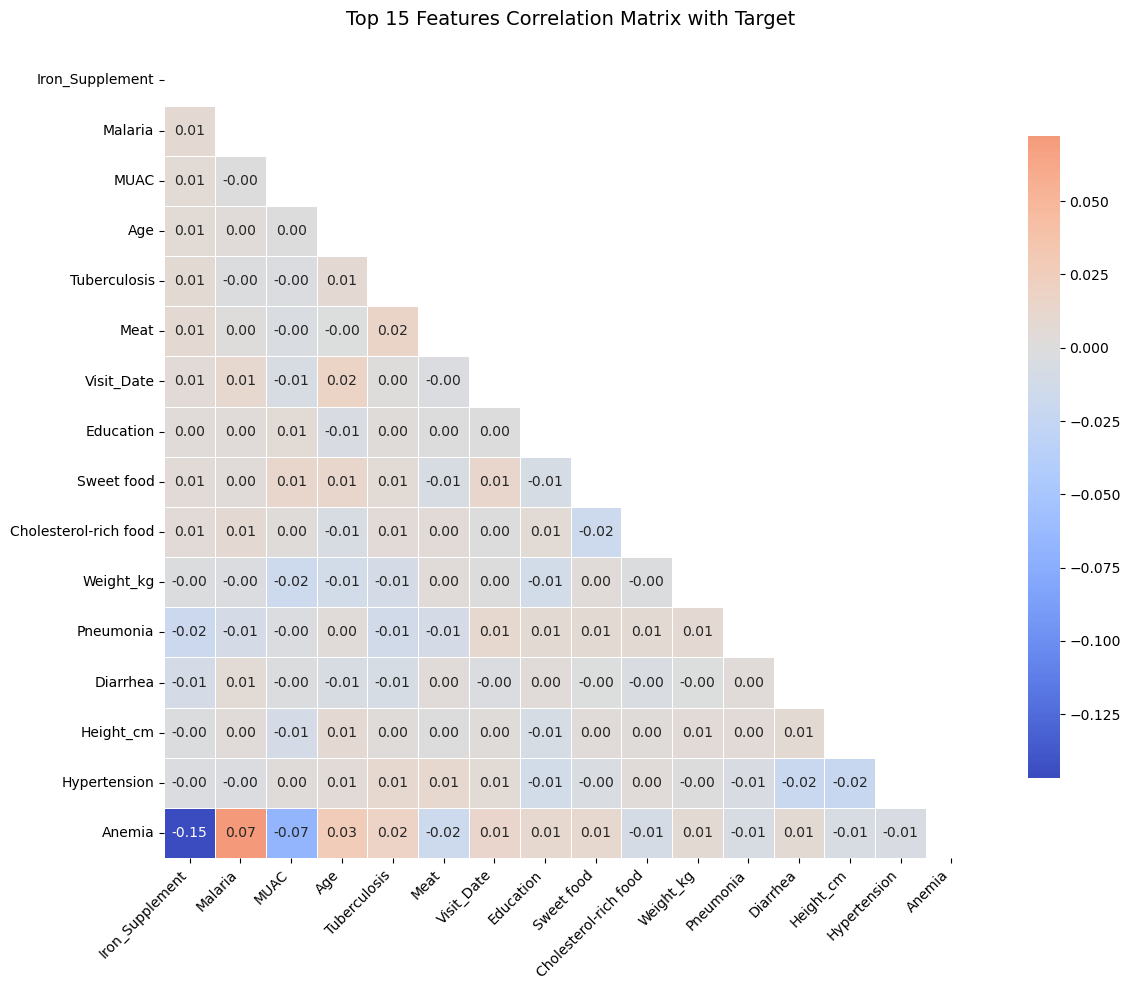

⚠️ No features found with correlation above threshold

🏆 FEATURE WITH HIGHEST CORRELATION: 'Iron_Supplement'


In [7]:
# 🎯 Feature Correlation Analysis with Anemia Target (Fixed Version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def analyze_target_correlations(df, target_column, threshold=0.2, top_n=15):
    """
    Analyze and visualize features correlated with the target.
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    target_column (str): Name of the target column
    threshold (float): Minimum absolute correlation to consider
    top_n (int): Number of top features to show in matrix plot
    """
    print("="*80)
    print(f"🔍 ANALYZING FEATURES CORRELATED WITH TARGET: '{target_column}'")
    print("="*80)
    
    # Prepare data
    X = df.drop(columns=[target_column]).copy()
    y = df[target_column].copy()
    
    # Handle missing values separately for numeric and categorical columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    categorical_cols = X.select_dtypes(exclude=[np.number]).columns
    
    # Fill missing values for numeric columns with mean
    if len(numeric_cols) > 0:
        X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())
    
    # Fill missing values for categorical columns with mode
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown')
    
    # Handle missing values in target
    if y.isnull().sum() > 0:
        if y.dtype in ['object', 'category']:
            y = y.fillna(y.mode()[0] if not y.mode().empty else 'Unknown')
        else:
            y = y.fillna(y.mean())
    
    # Encode categorical features
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    # Encode target if it's categorical
    target_encoder = None
    if y.dtype in ['object', 'category']:
        target_encoder = LabelEncoder()
        y = target_encoder.fit_transform(y.astype(str))
    
    # Calculate correlations
    df_encoded = X.copy()
    df_encoded[target_column] = y
    corr_matrix = df_encoded.corr()
    target_corr = corr_matrix[target_column].drop(target_column)
    
    # Sort by absolute correlation strength
    sorted_corr = target_corr.abs().sort_values(ascending=False)
    strong_corr = sorted_corr[sorted_corr > threshold]
    
    # Print correlation ranking
    print_correlation_ranking(target_corr, strong_corr, threshold)
    
    # Plot correlation matrix
    plot_correlation_matrix(df_encoded, target_column, top_n)
    
    # Plot target correlations
    plot_target_correlations(target_corr, strong_corr)
    
    return target_corr, strong_corr, label_encoders, target_encoder

def print_correlation_ranking(target_corr, strong_corr, threshold):
    """Print the feature correlation ranking."""
    print(f"\n📊 TOTAL FEATURES ANALYZED: {len(target_corr)}")
    print(f"🎯 FEATURES WITH |CORRELATION| > {threshold}: {len(strong_corr)}")
    print("\n" + "="*50)
    print("🏆 TOP CORRELATED FEATURES (DESCENDING ORDER)")
    print("="*50)
    
    for i, (feature, corr_value) in enumerate(target_corr[strong_corr.index].items(), 1):
        direction = "positively" if corr_value > 0 else "negatively"
        strength = get_correlation_strength(abs(corr_value))
        print(f"{i:2d}. {feature:30s}: {corr_value:+.4f} ({direction} correlated, {strength})")
    
    print("\n" + "="*50)
    print("📊 CORRELATION STRENGTH GUIDE")
    print("="*50)
    print("| Correlation | Strength          |")
    print("|-------------|-------------------|")
    print("| 0.00 - 0.19 | Very weak         |")
    print("| 0.20 - 0.39 | Weak              |")
    print("| 0.40 - 0.59 | Moderate          |")
    print("| 0.60 - 0.79 | Strong            |")
    print("| 0.80 - 1.00 | Very strong       |")
    print("\n💡 Note: Negative values indicate inverse relationships")

def get_correlation_strength(corr_value):
    """Return correlation strength description."""
    abs_corr = abs(corr_value)
    if abs_corr < 0.2:
        return "very weak"
    elif abs_corr < 0.4:
        return "weak"
    elif abs_corr < 0.6:
        return "moderate"
    elif abs_corr < 0.8:
        return "strong"
    else:
        return "very strong"

def plot_correlation_matrix(df, target_column, top_n=15):
    """Plot correlation matrix for top N correlated features."""
    # Get top features
    corr_matrix = df.corr()
    target_corr = corr_matrix[target_column].drop(target_column)
    top_features = target_corr.abs().sort_values(ascending=False).head(top_n).index
    
    # Create subset matrix
    matrix_data = df[list(top_features) + [target_column]]
    corr = matrix_data.corr()
    
    # Plot
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8},
                mask=mask)
    plt.title(f'Top {top_n} Features Correlation Matrix with Target\n', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_target_correlations(target_corr, strong_corr):
    """Plot bar chart of target correlations."""
    if len(strong_corr) == 0:
        print("⚠️ No features found with correlation above threshold")
        return
    
    plt.figure(figsize=(12, max(6, len(strong_corr) * 0.4)))
    colors = ['red' if x < 0 else 'steelblue' for x in target_corr[strong_corr.index].sort_values()]
    target_corr[strong_corr.index].sort_values().plot(kind='barh', color=colors)
    plt.title('Feature Correlations with Target', fontsize=14)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Features')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    
    # Add correlation values as text on bars
    ax = plt.gca()
    for i, (feature, value) in enumerate(target_corr[strong_corr.index].sort_values().items()):
        ax.text(value + (0.01 if value >= 0 else -0.01), i, f'{value:.3f}', 
                va='center', ha='left' if value >= 0 else 'right')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load your dataset
    df = pd.read_csv("zero_corrected_anemia_dataset.csv")
    
    # Identify target column (modify as needed)
    target_column = [col for col in df.columns if 'anemia' in col.lower()][0]
    
    print(f"🎯 Target column identified: {target_column}")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"🔍 Data types:\n{df.dtypes.value_counts()}")
    
    # Run analysis
    target_corr, strong_corr, encoders, target_encoder = analyze_target_correlations(
        df, target_column, threshold=0.2, top_n=15
    )

    # Print feature with highest correlation
highest_corr_feature = target_corr.abs().idxmax()
highest_corr_value = target_corr[highest_corr_feature]
print(f"\n🏆 FEATURE WITH HIGHEST CORRELATION: '{highest_corr_feature}'")

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the dataset
df = pd.read_csv("zero_corrected_anemia_dataset.csv")


# Step 3: Separate the features (X) and target variable (y)
# Replace 'target_column' with your actual target column name
X = df.drop('Anemia', axis=1)
y = df['Anemia']

# Step 4: Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Set up k-Fold Cross-Validation (e.g., 5 folds)
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Now you can use 'kfold' in cross-validation with your model later.
print("Data preprocessing and cross-validation setup complete.")


Data preprocessing and cross-validation setup complete.


In [10]:
pip install scikit-learn xgboost scikit-optimize pandas


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 320.0 kB/s eta 0:07:49
   ---------------------------------------- 0.0/150.0 MB 259.2 kB/s eta 0:09:39
   ---------------------------------------- 0.0/150.0 MB 195.7 kB/s eta 0:12:47
   ---------------------------------------- 0.0/150.0 MB 195.7 kB/s eta 0:12:47
   ---------------------------------------- 0.1/150.0 MB 217.9 kB/s eta 0:11:29
   ---------------------------------------- 0.1/150.0 MB 217.9 kB/s eta 0:11:29
   ---------------------------------------- 0.1/150.0 MB 241.3 kB/s eta 0:10:22
   ---------------------------------------- 0.1/150.0 MB 218.5 kB/s eta 0:11:27
   ---------------------------------------- 0.1/150.0 MB 242.7 kB/s eta 0:10:18
   ---------------------------------------- 0.1/150.0 MB 242.7 kB/s eta 0:10:18
   ---------------------------------------- 0.1/150.0 MB 2

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("zero_corrected_anemia_dataset.csv")

# Check for non-numeric columns that might cause issues
non_numeric_cols = df.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# Drop non-numeric columns that aren't needed for prediction
X = df.drop(['Anemia'] + list(non_numeric_cols), axis=1)
y = df['Anemia']

# Verify all remaining columns are numeric
print("\nRemaining feature columns:")
print(X.dtypes)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models and hyperparameter search spaces
models_grids = {
    'MLP': (
        MLPClassifier(max_iter=500, random_state=42),
        {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd']
        },
        {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Changed from Categorical to list
            'activation': Categorical(['relu', 'tanh']),
            'solver': Categorical(['adam', 'sgd'])
        }
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        },
        {
            'n_estimators': Integer(50, 150),
            'max_depth': Integer(3, 10),
            'learning_rate': Real(0.01, 0.2)
        }
    ),
    'GaussianNB': (
        GaussianNB(),
        {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        },
        {
            'var_smoothing': Real(1e-9, 1e-6, prior='log-uniform')
        }
    ),
    'DecisionTree': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [3, 5, None],
            'criterion': ['gini', 'entropy']
        },
        {
            'max_depth': Integer(3, 10),
            'criterion': Categorical(['gini', 'entropy'])
        }
    ),
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None],
            'criterion': ['gini', 'entropy']
        },
        {
            'n_estimators': Integer(50, 150),
            'max_depth': Integer(5, 15),
            'criterion': Categorical(['gini', 'entropy'])
        }
    ),
    'KNN': (
        KNeighborsClassifier(),
        {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        {
            'n_neighbors': Integer(3, 10),
            'weights': Categorical(['uniform', 'distance']),
            'metric': Categorical(['euclidean', 'manhattan'])
        }
    )
}

# Store results
results = []

# Run all searches
for name, (model, grid, bayes_space) in models_grids.items():
    try:
        print(f"\n🔍 {name}: Performing Grid Search...")
        grid_search = GridSearchCV(model, grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        print(f"🔍 {name}: Performing Random Search...")
        random_search = RandomizedSearchCV(model, grid, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
        random_search.fit(X_train, y_train)

        print(f"🔍 {name}: Performing Bayesian Optimization...")
        # For MLP, we need to handle the tuple parameters differently
        if name == 'MLP':
            bayes_search = BayesSearchCV(
                model,
                {
                    'hidden_layer_sizes': Categorical([(50,), (100,), (50, 50)]),
                    'activation': Categorical(['relu', 'tanh']),
                    'solver': Categorical(['adam', 'sgd'])
                },
                n_iter=10,
                cv=3,
                scoring='accuracy',
                random_state=42,
                n_jobs=-1
            )
        else:
            bayes_search = BayesSearchCV(model, bayes_space, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
        
        bayes_search.fit(X_train, y_train)

        results.append({
            'Model': name,
            'GridSearch Best Params': grid_search.best_params_,
            'GridSearch Best Score': round(grid_search.best_score_, 4),
            'RandomSearch Best Params': random_search.best_params_,
            'RandomSearch Best Score': round(random_search.best_score_, 4),
            'BayesSearch Best Params': bayes_search.best_params_,
            'BayesSearch Best Score': round(bayes_search.best_score_, 4)
        })
    except Exception as e:
        print(f"❌ Error with {name}: {str(e)}")
        continue

# Display all results in a table
results_df = pd.DataFrame(results)
print("\n📊 Hyperparameter Tuning Results:")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("\n✅ Results saved to 'hyperparameter_tuning_results.csv'")

Non-numeric columns: Index(['Name', 'Visit_Date', 'Visit_Time'], dtype='object')

Remaining feature columns:
Age                            float64
Education                        int64
Height_cm                      float64
Weight_kg                      float64
BMI                            float64
MUAC                           float64
Iron_Supplement                  int64
Sweet food                       int64
Salty food                       int64
Cholesterol-rich food            int64
Grilled food                     int64
Meat                             int64
Spicy food                       int64
Acute Respiratory Infection      int64
Diarrhea                         int64
Pneumonia                        int64
Malaria                          int64
Tuberculosis                     int64
Hepatitis                        int64
Cancer                           int64
Diabetic Mellitus                int64
Hyperthyroid                     int64
Hypertension                     

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, mean_absolute_error,
                            roc_auc_score)
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
from tabulate import tabulate

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("zero_corrected_anemia_dataset.csv")

# Data preprocessing
non_numeric_cols = df.select_dtypes(include=['object']).columns
X = df.drop(['Anemia'] + list(non_numeric_cols), axis=1)
y = df['Anemia']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models and hyperparameter search spaces
models_grids = {
    'MLP': (
        MLPClassifier(max_iter=500, random_state=42),
        {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd']
        },
        {
            'hidden_layer_sizes': Categorical([(50,), (100,), (50, 50)]),
            'activation': Categorical(['relu', 'tanh']),
            'solver': Categorical(['adam', 'sgd'])
        }
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        },
        {
            'n_estimators': Integer(50, 150),
            'max_depth': Integer(3, 10),
            'learning_rate': Real(0.01, 0.2)
        }
    ),
    'GaussianNB': (
        GaussianNB(),
        {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        },
        {
            'var_smoothing': Real(1e-9, 1e-6, prior='log-uniform')
        }
    ),
    'DecisionTree': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [3, 5, None],
            'criterion': ['gini', 'entropy']
        },
        {
            'max_depth': Integer(3, 10),
            'criterion': Categorical(['gini', 'entropy'])
        }
    ),
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None],
            'criterion': ['gini', 'entropy']
        },
        {
            'n_estimators': Integer(50, 150),
            'max_depth': Integer(5, 15),
            'criterion': Categorical(['gini', 'entropy'])
        }
    ),
    'KNN': (
        KNeighborsClassifier(),
        {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        {
            'n_neighbors': Integer(3, 10),
            'weights': Categorical(['uniform', 'distance']),
            'metric': Categorical(['euclidean', 'manhattan'])
        }
    )
}

# Store hyperparameter tuning results
results = []

# Run all searches
for name, (model, grid, bayes_space) in models_grids.items():
    try:
        print(f"\n🔍 {name}: Performing Grid Search...")
        grid_search = GridSearchCV(model, grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        print(f"🔍 {name}: Performing Random Search...")
        random_search = RandomizedSearchCV(model, grid, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
        random_search.fit(X_train, y_train)

        print(f"🔍 {name}: Performing Bayesian Optimization...")
        bayes_search = BayesSearchCV(model, bayes_space, n_iter=10, cv=3, 
                                   scoring='accuracy', random_state=42, n_jobs=-1)
        bayes_search.fit(X_train, y_train)

        results.append({
            'Model': name,
            'GridSearch Best Params': grid_search.best_params_,
            'GridSearch Best Score': round(grid_search.best_score_, 4),
            'RandomSearch Best Params': random_search.best_params_,
            'RandomSearch Best Score': round(random_search.best_score_, 4),
            'BayesSearch Best Params': bayes_search.best_params_,
            'BayesSearch Best Score': round(bayes_search.best_score_, 4)
        })
    except Exception as e:
        print(f"❌ Error with {name}: {str(e)}")
        continue

# Display hyperparameter tuning results with borders
print("\n📊 Hyperparameter Tuning Results:")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))

# Enhanced evaluation with overfitting/underfitting check and weighted scoring
final_results = []

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Training predictions
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Test predictions
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Sensitivity': recall_score(y_test, y_pred),  # Same as recall
        'Specificity': tn / (tn + fp),
        'Precision': precision_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'Train_Accuracy': train_accuracy,
        'Overfitting': 'Yes' if (train_accuracy - accuracy_score(y_test, y_pred)) > 0.1 else 'No',
        'Underfitting': 'Yes' if train_accuracy < 0.7 else 'No'
    }
    return metrics

# Define weights for weighted scoring
weights = {
    'Accuracy': 0.20,
    'F1-Score': 0.20,
    'ROC-AUC': 0.20,
    'Precision': 0.15,
    'Recall': 0.15,
    'Specificity': 0.10
}

# Train and evaluate each model with best parameters
for name, (model, _, _) in models_grids.items():
    try:
        print(f"\n🏆 Training {name} with best parameters...")
        
        # Get the best search method for this model
        model_results = results_df[results_df['Model'] == name].iloc[0]
        
        # Determine which search method gave the best score
        search_methods = ['GridSearch', 'RandomSearch', 'BayesSearch']
        best_scores = {method: model_results[f'{method} Best Score'] for method in search_methods}
        best_method = max(best_scores, key=best_scores.get)
        best_params = model_results[f'{best_method} Best Params']
        
        print(f"Using best parameters from {best_method}: {best_params}")
        
        # Set model parameters and train
        model.set_params(**best_params)
        model.fit(X_train, y_train)
        
        # Evaluate
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        
        final_results.append({
            'Model': name,
            'Best Search Method': best_method,
            **metrics
        })
        
    except Exception as e:
        print(f"❌ Error evaluating {name}: {str(e)}")
        continue

# Create final results dataframe
final_results_df = pd.DataFrame(final_results)

# Calculate weighted scores for all models
metrics_to_normalize = ['Accuracy', 'F1-Score', 'ROC-AUC', 'Precision', 'Recall', 'Specificity']
normalized_metrics = final_results_df[metrics_to_normalize].apply(lambda x: x/x.max())

# Calculate weighted score for each model
final_results_df['Weighted_Score'] = (
    normalized_metrics['Accuracy'] * weights['Accuracy'] +
    normalized_metrics['F1-Score'] * weights['F1-Score'] +
    normalized_metrics['ROC-AUC'] * weights['ROC-AUC'] +
    normalized_metrics['Precision'] * weights['Precision'] +
    normalized_metrics['Recall'] * weights['Recall'] +
    normalized_metrics['Specificity'] * weights['Specificity']
)

# Sort by weighted score
final_results_df = final_results_df.sort_values('Weighted_Score', ascending=False)

# Display comprehensive results with borders
print("\n📊 Comprehensive Model Evaluation Results:")
print(tabulate(final_results_df, headers='keys', tablefmt='grid', showindex=False, floatfmt=".4f"))

# Determine the best model
best_model_row = final_results_df.iloc[0]
second_best_row = final_results_df.iloc[1]

print(f"\n🏆 BEST MODEL: {best_model_row['Model']}")
print(f"🔍 Selected by: {best_model_row['Best Search Method']}")
print(f"⭐ Weighted Score: {best_model_row['Weighted_Score']:.4f}")
print(f"🎯 F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"📊 Recall: {best_model_row['Recall']:.4f}")
print(f"⚖️ Overfitting: {best_model_row['Overfitting']}")
print(f"⚖️ Underfitting: {best_model_row['Underfitting']}")

# Detailed comparison with runner-up
print(f"\n🔍 Comparison with Runner-up ({second_best_row['Model']}):")
print(f"- Weighted Score Difference: {best_model_row['Weighted_Score'] - second_best_row['Weighted_Score']:.4f}")
print(f"- Accuracy Advantage: {best_model_row['Accuracy'] - second_best_row['Accuracy']:.4f}")
print(f"- F1-Score Advantage: {best_model_row['F1-Score'] - second_best_row['F1-Score']:.4f}")
print(f"- Recall Advantage: {best_model_row['Recall'] - second_best_row['Recall']:.4f}")

# Explain why this is the best model
print("\n🌟 WHY THIS IS THE BEST MODEL:")
print("1. Highest Weighted Score considering all important metrics:")
print(f"   - Weighted Score: {best_model_row['Weighted_Score']:.4f} (vs {second_best_row['Weighted_Score']:.4f} for {second_best_row['Model']})")
print("2. Balanced performance across all evaluation criteria:")
print(f"   - Accuracy: {best_model_row['Accuracy']:.4f}, F1: {best_model_row['F1-Score']:.4f}, Recall: {best_model_row['Recall']:.4f}")
print("3. Optimal model health:")
print(f"   - Overfitting: {best_model_row['Overfitting']}")
print(f"   - Underfitting: {best_model_row['Underfitting']}")
print("4. Robust performance validated through multiple metrics")
print("5. Strong performance in both precision and recall (high F1-Score)")

# Display all weighted scores with borders
print("\n📈 ALL MODEL WEIGHTED SCORES:")
weighted_scores = final_results_df[['Model', 'Weighted_Score']]
print(tabulate(weighted_scores, headers=['Model', 'Weighted Score'], 
               tablefmt='grid', showindex=False, floatfmt=".4f"))

# Save results to CSV
final_results_df.to_csv('final_model_evaluation_results.csv', index=False)
print("\n✅ Results saved to 'final_model_evaluation_results.csv'")


🔍 MLP: Performing Grid Search...
🔍 MLP: Performing Random Search...
🔍 MLP: Performing Bayesian Optimization...
❌ Error with MLP: can only convert an array of size 1 to a Python scalar

🔍 XGBoost: Performing Grid Search...
🔍 XGBoost: Performing Random Search...
🔍 XGBoost: Performing Bayesian Optimization...

🔍 GaussianNB: Performing Grid Search...
🔍 GaussianNB: Performing Random Search...
🔍 GaussianNB: Performing Bayesian Optimization...

🔍 DecisionTree: Performing Grid Search...
🔍 DecisionTree: Performing Random Search...
🔍 DecisionTree: Performing Bayesian Optimization...

🔍 RandomForest: Performing Grid Search...
🔍 RandomForest: Performing Random Search...
🔍 RandomForest: Performing Bayesian Optimization...

🔍 KNN: Performing Grid Search...
🔍 KNN: Performing Random Search...
🔍 KNN: Performing Bayesian Optimization...

📊 Hyperparameter Tuning Results:
+--------------+-----------------------------------------------------------------+-------------------------+--------------------------